# Assignment 3 Task 1 - DL Approach Using I3D 


### Run these if you are missing dependencies/ download the pretrained i3d model

* pip install torch torchvision opencv-python decord tqdm pandas seaborn sklearn
* !rm -rf pytorch-i3d  # In case of bad clone
* !git clone https://github.com/piergiaj/pytorch-i3d.git
* !pip install imageio[ffmpeg]

## 1.1 Spliting the UCF101 Dataset into test and train split by selecting only 15 of the 101 classes:

### Selected classes during preprocessing:

* ApplyLipstick (Human-Object Interaction)
* CuttingInKitchen (Human-Object Interaction)
* Typing (Human-Object Interaction)
* BabyCrawling (Body-Motion Only)
* HandstandWalking (Body-Motion Only)
* JumpingJack (Body-Motion Only)
* Haircut (Human-Human Interaction)
* HeadMassage (Human-Human Interaction)
* SalsaSpins (Human-Human Interaction)
* PlayingGuitar (Playing Musical Instruments)
* PlayingPiano (Playing Musical Instruments)
* PlayingViolin (Playing Musical Instruments)
* BasketballShooting (Sports)
* GolfSwing (Sports)
* SoccerJuggling (Sports)


In [6]:
import os
import sys
import torch
import torchvision.transforms as transforms
from torchvision.io import read_video
from torchvision.transforms.functional import to_pil_image
import numpy as np
from torch.nn.functional import softmax
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

### Importing the filenames and class labels into pandas dataframes

In [10]:
video_dir = "/Users/jokar/Documents/Semester 3/ml/finalproject/UCF101/"

video_names = [
    f for f in os.listdir(video_dir)
    if os.path.isfile(os.path.join(video_dir, f))
       and f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))
]

video_names_df = pd.DataFrame(video_names, columns=['filename'])

video_names_df['category'] = video_names_df['filename'].str.split('_').str[1]
print("Number Extracted Category (classes, should be 101): ",len(video_names_df['category'].unique()))
print(video_names_df.head())
print(video_names_df.shape)

Number Extracted Category (classes, should be 101):  101
                       filename        category
0  v_CricketBowling_g01_c06.avi  CricketBowling
1    v_BreastStroke_g06_c01.avi    BreastStroke
2     v_TennisSwing_g25_c03.avi     TennisSwing
3   v_BrushingTeeth_g02_c01.avi   BrushingTeeth
4          v_Typing_g08_c03.avi          Typing
(13320, 2)


In [12]:
classinddf = pd.read_csv(
    "/Users/jokar/Documents/Semester 3/ml/finalproject/ucfTrainTestlist/classind.txt",
    sep=" ",
    header=None,
)
classinddf.columns = ["class", "category"]


print(classinddf.head())
print(classinddf.shape)

   class        category
0      1  ApplyEyeMakeup
1      2   ApplyLipstick
2      3         Archery
3      4    BabyCrawling
4      5     BalanceBeam
(101, 2)


In [14]:
classind15df = pd.read_csv(
    "/Users/jokar/Documents/Semester 3/ml/finalproject/classind15.txt",
    sep=" ",
    header=None,
)
classind15df.columns = ["class", "category"]


print(classind15df.head(5))
print(classind15df.shape)

   class          category
0      2     ApplyLipstick
1      4      BabyCrawling
2      8        Basketball
3     25  CuttingInKitchen
4     33         GolfSwing
(15, 2)


### Merging the dataframes and filtering out the filenames of the selected 15 classes

In [17]:
video_names_df_all = video_names_df.merge(classinddf,on="category", how="left")

print(video_names_df_all.head())

# Sanitory checks after joining

# Check if any missing categories during extraction
print('\nChecking for nulls: \n', video_names_df_all.isna().sum())
video_names_df_all.isna().sum()
print(video_names_df_all.shape)


                       filename        category  class
0  v_CricketBowling_g01_c06.avi  CricketBowling     23
1    v_BreastStroke_g06_c01.avi    BreastStroke     19
2     v_TennisSwing_g25_c03.avi     TennisSwing     92
3   v_BrushingTeeth_g02_c01.avi   BrushingTeeth     20
4          v_Typing_g08_c03.avi          Typing     95

Checking for nulls: 
 filename    0
category    0
class       0
dtype: int64
(13320, 3)


In [19]:
# Filtering just the 15 classes we need

video_names_15_df = classind15df.merge(video_names_df_all, on='class', how='left')

print('\nChecking for nulls: \n', video_names_15_df.isna().sum())

print("\nMismatch rows: ")
print(video_names_15_df[video_names_15_df['category_x']!=video_names_15_df['category_y']])

#removing one of the category columns
video_names_15_df['category'] = video_names_15_df['category_y']
video_names_15_df = video_names_15_df.drop(columns=['category_x','category_y'])

print("\n\nFinal dataframe with all the video names for 15 categories: ")
print(video_names_15_df.head())

print("\n\nNumber of videos in the final full set before splitting: ",video_names_15_df.shape[0])

print("\n\nNumber of videos in each category: ",video_names_15_df.shape[0])

counts = video_names_15_df['category'].value_counts()
for category, count in counts.items():
    print(f"{category}: {count}")


Checking for nulls: 
 class         0
category_x    0
filename      0
category_y    0
dtype: int64

Mismatch rows: 
Empty DataFrame
Columns: [class, category_x, filename, category_y]
Index: []


Final dataframe with all the video names for 15 categories: 
   class                     filename       category
0      2  v_ApplyLipstick_g05_c05.avi  ApplyLipstick
1      2  v_ApplyLipstick_g15_c05.avi  ApplyLipstick
2      2  v_ApplyLipstick_g22_c02.avi  ApplyLipstick
3      2  v_ApplyLipstick_g04_c01.avi  ApplyLipstick
4      2  v_ApplyLipstick_g14_c01.avi  ApplyLipstick


Number of videos in the final full set before splitting:  1921


Number of videos in each category:  1921
PlayingGuitar: 160
HeadMassage: 147
SoccerJuggling: 147
GolfSwing: 139
Typing: 136
Basketball: 134
SalsaSpin: 133
BabyCrawling: 132
Haircut: 130
JumpingJack: 123
ApplyLipstick: 114
HandstandWalking: 111
CuttingInKitchen: 110
PlayingPiano: 105
PlayingViolin: 100


### Splitting into test and train splits

In [22]:
# Splitting into train and test splits:

from sklearn.model_selection import train_test_split

def split_train_test(df, test_size=0.2, random_state=42):
    #sort the df
    df = (
        df
        .sort_values(['category','filename'])
        .reset_index(drop=True)
    )
    #split
    train_df, test_df = train_test_split(
        df,
        test_size=test_size,
        random_state=random_state,
        shuffle=True,
        stratify=df['category']
    )
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

train_df, test_df = split_train_test(video_names_15_df)

In [24]:
print("Number of videos in the final full set before splitting: ",train_df.shape[0])

print("\nNumber of videos in each category: ",train_df.shape[0])

counts = train_df['category'].value_counts()
for category, count in counts.items():
    print(f"{category}: {count}")

print("\n\nNumber of videos in the final full set before splitting: ",test_df.shape[0])

print("\nNumber of videos in each category: ",test_df.shape[0])

counts = test_df['category'].value_counts()
for category, count in counts.items():
    print(f"{category}: {count}")

Number of videos in the final full set before splitting:  1536

Number of videos in each category:  1536
PlayingGuitar: 128
SoccerJuggling: 118
HeadMassage: 117
GolfSwing: 111
Typing: 109
Basketball: 107
SalsaSpin: 106
BabyCrawling: 106
Haircut: 104
JumpingJack: 98
ApplyLipstick: 91
HandstandWalking: 89
CuttingInKitchen: 88
PlayingPiano: 84
PlayingViolin: 80


Number of videos in the final full set before splitting:  385

Number of videos in each category:  385
PlayingGuitar: 32
HeadMassage: 30
SoccerJuggling: 29
GolfSwing: 28
Basketball: 27
SalsaSpin: 27
Typing: 27
BabyCrawling: 26
Haircut: 26
JumpingJack: 25
ApplyLipstick: 23
CuttingInKitchen: 22
HandstandWalking: 22
PlayingPiano: 21
PlayingViolin: 20


### Saving the filenames into csv files for test and train splits, for downstream use

In [27]:
#train_df.to_csv('/Users/jokar/Documents/Semester 3/ml/finalproject/trainsplit15.csv', sep=",", header=True, index=None)
#test_df.to_csv('/Users/jokar/Documents/Semester 3/ml/finalproject/testsplit15.csv', sep=",", header=True, index=None)

## 1.2 Processing videos for I3D model

In [2]:
# List of selected classes
selected_classes = [
    "ApplyLipstick",
    "BabyCrawling",
    "Basketball",
    "CuttingInKitchen",
    "GolfSwing",
    "Haircut",
    "HandstandWalking",
    "HeadMassage",
    "JumpingJack",
    "PlayingGuitar",
    "PlayingPiano",
    "PlayingViolin",
    "SalsaSpin",
    "SoccerJuggling",
    "Typing"
]

# Class name → class index
label_map = {name: idx for idx, name in enumerate(selected_classes)}

# Paths
original_data_path = "UCF-101"
target_base = "data"
train_csv = "trainsplit15.csv"
test_csv = "testsplit15.csv"

# Load CSVs
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# Combine for easier looping
split_dfs = [("train", train_df), ("test", test_df)]

for split, df in split_dfs:
    for _, row in df.iterrows():
        class_name = row["category"]
        filename = row["filename"]

        if class_name not in label_map:
            print(f"Skipping unknown class: {class_name}")
            continue

        class_id = label_map[class_name]
        dest_dir = os.path.join(target_base, split, f"class_{class_id:02d}")
        os.makedirs(dest_dir, exist_ok=True)

        src_path = os.path.join(original_data_path, class_name, filename)
        dst_path = os.path.join(dest_dir, filename)

        if not os.path.exists(src_path):
            print(f"Missing file: {src_path}")
            continue

        shutil.copy2(src_path, dst_path)


### i3D Implementation:

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
from decord import VideoReader, cpu

# You’ll need to clone an I3D model if not using torchvision: e.g., from https://github.com/piergiaj/pytorch-i3d
import sys
sys.path.append('pytorch-i3d')  # or the path where you cloned it
from pytorch_i3d import InceptionI3d

NUM_CLASSES = 15
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
FRAME_COUNT = 64
VIDEO_SIZE = 224

# Train Losses
train_losses = []

# --- Custom Video Dataset ---
class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.class_map = {}
        self.transform = transform

        for i, class_dir in enumerate(sorted(os.listdir(root_dir))):
            self.class_map[class_dir] = i
            for video_path in glob(os.path.join(root_dir, class_dir, '*.avi')):
                self.samples.append((video_path, i))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        vr = VideoReader(path, ctx=cpu(0))
        total = len(vr)

        indices = np.linspace(0, total - 1, FRAME_COUNT).astype(int)
        frames = vr.get_batch(indices).asnumpy()

        frames = [cv2.resize(f, (VIDEO_SIZE, VIDEO_SIZE)) for f in frames]
        frames = np.stack(frames).transpose(3, 0, 1, 2)  # [C, T, H, W]
        frames = frames / 255.0

        if self.transform:
            frames = self.transform(torch.tensor(frames, dtype=torch.float))

        return frames, label

# --- Transforms ---
transform = T.Compose([
    T.Normalize(mean=[0.5], std=[0.5])
])

# --pit[i- Load dataset ---
train_data = VideoDataset("data/train", transform=transform)
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)

# --- Load pretrained I3D ---
model = InceptionI3d(400, in_channels=3)  # 400 is just for loading weights
model.load_state_dict(torch.load('pytorch-i3d/models/rgb_imagenet.pt'))
model.replace_logits(NUM_CLASSES)  # NUM_CLASSES = 15 — MUST come after loading weights
model = model.to(DEVICE)

# Freeze all except final layer
for name, param in model.named_parameters():
    param.requires_grad = False
for param in model.logits.parameters():
    param.requires_grad = True

# --- Train ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.logits.parameters(), lr=0.001)

model.train()
for epoch in range(5):
    total_loss = 0
    for videos, labels in tqdm(train_loader):
        videos = videos.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = model(videos)
        outputs = outputs.mean(dim=2)  # average over time → shape [B, 15]
        print(outputs.shape)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

  0%|          | 1/768 [00:07<1:29:37,  7.01s/it]

torch.Size([2, 15])


  0%|          | 2/768 [00:13<1:25:22,  6.69s/it]

torch.Size([2, 15])


  0%|          | 3/768 [00:20<1:30:00,  7.06s/it]

torch.Size([2, 15])


  1%|          | 4/768 [00:27<1:28:54,  6.98s/it]

torch.Size([2, 15])


  1%|          | 5/768 [00:34<1:27:19,  6.87s/it]

torch.Size([2, 15])


  1%|          | 6/768 [00:41<1:27:31,  6.89s/it]

torch.Size([2, 15])


  1%|          | 7/768 [00:47<1:25:50,  6.77s/it]

torch.Size([2, 15])


  1%|          | 8/768 [00:54<1:26:19,  6.82s/it]

torch.Size([2, 15])


  1%|          | 9/768 [01:01<1:23:53,  6.63s/it]

torch.Size([2, 15])


  1%|▏         | 10/768 [01:07<1:23:10,  6.58s/it]

torch.Size([2, 15])


  1%|▏         | 11/768 [01:14<1:23:33,  6.62s/it]

torch.Size([2, 15])


  2%|▏         | 12/768 [01:21<1:24:29,  6.71s/it]

torch.Size([2, 15])


  2%|▏         | 13/768 [01:29<1:29:20,  7.10s/it]

torch.Size([2, 15])


  2%|▏         | 14/768 [01:35<1:27:18,  6.95s/it]

torch.Size([2, 15])


  2%|▏         | 15/768 [01:42<1:25:04,  6.78s/it]

torch.Size([2, 15])


  2%|▏         | 16/768 [01:48<1:23:21,  6.65s/it]

torch.Size([2, 15])


  2%|▏         | 17/768 [01:55<1:25:02,  6.79s/it]

torch.Size([2, 15])


  2%|▏         | 18/768 [02:02<1:24:09,  6.73s/it]

torch.Size([2, 15])


  2%|▏         | 19/768 [02:08<1:22:37,  6.62s/it]

torch.Size([2, 15])


  3%|▎         | 20/768 [02:14<1:21:00,  6.50s/it]

torch.Size([2, 15])


  3%|▎         | 21/768 [02:21<1:22:48,  6.65s/it]

torch.Size([2, 15])


  3%|▎         | 22/768 [02:28<1:22:52,  6.67s/it]

torch.Size([2, 15])


  3%|▎         | 23/768 [02:34<1:21:00,  6.52s/it]

torch.Size([2, 15])


  3%|▎         | 24/768 [02:41<1:23:13,  6.71s/it]

torch.Size([2, 15])


  3%|▎         | 25/768 [02:48<1:23:28,  6.74s/it]

torch.Size([2, 15])


  3%|▎         | 26/768 [02:55<1:25:13,  6.89s/it]

torch.Size([2, 15])


  4%|▎         | 27/768 [03:02<1:22:58,  6.72s/it]

torch.Size([2, 15])


  4%|▎         | 28/768 [03:08<1:21:39,  6.62s/it]

torch.Size([2, 15])


  4%|▍         | 29/768 [03:15<1:21:32,  6.62s/it]

torch.Size([2, 15])


  4%|▍         | 30/768 [03:22<1:22:48,  6.73s/it]

torch.Size([2, 15])


  4%|▍         | 31/768 [03:28<1:22:24,  6.71s/it]

torch.Size([2, 15])


  4%|▍         | 32/768 [03:35<1:21:47,  6.67s/it]

torch.Size([2, 15])


  4%|▍         | 33/768 [03:41<1:19:43,  6.51s/it]

torch.Size([2, 15])


  4%|▍         | 34/768 [03:48<1:20:05,  6.55s/it]

torch.Size([2, 15])


  5%|▍         | 35/768 [03:55<1:21:47,  6.70s/it]

torch.Size([2, 15])


  5%|▍         | 36/768 [04:01<1:20:38,  6.61s/it]

torch.Size([2, 15])


  5%|▍         | 37/768 [04:08<1:19:45,  6.55s/it]

torch.Size([2, 15])


  5%|▍         | 38/768 [04:14<1:19:41,  6.55s/it]

torch.Size([2, 15])


  5%|▌         | 39/768 [04:21<1:19:17,  6.53s/it]

torch.Size([2, 15])


  5%|▌         | 40/768 [04:27<1:19:06,  6.52s/it]

torch.Size([2, 15])


  5%|▌         | 41/768 [04:33<1:17:58,  6.44s/it]

torch.Size([2, 15])


  5%|▌         | 42/768 [04:40<1:17:28,  6.40s/it]

torch.Size([2, 15])


  6%|▌         | 43/768 [04:46<1:16:49,  6.36s/it]

torch.Size([2, 15])


  6%|▌         | 44/768 [04:53<1:18:05,  6.47s/it]

torch.Size([2, 15])


  6%|▌         | 45/768 [04:59<1:18:18,  6.50s/it]

torch.Size([2, 15])


  6%|▌         | 46/768 [05:06<1:17:40,  6.46s/it]

torch.Size([2, 15])


  6%|▌         | 47/768 [05:12<1:16:42,  6.38s/it]

torch.Size([2, 15])


  6%|▋         | 48/768 [05:18<1:16:33,  6.38s/it]

torch.Size([2, 15])


  6%|▋         | 49/768 [05:25<1:19:07,  6.60s/it]

torch.Size([2, 15])


  7%|▋         | 50/768 [05:32<1:19:00,  6.60s/it]

torch.Size([2, 15])


  7%|▋         | 51/768 [05:38<1:17:41,  6.50s/it]

torch.Size([2, 15])


  7%|▋         | 52/768 [05:45<1:17:07,  6.46s/it]

torch.Size([2, 15])


  7%|▋         | 53/768 [05:51<1:17:25,  6.50s/it]

torch.Size([2, 15])


  7%|▋         | 54/768 [05:58<1:19:02,  6.64s/it]

torch.Size([2, 15])


  7%|▋         | 55/768 [06:05<1:18:09,  6.58s/it]

torch.Size([2, 15])


  7%|▋         | 56/768 [06:11<1:17:01,  6.49s/it]

torch.Size([2, 15])


  7%|▋         | 57/768 [06:17<1:15:52,  6.40s/it]

torch.Size([2, 15])


  8%|▊         | 58/768 [06:24<1:18:06,  6.60s/it]

torch.Size([2, 15])


  8%|▊         | 59/768 [06:30<1:17:01,  6.52s/it]

torch.Size([2, 15])


  8%|▊         | 60/768 [06:37<1:17:02,  6.53s/it]

torch.Size([2, 15])


  8%|▊         | 61/768 [06:43<1:16:04,  6.46s/it]

torch.Size([2, 15])


  8%|▊         | 62/768 [06:50<1:15:55,  6.45s/it]

torch.Size([2, 15])


  8%|▊         | 63/768 [06:57<1:18:06,  6.65s/it]

torch.Size([2, 15])


  8%|▊         | 64/768 [07:03<1:16:59,  6.56s/it]

torch.Size([2, 15])


  8%|▊         | 65/768 [07:09<1:15:49,  6.47s/it]

torch.Size([2, 15])


  9%|▊         | 66/768 [07:16<1:15:41,  6.47s/it]

torch.Size([2, 15])


  9%|▊         | 67/768 [07:23<1:17:40,  6.65s/it]

torch.Size([2, 15])


  9%|▉         | 68/768 [07:30<1:19:38,  6.83s/it]

torch.Size([2, 15])


  9%|▉         | 69/768 [07:37<1:18:24,  6.73s/it]

torch.Size([2, 15])


  9%|▉         | 70/768 [07:43<1:17:12,  6.64s/it]

torch.Size([2, 15])


  9%|▉         | 71/768 [07:50<1:19:07,  6.81s/it]

torch.Size([2, 15])


  9%|▉         | 72/768 [07:57<1:18:11,  6.74s/it]

torch.Size([2, 15])


 10%|▉         | 73/768 [08:03<1:16:26,  6.60s/it]

torch.Size([2, 15])


 10%|▉         | 74/768 [08:10<1:15:44,  6.55s/it]

torch.Size([2, 15])


 10%|▉         | 75/768 [08:16<1:16:26,  6.62s/it]

torch.Size([2, 15])


 10%|▉         | 76/768 [08:23<1:16:30,  6.63s/it]

torch.Size([2, 15])


 10%|█         | 77/768 [08:29<1:15:15,  6.53s/it]

torch.Size([2, 15])


 10%|█         | 78/768 [08:36<1:14:33,  6.48s/it]

torch.Size([2, 15])


 10%|█         | 79/768 [08:42<1:13:35,  6.41s/it]

torch.Size([2, 15])


 10%|█         | 80/768 [08:48<1:13:15,  6.39s/it]

torch.Size([2, 15])


 11%|█         | 81/768 [08:55<1:15:48,  6.62s/it]

torch.Size([2, 15])


 11%|█         | 82/768 [09:02<1:15:01,  6.56s/it]

torch.Size([2, 15])


 11%|█         | 83/768 [09:08<1:14:12,  6.50s/it]

torch.Size([2, 15])


 11%|█         | 84/768 [09:15<1:13:31,  6.45s/it]

torch.Size([2, 15])


 11%|█         | 85/768 [09:21<1:14:32,  6.55s/it]

torch.Size([2, 15])


 11%|█         | 86/768 [09:28<1:16:01,  6.69s/it]

torch.Size([2, 15])


 11%|█▏        | 87/768 [09:35<1:15:53,  6.69s/it]

torch.Size([2, 15])


 11%|█▏        | 88/768 [09:41<1:14:31,  6.58s/it]

torch.Size([2, 15])


 12%|█▏        | 89/768 [09:48<1:13:24,  6.49s/it]

torch.Size([2, 15])


 12%|█▏        | 90/768 [09:55<1:15:25,  6.67s/it]

torch.Size([2, 15])


 12%|█▏        | 91/768 [10:01<1:14:15,  6.58s/it]

torch.Size([2, 15])


 12%|█▏        | 92/768 [10:08<1:14:18,  6.60s/it]

torch.Size([2, 15])


 12%|█▏        | 93/768 [10:14<1:13:14,  6.51s/it]

torch.Size([2, 15])


 12%|█▏        | 94/768 [10:20<1:12:27,  6.45s/it]

torch.Size([2, 15])


 12%|█▏        | 95/768 [10:27<1:14:20,  6.63s/it]

torch.Size([2, 15])


 12%|█▎        | 96/768 [10:34<1:13:52,  6.60s/it]

torch.Size([2, 15])


 13%|█▎        | 97/768 [10:41<1:13:47,  6.60s/it]

torch.Size([2, 15])


 13%|█▎        | 98/768 [10:47<1:12:36,  6.50s/it]

torch.Size([2, 15])


 13%|█▎        | 99/768 [10:53<1:12:02,  6.46s/it]

torch.Size([2, 15])


 13%|█▎        | 100/768 [11:00<1:11:42,  6.44s/it]

torch.Size([2, 15])


 13%|█▎        | 101/768 [11:06<1:11:09,  6.40s/it]

torch.Size([2, 15])


 13%|█▎        | 102/768 [11:12<1:11:34,  6.45s/it]

torch.Size([2, 15])


 13%|█▎        | 103/768 [11:19<1:11:24,  6.44s/it]

torch.Size([2, 15])


 14%|█▎        | 104/768 [11:26<1:12:39,  6.57s/it]

torch.Size([2, 15])


 14%|█▎        | 105/768 [11:32<1:12:28,  6.56s/it]

torch.Size([2, 15])


 14%|█▍        | 106/768 [11:39<1:11:33,  6.49s/it]

torch.Size([2, 15])


 14%|█▍        | 107/768 [11:45<1:10:49,  6.43s/it]

torch.Size([2, 15])


 14%|█▍        | 108/768 [11:51<1:10:53,  6.45s/it]

torch.Size([2, 15])


 14%|█▍        | 109/768 [11:58<1:10:17,  6.40s/it]

torch.Size([2, 15])


 14%|█▍        | 110/768 [12:04<1:10:09,  6.40s/it]

torch.Size([2, 15])


 14%|█▍        | 111/768 [12:10<1:09:42,  6.37s/it]

torch.Size([2, 15])


 15%|█▍        | 112/768 [12:17<1:10:56,  6.49s/it]

torch.Size([2, 15])


 15%|█▍        | 113/768 [12:24<1:13:41,  6.75s/it]

torch.Size([2, 15])


 15%|█▍        | 114/768 [12:31<1:12:21,  6.64s/it]

torch.Size([2, 15])


 15%|█▍        | 115/768 [12:37<1:11:24,  6.56s/it]

torch.Size([2, 15])


 15%|█▌        | 116/768 [12:44<1:10:29,  6.49s/it]

torch.Size([2, 15])


 15%|█▌        | 117/768 [12:50<1:11:23,  6.58s/it]

torch.Size([2, 15])


 15%|█▌        | 118/768 [12:57<1:12:20,  6.68s/it]

torch.Size([2, 15])


 15%|█▌        | 119/768 [13:04<1:10:56,  6.56s/it]

torch.Size([2, 15])


 16%|█▌        | 120/768 [13:10<1:09:51,  6.47s/it]

torch.Size([2, 15])


 16%|█▌        | 121/768 [13:16<1:08:53,  6.39s/it]

torch.Size([2, 15])


 16%|█▌        | 122/768 [13:23<1:10:22,  6.54s/it]

torch.Size([2, 15])


 16%|█▌        | 123/768 [13:30<1:11:21,  6.64s/it]

torch.Size([2, 15])


 16%|█▌        | 124/768 [13:36<1:10:33,  6.57s/it]

torch.Size([2, 15])


 16%|█▋        | 125/768 [13:42<1:09:35,  6.49s/it]

torch.Size([2, 15])


 16%|█▋        | 126/768 [13:49<1:09:08,  6.46s/it]

torch.Size([2, 15])


 17%|█▋        | 127/768 [13:56<1:10:54,  6.64s/it]

torch.Size([2, 15])


 17%|█▋        | 128/768 [14:02<1:10:09,  6.58s/it]

torch.Size([2, 15])


 17%|█▋        | 129/768 [14:09<1:09:52,  6.56s/it]

torch.Size([2, 15])


 17%|█▋        | 130/768 [14:15<1:09:29,  6.54s/it]

torch.Size([2, 15])


 17%|█▋        | 131/768 [14:22<1:11:15,  6.71s/it]

torch.Size([2, 15])


 17%|█▋        | 132/768 [14:29<1:10:58,  6.70s/it]

torch.Size([2, 15])


 17%|█▋        | 133/768 [14:36<1:09:54,  6.61s/it]

torch.Size([2, 15])


 17%|█▋        | 134/768 [14:42<1:09:40,  6.59s/it]

torch.Size([2, 15])


 18%|█▊        | 135/768 [14:49<1:10:12,  6.65s/it]

torch.Size([2, 15])


 18%|█▊        | 136/768 [14:56<1:10:18,  6.68s/it]

torch.Size([2, 15])


 18%|█▊        | 137/768 [15:02<1:09:29,  6.61s/it]

torch.Size([2, 15])


 18%|█▊        | 138/768 [15:08<1:08:48,  6.55s/it]

torch.Size([2, 15])


 18%|█▊        | 139/768 [15:15<1:08:56,  6.58s/it]

torch.Size([2, 15])


 18%|█▊        | 140/768 [15:22<1:09:05,  6.60s/it]

torch.Size([2, 15])


 18%|█▊        | 141/768 [15:29<1:10:11,  6.72s/it]

torch.Size([2, 15])


 18%|█▊        | 142/768 [15:35<1:09:31,  6.66s/it]

torch.Size([2, 15])


 19%|█▊        | 143/768 [15:42<1:08:22,  6.56s/it]

torch.Size([2, 15])


 19%|█▉        | 144/768 [15:48<1:08:39,  6.60s/it]

torch.Size([2, 15])


 19%|█▉        | 145/768 [15:56<1:10:43,  6.81s/it]

torch.Size([2, 15])


 19%|█▉        | 146/768 [16:02<1:09:35,  6.71s/it]

torch.Size([2, 15])


 19%|█▉        | 147/768 [16:08<1:08:06,  6.58s/it]

torch.Size([2, 15])


 19%|█▉        | 148/768 [16:15<1:07:38,  6.55s/it]

torch.Size([2, 15])


 19%|█▉        | 149/768 [16:21<1:07:17,  6.52s/it]

torch.Size([2, 15])


 20%|█▉        | 150/768 [16:28<1:07:04,  6.51s/it]

torch.Size([2, 15])


 20%|█▉        | 151/768 [16:34<1:06:24,  6.46s/it]

torch.Size([2, 15])


 20%|█▉        | 152/768 [16:41<1:06:11,  6.45s/it]

torch.Size([2, 15])


 20%|█▉        | 153/768 [16:47<1:05:52,  6.43s/it]

torch.Size([2, 15])


 20%|██        | 154/768 [16:54<1:08:47,  6.72s/it]

torch.Size([2, 15])


 20%|██        | 155/768 [17:01<1:08:00,  6.66s/it]

torch.Size([2, 15])


 20%|██        | 156/768 [17:08<1:09:25,  6.81s/it]

torch.Size([2, 15])


 20%|██        | 157/768 [17:14<1:07:46,  6.65s/it]

torch.Size([2, 15])


 21%|██        | 158/768 [17:22<1:09:53,  6.87s/it]

torch.Size([2, 15])


 21%|██        | 159/768 [17:28<1:09:06,  6.81s/it]

torch.Size([2, 15])


 21%|██        | 160/768 [17:35<1:09:07,  6.82s/it]

torch.Size([2, 15])


 21%|██        | 161/768 [17:42<1:07:33,  6.68s/it]

torch.Size([2, 15])


 21%|██        | 162/768 [17:48<1:08:13,  6.75s/it]

torch.Size([2, 15])


 21%|██        | 163/768 [17:55<1:07:59,  6.74s/it]

torch.Size([2, 15])


 21%|██▏       | 164/768 [18:02<1:07:04,  6.66s/it]

torch.Size([2, 15])


 21%|██▏       | 165/768 [18:08<1:06:45,  6.64s/it]

torch.Size([2, 15])


 22%|██▏       | 166/768 [18:15<1:06:09,  6.59s/it]

torch.Size([2, 15])


 22%|██▏       | 167/768 [18:21<1:05:36,  6.55s/it]

torch.Size([2, 15])


 22%|██▏       | 168/768 [18:28<1:05:23,  6.54s/it]

torch.Size([2, 15])


 22%|██▏       | 169/768 [18:34<1:04:49,  6.49s/it]

torch.Size([2, 15])


 22%|██▏       | 170/768 [18:41<1:05:08,  6.54s/it]

torch.Size([2, 15])


 22%|██▏       | 171/768 [18:47<1:04:54,  6.52s/it]

torch.Size([2, 15])


 22%|██▏       | 172/768 [18:54<1:06:14,  6.67s/it]

torch.Size([2, 15])


 23%|██▎       | 173/768 [19:01<1:05:40,  6.62s/it]

torch.Size([2, 15])


 23%|██▎       | 174/768 [19:07<1:05:13,  6.59s/it]

torch.Size([2, 15])


 23%|██▎       | 175/768 [19:14<1:04:49,  6.56s/it]

torch.Size([2, 15])


 23%|██▎       | 176/768 [19:20<1:05:04,  6.60s/it]

torch.Size([2, 15])


 23%|██▎       | 177/768 [19:27<1:04:48,  6.58s/it]

torch.Size([2, 15])


 23%|██▎       | 178/768 [19:34<1:04:52,  6.60s/it]

torch.Size([2, 15])


 23%|██▎       | 179/768 [19:40<1:04:11,  6.54s/it]

torch.Size([2, 15])


 23%|██▎       | 180/768 [19:46<1:03:39,  6.50s/it]

torch.Size([2, 15])


 24%|██▎       | 181/768 [19:54<1:06:16,  6.77s/it]

torch.Size([2, 15])


 24%|██▎       | 182/768 [20:00<1:05:32,  6.71s/it]

torch.Size([2, 15])


 24%|██▍       | 183/768 [20:07<1:04:34,  6.62s/it]

torch.Size([2, 15])


 24%|██▍       | 184/768 [20:13<1:03:57,  6.57s/it]

torch.Size([2, 15])


 24%|██▍       | 185/768 [20:20<1:03:15,  6.51s/it]

torch.Size([2, 15])


 24%|██▍       | 186/768 [20:26<1:03:59,  6.60s/it]

torch.Size([2, 15])


 24%|██▍       | 187/768 [20:33<1:03:20,  6.54s/it]

torch.Size([2, 15])


 24%|██▍       | 188/768 [20:39<1:02:58,  6.52s/it]

torch.Size([2, 15])


 25%|██▍       | 189/768 [20:46<1:02:47,  6.51s/it]

torch.Size([2, 15])


 25%|██▍       | 190/768 [20:53<1:04:01,  6.65s/it]

torch.Size([2, 15])


 25%|██▍       | 191/768 [21:00<1:05:06,  6.77s/it]

torch.Size([2, 15])


 25%|██▌       | 192/768 [21:06<1:04:32,  6.72s/it]

torch.Size([2, 15])


 25%|██▌       | 193/768 [21:13<1:03:27,  6.62s/it]

torch.Size([2, 15])


 25%|██▌       | 194/768 [21:19<1:03:06,  6.60s/it]

torch.Size([2, 15])


 25%|██▌       | 195/768 [21:27<1:04:50,  6.79s/it]

torch.Size([2, 15])


 26%|██▌       | 196/768 [21:33<1:05:03,  6.82s/it]

torch.Size([2, 15])


 26%|██▌       | 197/768 [21:40<1:03:54,  6.72s/it]

torch.Size([2, 15])


 26%|██▌       | 198/768 [21:46<1:03:14,  6.66s/it]

torch.Size([2, 15])


 26%|██▌       | 199/768 [21:54<1:04:38,  6.82s/it]

torch.Size([2, 15])


 26%|██▌       | 200/768 [22:00<1:03:59,  6.76s/it]

torch.Size([2, 15])


 26%|██▌       | 201/768 [22:07<1:03:48,  6.75s/it]

torch.Size([2, 15])


 26%|██▋       | 202/768 [22:14<1:03:03,  6.68s/it]

torch.Size([2, 15])


 26%|██▋       | 203/768 [22:20<1:03:00,  6.69s/it]

torch.Size([2, 15])


 27%|██▋       | 204/768 [22:27<1:04:12,  6.83s/it]

torch.Size([2, 15])


 27%|██▋       | 205/768 [22:34<1:02:47,  6.69s/it]

torch.Size([2, 15])


 27%|██▋       | 206/768 [22:41<1:02:44,  6.70s/it]

torch.Size([2, 15])


 27%|██▋       | 207/768 [22:47<1:02:50,  6.72s/it]

torch.Size([2, 15])


 27%|██▋       | 208/768 [22:55<1:04:30,  6.91s/it]

torch.Size([2, 15])


 27%|██▋       | 209/768 [23:01<1:02:43,  6.73s/it]

torch.Size([2, 15])


 27%|██▋       | 210/768 [23:07<1:01:54,  6.66s/it]

torch.Size([2, 15])


 27%|██▋       | 211/768 [23:14<1:01:32,  6.63s/it]

torch.Size([2, 15])


 28%|██▊       | 212/768 [23:21<1:02:10,  6.71s/it]

torch.Size([2, 15])


 28%|██▊       | 213/768 [23:28<1:03:15,  6.84s/it]

torch.Size([2, 15])


 28%|██▊       | 214/768 [23:35<1:02:31,  6.77s/it]

torch.Size([2, 15])


 28%|██▊       | 215/768 [23:41<1:01:27,  6.67s/it]

torch.Size([2, 15])


 28%|██▊       | 216/768 [23:48<1:02:09,  6.76s/it]

torch.Size([2, 15])


 28%|██▊       | 217/768 [23:55<1:03:42,  6.94s/it]

torch.Size([2, 15])


 28%|██▊       | 218/768 [24:02<1:02:21,  6.80s/it]

torch.Size([2, 15])


 29%|██▊       | 219/768 [24:08<1:01:16,  6.70s/it]

torch.Size([2, 15])


 29%|██▊       | 220/768 [24:15<1:00:38,  6.64s/it]

torch.Size([2, 15])


 29%|██▉       | 221/768 [24:22<1:01:56,  6.80s/it]

torch.Size([2, 15])


 29%|██▉       | 222/768 [24:29<1:01:58,  6.81s/it]

torch.Size([2, 15])


 29%|██▉       | 223/768 [24:35<1:00:27,  6.66s/it]

torch.Size([2, 15])


 29%|██▉       | 224/768 [24:42<59:45,  6.59s/it]  

torch.Size([2, 15])


 29%|██▉       | 225/768 [24:48<59:40,  6.59s/it]

torch.Size([2, 15])


 29%|██▉       | 226/768 [24:55<1:00:23,  6.69s/it]

torch.Size([2, 15])


 30%|██▉       | 227/768 [25:02<1:00:51,  6.75s/it]

torch.Size([2, 15])


 30%|██▉       | 228/768 [25:08<59:42,  6.63s/it]  

torch.Size([2, 15])


 30%|██▉       | 229/768 [25:14<58:02,  6.46s/it]

torch.Size([2, 15])


 30%|██▉       | 230/768 [25:21<58:31,  6.53s/it]

torch.Size([2, 15])


 30%|███       | 231/768 [25:28<58:56,  6.59s/it]

torch.Size([2, 15])


 30%|███       | 232/768 [25:35<59:16,  6.64s/it]

torch.Size([2, 15])


 30%|███       | 233/768 [25:41<58:47,  6.59s/it]

torch.Size([2, 15])


 30%|███       | 234/768 [25:47<58:15,  6.55s/it]

torch.Size([2, 15])


 31%|███       | 235/768 [25:54<57:21,  6.46s/it]

torch.Size([2, 15])


 31%|███       | 236/768 [26:00<56:57,  6.42s/it]

torch.Size([2, 15])


 31%|███       | 237/768 [26:06<56:14,  6.35s/it]

torch.Size([2, 15])


 31%|███       | 238/768 [26:13<57:01,  6.46s/it]

torch.Size([2, 15])


 31%|███       | 239/768 [26:20<58:06,  6.59s/it]

torch.Size([2, 15])


 31%|███▏      | 240/768 [26:27<58:22,  6.63s/it]

torch.Size([2, 15])


 31%|███▏      | 241/768 [26:33<57:45,  6.58s/it]

torch.Size([2, 15])


 32%|███▏      | 242/768 [26:40<59:10,  6.75s/it]

torch.Size([2, 15])


 32%|███▏      | 243/768 [26:47<59:28,  6.80s/it]

torch.Size([2, 15])


 32%|███▏      | 244/768 [26:54<59:15,  6.78s/it]

torch.Size([2, 15])


 32%|███▏      | 245/768 [27:00<58:11,  6.68s/it]

torch.Size([2, 15])


 32%|███▏      | 246/768 [27:07<56:52,  6.54s/it]

torch.Size([2, 15])


 32%|███▏      | 247/768 [27:13<56:01,  6.45s/it]

torch.Size([2, 15])


 32%|███▏      | 248/768 [27:19<56:32,  6.52s/it]

torch.Size([2, 15])


 32%|███▏      | 249/768 [27:27<58:05,  6.72s/it]

torch.Size([2, 15])


 33%|███▎      | 250/768 [27:33<57:08,  6.62s/it]

torch.Size([2, 15])


 33%|███▎      | 251/768 [27:39<56:17,  6.53s/it]

torch.Size([2, 15])


 33%|███▎      | 252/768 [27:46<56:04,  6.52s/it]

torch.Size([2, 15])


 33%|███▎      | 253/768 [27:53<58:20,  6.80s/it]

torch.Size([2, 15])


 33%|███▎      | 254/768 [28:00<57:30,  6.71s/it]

torch.Size([2, 15])


 33%|███▎      | 255/768 [28:06<56:54,  6.66s/it]

torch.Size([2, 15])


 33%|███▎      | 256/768 [28:13<56:22,  6.61s/it]

torch.Size([2, 15])


 33%|███▎      | 257/768 [28:20<56:45,  6.66s/it]

torch.Size([2, 15])


 34%|███▎      | 258/768 [28:26<57:06,  6.72s/it]

torch.Size([2, 15])


 34%|███▎      | 259/768 [28:33<56:30,  6.66s/it]

torch.Size([2, 15])


 34%|███▍      | 260/768 [28:39<55:57,  6.61s/it]

torch.Size([2, 15])


 34%|███▍      | 261/768 [28:46<55:23,  6.56s/it]

torch.Size([2, 15])


 34%|███▍      | 262/768 [28:53<56:05,  6.65s/it]

torch.Size([2, 15])


 34%|███▍      | 263/768 [28:59<55:50,  6.63s/it]

torch.Size([2, 15])


 34%|███▍      | 264/768 [29:06<55:45,  6.64s/it]

torch.Size([2, 15])


 35%|███▍      | 265/768 [29:12<54:53,  6.55s/it]

torch.Size([2, 15])


 35%|███▍      | 266/768 [29:19<55:41,  6.66s/it]

torch.Size([2, 15])


 35%|███▍      | 267/768 [29:26<55:57,  6.70s/it]

torch.Size([2, 15])


 35%|███▍      | 268/768 [29:33<55:35,  6.67s/it]

torch.Size([2, 15])


 35%|███▌      | 269/768 [29:39<55:49,  6.71s/it]

torch.Size([2, 15])


 35%|███▌      | 270/768 [29:46<55:40,  6.71s/it]

torch.Size([2, 15])


 35%|███▌      | 271/768 [29:53<56:10,  6.78s/it]

torch.Size([2, 15])


 35%|███▌      | 272/768 [30:00<55:43,  6.74s/it]

torch.Size([2, 15])


 36%|███▌      | 273/768 [30:06<54:45,  6.64s/it]

torch.Size([2, 15])


 36%|███▌      | 274/768 [30:13<55:00,  6.68s/it]

torch.Size([2, 15])


 36%|███▌      | 275/768 [30:19<54:28,  6.63s/it]

torch.Size([2, 15])


 36%|███▌      | 276/768 [30:26<53:52,  6.57s/it]

torch.Size([2, 15])


 36%|███▌      | 277/768 [30:32<53:09,  6.50s/it]

torch.Size([2, 15])


 36%|███▌      | 278/768 [30:39<54:09,  6.63s/it]

torch.Size([2, 15])


 36%|███▋      | 279/768 [30:46<54:22,  6.67s/it]

torch.Size([2, 15])


 36%|███▋      | 280/768 [30:53<56:17,  6.92s/it]

torch.Size([2, 15])


 37%|███▋      | 281/768 [31:00<55:58,  6.90s/it]

torch.Size([2, 15])


 37%|███▋      | 282/768 [31:07<55:09,  6.81s/it]

torch.Size([2, 15])


 37%|███▋      | 283/768 [31:13<54:08,  6.70s/it]

torch.Size([2, 15])


 37%|███▋      | 284/768 [31:20<54:07,  6.71s/it]

torch.Size([2, 15])


 37%|███▋      | 285/768 [31:27<55:28,  6.89s/it]

torch.Size([2, 15])


 37%|███▋      | 286/768 [31:34<54:27,  6.78s/it]

torch.Size([2, 15])


 37%|███▋      | 287/768 [31:40<53:51,  6.72s/it]

torch.Size([2, 15])


 38%|███▊      | 288/768 [31:47<53:16,  6.66s/it]

torch.Size([2, 15])


 38%|███▊      | 289/768 [31:53<52:46,  6.61s/it]

torch.Size([2, 15])


 38%|███▊      | 290/768 [32:00<52:22,  6.57s/it]

torch.Size([2, 15])


 38%|███▊      | 291/768 [32:06<51:51,  6.52s/it]

torch.Size([2, 15])


 38%|███▊      | 292/768 [32:13<51:26,  6.48s/it]

torch.Size([2, 15])


 38%|███▊      | 293/768 [32:19<51:34,  6.51s/it]

torch.Size([2, 15])


 38%|███▊      | 294/768 [32:27<53:07,  6.73s/it]

torch.Size([2, 15])


 38%|███▊      | 295/768 [32:33<52:54,  6.71s/it]

torch.Size([2, 15])


 39%|███▊      | 296/768 [32:40<52:43,  6.70s/it]

torch.Size([2, 15])


 39%|███▊      | 297/768 [32:46<52:02,  6.63s/it]

torch.Size([2, 15])


 39%|███▉      | 298/768 [32:53<51:47,  6.61s/it]

torch.Size([2, 15])


 39%|███▉      | 299/768 [32:59<51:04,  6.53s/it]

torch.Size([2, 15])


 39%|███▉      | 300/768 [33:06<51:34,  6.61s/it]

torch.Size([2, 15])


 39%|███▉      | 301/768 [33:13<51:08,  6.57s/it]

torch.Size([2, 15])


 39%|███▉      | 302/768 [33:19<51:08,  6.59s/it]

torch.Size([2, 15])


 39%|███▉      | 303/768 [33:26<51:26,  6.64s/it]

torch.Size([2, 15])


 40%|███▉      | 304/768 [33:33<51:39,  6.68s/it]

torch.Size([2, 15])


 40%|███▉      | 305/768 [33:39<51:23,  6.66s/it]

torch.Size([2, 15])


 40%|███▉      | 306/768 [33:46<50:50,  6.60s/it]

torch.Size([2, 15])


 40%|███▉      | 307/768 [33:52<50:18,  6.55s/it]

torch.Size([2, 15])


 40%|████      | 308/768 [33:59<50:00,  6.52s/it]

torch.Size([2, 15])


 40%|████      | 309/768 [34:05<49:23,  6.46s/it]

torch.Size([2, 15])


 40%|████      | 310/768 [34:12<49:41,  6.51s/it]

torch.Size([2, 15])


 40%|████      | 311/768 [34:18<49:32,  6.50s/it]

torch.Size([2, 15])


 41%|████      | 312/768 [34:25<49:55,  6.57s/it]

torch.Size([2, 15])


 41%|████      | 313/768 [34:31<49:16,  6.50s/it]

torch.Size([2, 15])


 41%|████      | 314/768 [34:37<48:42,  6.44s/it]

torch.Size([2, 15])


 41%|████      | 315/768 [34:44<48:33,  6.43s/it]

torch.Size([2, 15])


 41%|████      | 316/768 [34:51<49:31,  6.57s/it]

torch.Size([2, 15])


 41%|████▏     | 317/768 [34:58<50:04,  6.66s/it]

torch.Size([2, 15])


 41%|████▏     | 318/768 [35:04<49:57,  6.66s/it]

torch.Size([2, 15])


 42%|████▏     | 319/768 [35:11<48:57,  6.54s/it]

torch.Size([2, 15])


 42%|████▏     | 320/768 [35:17<48:31,  6.50s/it]

torch.Size([2, 15])


 42%|████▏     | 321/768 [35:24<50:33,  6.79s/it]

torch.Size([2, 15])


 42%|████▏     | 322/768 [35:31<49:26,  6.65s/it]

torch.Size([2, 15])


 42%|████▏     | 323/768 [35:37<48:43,  6.57s/it]

torch.Size([2, 15])


 42%|████▏     | 324/768 [35:44<48:30,  6.56s/it]

torch.Size([2, 15])


 42%|████▏     | 325/768 [35:50<48:06,  6.51s/it]

torch.Size([2, 15])


 42%|████▏     | 326/768 [35:57<48:00,  6.52s/it]

torch.Size([2, 15])


 43%|████▎     | 327/768 [36:03<47:34,  6.47s/it]

torch.Size([2, 15])


 43%|████▎     | 328/768 [36:09<47:34,  6.49s/it]

torch.Size([2, 15])


 43%|████▎     | 329/768 [36:16<48:32,  6.63s/it]

torch.Size([2, 15])


 43%|████▎     | 330/768 [36:23<48:10,  6.60s/it]

torch.Size([2, 15])


 43%|████▎     | 331/768 [36:30<48:08,  6.61s/it]

torch.Size([2, 15])


 43%|████▎     | 332/768 [36:36<47:24,  6.52s/it]

torch.Size([2, 15])


 43%|████▎     | 333/768 [36:42<46:44,  6.45s/it]

torch.Size([2, 15])


 43%|████▎     | 334/768 [36:49<46:35,  6.44s/it]

torch.Size([2, 15])


 44%|████▎     | 335/768 [36:55<46:08,  6.39s/it]

torch.Size([2, 15])


 44%|████▍     | 336/768 [37:01<45:51,  6.37s/it]

torch.Size([2, 15])


 44%|████▍     | 337/768 [37:08<46:07,  6.42s/it]

torch.Size([2, 15])


 44%|████▍     | 338/768 [37:14<45:31,  6.35s/it]

torch.Size([2, 15])


 44%|████▍     | 339/768 [37:21<46:34,  6.51s/it]

torch.Size([2, 15])


 44%|████▍     | 340/768 [37:28<46:52,  6.57s/it]

torch.Size([2, 15])


 44%|████▍     | 341/768 [37:34<46:08,  6.48s/it]

torch.Size([2, 15])


 45%|████▍     | 342/768 [37:41<46:22,  6.53s/it]

torch.Size([2, 15])


 45%|████▍     | 343/768 [37:47<45:53,  6.48s/it]

torch.Size([2, 15])


 45%|████▍     | 344/768 [37:54<46:55,  6.64s/it]

torch.Size([2, 15])


 45%|████▍     | 345/768 [38:00<46:17,  6.57s/it]

torch.Size([2, 15])


 45%|████▌     | 346/768 [38:06<45:22,  6.45s/it]

torch.Size([2, 15])


 45%|████▌     | 347/768 [38:13<45:07,  6.43s/it]

torch.Size([2, 15])


 45%|████▌     | 348/768 [38:20<46:31,  6.65s/it]

torch.Size([2, 15])


 45%|████▌     | 349/768 [38:27<46:09,  6.61s/it]

torch.Size([2, 15])


 46%|████▌     | 350/768 [38:33<45:46,  6.57s/it]

torch.Size([2, 15])


 46%|████▌     | 351/768 [38:39<44:49,  6.45s/it]

torch.Size([2, 15])


 46%|████▌     | 352/768 [38:45<44:22,  6.40s/it]

torch.Size([2, 15])


 46%|████▌     | 353/768 [38:53<45:44,  6.61s/it]

torch.Size([2, 15])


 46%|████▌     | 354/768 [38:59<45:27,  6.59s/it]

torch.Size([2, 15])


 46%|████▌     | 355/768 [39:05<44:49,  6.51s/it]

torch.Size([2, 15])


 46%|████▋     | 356/768 [39:12<44:33,  6.49s/it]

torch.Size([2, 15])


 46%|████▋     | 357/768 [39:18<44:20,  6.47s/it]

torch.Size([2, 15])


 47%|████▋     | 358/768 [39:26<46:16,  6.77s/it]

torch.Size([2, 15])


 47%|████▋     | 359/768 [39:32<44:48,  6.57s/it]

torch.Size([2, 15])


 47%|████▋     | 360/768 [39:38<43:55,  6.46s/it]

torch.Size([2, 15])


 47%|████▋     | 361/768 [39:44<43:45,  6.45s/it]

torch.Size([2, 15])


 47%|████▋     | 362/768 [39:51<43:15,  6.39s/it]

torch.Size([2, 15])


 47%|████▋     | 363/768 [39:58<44:46,  6.63s/it]

torch.Size([2, 15])


 47%|████▋     | 364/768 [40:04<44:13,  6.57s/it]

torch.Size([2, 15])


 48%|████▊     | 365/768 [40:11<43:39,  6.50s/it]

torch.Size([2, 15])


 48%|████▊     | 366/768 [40:17<43:28,  6.49s/it]

torch.Size([2, 15])


 48%|████▊     | 367/768 [40:24<44:00,  6.59s/it]

torch.Size([2, 15])


 48%|████▊     | 368/768 [40:31<43:54,  6.59s/it]

torch.Size([2, 15])


 48%|████▊     | 369/768 [40:37<43:32,  6.55s/it]

torch.Size([2, 15])


 48%|████▊     | 370/768 [40:44<43:20,  6.53s/it]

torch.Size([2, 15])


 48%|████▊     | 371/768 [40:50<42:52,  6.48s/it]

torch.Size([2, 15])


 48%|████▊     | 372/768 [40:56<42:44,  6.48s/it]

torch.Size([2, 15])


 49%|████▊     | 373/768 [41:02<41:55,  6.37s/it]

torch.Size([2, 15])


 49%|████▊     | 374/768 [41:09<42:24,  6.46s/it]

torch.Size([2, 15])


 49%|████▉     | 375/768 [41:15<41:53,  6.40s/it]

torch.Size([2, 15])


 49%|████▉     | 376/768 [41:22<42:25,  6.49s/it]

torch.Size([2, 15])


 49%|████▉     | 377/768 [41:29<42:47,  6.57s/it]

torch.Size([2, 15])


 49%|████▉     | 378/768 [41:35<42:36,  6.56s/it]

torch.Size([2, 15])


 49%|████▉     | 379/768 [41:42<42:24,  6.54s/it]

torch.Size([2, 15])


 49%|████▉     | 380/768 [41:49<43:01,  6.65s/it]

torch.Size([2, 15])


 50%|████▉     | 381/768 [41:55<42:44,  6.63s/it]

torch.Size([2, 15])


 50%|████▉     | 382/768 [42:02<42:08,  6.55s/it]

torch.Size([2, 15])


 50%|████▉     | 383/768 [42:08<41:30,  6.47s/it]

torch.Size([2, 15])


 50%|█████     | 384/768 [42:15<41:42,  6.52s/it]

torch.Size([2, 15])


 50%|█████     | 385/768 [42:22<42:40,  6.69s/it]

torch.Size([2, 15])


 50%|█████     | 386/768 [42:28<42:26,  6.67s/it]

torch.Size([2, 15])


 50%|█████     | 387/768 [42:35<41:46,  6.58s/it]

torch.Size([2, 15])


 51%|█████     | 388/768 [42:41<41:47,  6.60s/it]

torch.Size([2, 15])


 51%|█████     | 389/768 [42:48<41:59,  6.65s/it]

torch.Size([2, 15])


 51%|█████     | 390/768 [42:55<42:39,  6.77s/it]

torch.Size([2, 15])


 51%|█████     | 391/768 [43:02<41:56,  6.67s/it]

torch.Size([2, 15])


 51%|█████     | 392/768 [43:08<41:19,  6.60s/it]

torch.Size([2, 15])


 51%|█████     | 393/768 [43:14<40:28,  6.48s/it]

torch.Size([2, 15])


 51%|█████▏    | 394/768 [43:21<40:31,  6.50s/it]

torch.Size([2, 15])


 51%|█████▏    | 395/768 [43:27<40:34,  6.53s/it]

torch.Size([2, 15])


 52%|█████▏    | 396/768 [43:34<40:03,  6.46s/it]

torch.Size([2, 15])


 52%|█████▏    | 397/768 [43:40<39:29,  6.39s/it]

torch.Size([2, 15])


 52%|█████▏    | 398/768 [43:46<39:21,  6.38s/it]

torch.Size([2, 15])


 52%|█████▏    | 399/768 [43:53<39:58,  6.50s/it]

torch.Size([2, 15])


 52%|█████▏    | 400/768 [44:00<40:59,  6.68s/it]

torch.Size([2, 15])


 52%|█████▏    | 401/768 [44:07<40:28,  6.62s/it]

torch.Size([2, 15])


 52%|█████▏    | 402/768 [44:13<39:46,  6.52s/it]

torch.Size([2, 15])


 52%|█████▏    | 403/768 [44:19<39:16,  6.46s/it]

torch.Size([2, 15])


 53%|█████▎    | 404/768 [44:26<39:04,  6.44s/it]

torch.Size([2, 15])


 53%|█████▎    | 405/768 [44:32<38:48,  6.41s/it]

torch.Size([2, 15])


 53%|█████▎    | 406/768 [44:38<38:49,  6.44s/it]

torch.Size([2, 15])


 53%|█████▎    | 407/768 [44:44<38:00,  6.32s/it]

torch.Size([2, 15])


 53%|█████▎    | 408/768 [44:52<39:12,  6.53s/it]

torch.Size([2, 15])


 53%|█████▎    | 409/768 [44:58<38:58,  6.51s/it]

torch.Size([2, 15])


 53%|█████▎    | 410/768 [45:04<38:34,  6.46s/it]

torch.Size([2, 15])


 54%|█████▎    | 411/768 [45:11<38:28,  6.47s/it]

torch.Size([2, 15])


 54%|█████▎    | 412/768 [45:17<38:08,  6.43s/it]

torch.Size([2, 15])


 54%|█████▍    | 413/768 [45:24<38:55,  6.58s/it]

torch.Size([2, 15])


 54%|█████▍    | 414/768 [45:31<38:44,  6.57s/it]

torch.Size([2, 15])


 54%|█████▍    | 415/768 [45:37<37:53,  6.44s/it]

torch.Size([2, 15])


 54%|█████▍    | 416/768 [45:44<38:22,  6.54s/it]

torch.Size([2, 15])


 54%|█████▍    | 417/768 [45:50<38:31,  6.59s/it]

torch.Size([2, 15])


 54%|█████▍    | 418/768 [45:57<38:37,  6.62s/it]

torch.Size([2, 15])


 55%|█████▍    | 419/768 [46:03<37:40,  6.48s/it]

torch.Size([2, 15])


 55%|█████▍    | 420/768 [46:09<37:11,  6.41s/it]

torch.Size([2, 15])


 55%|█████▍    | 421/768 [46:16<37:18,  6.45s/it]

torch.Size([2, 15])


 55%|█████▍    | 422/768 [46:22<37:18,  6.47s/it]

torch.Size([2, 15])


 55%|█████▌    | 423/768 [46:29<37:48,  6.58s/it]

torch.Size([2, 15])


 55%|█████▌    | 424/768 [46:35<37:07,  6.48s/it]

torch.Size([2, 15])


 55%|█████▌    | 425/768 [46:42<37:04,  6.48s/it]

torch.Size([2, 15])


 55%|█████▌    | 426/768 [46:48<36:53,  6.47s/it]

torch.Size([2, 15])


 56%|█████▌    | 427/768 [46:55<37:44,  6.64s/it]

torch.Size([2, 15])


 56%|█████▌    | 428/768 [47:02<36:46,  6.49s/it]

torch.Size([2, 15])


 56%|█████▌    | 429/768 [47:08<36:17,  6.42s/it]

torch.Size([2, 15])


 56%|█████▌    | 430/768 [47:14<35:45,  6.35s/it]

torch.Size([2, 15])


 56%|█████▌    | 431/768 [47:21<35:54,  6.39s/it]

torch.Size([2, 15])


 56%|█████▋    | 432/768 [47:28<37:23,  6.68s/it]

torch.Size([2, 15])


 56%|█████▋    | 433/768 [47:34<36:41,  6.57s/it]

torch.Size([2, 15])


 57%|█████▋    | 434/768 [47:41<36:10,  6.50s/it]

torch.Size([2, 15])


 57%|█████▋    | 435/768 [47:47<35:24,  6.38s/it]

torch.Size([2, 15])


 57%|█████▋    | 436/768 [47:54<36:25,  6.58s/it]

torch.Size([2, 15])


 57%|█████▋    | 437/768 [48:00<36:05,  6.54s/it]

torch.Size([2, 15])


 57%|█████▋    | 438/768 [48:06<35:34,  6.47s/it]

torch.Size([2, 15])


 57%|█████▋    | 439/768 [48:13<35:11,  6.42s/it]

torch.Size([2, 15])


 57%|█████▋    | 440/768 [48:19<35:35,  6.51s/it]

torch.Size([2, 15])


 57%|█████▋    | 441/768 [48:26<35:47,  6.57s/it]

torch.Size([2, 15])


 58%|█████▊    | 442/768 [48:33<35:23,  6.52s/it]

torch.Size([2, 15])


 58%|█████▊    | 443/768 [48:39<35:02,  6.47s/it]

torch.Size([2, 15])


 58%|█████▊    | 444/768 [48:45<34:45,  6.44s/it]

torch.Size([2, 15])


 58%|█████▊    | 445/768 [48:52<34:39,  6.44s/it]

torch.Size([2, 15])


 58%|█████▊    | 446/768 [48:58<35:06,  6.54s/it]

torch.Size([2, 15])


 58%|█████▊    | 447/768 [49:05<34:24,  6.43s/it]

torch.Size([2, 15])


 58%|█████▊    | 448/768 [49:11<34:29,  6.47s/it]

torch.Size([2, 15])


 58%|█████▊    | 449/768 [49:18<34:20,  6.46s/it]

torch.Size([2, 15])


 59%|█████▊    | 450/768 [49:25<35:02,  6.61s/it]

torch.Size([2, 15])


 59%|█████▊    | 451/768 [49:31<34:36,  6.55s/it]

torch.Size([2, 15])


 59%|█████▉    | 452/768 [49:37<33:57,  6.45s/it]

torch.Size([2, 15])


 59%|█████▉    | 453/768 [49:44<33:43,  6.42s/it]

torch.Size([2, 15])


 59%|█████▉    | 454/768 [49:51<34:24,  6.58s/it]

torch.Size([2, 15])


 59%|█████▉    | 455/768 [49:57<34:08,  6.55s/it]

torch.Size([2, 15])


 59%|█████▉    | 456/768 [50:03<33:23,  6.42s/it]

torch.Size([2, 15])


 60%|█████▉    | 457/768 [50:10<33:16,  6.42s/it]

torch.Size([2, 15])


 60%|█████▉    | 458/768 [50:16<33:32,  6.49s/it]

torch.Size([2, 15])


 60%|█████▉    | 459/768 [50:23<33:59,  6.60s/it]

torch.Size([2, 15])


 60%|█████▉    | 460/768 [50:30<33:58,  6.62s/it]

torch.Size([2, 15])


 60%|██████    | 461/768 [50:37<34:15,  6.69s/it]

torch.Size([2, 15])


 60%|██████    | 462/768 [50:43<33:33,  6.58s/it]

torch.Size([2, 15])


 60%|██████    | 463/768 [50:49<33:04,  6.51s/it]

torch.Size([2, 15])


 60%|██████    | 464/768 [50:57<34:05,  6.73s/it]

torch.Size([2, 15])


 61%|██████    | 465/768 [51:03<33:07,  6.56s/it]

torch.Size([2, 15])


 61%|██████    | 466/768 [51:09<32:39,  6.49s/it]

torch.Size([2, 15])


 61%|██████    | 467/768 [51:15<32:07,  6.40s/it]

torch.Size([2, 15])


 61%|██████    | 468/768 [51:22<32:30,  6.50s/it]

torch.Size([2, 15])


 61%|██████    | 469/768 [51:29<33:17,  6.68s/it]

torch.Size([2, 15])


 61%|██████    | 470/768 [51:35<32:36,  6.56s/it]

torch.Size([2, 15])


 61%|██████▏   | 471/768 [51:42<32:11,  6.50s/it]

torch.Size([2, 15])


 61%|██████▏   | 472/768 [51:48<32:28,  6.58s/it]

torch.Size([2, 15])


 62%|██████▏   | 473/768 [51:55<32:29,  6.61s/it]

torch.Size([2, 15])


 62%|██████▏   | 474/768 [52:02<32:15,  6.58s/it]

torch.Size([2, 15])


 62%|██████▏   | 475/768 [52:08<31:37,  6.48s/it]

torch.Size([2, 15])


 62%|██████▏   | 476/768 [52:14<31:07,  6.40s/it]

torch.Size([2, 15])


 62%|██████▏   | 477/768 [52:20<31:02,  6.40s/it]

torch.Size([2, 15])


 62%|██████▏   | 478/768 [52:27<31:03,  6.43s/it]

torch.Size([2, 15])


 62%|██████▏   | 479/768 [52:33<30:53,  6.41s/it]

torch.Size([2, 15])


 62%|██████▎   | 480/768 [52:40<30:47,  6.42s/it]

torch.Size([2, 15])


 63%|██████▎   | 481/768 [52:46<30:35,  6.40s/it]

torch.Size([2, 15])


 63%|██████▎   | 482/768 [52:53<31:13,  6.55s/it]

torch.Size([2, 15])


 63%|██████▎   | 483/768 [52:59<30:49,  6.49s/it]

torch.Size([2, 15])


 63%|██████▎   | 484/768 [53:06<30:37,  6.47s/it]

torch.Size([2, 15])


 63%|██████▎   | 485/768 [53:12<30:30,  6.47s/it]

torch.Size([2, 15])


 63%|██████▎   | 486/768 [53:19<30:18,  6.45s/it]

torch.Size([2, 15])


 63%|██████▎   | 487/768 [53:26<31:00,  6.62s/it]

torch.Size([2, 15])


 64%|██████▎   | 488/768 [53:32<30:13,  6.48s/it]

torch.Size([2, 15])


 64%|██████▎   | 489/768 [53:38<29:46,  6.40s/it]

torch.Size([2, 15])


 64%|██████▍   | 490/768 [53:45<29:49,  6.44s/it]

torch.Size([2, 15])


 64%|██████▍   | 491/768 [53:51<29:32,  6.40s/it]

torch.Size([2, 15])


 64%|██████▍   | 492/768 [53:57<29:22,  6.39s/it]

torch.Size([2, 15])


 64%|██████▍   | 493/768 [54:03<28:57,  6.32s/it]

torch.Size([2, 15])


 64%|██████▍   | 494/768 [54:10<28:51,  6.32s/it]

torch.Size([2, 15])


 64%|██████▍   | 495/768 [54:16<28:48,  6.33s/it]

torch.Size([2, 15])


 65%|██████▍   | 496/768 [54:23<30:01,  6.62s/it]

torch.Size([2, 15])


 65%|██████▍   | 497/768 [54:30<29:39,  6.57s/it]

torch.Size([2, 15])


 65%|██████▍   | 498/768 [54:36<29:06,  6.47s/it]

torch.Size([2, 15])


 65%|██████▍   | 499/768 [54:42<28:36,  6.38s/it]

torch.Size([2, 15])


 65%|██████▌   | 500/768 [54:48<28:15,  6.33s/it]

torch.Size([2, 15])


 65%|██████▌   | 501/768 [54:55<28:25,  6.39s/it]

torch.Size([2, 15])


 65%|██████▌   | 502/768 [55:01<28:09,  6.35s/it]

torch.Size([2, 15])


 65%|██████▌   | 503/768 [55:07<27:49,  6.30s/it]

torch.Size([2, 15])


 66%|██████▌   | 504/768 [55:14<27:31,  6.26s/it]

torch.Size([2, 15])


 66%|██████▌   | 505/768 [55:20<27:33,  6.29s/it]

torch.Size([2, 15])


 66%|██████▌   | 506/768 [55:27<28:53,  6.62s/it]

torch.Size([2, 15])


 66%|██████▌   | 507/768 [55:34<28:26,  6.54s/it]

torch.Size([2, 15])


 66%|██████▌   | 508/768 [55:40<27:59,  6.46s/it]

torch.Size([2, 15])


 66%|██████▋   | 509/768 [55:47<28:08,  6.52s/it]

torch.Size([2, 15])


 66%|██████▋   | 510/768 [55:54<28:44,  6.68s/it]

torch.Size([2, 15])


 67%|██████▋   | 511/768 [56:00<28:11,  6.58s/it]

torch.Size([2, 15])


 67%|██████▋   | 512/768 [56:07<27:58,  6.56s/it]

torch.Size([2, 15])


 67%|██████▋   | 513/768 [56:13<27:27,  6.46s/it]

torch.Size([2, 15])


 67%|██████▋   | 514/768 [56:19<27:05,  6.40s/it]

torch.Size([2, 15])


 67%|██████▋   | 515/768 [56:25<26:51,  6.37s/it]

torch.Size([2, 15])


 67%|██████▋   | 516/768 [56:32<26:46,  6.38s/it]

torch.Size([2, 15])


 67%|██████▋   | 517/768 [56:38<26:42,  6.38s/it]

torch.Size([2, 15])


 67%|██████▋   | 518/768 [56:44<26:30,  6.36s/it]

torch.Size([2, 15])


 68%|██████▊   | 519/768 [56:51<27:15,  6.57s/it]

torch.Size([2, 15])


 68%|██████▊   | 520/768 [56:58<27:05,  6.55s/it]

torch.Size([2, 15])


 68%|██████▊   | 521/768 [57:04<26:51,  6.52s/it]

torch.Size([2, 15])


 68%|██████▊   | 522/768 [57:11<26:47,  6.53s/it]

torch.Size([2, 15])


 68%|██████▊   | 523/768 [57:17<26:27,  6.48s/it]

torch.Size([2, 15])


 68%|██████▊   | 524/768 [57:25<27:19,  6.72s/it]

torch.Size([2, 15])


 68%|██████▊   | 525/768 [57:31<26:38,  6.58s/it]

torch.Size([2, 15])


 68%|██████▊   | 526/768 [57:37<26:26,  6.55s/it]

torch.Size([2, 15])


 69%|██████▊   | 527/768 [57:44<25:59,  6.47s/it]

torch.Size([2, 15])


 69%|██████▉   | 528/768 [57:50<25:53,  6.47s/it]

torch.Size([2, 15])


 69%|██████▉   | 529/768 [57:57<26:27,  6.64s/it]

torch.Size([2, 15])


 69%|██████▉   | 530/768 [58:04<26:05,  6.58s/it]

torch.Size([2, 15])


 69%|██████▉   | 531/768 [58:10<25:38,  6.49s/it]

torch.Size([2, 15])


 69%|██████▉   | 532/768 [58:16<25:29,  6.48s/it]

torch.Size([2, 15])


 69%|██████▉   | 533/768 [58:23<26:06,  6.67s/it]

torch.Size([2, 15])


 70%|██████▉   | 534/768 [58:30<25:43,  6.60s/it]

torch.Size([2, 15])


 70%|██████▉   | 535/768 [58:36<25:08,  6.47s/it]

torch.Size([2, 15])


 70%|██████▉   | 536/768 [58:42<24:56,  6.45s/it]

torch.Size([2, 15])


 70%|██████▉   | 537/768 [58:49<24:35,  6.39s/it]

torch.Size([2, 15])


 70%|███████   | 538/768 [58:55<24:30,  6.40s/it]

torch.Size([2, 15])


 70%|███████   | 539/768 [59:01<24:08,  6.33s/it]

torch.Size([2, 15])


 70%|███████   | 540/768 [59:08<23:57,  6.31s/it]

torch.Size([2, 15])


 70%|███████   | 541/768 [59:14<23:52,  6.31s/it]

torch.Size([2, 15])


 71%|███████   | 542/768 [59:21<24:09,  6.41s/it]

torch.Size([2, 15])


 71%|███████   | 543/768 [59:27<24:10,  6.45s/it]

torch.Size([2, 15])


 71%|███████   | 544/768 [59:33<24:04,  6.45s/it]

torch.Size([2, 15])


 71%|███████   | 545/768 [59:40<24:04,  6.48s/it]

torch.Size([2, 15])


 71%|███████   | 546/768 [59:47<24:27,  6.61s/it]

torch.Size([2, 15])


 71%|███████   | 547/768 [59:54<24:53,  6.76s/it]

torch.Size([2, 15])


 71%|███████▏  | 548/768 [1:00:01<24:33,  6.70s/it]

torch.Size([2, 15])


 71%|███████▏  | 549/768 [1:00:08<24:51,  6.81s/it]

torch.Size([2, 15])


 72%|███████▏  | 550/768 [1:00:14<24:13,  6.67s/it]

torch.Size([2, 15])


 72%|███████▏  | 551/768 [1:00:21<24:22,  6.74s/it]

torch.Size([2, 15])


 72%|███████▏  | 552/768 [1:00:27<23:48,  6.61s/it]

torch.Size([2, 15])


 72%|███████▏  | 553/768 [1:00:34<23:29,  6.55s/it]

torch.Size([2, 15])


 72%|███████▏  | 554/768 [1:00:40<23:16,  6.53s/it]

torch.Size([2, 15])


 72%|███████▏  | 555/768 [1:00:47<22:59,  6.48s/it]

torch.Size([2, 15])


 72%|███████▏  | 556/768 [1:00:53<23:09,  6.55s/it]

torch.Size([2, 15])


 73%|███████▎  | 557/768 [1:01:00<23:17,  6.62s/it]

torch.Size([2, 15])


 73%|███████▎  | 558/768 [1:01:06<22:59,  6.57s/it]

torch.Size([2, 15])


 73%|███████▎  | 559/768 [1:01:13<22:57,  6.59s/it]

torch.Size([2, 15])


 73%|███████▎  | 560/768 [1:01:19<22:31,  6.50s/it]

torch.Size([2, 15])


 73%|███████▎  | 561/768 [1:01:26<22:56,  6.65s/it]

torch.Size([2, 15])


 73%|███████▎  | 562/768 [1:01:33<22:43,  6.62s/it]

torch.Size([2, 15])


 73%|███████▎  | 563/768 [1:01:39<22:17,  6.52s/it]

torch.Size([2, 15])


 73%|███████▎  | 564/768 [1:01:46<22:07,  6.51s/it]

torch.Size([2, 15])


 74%|███████▎  | 565/768 [1:01:52<21:46,  6.43s/it]

torch.Size([2, 15])


 74%|███████▎  | 566/768 [1:01:58<21:28,  6.38s/it]

torch.Size([2, 15])


 74%|███████▍  | 567/768 [1:02:04<21:07,  6.31s/it]

torch.Size([2, 15])


 74%|███████▍  | 568/768 [1:02:11<21:00,  6.30s/it]

torch.Size([2, 15])


 74%|███████▍  | 569/768 [1:02:17<20:47,  6.27s/it]

torch.Size([2, 15])


 74%|███████▍  | 570/768 [1:02:23<21:03,  6.38s/it]

torch.Size([2, 15])


 74%|███████▍  | 571/768 [1:02:30<20:52,  6.36s/it]

torch.Size([2, 15])


 74%|███████▍  | 572/768 [1:02:36<20:34,  6.30s/it]

torch.Size([2, 15])


 75%|███████▍  | 573/768 [1:02:42<20:27,  6.30s/it]

torch.Size([2, 15])


 75%|███████▍  | 574/768 [1:02:49<20:31,  6.35s/it]

torch.Size([2, 15])


 75%|███████▍  | 575/768 [1:02:56<21:23,  6.65s/it]

torch.Size([2, 15])


 75%|███████▌  | 576/768 [1:03:02<20:57,  6.55s/it]

torch.Size([2, 15])


 75%|███████▌  | 577/768 [1:03:09<20:36,  6.47s/it]

torch.Size([2, 15])


 75%|███████▌  | 578/768 [1:03:15<20:22,  6.44s/it]

torch.Size([2, 15])


 75%|███████▌  | 579/768 [1:03:22<20:27,  6.49s/it]

torch.Size([2, 15])


 76%|███████▌  | 580/768 [1:03:29<20:45,  6.63s/it]

torch.Size([2, 15])


 76%|███████▌  | 581/768 [1:03:35<20:21,  6.53s/it]

torch.Size([2, 15])


 76%|███████▌  | 582/768 [1:03:41<19:56,  6.43s/it]

torch.Size([2, 15])


 76%|███████▌  | 583/768 [1:03:48<19:54,  6.46s/it]

torch.Size([2, 15])


 76%|███████▌  | 584/768 [1:03:54<20:04,  6.55s/it]

torch.Size([2, 15])


 76%|███████▌  | 585/768 [1:04:01<19:45,  6.48s/it]

torch.Size([2, 15])


 76%|███████▋  | 586/768 [1:04:07<19:34,  6.45s/it]

torch.Size([2, 15])


 76%|███████▋  | 587/768 [1:04:13<19:08,  6.34s/it]

torch.Size([2, 15])


 77%|███████▋  | 588/768 [1:04:20<19:17,  6.43s/it]

torch.Size([2, 15])


 77%|███████▋  | 589/768 [1:04:26<19:23,  6.50s/it]

torch.Size([2, 15])


 77%|███████▋  | 590/768 [1:04:33<19:14,  6.49s/it]

torch.Size([2, 15])


 77%|███████▋  | 591/768 [1:04:39<18:59,  6.44s/it]

torch.Size([2, 15])


 77%|███████▋  | 592/768 [1:04:45<18:43,  6.38s/it]

torch.Size([2, 15])


 77%|███████▋  | 593/768 [1:04:52<18:50,  6.46s/it]

torch.Size([2, 15])


 77%|███████▋  | 594/768 [1:04:59<18:58,  6.54s/it]

torch.Size([2, 15])


 77%|███████▋  | 595/768 [1:05:05<18:35,  6.45s/it]

torch.Size([2, 15])


 78%|███████▊  | 596/768 [1:05:12<18:31,  6.46s/it]

torch.Size([2, 15])


 78%|███████▊  | 597/768 [1:05:18<18:17,  6.42s/it]

torch.Size([2, 15])


 78%|███████▊  | 598/768 [1:05:25<18:44,  6.62s/it]

torch.Size([2, 15])


 78%|███████▊  | 599/768 [1:05:31<18:12,  6.46s/it]

torch.Size([2, 15])


 78%|███████▊  | 600/768 [1:05:37<18:00,  6.43s/it]

torch.Size([2, 15])


 78%|███████▊  | 601/768 [1:05:44<17:42,  6.36s/it]

torch.Size([2, 15])


 78%|███████▊  | 602/768 [1:05:50<17:49,  6.44s/it]

torch.Size([2, 15])


 79%|███████▊  | 603/768 [1:05:57<17:33,  6.39s/it]

torch.Size([2, 15])


 79%|███████▊  | 604/768 [1:06:03<17:19,  6.34s/it]

torch.Size([2, 15])


 79%|███████▉  | 605/768 [1:06:09<17:08,  6.31s/it]

torch.Size([2, 15])


 79%|███████▉  | 606/768 [1:06:15<17:05,  6.33s/it]

torch.Size([2, 15])


 79%|███████▉  | 607/768 [1:06:22<17:23,  6.48s/it]

torch.Size([2, 15])


 79%|███████▉  | 608/768 [1:06:29<17:38,  6.62s/it]

torch.Size([2, 15])


 79%|███████▉  | 609/768 [1:06:35<17:13,  6.50s/it]

torch.Size([2, 15])


 79%|███████▉  | 610/768 [1:06:42<16:58,  6.44s/it]

torch.Size([2, 15])


 80%|███████▉  | 611/768 [1:06:48<16:45,  6.41s/it]

torch.Size([2, 15])


 80%|███████▉  | 612/768 [1:06:55<16:46,  6.45s/it]

torch.Size([2, 15])


 80%|███████▉  | 613/768 [1:07:01<16:23,  6.35s/it]

torch.Size([2, 15])


 80%|███████▉  | 614/768 [1:07:07<16:26,  6.40s/it]

torch.Size([2, 15])


 80%|████████  | 615/768 [1:07:13<16:07,  6.33s/it]

torch.Size([2, 15])


 80%|████████  | 616/768 [1:07:20<16:26,  6.49s/it]

torch.Size([2, 15])


 80%|████████  | 617/768 [1:07:27<16:33,  6.58s/it]

torch.Size([2, 15])


 80%|████████  | 618/768 [1:07:33<16:22,  6.55s/it]

torch.Size([2, 15])


 81%|████████  | 619/768 [1:07:40<16:03,  6.47s/it]

torch.Size([2, 15])


 81%|████████  | 620/768 [1:07:46<15:48,  6.41s/it]

torch.Size([2, 15])


 81%|████████  | 621/768 [1:07:53<15:55,  6.50s/it]

torch.Size([2, 15])


 81%|████████  | 622/768 [1:07:59<15:49,  6.50s/it]

torch.Size([2, 15])


 81%|████████  | 623/768 [1:08:06<15:46,  6.53s/it]

torch.Size([2, 15])


 81%|████████▏ | 624/768 [1:08:12<15:26,  6.44s/it]

torch.Size([2, 15])


 81%|████████▏ | 625/768 [1:08:18<15:15,  6.40s/it]

torch.Size([2, 15])


 82%|████████▏ | 626/768 [1:08:25<15:38,  6.61s/it]

torch.Size([2, 15])


 82%|████████▏ | 627/768 [1:08:32<15:16,  6.50s/it]

torch.Size([2, 15])


 82%|████████▏ | 628/768 [1:08:38<15:07,  6.48s/it]

torch.Size([2, 15])


 82%|████████▏ | 629/768 [1:08:44<14:45,  6.37s/it]

torch.Size([2, 15])


 82%|████████▏ | 630/768 [1:08:51<14:33,  6.33s/it]

torch.Size([2, 15])


 82%|████████▏ | 631/768 [1:08:57<14:52,  6.51s/it]

torch.Size([2, 15])


 82%|████████▏ | 632/768 [1:09:04<14:39,  6.47s/it]

torch.Size([2, 15])


 82%|████████▏ | 633/768 [1:09:10<14:29,  6.44s/it]

torch.Size([2, 15])


 83%|████████▎ | 634/768 [1:09:17<14:21,  6.43s/it]

torch.Size([2, 15])


 83%|████████▎ | 635/768 [1:09:23<14:33,  6.57s/it]

torch.Size([2, 15])


 83%|████████▎ | 636/768 [1:09:30<14:36,  6.64s/it]

torch.Size([2, 15])


 83%|████████▎ | 637/768 [1:09:37<14:13,  6.52s/it]

torch.Size([2, 15])


 83%|████████▎ | 638/768 [1:09:44<14:30,  6.69s/it]

torch.Size([2, 15])


 83%|████████▎ | 639/768 [1:09:51<14:35,  6.79s/it]

torch.Size([2, 15])


 83%|████████▎ | 640/768 [1:09:57<14:10,  6.64s/it]

torch.Size([2, 15])


 83%|████████▎ | 641/768 [1:10:03<13:46,  6.51s/it]

torch.Size([2, 15])


 84%|████████▎ | 642/768 [1:10:10<13:39,  6.50s/it]

torch.Size([2, 15])


 84%|████████▎ | 643/768 [1:10:16<13:22,  6.42s/it]

torch.Size([2, 15])


 84%|████████▍ | 644/768 [1:10:22<13:22,  6.47s/it]

torch.Size([2, 15])


 84%|████████▍ | 645/768 [1:10:29<13:10,  6.42s/it]

torch.Size([2, 15])


 84%|████████▍ | 646/768 [1:10:35<12:54,  6.35s/it]

torch.Size([2, 15])


 84%|████████▍ | 647/768 [1:10:41<12:43,  6.31s/it]

torch.Size([2, 15])


 84%|████████▍ | 648/768 [1:10:47<12:36,  6.30s/it]

torch.Size([2, 15])


 85%|████████▍ | 649/768 [1:10:54<12:55,  6.52s/it]

torch.Size([2, 15])


 85%|████████▍ | 650/768 [1:11:01<12:49,  6.52s/it]

torch.Size([2, 15])


 85%|████████▍ | 651/768 [1:11:07<12:33,  6.44s/it]

torch.Size([2, 15])


 85%|████████▍ | 652/768 [1:11:14<12:21,  6.39s/it]

torch.Size([2, 15])


 85%|████████▌ | 653/768 [1:11:20<12:08,  6.34s/it]

torch.Size([2, 15])


 85%|████████▌ | 654/768 [1:11:27<12:31,  6.59s/it]

torch.Size([2, 15])


 85%|████████▌ | 655/768 [1:11:33<12:20,  6.55s/it]

torch.Size([2, 15])


 85%|████████▌ | 656/768 [1:11:40<12:05,  6.48s/it]

torch.Size([2, 15])


 86%|████████▌ | 657/768 [1:11:46<11:54,  6.43s/it]

torch.Size([2, 15])


 86%|████████▌ | 658/768 [1:11:53<11:52,  6.48s/it]

torch.Size([2, 15])


 86%|████████▌ | 659/768 [1:11:59<11:56,  6.57s/it]

torch.Size([2, 15])


 86%|████████▌ | 660/768 [1:12:06<11:42,  6.50s/it]

torch.Size([2, 15])


 86%|████████▌ | 661/768 [1:12:12<11:31,  6.46s/it]

torch.Size([2, 15])


 86%|████████▌ | 662/768 [1:12:19<11:25,  6.47s/it]

torch.Size([2, 15])


 86%|████████▋ | 663/768 [1:12:26<11:40,  6.67s/it]

torch.Size([2, 15])


 86%|████████▋ | 664/768 [1:12:32<11:21,  6.55s/it]

torch.Size([2, 15])


 87%|████████▋ | 665/768 [1:12:38<11:11,  6.52s/it]

torch.Size([2, 15])


 87%|████████▋ | 666/768 [1:12:45<10:58,  6.46s/it]

torch.Size([2, 15])


 87%|████████▋ | 667/768 [1:12:51<10:49,  6.43s/it]

torch.Size([2, 15])


 87%|████████▋ | 668/768 [1:12:57<10:38,  6.38s/it]

torch.Size([2, 15])


 87%|████████▋ | 669/768 [1:13:04<10:25,  6.32s/it]

torch.Size([2, 15])


 87%|████████▋ | 670/768 [1:13:10<10:19,  6.32s/it]

torch.Size([2, 15])


 87%|████████▋ | 671/768 [1:13:16<10:16,  6.36s/it]

torch.Size([2, 15])


 88%|████████▊ | 672/768 [1:13:23<10:29,  6.55s/it]

torch.Size([2, 15])


 88%|████████▊ | 673/768 [1:13:30<10:13,  6.46s/it]

torch.Size([2, 15])


 88%|████████▊ | 674/768 [1:13:36<10:05,  6.44s/it]

torch.Size([2, 15])


 88%|████████▊ | 675/768 [1:13:42<09:53,  6.38s/it]

torch.Size([2, 15])


 88%|████████▊ | 676/768 [1:13:49<09:52,  6.45s/it]

torch.Size([2, 15])


 88%|████████▊ | 677/768 [1:13:56<10:01,  6.61s/it]

torch.Size([2, 15])


 88%|████████▊ | 678/768 [1:14:02<09:50,  6.57s/it]

torch.Size([2, 15])


 88%|████████▊ | 679/768 [1:14:09<09:45,  6.58s/it]

torch.Size([2, 15])


 89%|████████▊ | 680/768 [1:14:16<10:03,  6.86s/it]

torch.Size([2, 15])


 89%|████████▊ | 681/768 [1:14:24<10:20,  7.13s/it]

torch.Size([2, 15])


 89%|████████▉ | 682/768 [1:14:31<10:16,  7.17s/it]

torch.Size([2, 15])


 89%|████████▉ | 683/768 [1:14:39<10:08,  7.16s/it]

torch.Size([2, 15])


 89%|████████▉ | 684/768 [1:14:46<10:02,  7.17s/it]

torch.Size([2, 15])


 89%|████████▉ | 685/768 [1:14:53<10:05,  7.29s/it]

torch.Size([2, 15])


 89%|████████▉ | 686/768 [1:15:01<10:16,  7.52s/it]

torch.Size([2, 15])


 89%|████████▉ | 687/768 [1:15:08<09:45,  7.23s/it]

torch.Size([2, 15])


 90%|████████▉ | 688/768 [1:15:14<09:15,  6.94s/it]

torch.Size([2, 15])


 90%|████████▉ | 689/768 [1:15:21<09:06,  6.92s/it]

torch.Size([2, 15])


 90%|████████▉ | 690/768 [1:15:28<08:57,  6.89s/it]

torch.Size([2, 15])


 90%|████████▉ | 691/768 [1:15:35<08:50,  6.89s/it]

torch.Size([2, 15])


 90%|█████████ | 692/768 [1:15:41<08:35,  6.79s/it]

torch.Size([2, 15])


 90%|█████████ | 693/768 [1:15:48<08:22,  6.70s/it]

torch.Size([2, 15])


 90%|█████████ | 694/768 [1:15:55<08:25,  6.83s/it]

torch.Size([2, 15])


 90%|█████████ | 695/768 [1:16:02<08:16,  6.81s/it]

torch.Size([2, 15])


 91%|█████████ | 696/768 [1:16:08<08:09,  6.80s/it]

torch.Size([2, 15])


 91%|█████████ | 697/768 [1:16:15<07:55,  6.69s/it]

torch.Size([2, 15])


 91%|█████████ | 698/768 [1:16:22<07:56,  6.80s/it]

torch.Size([2, 15])


 91%|█████████ | 699/768 [1:16:29<07:44,  6.73s/it]

torch.Size([2, 15])


 91%|█████████ | 700/768 [1:16:35<07:31,  6.63s/it]

torch.Size([2, 15])


 91%|█████████▏| 701/768 [1:16:42<07:25,  6.64s/it]

torch.Size([2, 15])


 91%|█████████▏| 702/768 [1:16:48<07:14,  6.58s/it]

torch.Size([2, 15])


 92%|█████████▏| 703/768 [1:16:55<07:17,  6.73s/it]

torch.Size([2, 15])


 92%|█████████▏| 704/768 [1:17:02<07:05,  6.64s/it]

torch.Size([2, 15])


 92%|█████████▏| 705/768 [1:17:08<06:52,  6.55s/it]

torch.Size([2, 15])


 92%|█████████▏| 706/768 [1:17:15<06:50,  6.62s/it]

torch.Size([2, 15])


 92%|█████████▏| 707/768 [1:17:21<06:46,  6.67s/it]

torch.Size([2, 15])


 92%|█████████▏| 708/768 [1:17:28<06:44,  6.74s/it]

torch.Size([2, 15])


 92%|█████████▏| 709/768 [1:17:35<06:33,  6.67s/it]

torch.Size([2, 15])


 92%|█████████▏| 710/768 [1:17:41<06:23,  6.61s/it]

torch.Size([2, 15])


 93%|█████████▎| 711/768 [1:17:48<06:15,  6.58s/it]

torch.Size([2, 15])


 93%|█████████▎| 712/768 [1:17:55<06:14,  6.68s/it]

torch.Size([2, 15])


 93%|█████████▎| 713/768 [1:18:01<06:01,  6.58s/it]

torch.Size([2, 15])


 93%|█████████▎| 714/768 [1:18:08<05:53,  6.54s/it]

torch.Size([2, 15])


 93%|█████████▎| 715/768 [1:18:14<05:41,  6.44s/it]

torch.Size([2, 15])


 93%|█████████▎| 716/768 [1:18:21<05:41,  6.57s/it]

torch.Size([2, 15])


 93%|█████████▎| 717/768 [1:18:27<05:37,  6.62s/it]

torch.Size([2, 15])


 93%|█████████▎| 718/768 [1:18:34<05:27,  6.54s/it]

torch.Size([2, 15])


 94%|█████████▎| 719/768 [1:18:40<05:17,  6.48s/it]

torch.Size([2, 15])


 94%|█████████▍| 720/768 [1:18:47<05:12,  6.51s/it]

torch.Size([2, 15])


 94%|█████████▍| 721/768 [1:18:54<05:15,  6.71s/it]

torch.Size([2, 15])


 94%|█████████▍| 722/768 [1:19:02<05:24,  7.06s/it]

torch.Size([2, 15])


 94%|█████████▍| 723/768 [1:19:09<05:17,  7.06s/it]

torch.Size([2, 15])


 94%|█████████▍| 724/768 [1:19:16<05:13,  7.12s/it]

torch.Size([2, 15])


 94%|█████████▍| 725/768 [1:19:23<05:09,  7.19s/it]

torch.Size([2, 15])


 95%|█████████▍| 726/768 [1:19:31<05:07,  7.31s/it]

torch.Size([2, 15])


 95%|█████████▍| 727/768 [1:19:38<04:58,  7.28s/it]

torch.Size([2, 15])


 95%|█████████▍| 728/768 [1:19:45<04:42,  7.05s/it]

torch.Size([2, 15])


 95%|█████████▍| 729/768 [1:19:51<04:27,  6.85s/it]

torch.Size([2, 15])


 95%|█████████▌| 730/768 [1:19:58<04:22,  6.90s/it]

torch.Size([2, 15])


 95%|█████████▌| 731/768 [1:20:04<04:09,  6.73s/it]

torch.Size([2, 15])


 95%|█████████▌| 732/768 [1:20:11<04:00,  6.69s/it]

torch.Size([2, 15])


 95%|█████████▌| 733/768 [1:20:17<03:50,  6.59s/it]

torch.Size([2, 15])


 96%|█████████▌| 734/768 [1:20:24<03:49,  6.74s/it]

torch.Size([2, 15])


 96%|█████████▌| 735/768 [1:20:31<03:38,  6.62s/it]

torch.Size([2, 15])


 96%|█████████▌| 736/768 [1:20:37<03:30,  6.58s/it]

torch.Size([2, 15])


 96%|█████████▌| 737/768 [1:20:44<03:26,  6.67s/it]

torch.Size([2, 15])


 96%|█████████▌| 738/768 [1:20:51<03:24,  6.82s/it]

torch.Size([2, 15])


 96%|█████████▌| 739/768 [1:20:59<03:21,  6.94s/it]

torch.Size([2, 15])


 96%|█████████▋| 740/768 [1:21:06<03:14,  6.94s/it]

torch.Size([2, 15])


 96%|█████████▋| 741/768 [1:21:13<03:08,  6.96s/it]

torch.Size([2, 15])


 97%|█████████▋| 742/768 [1:21:21<03:10,  7.31s/it]

torch.Size([2, 15])


 97%|█████████▋| 743/768 [1:21:28<03:05,  7.41s/it]

torch.Size([2, 15])


 97%|█████████▋| 744/768 [1:21:36<02:56,  7.36s/it]

torch.Size([2, 15])


 97%|█████████▋| 745/768 [1:21:43<02:49,  7.36s/it]

torch.Size([2, 15])


 97%|█████████▋| 746/768 [1:21:50<02:41,  7.34s/it]

torch.Size([2, 15])


 97%|█████████▋| 747/768 [1:21:58<02:36,  7.43s/it]

torch.Size([2, 15])


 97%|█████████▋| 748/768 [1:22:05<02:27,  7.36s/it]

torch.Size([2, 15])


 98%|█████████▊| 749/768 [1:22:12<02:18,  7.27s/it]

torch.Size([2, 15])


 98%|█████████▊| 750/768 [1:22:19<02:11,  7.30s/it]

torch.Size([2, 15])


 98%|█████████▊| 751/768 [1:22:27<02:04,  7.30s/it]

torch.Size([2, 15])


 98%|█████████▊| 752/768 [1:22:34<01:57,  7.34s/it]

torch.Size([2, 15])


 98%|█████████▊| 753/768 [1:22:41<01:48,  7.25s/it]

torch.Size([2, 15])


 98%|█████████▊| 754/768 [1:22:49<01:43,  7.41s/it]

torch.Size([2, 15])


 98%|█████████▊| 755/768 [1:22:56<01:33,  7.22s/it]

torch.Size([2, 15])


 98%|█████████▊| 756/768 [1:23:03<01:24,  7.07s/it]

torch.Size([2, 15])


 99%|█████████▊| 757/768 [1:23:09<01:16,  6.96s/it]

torch.Size([2, 15])


 99%|█████████▊| 758/768 [1:23:16<01:08,  6.89s/it]

torch.Size([2, 15])


 99%|█████████▉| 759/768 [1:23:23<01:02,  6.90s/it]

torch.Size([2, 15])


 99%|█████████▉| 760/768 [1:23:30<00:55,  6.91s/it]

torch.Size([2, 15])


 99%|█████████▉| 761/768 [1:23:36<00:47,  6.74s/it]

torch.Size([2, 15])


 99%|█████████▉| 762/768 [1:23:43<00:40,  6.72s/it]

torch.Size([2, 15])


 99%|█████████▉| 763/768 [1:23:49<00:32,  6.57s/it]

torch.Size([2, 15])


 99%|█████████▉| 764/768 [1:23:56<00:26,  6.68s/it]

torch.Size([2, 15])


100%|█████████▉| 765/768 [1:24:02<00:19,  6.52s/it]

torch.Size([2, 15])


100%|█████████▉| 766/768 [1:24:08<00:12,  6.45s/it]

torch.Size([2, 15])


100%|█████████▉| 767/768 [1:24:15<00:06,  6.44s/it]

torch.Size([2, 15])


100%|██████████| 768/768 [1:24:21<00:00,  6.59s/it]


torch.Size([2, 15])
Epoch 1, Loss: 1.1995


  0%|          | 1/768 [00:06<1:25:14,  6.67s/it]

torch.Size([2, 15])


  0%|          | 2/768 [00:13<1:23:20,  6.53s/it]

torch.Size([2, 15])


  0%|          | 3/768 [00:19<1:21:33,  6.40s/it]

torch.Size([2, 15])


  1%|          | 4/768 [00:26<1:23:21,  6.55s/it]

torch.Size([2, 15])


  1%|          | 5/768 [00:33<1:25:02,  6.69s/it]

torch.Size([2, 15])


  1%|          | 6/768 [00:39<1:24:11,  6.63s/it]

torch.Size([2, 15])


  1%|          | 7/768 [00:45<1:22:21,  6.49s/it]

torch.Size([2, 15])


  1%|          | 8/768 [00:52<1:22:19,  6.50s/it]

torch.Size([2, 15])


  1%|          | 9/768 [00:58<1:22:12,  6.50s/it]

torch.Size([2, 15])


  1%|▏         | 10/768 [01:05<1:24:49,  6.71s/it]

torch.Size([2, 15])


  1%|▏         | 11/768 [01:12<1:23:37,  6.63s/it]

torch.Size([2, 15])


  2%|▏         | 12/768 [01:18<1:22:56,  6.58s/it]

torch.Size([2, 15])


  2%|▏         | 13/768 [01:25<1:21:38,  6.49s/it]

torch.Size([2, 15])


  2%|▏         | 14/768 [01:32<1:23:44,  6.66s/it]

torch.Size([2, 15])


  2%|▏         | 15/768 [01:39<1:24:16,  6.71s/it]

torch.Size([2, 15])


  2%|▏         | 16/768 [01:45<1:22:58,  6.62s/it]

torch.Size([2, 15])


  2%|▏         | 17/768 [01:51<1:22:25,  6.59s/it]

torch.Size([2, 15])


  2%|▏         | 18/768 [01:58<1:23:12,  6.66s/it]

torch.Size([2, 15])


  2%|▏         | 19/768 [02:05<1:22:58,  6.65s/it]

torch.Size([2, 15])


  3%|▎         | 20/768 [02:12<1:22:58,  6.66s/it]

torch.Size([2, 15])


  3%|▎         | 21/768 [02:18<1:22:00,  6.59s/it]

torch.Size([2, 15])


  3%|▎         | 22/768 [02:25<1:21:39,  6.57s/it]

torch.Size([2, 15])


  3%|▎         | 23/768 [02:31<1:22:51,  6.67s/it]

torch.Size([2, 15])


  3%|▎         | 24/768 [02:38<1:22:18,  6.64s/it]

torch.Size([2, 15])


  3%|▎         | 25/768 [02:45<1:22:28,  6.66s/it]

torch.Size([2, 15])


  3%|▎         | 26/768 [02:51<1:21:54,  6.62s/it]

torch.Size([2, 15])


  4%|▎         | 27/768 [02:58<1:20:36,  6.53s/it]

torch.Size([2, 15])


  4%|▎         | 28/768 [03:05<1:22:24,  6.68s/it]

torch.Size([2, 15])


  4%|▍         | 29/768 [03:11<1:21:59,  6.66s/it]

torch.Size([2, 15])


  4%|▍         | 30/768 [03:18<1:22:09,  6.68s/it]

torch.Size([2, 15])


  4%|▍         | 31/768 [03:25<1:21:45,  6.66s/it]

torch.Size([2, 15])


  4%|▍         | 32/768 [03:32<1:23:10,  6.78s/it]

torch.Size([2, 15])


  4%|▍         | 33/768 [03:38<1:21:32,  6.66s/it]

torch.Size([2, 15])


  4%|▍         | 34/768 [03:45<1:21:28,  6.66s/it]

torch.Size([2, 15])


  5%|▍         | 35/768 [03:51<1:21:45,  6.69s/it]

torch.Size([2, 15])


  5%|▍         | 36/768 [03:59<1:23:15,  6.82s/it]

torch.Size([2, 15])


  5%|▍         | 37/768 [04:05<1:23:22,  6.84s/it]

torch.Size([2, 15])


  5%|▍         | 38/768 [04:12<1:21:18,  6.68s/it]

torch.Size([2, 15])


  5%|▌         | 39/768 [04:18<1:20:55,  6.66s/it]

torch.Size([2, 15])


  5%|▌         | 40/768 [04:25<1:20:36,  6.64s/it]

torch.Size([2, 15])


  5%|▌         | 41/768 [04:32<1:22:19,  6.79s/it]

torch.Size([2, 15])


  5%|▌         | 42/768 [04:38<1:20:41,  6.67s/it]

torch.Size([2, 15])


  6%|▌         | 43/768 [04:45<1:19:31,  6.58s/it]

torch.Size([2, 15])


  6%|▌         | 44/768 [04:51<1:18:56,  6.54s/it]

torch.Size([2, 15])


  6%|▌         | 45/768 [04:58<1:19:09,  6.57s/it]

torch.Size([2, 15])


  6%|▌         | 46/768 [05:05<1:22:09,  6.83s/it]

torch.Size([2, 15])


  6%|▌         | 47/768 [05:12<1:21:36,  6.79s/it]

torch.Size([2, 15])


  6%|▋         | 48/768 [05:19<1:20:11,  6.68s/it]

torch.Size([2, 15])


  6%|▋         | 49/768 [05:25<1:19:53,  6.67s/it]

torch.Size([2, 15])


  7%|▋         | 50/768 [05:32<1:21:03,  6.77s/it]

torch.Size([2, 15])


  7%|▋         | 51/768 [05:39<1:21:09,  6.79s/it]

torch.Size([2, 15])


  7%|▋         | 52/768 [05:46<1:20:04,  6.71s/it]

torch.Size([2, 15])


  7%|▋         | 53/768 [05:52<1:18:25,  6.58s/it]

torch.Size([2, 15])


  7%|▋         | 54/768 [05:59<1:19:15,  6.66s/it]

torch.Size([2, 15])


  7%|▋         | 55/768 [06:05<1:18:47,  6.63s/it]

torch.Size([2, 15])


  7%|▋         | 56/768 [06:12<1:19:22,  6.69s/it]

torch.Size([2, 15])


  7%|▋         | 57/768 [06:18<1:18:19,  6.61s/it]

torch.Size([2, 15])


  8%|▊         | 58/768 [06:25<1:18:38,  6.65s/it]

torch.Size([2, 15])


  8%|▊         | 59/768 [06:32<1:19:11,  6.70s/it]

torch.Size([2, 15])


  8%|▊         | 60/768 [06:39<1:19:14,  6.72s/it]

torch.Size([2, 15])


  8%|▊         | 61/768 [06:45<1:18:30,  6.66s/it]

torch.Size([2, 15])


  8%|▊         | 62/768 [06:52<1:17:47,  6.61s/it]

torch.Size([2, 15])


  8%|▊         | 63/768 [06:59<1:19:12,  6.74s/it]

torch.Size([2, 15])


  8%|▊         | 64/768 [07:05<1:18:40,  6.71s/it]

torch.Size([2, 15])


  8%|▊         | 65/768 [07:12<1:17:51,  6.64s/it]

torch.Size([2, 15])


  9%|▊         | 66/768 [07:19<1:17:24,  6.62s/it]

torch.Size([2, 15])


  9%|▊         | 67/768 [07:25<1:17:26,  6.63s/it]

torch.Size([2, 15])


  9%|▉         | 68/768 [07:32<1:18:07,  6.70s/it]

torch.Size([2, 15])


  9%|▉         | 69/768 [07:39<1:17:33,  6.66s/it]

torch.Size([2, 15])


  9%|▉         | 70/768 [07:45<1:17:51,  6.69s/it]

torch.Size([2, 15])


  9%|▉         | 71/768 [07:53<1:21:17,  7.00s/it]

torch.Size([2, 15])


  9%|▉         | 72/768 [08:01<1:24:01,  7.24s/it]

torch.Size([2, 15])


 10%|▉         | 73/768 [08:08<1:23:05,  7.17s/it]

torch.Size([2, 15])


 10%|▉         | 74/768 [08:15<1:21:51,  7.08s/it]

torch.Size([2, 15])


 10%|▉         | 75/768 [08:21<1:20:30,  6.97s/it]

torch.Size([2, 15])


 10%|▉         | 76/768 [08:29<1:20:46,  7.00s/it]

torch.Size([2, 15])


 10%|█         | 77/768 [08:36<1:20:33,  6.99s/it]

torch.Size([2, 15])


 10%|█         | 78/768 [08:42<1:18:40,  6.84s/it]

torch.Size([2, 15])


 10%|█         | 79/768 [08:49<1:17:22,  6.74s/it]

torch.Size([2, 15])


 10%|█         | 80/768 [08:55<1:16:55,  6.71s/it]

torch.Size([2, 15])


 11%|█         | 81/768 [09:02<1:18:22,  6.84s/it]

torch.Size([2, 15])


 11%|█         | 82/768 [09:09<1:19:00,  6.91s/it]

torch.Size([2, 15])


 11%|█         | 83/768 [09:16<1:17:33,  6.79s/it]

torch.Size([2, 15])


 11%|█         | 84/768 [09:23<1:17:02,  6.76s/it]

torch.Size([2, 15])


 11%|█         | 85/768 [09:29<1:17:04,  6.77s/it]

torch.Size([2, 15])


 11%|█         | 86/768 [09:36<1:17:12,  6.79s/it]

torch.Size([2, 15])


 11%|█▏        | 87/768 [09:43<1:16:52,  6.77s/it]

torch.Size([2, 15])


 11%|█▏        | 88/768 [09:50<1:16:18,  6.73s/it]

torch.Size([2, 15])


 12%|█▏        | 89/768 [09:56<1:14:59,  6.63s/it]

torch.Size([2, 15])


 12%|█▏        | 90/768 [10:03<1:16:08,  6.74s/it]

torch.Size([2, 15])


 12%|█▏        | 91/768 [10:10<1:16:57,  6.82s/it]

torch.Size([2, 15])


 12%|█▏        | 92/768 [10:17<1:17:12,  6.85s/it]

torch.Size([2, 15])


 12%|█▏        | 93/768 [10:24<1:17:31,  6.89s/it]

torch.Size([2, 15])


 12%|█▏        | 94/768 [10:32<1:21:41,  7.27s/it]

torch.Size([2, 15])


 12%|█▏        | 95/768 [10:39<1:20:32,  7.18s/it]

torch.Size([2, 15])


 12%|█▎        | 96/768 [10:46<1:19:45,  7.12s/it]

torch.Size([2, 15])


 13%|█▎        | 97/768 [10:53<1:19:53,  7.14s/it]

torch.Size([2, 15])


 13%|█▎        | 98/768 [11:02<1:23:58,  7.52s/it]

torch.Size([2, 15])


 13%|█▎        | 99/768 [11:08<1:21:32,  7.31s/it]

torch.Size([2, 15])


 13%|█▎        | 100/768 [11:15<1:18:54,  7.09s/it]

torch.Size([2, 15])


 13%|█▎        | 101/768 [11:21<1:16:10,  6.85s/it]

torch.Size([2, 15])


 13%|█▎        | 102/768 [11:28<1:16:40,  6.91s/it]

torch.Size([2, 15])


 13%|█▎        | 103/768 [11:35<1:16:13,  6.88s/it]

torch.Size([2, 15])


 14%|█▎        | 104/768 [11:42<1:16:28,  6.91s/it]

torch.Size([2, 15])


 14%|█▎        | 105/768 [11:49<1:15:26,  6.83s/it]

torch.Size([2, 15])


 14%|█▍        | 106/768 [11:56<1:15:11,  6.81s/it]

torch.Size([2, 15])


 14%|█▍        | 107/768 [12:03<1:16:17,  6.92s/it]

torch.Size([2, 15])


 14%|█▍        | 108/768 [12:09<1:15:04,  6.82s/it]

torch.Size([2, 15])


 14%|█▍        | 109/768 [12:16<1:13:41,  6.71s/it]

torch.Size([2, 15])


 14%|█▍        | 110/768 [12:22<1:13:25,  6.70s/it]

torch.Size([2, 15])


 14%|█▍        | 111/768 [12:30<1:14:54,  6.84s/it]

torch.Size([2, 15])


 15%|█▍        | 112/768 [12:37<1:15:11,  6.88s/it]

torch.Size([2, 15])


 15%|█▍        | 113/768 [12:43<1:13:51,  6.77s/it]

torch.Size([2, 15])


 15%|█▍        | 114/768 [12:50<1:12:59,  6.70s/it]

torch.Size([2, 15])


 15%|█▍        | 115/768 [12:56<1:13:00,  6.71s/it]

torch.Size([2, 15])


 15%|█▌        | 116/768 [13:04<1:14:40,  6.87s/it]

torch.Size([2, 15])


 15%|█▌        | 117/768 [13:10<1:14:38,  6.88s/it]

torch.Size([2, 15])


 15%|█▌        | 118/768 [13:17<1:13:56,  6.83s/it]

torch.Size([2, 15])


 15%|█▌        | 119/768 [13:24<1:12:56,  6.74s/it]

torch.Size([2, 15])


 16%|█▌        | 120/768 [13:31<1:15:13,  6.96s/it]

torch.Size([2, 15])


 16%|█▌        | 121/768 [13:38<1:13:36,  6.83s/it]

torch.Size([2, 15])


 16%|█▌        | 122/768 [13:45<1:14:16,  6.90s/it]

torch.Size([2, 15])


 16%|█▌        | 123/768 [13:51<1:12:47,  6.77s/it]

torch.Size([2, 15])


 16%|█▌        | 124/768 [13:58<1:11:57,  6.70s/it]

torch.Size([2, 15])


 16%|█▋        | 125/768 [14:05<1:13:03,  6.82s/it]

torch.Size([2, 15])


 16%|█▋        | 126/768 [14:11<1:11:57,  6.72s/it]

torch.Size([2, 15])


 17%|█▋        | 127/768 [14:18<1:12:01,  6.74s/it]

torch.Size([2, 15])


 17%|█▋        | 128/768 [14:25<1:10:45,  6.63s/it]

torch.Size([2, 15])


 17%|█▋        | 129/768 [14:31<1:10:47,  6.65s/it]

torch.Size([2, 15])


 17%|█▋        | 130/768 [14:38<1:10:48,  6.66s/it]

torch.Size([2, 15])


 17%|█▋        | 131/768 [14:44<1:09:49,  6.58s/it]

torch.Size([2, 15])


 17%|█▋        | 132/768 [14:51<1:10:38,  6.66s/it]

torch.Size([2, 15])


 17%|█▋        | 133/768 [14:58<1:10:00,  6.62s/it]

torch.Size([2, 15])


 17%|█▋        | 134/768 [15:05<1:11:44,  6.79s/it]

torch.Size([2, 15])


 18%|█▊        | 135/768 [15:11<1:10:26,  6.68s/it]

torch.Size([2, 15])


 18%|█▊        | 136/768 [15:18<1:10:03,  6.65s/it]

torch.Size([2, 15])


 18%|█▊        | 137/768 [15:25<1:10:47,  6.73s/it]

torch.Size([2, 15])


 18%|█▊        | 138/768 [15:32<1:12:33,  6.91s/it]

torch.Size([2, 15])


 18%|█▊        | 139/768 [15:38<1:10:36,  6.74s/it]

torch.Size([2, 15])


 18%|█▊        | 140/768 [15:45<1:10:15,  6.71s/it]

torch.Size([2, 15])


 18%|█▊        | 141/768 [15:52<1:09:51,  6.68s/it]

torch.Size([2, 15])


 18%|█▊        | 142/768 [15:59<1:11:34,  6.86s/it]

torch.Size([2, 15])


 19%|█▊        | 143/768 [16:06<1:12:22,  6.95s/it]

torch.Size([2, 15])


 19%|█▉        | 144/768 [16:13<1:11:29,  6.87s/it]

torch.Size([2, 15])


 19%|█▉        | 145/768 [16:19<1:10:27,  6.79s/it]

torch.Size([2, 15])


 19%|█▉        | 146/768 [16:26<1:10:06,  6.76s/it]

torch.Size([2, 15])


 19%|█▉        | 147/768 [16:33<1:11:02,  6.86s/it]

torch.Size([2, 15])


 19%|█▉        | 148/768 [16:40<1:11:47,  6.95s/it]

torch.Size([2, 15])


 19%|█▉        | 149/768 [16:47<1:09:49,  6.77s/it]

torch.Size([2, 15])


 20%|█▉        | 150/768 [16:53<1:08:49,  6.68s/it]

torch.Size([2, 15])


 20%|█▉        | 151/768 [17:00<1:09:54,  6.80s/it]

torch.Size([2, 15])


 20%|█▉        | 152/768 [17:07<1:10:16,  6.85s/it]

torch.Size([2, 15])


 20%|█▉        | 153/768 [17:14<1:11:06,  6.94s/it]

torch.Size([2, 15])


 20%|██        | 154/768 [17:21<1:10:27,  6.88s/it]

torch.Size([2, 15])


 20%|██        | 155/768 [17:28<1:11:18,  6.98s/it]

torch.Size([2, 15])


 20%|██        | 156/768 [17:35<1:11:08,  6.98s/it]

torch.Size([2, 15])


 20%|██        | 157/768 [17:42<1:10:01,  6.88s/it]

torch.Size([2, 15])


 21%|██        | 158/768 [17:49<1:09:53,  6.87s/it]

torch.Size([2, 15])


 21%|██        | 159/768 [17:56<1:09:41,  6.87s/it]

torch.Size([2, 15])


 21%|██        | 160/768 [18:03<1:10:24,  6.95s/it]

torch.Size([2, 15])


 21%|██        | 161/768 [18:09<1:08:39,  6.79s/it]

torch.Size([2, 15])


 21%|██        | 162/768 [18:16<1:08:04,  6.74s/it]

torch.Size([2, 15])


 21%|██        | 163/768 [18:23<1:07:53,  6.73s/it]

torch.Size([2, 15])


 21%|██▏       | 164/768 [18:30<1:08:31,  6.81s/it]

torch.Size([2, 15])


 21%|██▏       | 165/768 [18:36<1:07:16,  6.69s/it]

torch.Size([2, 15])


 22%|██▏       | 166/768 [18:42<1:06:13,  6.60s/it]

torch.Size([2, 15])


 22%|██▏       | 167/768 [18:49<1:05:26,  6.53s/it]

torch.Size([2, 15])


 22%|██▏       | 168/768 [18:56<1:06:42,  6.67s/it]

torch.Size([2, 15])


 22%|██▏       | 169/768 [19:03<1:07:32,  6.76s/it]

torch.Size([2, 15])


 22%|██▏       | 170/768 [19:09<1:07:24,  6.76s/it]

torch.Size([2, 15])


 22%|██▏       | 171/768 [19:16<1:06:05,  6.64s/it]

torch.Size([2, 15])


 22%|██▏       | 172/768 [19:22<1:05:37,  6.61s/it]

torch.Size([2, 15])


 23%|██▎       | 173/768 [19:29<1:06:21,  6.69s/it]

torch.Size([2, 15])


 23%|██▎       | 174/768 [19:36<1:06:04,  6.68s/it]

torch.Size([2, 15])


 23%|██▎       | 175/768 [19:42<1:04:51,  6.56s/it]

torch.Size([2, 15])


 23%|██▎       | 176/768 [19:49<1:04:32,  6.54s/it]

torch.Size([2, 15])


 23%|██▎       | 177/768 [19:55<1:03:46,  6.47s/it]

torch.Size([2, 15])


 23%|██▎       | 178/768 [20:02<1:05:19,  6.64s/it]

torch.Size([2, 15])


 23%|██▎       | 179/768 [20:09<1:05:37,  6.69s/it]

torch.Size([2, 15])


 23%|██▎       | 180/768 [20:15<1:05:16,  6.66s/it]

torch.Size([2, 15])


 24%|██▎       | 181/768 [20:22<1:04:29,  6.59s/it]

torch.Size([2, 15])


 24%|██▎       | 182/768 [20:29<1:05:58,  6.76s/it]

torch.Size([2, 15])


 24%|██▍       | 183/768 [20:36<1:06:14,  6.79s/it]

torch.Size([2, 15])


 24%|██▍       | 184/768 [20:43<1:06:17,  6.81s/it]

torch.Size([2, 15])


 24%|██▍       | 185/768 [20:50<1:06:07,  6.81s/it]

torch.Size([2, 15])


 24%|██▍       | 186/768 [20:57<1:06:48,  6.89s/it]

torch.Size([2, 15])


 24%|██▍       | 187/768 [21:03<1:06:24,  6.86s/it]

torch.Size([2, 15])


 24%|██▍       | 188/768 [21:10<1:05:12,  6.75s/it]

torch.Size([2, 15])


 25%|██▍       | 189/768 [21:17<1:05:02,  6.74s/it]

torch.Size([2, 15])


 25%|██▍       | 190/768 [21:23<1:04:31,  6.70s/it]

torch.Size([2, 15])


 25%|██▍       | 191/768 [21:30<1:04:40,  6.73s/it]

torch.Size([2, 15])


 25%|██▌       | 192/768 [21:37<1:04:09,  6.68s/it]

torch.Size([2, 15])


 25%|██▌       | 193/768 [21:43<1:03:31,  6.63s/it]

torch.Size([2, 15])


 25%|██▌       | 194/768 [21:50<1:05:14,  6.82s/it]

torch.Size([2, 15])


 25%|██▌       | 195/768 [21:57<1:05:56,  6.91s/it]

torch.Size([2, 15])


 26%|██▌       | 196/768 [22:05<1:06:21,  6.96s/it]

torch.Size([2, 15])


 26%|██▌       | 197/768 [22:11<1:04:51,  6.82s/it]

torch.Size([2, 15])


 26%|██▌       | 198/768 [22:18<1:04:12,  6.76s/it]

torch.Size([2, 15])


 26%|██▌       | 199/768 [22:25<1:04:36,  6.81s/it]

torch.Size([2, 15])


 26%|██▌       | 200/768 [22:32<1:05:25,  6.91s/it]

torch.Size([2, 15])


 26%|██▌       | 201/768 [22:38<1:04:02,  6.78s/it]

torch.Size([2, 15])


 26%|██▋       | 202/768 [22:45<1:03:31,  6.73s/it]

torch.Size([2, 15])


 26%|██▋       | 203/768 [22:51<1:02:39,  6.65s/it]

torch.Size([2, 15])


 27%|██▋       | 204/768 [22:59<1:04:19,  6.84s/it]

torch.Size([2, 15])


 27%|██▋       | 205/768 [23:05<1:03:52,  6.81s/it]

torch.Size([2, 15])


 27%|██▋       | 206/768 [23:12<1:02:53,  6.71s/it]

torch.Size([2, 15])


 27%|██▋       | 207/768 [23:18<1:02:32,  6.69s/it]

torch.Size([2, 15])


 27%|██▋       | 208/768 [23:25<1:02:05,  6.65s/it]

torch.Size([2, 15])


 27%|██▋       | 209/768 [23:32<1:03:31,  6.82s/it]

torch.Size([2, 15])


 27%|██▋       | 210/768 [23:39<1:02:46,  6.75s/it]

torch.Size([2, 15])


 27%|██▋       | 211/768 [23:45<1:02:14,  6.71s/it]

torch.Size([2, 15])


 28%|██▊       | 212/768 [23:52<1:02:14,  6.72s/it]

torch.Size([2, 15])


 28%|██▊       | 213/768 [23:59<1:03:12,  6.83s/it]

torch.Size([2, 15])


 28%|██▊       | 214/768 [24:06<1:02:39,  6.79s/it]

torch.Size([2, 15])


 28%|██▊       | 215/768 [24:12<1:01:57,  6.72s/it]

torch.Size([2, 15])


 28%|██▊       | 216/768 [24:19<1:00:58,  6.63s/it]

torch.Size([2, 15])


 28%|██▊       | 217/768 [24:25<1:00:24,  6.58s/it]

torch.Size([2, 15])


 28%|██▊       | 218/768 [24:32<1:01:05,  6.66s/it]

torch.Size([2, 15])


 29%|██▊       | 219/768 [24:39<1:00:31,  6.61s/it]

torch.Size([2, 15])


 29%|██▊       | 220/768 [24:45<1:00:35,  6.63s/it]

torch.Size([2, 15])


 29%|██▉       | 221/768 [24:52<59:58,  6.58s/it]  

torch.Size([2, 15])


 29%|██▉       | 222/768 [24:59<1:01:20,  6.74s/it]

torch.Size([2, 15])


 29%|██▉       | 223/768 [25:06<1:01:13,  6.74s/it]

torch.Size([2, 15])


 29%|██▉       | 224/768 [25:12<1:01:01,  6.73s/it]

torch.Size([2, 15])


 29%|██▉       | 225/768 [25:19<1:01:15,  6.77s/it]

torch.Size([2, 15])


 29%|██▉       | 226/768 [25:26<1:00:07,  6.66s/it]

torch.Size([2, 15])


 30%|██▉       | 227/768 [25:32<1:00:26,  6.70s/it]

torch.Size([2, 15])


 30%|██▉       | 228/768 [25:39<59:55,  6.66s/it]  

torch.Size([2, 15])


 30%|██▉       | 229/768 [25:46<59:44,  6.65s/it]

torch.Size([2, 15])


 30%|██▉       | 230/768 [25:53<1:00:37,  6.76s/it]

torch.Size([2, 15])


 30%|███       | 231/768 [25:59<1:00:29,  6.76s/it]

torch.Size([2, 15])


 30%|███       | 232/768 [26:06<1:00:24,  6.76s/it]

torch.Size([2, 15])


 30%|███       | 233/768 [26:12<58:55,  6.61s/it]  

torch.Size([2, 15])


 30%|███       | 234/768 [26:19<58:27,  6.57s/it]

torch.Size([2, 15])


 31%|███       | 235/768 [26:25<58:09,  6.55s/it]

torch.Size([2, 15])


 31%|███       | 236/768 [26:33<59:45,  6.74s/it]

torch.Size([2, 15])


 31%|███       | 237/768 [26:39<58:32,  6.61s/it]

torch.Size([2, 15])


 31%|███       | 238/768 [26:46<58:20,  6.60s/it]

torch.Size([2, 15])


 31%|███       | 239/768 [26:52<58:02,  6.58s/it]

torch.Size([2, 15])


 31%|███▏      | 240/768 [26:59<59:42,  6.79s/it]

torch.Size([2, 15])


 31%|███▏      | 241/768 [27:06<1:00:07,  6.85s/it]

torch.Size([2, 15])


 32%|███▏      | 242/768 [27:13<59:19,  6.77s/it]  

torch.Size([2, 15])


 32%|███▏      | 243/768 [27:20<58:51,  6.73s/it]

torch.Size([2, 15])


 32%|███▏      | 244/768 [27:26<58:58,  6.75s/it]

torch.Size([2, 15])


 32%|███▏      | 245/768 [27:33<59:46,  6.86s/it]

torch.Size([2, 15])


 32%|███▏      | 246/768 [27:40<59:46,  6.87s/it]

torch.Size([2, 15])


 32%|███▏      | 247/768 [27:47<58:55,  6.79s/it]

torch.Size([2, 15])


 32%|███▏      | 248/768 [27:53<58:11,  6.72s/it]

torch.Size([2, 15])


 32%|███▏      | 249/768 [28:00<58:43,  6.79s/it]

torch.Size([2, 15])


 33%|███▎      | 250/768 [28:07<58:38,  6.79s/it]

torch.Size([2, 15])


 33%|███▎      | 251/768 [28:14<57:53,  6.72s/it]

torch.Size([2, 15])


 33%|███▎      | 252/768 [28:20<57:08,  6.64s/it]

torch.Size([2, 15])


 33%|███▎      | 253/768 [28:27<57:08,  6.66s/it]

torch.Size([2, 15])


 33%|███▎      | 254/768 [28:34<57:30,  6.71s/it]

torch.Size([2, 15])


 33%|███▎      | 255/768 [28:40<56:21,  6.59s/it]

torch.Size([2, 15])


 33%|███▎      | 256/768 [28:47<56:36,  6.63s/it]

torch.Size([2, 15])


 33%|███▎      | 257/768 [28:53<56:20,  6.62s/it]

torch.Size([2, 15])


 34%|███▎      | 258/768 [29:00<57:04,  6.72s/it]

torch.Size([2, 15])


 34%|███▎      | 259/768 [29:07<55:45,  6.57s/it]

torch.Size([2, 15])


 34%|███▍      | 260/768 [29:13<55:16,  6.53s/it]

torch.Size([2, 15])


 34%|███▍      | 261/768 [29:20<55:36,  6.58s/it]

torch.Size([2, 15])


 34%|███▍      | 262/768 [29:27<56:23,  6.69s/it]

torch.Size([2, 15])


 34%|███▍      | 263/768 [29:33<56:14,  6.68s/it]

torch.Size([2, 15])


 34%|███▍      | 264/768 [29:40<56:08,  6.68s/it]

torch.Size([2, 15])


 35%|███▍      | 265/768 [29:46<54:48,  6.54s/it]

torch.Size([2, 15])


 35%|███▍      | 266/768 [29:53<54:36,  6.53s/it]

torch.Size([2, 15])


 35%|███▍      | 267/768 [30:00<55:23,  6.63s/it]

torch.Size([2, 15])


 35%|███▍      | 268/768 [30:06<55:16,  6.63s/it]

torch.Size([2, 15])


 35%|███▌      | 269/768 [30:13<55:16,  6.65s/it]

torch.Size([2, 15])


 35%|███▌      | 270/768 [30:19<54:59,  6.63s/it]

torch.Size([2, 15])


 35%|███▌      | 271/768 [30:26<54:58,  6.64s/it]

torch.Size([2, 15])


 35%|███▌      | 272/768 [30:33<56:37,  6.85s/it]

torch.Size([2, 15])


 36%|███▌      | 273/768 [30:40<55:39,  6.75s/it]

torch.Size([2, 15])


 36%|███▌      | 274/768 [30:47<55:44,  6.77s/it]

torch.Size([2, 15])


 36%|███▌      | 275/768 [30:53<54:56,  6.69s/it]

torch.Size([2, 15])


 36%|███▌      | 276/768 [31:00<56:01,  6.83s/it]

torch.Size([2, 15])


 36%|███▌      | 277/768 [31:08<56:53,  6.95s/it]

torch.Size([2, 15])


 36%|███▌      | 278/768 [31:14<56:08,  6.87s/it]

torch.Size([2, 15])


 36%|███▋      | 279/768 [31:21<54:43,  6.72s/it]

torch.Size([2, 15])


 36%|███▋      | 280/768 [31:28<54:58,  6.76s/it]

torch.Size([2, 15])


 37%|███▋      | 281/768 [31:34<54:47,  6.75s/it]

torch.Size([2, 15])


 37%|███▋      | 282/768 [31:41<54:24,  6.72s/it]

torch.Size([2, 15])


 37%|███▋      | 283/768 [31:48<53:56,  6.67s/it]

torch.Size([2, 15])


 37%|███▋      | 284/768 [31:54<53:40,  6.65s/it]

torch.Size([2, 15])


 37%|███▋      | 285/768 [32:01<53:13,  6.61s/it]

torch.Size([2, 15])


 37%|███▋      | 286/768 [32:08<53:58,  6.72s/it]

torch.Size([2, 15])


 37%|███▋      | 287/768 [32:15<54:16,  6.77s/it]

torch.Size([2, 15])


 38%|███▊      | 288/768 [32:21<53:13,  6.65s/it]

torch.Size([2, 15])


 38%|███▊      | 289/768 [32:28<53:02,  6.64s/it]

torch.Size([2, 15])


 38%|███▊      | 290/768 [32:34<53:39,  6.74s/it]

torch.Size([2, 15])


 38%|███▊      | 291/768 [32:41<53:09,  6.69s/it]

torch.Size([2, 15])


 38%|███▊      | 292/768 [32:48<53:20,  6.72s/it]

torch.Size([2, 15])


 38%|███▊      | 293/768 [32:54<52:47,  6.67s/it]

torch.Size([2, 15])


 38%|███▊      | 294/768 [33:02<54:05,  6.85s/it]

torch.Size([2, 15])


 38%|███▊      | 295/768 [33:08<53:10,  6.74s/it]

torch.Size([2, 15])


 39%|███▊      | 296/768 [33:15<53:25,  6.79s/it]

torch.Size([2, 15])


 39%|███▊      | 297/768 [33:22<53:41,  6.84s/it]

torch.Size([2, 15])


 39%|███▉      | 298/768 [33:29<54:01,  6.90s/it]

torch.Size([2, 15])


 39%|███▉      | 299/768 [33:36<53:00,  6.78s/it]

torch.Size([2, 15])


 39%|███▉      | 300/768 [33:42<52:06,  6.68s/it]

torch.Size([2, 15])


 39%|███▉      | 301/768 [33:49<51:43,  6.65s/it]

torch.Size([2, 15])


 39%|███▉      | 302/768 [33:56<52:19,  6.74s/it]

torch.Size([2, 15])


 39%|███▉      | 303/768 [34:03<53:02,  6.84s/it]

torch.Size([2, 15])


 40%|███▉      | 304/768 [34:09<52:05,  6.74s/it]

torch.Size([2, 15])


 40%|███▉      | 305/768 [34:16<51:13,  6.64s/it]

torch.Size([2, 15])


 40%|███▉      | 306/768 [34:22<51:07,  6.64s/it]

torch.Size([2, 15])


 40%|███▉      | 307/768 [34:29<51:18,  6.68s/it]

torch.Size([2, 15])


 40%|████      | 308/768 [34:36<51:23,  6.70s/it]

torch.Size([2, 15])


 40%|████      | 309/768 [34:42<50:43,  6.63s/it]

torch.Size([2, 15])


 40%|████      | 310/768 [34:49<50:29,  6.62s/it]

torch.Size([2, 15])


 40%|████      | 311/768 [34:55<49:54,  6.55s/it]

torch.Size([2, 15])


 41%|████      | 312/768 [35:02<50:30,  6.65s/it]

torch.Size([2, 15])


 41%|████      | 313/768 [35:09<51:20,  6.77s/it]

torch.Size([2, 15])


 41%|████      | 314/768 [35:16<50:52,  6.72s/it]

torch.Size([2, 15])


 41%|████      | 315/768 [35:22<50:30,  6.69s/it]

torch.Size([2, 15])


 41%|████      | 316/768 [35:29<50:54,  6.76s/it]

torch.Size([2, 15])


 41%|████▏     | 317/768 [35:36<50:14,  6.68s/it]

torch.Size([2, 15])


 41%|████▏     | 318/768 [35:43<50:45,  6.77s/it]

torch.Size([2, 15])


 42%|████▏     | 319/768 [35:49<49:58,  6.68s/it]

torch.Size([2, 15])


 42%|████▏     | 320/768 [35:56<49:22,  6.61s/it]

torch.Size([2, 15])


 42%|████▏     | 321/768 [36:03<50:09,  6.73s/it]

torch.Size([2, 15])


 42%|████▏     | 322/768 [36:09<49:27,  6.65s/it]

torch.Size([2, 15])


 42%|████▏     | 323/768 [36:16<49:09,  6.63s/it]

torch.Size([2, 15])


 42%|████▏     | 324/768 [36:22<48:24,  6.54s/it]

torch.Size([2, 15])


 42%|████▏     | 325/768 [36:29<48:19,  6.55s/it]

torch.Size([2, 15])


 42%|████▏     | 326/768 [36:35<49:02,  6.66s/it]

torch.Size([2, 15])


 43%|████▎     | 327/768 [36:42<48:38,  6.62s/it]

torch.Size([2, 15])


 43%|████▎     | 328/768 [36:49<49:03,  6.69s/it]

torch.Size([2, 15])


 43%|████▎     | 329/768 [36:55<48:14,  6.59s/it]

torch.Size([2, 15])


 43%|████▎     | 330/768 [37:02<49:11,  6.74s/it]

torch.Size([2, 15])


 43%|████▎     | 331/768 [37:09<48:17,  6.63s/it]

torch.Size([2, 15])


 43%|████▎     | 332/768 [37:15<47:55,  6.60s/it]

torch.Size([2, 15])


 43%|████▎     | 333/768 [37:22<47:52,  6.60s/it]

torch.Size([2, 15])


 43%|████▎     | 334/768 [37:29<48:15,  6.67s/it]

torch.Size([2, 15])


 44%|████▎     | 335/768 [37:35<48:13,  6.68s/it]

torch.Size([2, 15])


 44%|████▍     | 336/768 [37:42<47:40,  6.62s/it]

torch.Size([2, 15])


 44%|████▍     | 337/768 [37:48<47:01,  6.55s/it]

torch.Size([2, 15])


 44%|████▍     | 338/768 [37:55<47:19,  6.60s/it]

torch.Size([2, 15])


 44%|████▍     | 339/768 [38:02<48:19,  6.76s/it]

torch.Size([2, 15])


 44%|████▍     | 340/768 [38:09<48:00,  6.73s/it]

torch.Size([2, 15])


 44%|████▍     | 341/768 [38:15<47:29,  6.67s/it]

torch.Size([2, 15])


 45%|████▍     | 342/768 [38:22<48:04,  6.77s/it]

torch.Size([2, 15])


 45%|████▍     | 343/768 [38:30<49:01,  6.92s/it]

torch.Size([2, 15])


 45%|████▍     | 344/768 [38:36<48:50,  6.91s/it]

torch.Size([2, 15])


 45%|████▍     | 345/768 [38:43<47:44,  6.77s/it]

torch.Size([2, 15])


 45%|████▌     | 346/768 [38:49<46:58,  6.68s/it]

torch.Size([2, 15])


 45%|████▌     | 347/768 [38:56<46:43,  6.66s/it]

torch.Size([2, 15])


 45%|████▌     | 348/768 [39:03<47:24,  6.77s/it]

torch.Size([2, 15])


 45%|████▌     | 349/768 [39:10<46:54,  6.72s/it]

torch.Size([2, 15])


 46%|████▌     | 350/768 [39:16<46:21,  6.66s/it]

torch.Size([2, 15])


 46%|████▌     | 351/768 [39:23<46:16,  6.66s/it]

torch.Size([2, 15])


 46%|████▌     | 352/768 [39:30<46:53,  6.76s/it]

torch.Size([2, 15])


 46%|████▌     | 353/768 [39:36<46:31,  6.73s/it]

torch.Size([2, 15])


 46%|████▌     | 354/768 [39:43<46:41,  6.77s/it]

torch.Size([2, 15])


 46%|████▌     | 355/768 [39:50<46:04,  6.69s/it]

torch.Size([2, 15])


 46%|████▋     | 356/768 [39:57<46:05,  6.71s/it]

torch.Size([2, 15])


 46%|████▋     | 357/768 [40:03<46:26,  6.78s/it]

torch.Size([2, 15])


 47%|████▋     | 358/768 [40:10<46:43,  6.84s/it]

torch.Size([2, 15])


 47%|████▋     | 359/768 [40:17<46:52,  6.88s/it]

torch.Size([2, 15])


 47%|████▋     | 360/768 [40:24<46:07,  6.78s/it]

torch.Size([2, 15])


 47%|████▋     | 361/768 [40:31<46:43,  6.89s/it]

torch.Size([2, 15])


 47%|████▋     | 362/768 [40:38<45:52,  6.78s/it]

torch.Size([2, 15])


 47%|████▋     | 363/768 [40:44<44:58,  6.66s/it]

torch.Size([2, 15])


 47%|████▋     | 364/768 [40:51<44:59,  6.68s/it]

torch.Size([2, 15])


 48%|████▊     | 365/768 [40:58<45:01,  6.70s/it]

torch.Size([2, 15])


 48%|████▊     | 366/768 [41:05<45:46,  6.83s/it]

torch.Size([2, 15])


 48%|████▊     | 367/768 [41:11<44:41,  6.69s/it]

torch.Size([2, 15])


 48%|████▊     | 368/768 [41:18<45:03,  6.76s/it]

torch.Size([2, 15])


 48%|████▊     | 369/768 [41:25<44:38,  6.71s/it]

torch.Size([2, 15])


 48%|████▊     | 370/768 [41:32<45:32,  6.87s/it]

torch.Size([2, 15])


 48%|████▊     | 371/768 [41:38<44:44,  6.76s/it]

torch.Size([2, 15])


 48%|████▊     | 372/768 [41:45<43:47,  6.64s/it]

torch.Size([2, 15])


 49%|████▊     | 373/768 [41:51<43:22,  6.59s/it]

torch.Size([2, 15])


 49%|████▊     | 374/768 [41:58<42:59,  6.55s/it]

torch.Size([2, 15])


 49%|████▉     | 375/768 [42:05<43:59,  6.72s/it]

torch.Size([2, 15])


 49%|████▉     | 376/768 [42:11<43:26,  6.65s/it]

torch.Size([2, 15])


 49%|████▉     | 377/768 [42:17<42:42,  6.55s/it]

torch.Size([2, 15])


 49%|████▉     | 378/768 [42:24<42:37,  6.56s/it]

torch.Size([2, 15])


 49%|████▉     | 379/768 [42:31<43:07,  6.65s/it]

torch.Size([2, 15])


 49%|████▉     | 380/768 [42:38<43:36,  6.74s/it]

torch.Size([2, 15])


 50%|████▉     | 381/768 [42:44<42:55,  6.66s/it]

torch.Size([2, 15])


 50%|████▉     | 382/768 [42:51<42:30,  6.61s/it]

torch.Size([2, 15])


 50%|████▉     | 383/768 [42:57<42:22,  6.60s/it]

torch.Size([2, 15])


 50%|█████     | 384/768 [43:04<42:45,  6.68s/it]

torch.Size([2, 15])


 50%|█████     | 385/768 [43:11<42:47,  6.70s/it]

torch.Size([2, 15])


 50%|█████     | 386/768 [43:18<42:15,  6.64s/it]

torch.Size([2, 15])


 50%|█████     | 387/768 [43:24<41:41,  6.57s/it]

torch.Size([2, 15])


 51%|█████     | 388/768 [43:31<42:05,  6.65s/it]

torch.Size([2, 15])


 51%|█████     | 389/768 [43:37<41:54,  6.63s/it]

torch.Size([2, 15])


 51%|█████     | 390/768 [43:44<42:04,  6.68s/it]

torch.Size([2, 15])


 51%|█████     | 391/768 [43:51<41:52,  6.66s/it]

torch.Size([2, 15])


 51%|█████     | 392/768 [43:58<42:53,  6.85s/it]

torch.Size([2, 15])


 51%|█████     | 393/768 [44:05<43:15,  6.92s/it]

torch.Size([2, 15])


 51%|█████▏    | 394/768 [44:12<42:29,  6.82s/it]

torch.Size([2, 15])


 51%|█████▏    | 395/768 [44:18<42:18,  6.81s/it]

torch.Size([2, 15])


 52%|█████▏    | 396/768 [44:25<42:07,  6.79s/it]

torch.Size([2, 15])


 52%|█████▏    | 397/768 [44:32<42:00,  6.79s/it]

torch.Size([2, 15])


 52%|█████▏    | 398/768 [44:39<41:21,  6.71s/it]

torch.Size([2, 15])


 52%|█████▏    | 399/768 [44:45<40:27,  6.58s/it]

torch.Size([2, 15])


 52%|█████▏    | 400/768 [44:51<39:55,  6.51s/it]

torch.Size([2, 15])


 52%|█████▏    | 401/768 [44:58<40:32,  6.63s/it]

torch.Size([2, 15])


 52%|█████▏    | 402/768 [45:05<41:05,  6.74s/it]

torch.Size([2, 15])


 52%|█████▏    | 403/768 [45:12<40:45,  6.70s/it]

torch.Size([2, 15])


 53%|█████▎    | 404/768 [45:18<40:33,  6.69s/it]

torch.Size([2, 15])


 53%|█████▎    | 405/768 [45:25<40:16,  6.66s/it]

torch.Size([2, 15])


 53%|█████▎    | 406/768 [45:32<41:12,  6.83s/it]

torch.Size([2, 15])


 53%|█████▎    | 407/768 [45:39<40:13,  6.69s/it]

torch.Size([2, 15])


 53%|█████▎    | 408/768 [45:45<39:55,  6.65s/it]

torch.Size([2, 15])


 53%|█████▎    | 409/768 [45:52<39:42,  6.64s/it]

torch.Size([2, 15])


 53%|█████▎    | 410/768 [45:59<40:10,  6.73s/it]

torch.Size([2, 15])


 54%|█████▎    | 411/768 [46:06<40:18,  6.78s/it]

torch.Size([2, 15])


 54%|█████▎    | 412/768 [46:12<40:08,  6.76s/it]

torch.Size([2, 15])


 54%|█████▍    | 413/768 [46:19<39:22,  6.65s/it]

torch.Size([2, 15])


 54%|█████▍    | 414/768 [46:25<39:17,  6.66s/it]

torch.Size([2, 15])


 54%|█████▍    | 415/768 [46:32<39:39,  6.74s/it]

torch.Size([2, 15])


 54%|█████▍    | 416/768 [46:39<39:23,  6.72s/it]

torch.Size([2, 15])


 54%|█████▍    | 417/768 [46:45<38:25,  6.57s/it]

torch.Size([2, 15])


 54%|█████▍    | 418/768 [46:52<38:17,  6.57s/it]

torch.Size([2, 15])


 55%|█████▍    | 419/768 [46:59<39:26,  6.78s/it]

torch.Size([2, 15])


 55%|█████▍    | 420/768 [47:06<39:06,  6.74s/it]

torch.Size([2, 15])


 55%|█████▍    | 421/768 [47:12<38:56,  6.73s/it]

torch.Size([2, 15])


 55%|█████▍    | 422/768 [47:19<38:38,  6.70s/it]

torch.Size([2, 15])


 55%|█████▌    | 423/768 [47:26<39:09,  6.81s/it]

torch.Size([2, 15])


 55%|█████▌    | 424/768 [47:33<40:06,  6.99s/it]

torch.Size([2, 15])


 55%|█████▌    | 425/768 [47:40<38:37,  6.76s/it]

torch.Size([2, 15])


 55%|█████▌    | 426/768 [47:46<38:09,  6.69s/it]

torch.Size([2, 15])


 56%|█████▌    | 427/768 [47:53<37:33,  6.61s/it]

torch.Size([2, 15])


 56%|█████▌    | 428/768 [47:59<37:14,  6.57s/it]

torch.Size([2, 15])


 56%|█████▌    | 429/768 [48:06<37:21,  6.61s/it]

torch.Size([2, 15])


 56%|█████▌    | 430/768 [48:12<37:04,  6.58s/it]

torch.Size([2, 15])


 56%|█████▌    | 431/768 [48:19<36:50,  6.56s/it]

torch.Size([2, 15])


 56%|█████▋    | 432/768 [48:26<37:10,  6.64s/it]

torch.Size([2, 15])


 56%|█████▋    | 433/768 [48:33<37:31,  6.72s/it]

torch.Size([2, 15])


 57%|█████▋    | 434/768 [48:39<36:58,  6.64s/it]

torch.Size([2, 15])


 57%|█████▋    | 435/768 [48:45<36:29,  6.58s/it]

torch.Size([2, 15])


 57%|█████▋    | 436/768 [48:52<36:33,  6.61s/it]

torch.Size([2, 15])


 57%|█████▋    | 437/768 [48:59<36:42,  6.65s/it]

torch.Size([2, 15])


 57%|█████▋    | 438/768 [49:06<36:34,  6.65s/it]

torch.Size([2, 15])


 57%|█████▋    | 439/768 [49:12<35:47,  6.53s/it]

torch.Size([2, 15])


 57%|█████▋    | 440/768 [49:18<35:25,  6.48s/it]

torch.Size([2, 15])


 57%|█████▋    | 441/768 [49:25<35:12,  6.46s/it]

torch.Size([2, 15])


 58%|█████▊    | 442/768 [49:32<36:19,  6.69s/it]

torch.Size([2, 15])


 58%|█████▊    | 443/768 [49:38<35:53,  6.63s/it]

torch.Size([2, 15])


 58%|█████▊    | 444/768 [49:45<35:37,  6.60s/it]

torch.Size([2, 15])


 58%|█████▊    | 445/768 [49:51<35:04,  6.52s/it]

torch.Size([2, 15])


 58%|█████▊    | 446/768 [49:58<35:37,  6.64s/it]

torch.Size([2, 15])


 58%|█████▊    | 447/768 [50:05<35:44,  6.68s/it]

torch.Size([2, 15])


 58%|█████▊    | 448/768 [50:12<36:00,  6.75s/it]

torch.Size([2, 15])


 58%|█████▊    | 449/768 [50:18<35:24,  6.66s/it]

torch.Size([2, 15])


 59%|█████▊    | 450/768 [50:25<35:13,  6.65s/it]

torch.Size([2, 15])


 59%|█████▊    | 451/768 [50:32<35:30,  6.72s/it]

torch.Size([2, 15])


 59%|█████▉    | 452/768 [50:38<35:11,  6.68s/it]

torch.Size([2, 15])


 59%|█████▉    | 453/768 [50:45<35:06,  6.69s/it]

torch.Size([2, 15])


 59%|█████▉    | 454/768 [50:51<34:35,  6.61s/it]

torch.Size([2, 15])


 59%|█████▉    | 455/768 [50:58<34:20,  6.58s/it]

torch.Size([2, 15])


 59%|█████▉    | 456/768 [51:05<35:04,  6.74s/it]

torch.Size([2, 15])


 60%|█████▉    | 457/768 [51:12<35:00,  6.76s/it]

torch.Size([2, 15])


 60%|█████▉    | 458/768 [51:18<34:21,  6.65s/it]

torch.Size([2, 15])


 60%|█████▉    | 459/768 [51:25<33:49,  6.57s/it]

torch.Size([2, 15])


 60%|█████▉    | 460/768 [51:32<34:39,  6.75s/it]

torch.Size([2, 15])


 60%|██████    | 461/768 [51:38<33:51,  6.62s/it]

torch.Size([2, 15])


 60%|██████    | 462/768 [51:45<33:37,  6.59s/it]

torch.Size([2, 15])


 60%|██████    | 463/768 [51:51<33:45,  6.64s/it]

torch.Size([2, 15])


 60%|██████    | 464/768 [51:58<34:17,  6.77s/it]

torch.Size([2, 15])


 61%|██████    | 465/768 [52:05<33:45,  6.68s/it]

torch.Size([2, 15])


 61%|██████    | 466/768 [52:11<33:06,  6.58s/it]

torch.Size([2, 15])


 61%|██████    | 467/768 [52:18<32:49,  6.54s/it]

torch.Size([2, 15])


 61%|██████    | 468/768 [52:24<32:56,  6.59s/it]

torch.Size([2, 15])


 61%|██████    | 469/768 [52:31<33:20,  6.69s/it]

torch.Size([2, 15])


 61%|██████    | 470/768 [52:38<32:44,  6.59s/it]

torch.Size([2, 15])


 61%|██████▏   | 471/768 [52:44<32:21,  6.54s/it]

torch.Size([2, 15])


 61%|██████▏   | 472/768 [52:51<32:32,  6.60s/it]

torch.Size([2, 15])


 62%|██████▏   | 473/768 [52:58<33:37,  6.84s/it]

torch.Size([2, 15])


 62%|██████▏   | 474/768 [53:05<33:08,  6.76s/it]

torch.Size([2, 15])


 62%|██████▏   | 475/768 [53:11<32:30,  6.66s/it]

torch.Size([2, 15])


 62%|██████▏   | 476/768 [53:18<31:50,  6.54s/it]

torch.Size([2, 15])


 62%|██████▏   | 477/768 [53:24<31:40,  6.53s/it]

torch.Size([2, 15])


 62%|██████▏   | 478/768 [53:31<32:44,  6.77s/it]

torch.Size([2, 15])


 62%|██████▏   | 479/768 [53:38<32:22,  6.72s/it]

torch.Size([2, 15])


 62%|██████▎   | 480/768 [53:45<32:01,  6.67s/it]

torch.Size([2, 15])


 63%|██████▎   | 481/768 [53:51<31:39,  6.62s/it]

torch.Size([2, 15])


 63%|██████▎   | 482/768 [53:58<31:34,  6.62s/it]

torch.Size([2, 15])


 63%|██████▎   | 483/768 [54:05<32:18,  6.80s/it]

torch.Size([2, 15])


 63%|██████▎   | 484/768 [54:11<31:50,  6.73s/it]

torch.Size([2, 15])


 63%|██████▎   | 485/768 [54:18<31:28,  6.67s/it]

torch.Size([2, 15])


 63%|██████▎   | 486/768 [54:25<31:14,  6.65s/it]

torch.Size([2, 15])


 63%|██████▎   | 487/768 [54:32<31:48,  6.79s/it]

torch.Size([2, 15])


 64%|██████▎   | 488/768 [54:38<31:23,  6.73s/it]

torch.Size([2, 15])


 64%|██████▎   | 489/768 [54:45<31:07,  6.69s/it]

torch.Size([2, 15])


 64%|██████▍   | 490/768 [54:51<30:27,  6.57s/it]

torch.Size([2, 15])


 64%|██████▍   | 491/768 [54:58<30:50,  6.68s/it]

torch.Size([2, 15])


 64%|██████▍   | 492/768 [55:05<30:27,  6.62s/it]

torch.Size([2, 15])


 64%|██████▍   | 493/768 [55:12<30:55,  6.75s/it]

torch.Size([2, 15])


 64%|██████▍   | 494/768 [55:18<30:46,  6.74s/it]

torch.Size([2, 15])


 64%|██████▍   | 495/768 [55:25<30:29,  6.70s/it]

torch.Size([2, 15])


 65%|██████▍   | 496/768 [55:32<30:42,  6.77s/it]

torch.Size([2, 15])


 65%|██████▍   | 497/768 [55:38<30:19,  6.71s/it]

torch.Size([2, 15])


 65%|██████▍   | 498/768 [55:45<30:03,  6.68s/it]

torch.Size([2, 15])


 65%|██████▍   | 499/768 [55:52<30:02,  6.70s/it]

torch.Size([2, 15])


 65%|██████▌   | 500/768 [55:59<30:22,  6.80s/it]

torch.Size([2, 15])


 65%|██████▌   | 501/768 [56:05<29:55,  6.73s/it]

torch.Size([2, 15])


 65%|██████▌   | 502/768 [56:12<29:42,  6.70s/it]

torch.Size([2, 15])


 65%|██████▌   | 503/768 [56:19<29:19,  6.64s/it]

torch.Size([2, 15])


 66%|██████▌   | 504/768 [56:25<29:35,  6.73s/it]

torch.Size([2, 15])


 66%|██████▌   | 505/768 [56:32<29:31,  6.74s/it]

torch.Size([2, 15])


 66%|██████▌   | 506/768 [56:39<29:08,  6.67s/it]

torch.Size([2, 15])


 66%|██████▌   | 507/768 [56:45<28:22,  6.52s/it]

torch.Size([2, 15])


 66%|██████▌   | 508/768 [56:51<28:03,  6.47s/it]

torch.Size([2, 15])


 66%|██████▋   | 509/768 [56:58<28:14,  6.54s/it]

torch.Size([2, 15])


 66%|██████▋   | 510/768 [57:05<28:24,  6.61s/it]

torch.Size([2, 15])


 67%|██████▋   | 511/768 [57:11<28:05,  6.56s/it]

torch.Size([2, 15])


 67%|██████▋   | 512/768 [57:18<27:56,  6.55s/it]

torch.Size([2, 15])


 67%|██████▋   | 513/768 [57:24<27:33,  6.49s/it]

torch.Size([2, 15])


 67%|██████▋   | 514/768 [57:31<28:13,  6.67s/it]

torch.Size([2, 15])


 67%|██████▋   | 515/768 [57:38<28:09,  6.68s/it]

torch.Size([2, 15])


 67%|██████▋   | 516/768 [57:44<27:50,  6.63s/it]

torch.Size([2, 15])


 67%|██████▋   | 517/768 [57:51<27:28,  6.57s/it]

torch.Size([2, 15])


 67%|██████▋   | 518/768 [57:58<27:39,  6.64s/it]

torch.Size([2, 15])


 68%|██████▊   | 519/768 [58:04<27:42,  6.68s/it]

torch.Size([2, 15])


 68%|██████▊   | 520/768 [58:11<27:37,  6.68s/it]

torch.Size([2, 15])


 68%|██████▊   | 521/768 [58:17<27:09,  6.60s/it]

torch.Size([2, 15])


 68%|██████▊   | 522/768 [58:24<27:10,  6.63s/it]

torch.Size([2, 15])


 68%|██████▊   | 523/768 [58:31<27:38,  6.77s/it]

torch.Size([2, 15])


 68%|██████▊   | 524/768 [58:38<27:19,  6.72s/it]

torch.Size([2, 15])


 68%|██████▊   | 525/768 [58:44<27:03,  6.68s/it]

torch.Size([2, 15])


 68%|██████▊   | 526/768 [58:51<26:44,  6.63s/it]

torch.Size([2, 15])


 69%|██████▊   | 527/768 [58:58<26:39,  6.64s/it]

torch.Size([2, 15])


 69%|██████▉   | 528/768 [59:04<26:45,  6.69s/it]

torch.Size([2, 15])


 69%|██████▉   | 529/768 [59:11<26:41,  6.70s/it]

torch.Size([2, 15])


 69%|██████▉   | 530/768 [59:18<26:23,  6.65s/it]

torch.Size([2, 15])


 69%|██████▉   | 531/768 [59:24<25:59,  6.58s/it]

torch.Size([2, 15])


 69%|██████▉   | 532/768 [59:31<26:01,  6.62s/it]

torch.Size([2, 15])


 69%|██████▉   | 533/768 [59:38<26:02,  6.65s/it]

torch.Size([2, 15])


 70%|██████▉   | 534/768 [59:44<25:55,  6.65s/it]

torch.Size([2, 15])


 70%|██████▉   | 535/768 [59:51<26:11,  6.74s/it]

torch.Size([2, 15])


 70%|██████▉   | 536/768 [59:59<26:46,  6.92s/it]

torch.Size([2, 15])


 70%|██████▉   | 537/768 [1:00:05<26:28,  6.88s/it]

torch.Size([2, 15])


 70%|███████   | 538/768 [1:00:12<26:21,  6.88s/it]

torch.Size([2, 15])


 70%|███████   | 539/768 [1:00:19<25:43,  6.74s/it]

torch.Size([2, 15])


 70%|███████   | 540/768 [1:00:25<25:37,  6.74s/it]

torch.Size([2, 15])


 70%|███████   | 541/768 [1:00:32<25:39,  6.78s/it]

torch.Size([2, 15])


 71%|███████   | 542/768 [1:00:39<25:28,  6.76s/it]

torch.Size([2, 15])


 71%|███████   | 543/768 [1:00:45<25:08,  6.71s/it]

torch.Size([2, 15])


 71%|███████   | 544/768 [1:00:52<24:57,  6.69s/it]

torch.Size([2, 15])


 71%|███████   | 545/768 [1:00:59<25:20,  6.82s/it]

torch.Size([2, 15])


 71%|███████   | 546/768 [1:01:06<25:09,  6.80s/it]

torch.Size([2, 15])


 71%|███████   | 547/768 [1:01:12<24:32,  6.66s/it]

torch.Size([2, 15])


 71%|███████▏  | 548/768 [1:01:19<24:11,  6.60s/it]

torch.Size([2, 15])


 71%|███████▏  | 549/768 [1:01:26<24:11,  6.63s/it]

torch.Size([2, 15])


 72%|███████▏  | 550/768 [1:01:33<24:38,  6.78s/it]

torch.Size([2, 15])


 72%|███████▏  | 551/768 [1:01:39<24:02,  6.65s/it]

torch.Size([2, 15])


 72%|███████▏  | 552/768 [1:01:45<23:45,  6.60s/it]

torch.Size([2, 15])


 72%|███████▏  | 553/768 [1:01:52<23:34,  6.58s/it]

torch.Size([2, 15])


 72%|███████▏  | 554/768 [1:01:59<23:37,  6.62s/it]

torch.Size([2, 15])


 72%|███████▏  | 555/768 [1:02:06<23:44,  6.69s/it]

torch.Size([2, 15])


 72%|███████▏  | 556/768 [1:02:12<23:49,  6.74s/it]

torch.Size([2, 15])


 73%|███████▎  | 557/768 [1:02:19<23:40,  6.73s/it]

torch.Size([2, 15])


 73%|███████▎  | 558/768 [1:02:26<23:33,  6.73s/it]

torch.Size([2, 15])


 73%|███████▎  | 559/768 [1:02:33<23:50,  6.84s/it]

torch.Size([2, 15])


 73%|███████▎  | 560/768 [1:02:39<23:20,  6.74s/it]

torch.Size([2, 15])


 73%|███████▎  | 561/768 [1:02:46<23:05,  6.69s/it]

torch.Size([2, 15])


 73%|███████▎  | 562/768 [1:02:53<22:51,  6.66s/it]

torch.Size([2, 15])


 73%|███████▎  | 563/768 [1:03:00<23:11,  6.79s/it]

torch.Size([2, 15])


 73%|███████▎  | 564/768 [1:03:06<22:48,  6.71s/it]

torch.Size([2, 15])


 74%|███████▎  | 565/768 [1:03:13<22:21,  6.61s/it]

torch.Size([2, 15])


 74%|███████▎  | 566/768 [1:03:19<22:26,  6.66s/it]

torch.Size([2, 15])


 74%|███████▍  | 567/768 [1:03:26<22:36,  6.75s/it]

torch.Size([2, 15])


 74%|███████▍  | 568/768 [1:03:33<22:22,  6.71s/it]

torch.Size([2, 15])


 74%|███████▍  | 569/768 [1:03:39<21:55,  6.61s/it]

torch.Size([2, 15])


 74%|███████▍  | 570/768 [1:03:46<21:56,  6.65s/it]

torch.Size([2, 15])


 74%|███████▍  | 571/768 [1:03:53<21:56,  6.68s/it]

torch.Size([2, 15])


 74%|███████▍  | 572/768 [1:04:00<22:20,  6.84s/it]

torch.Size([2, 15])


 75%|███████▍  | 573/768 [1:04:07<21:53,  6.74s/it]

torch.Size([2, 15])


 75%|███████▍  | 574/768 [1:04:13<21:40,  6.71s/it]

torch.Size([2, 15])


 75%|███████▍  | 575/768 [1:04:20<21:13,  6.60s/it]

torch.Size([2, 15])


 75%|███████▌  | 576/768 [1:04:26<21:20,  6.67s/it]

torch.Size([2, 15])


 75%|███████▌  | 577/768 [1:04:33<21:32,  6.77s/it]

torch.Size([2, 15])


 75%|███████▌  | 578/768 [1:04:40<21:13,  6.70s/it]

torch.Size([2, 15])


 75%|███████▌  | 579/768 [1:04:46<20:47,  6.60s/it]

torch.Size([2, 15])


 76%|███████▌  | 580/768 [1:04:53<20:46,  6.63s/it]

torch.Size([2, 15])


 76%|███████▌  | 581/768 [1:05:00<20:51,  6.69s/it]

torch.Size([2, 15])


 76%|███████▌  | 582/768 [1:05:07<20:44,  6.69s/it]

torch.Size([2, 15])


 76%|███████▌  | 583/768 [1:05:13<20:48,  6.75s/it]

torch.Size([2, 15])


 76%|███████▌  | 584/768 [1:05:20<20:45,  6.77s/it]

torch.Size([2, 15])


 76%|███████▌  | 585/768 [1:05:27<20:36,  6.76s/it]

torch.Size([2, 15])


 76%|███████▋  | 586/768 [1:05:34<20:43,  6.83s/it]

torch.Size([2, 15])


 76%|███████▋  | 587/768 [1:05:41<20:40,  6.85s/it]

torch.Size([2, 15])


 77%|███████▋  | 588/768 [1:05:47<20:18,  6.77s/it]

torch.Size([2, 15])


 77%|███████▋  | 589/768 [1:05:54<19:52,  6.66s/it]

torch.Size([2, 15])


 77%|███████▋  | 590/768 [1:06:01<19:49,  6.68s/it]

torch.Size([2, 15])


 77%|███████▋  | 591/768 [1:06:07<19:40,  6.67s/it]

torch.Size([2, 15])


 77%|███████▋  | 592/768 [1:06:14<19:41,  6.71s/it]

torch.Size([2, 15])


 77%|███████▋  | 593/768 [1:06:21<19:22,  6.64s/it]

torch.Size([2, 15])


 77%|███████▋  | 594/768 [1:06:27<19:26,  6.70s/it]

torch.Size([2, 15])


 77%|███████▋  | 595/768 [1:06:34<19:20,  6.71s/it]

torch.Size([2, 15])


 78%|███████▊  | 596/768 [1:06:41<19:06,  6.67s/it]

torch.Size([2, 15])


 78%|███████▊  | 597/768 [1:06:47<19:06,  6.71s/it]

torch.Size([2, 15])


 78%|███████▊  | 598/768 [1:06:54<18:55,  6.68s/it]

torch.Size([2, 15])


 78%|███████▊  | 599/768 [1:07:01<19:01,  6.75s/it]

torch.Size([2, 15])


 78%|███████▊  | 600/768 [1:07:07<18:36,  6.65s/it]

torch.Size([2, 15])


 78%|███████▊  | 601/768 [1:07:14<18:10,  6.53s/it]

torch.Size([2, 15])


 78%|███████▊  | 602/768 [1:07:20<18:15,  6.60s/it]

torch.Size([2, 15])


 79%|███████▊  | 603/768 [1:07:27<18:27,  6.71s/it]

torch.Size([2, 15])


 79%|███████▊  | 604/768 [1:07:34<18:16,  6.68s/it]

torch.Size([2, 15])


 79%|███████▉  | 605/768 [1:07:41<18:01,  6.63s/it]

torch.Size([2, 15])


 79%|███████▉  | 606/768 [1:07:47<17:44,  6.57s/it]

torch.Size([2, 15])


 79%|███████▉  | 607/768 [1:07:53<17:32,  6.54s/it]

torch.Size([2, 15])


 79%|███████▉  | 608/768 [1:08:00<17:45,  6.66s/it]

torch.Size([2, 15])


 79%|███████▉  | 609/768 [1:08:07<17:26,  6.58s/it]

torch.Size([2, 15])


 79%|███████▉  | 610/768 [1:08:13<17:06,  6.50s/it]

torch.Size([2, 15])


 80%|███████▉  | 611/768 [1:08:20<17:03,  6.52s/it]

torch.Size([2, 15])


 80%|███████▉  | 612/768 [1:08:26<17:10,  6.61s/it]

torch.Size([2, 15])


 80%|███████▉  | 613/768 [1:08:34<17:37,  6.82s/it]

torch.Size([2, 15])


 80%|███████▉  | 614/768 [1:08:41<17:30,  6.82s/it]

torch.Size([2, 15])


 80%|████████  | 615/768 [1:08:47<17:16,  6.77s/it]

torch.Size([2, 15])


 80%|████████  | 616/768 [1:08:55<17:39,  6.97s/it]

torch.Size([2, 15])


 80%|████████  | 617/768 [1:09:02<17:54,  7.12s/it]

torch.Size([2, 15])


 80%|████████  | 618/768 [1:09:10<18:02,  7.22s/it]

torch.Size([2, 15])


 81%|████████  | 619/768 [1:09:16<17:31,  7.06s/it]

torch.Size([2, 15])


 81%|████████  | 620/768 [1:09:23<17:20,  7.03s/it]

torch.Size([2, 15])


 81%|████████  | 621/768 [1:09:31<17:25,  7.11s/it]

torch.Size([2, 15])


 81%|████████  | 622/768 [1:09:37<17:07,  7.04s/it]

torch.Size([2, 15])


 81%|████████  | 623/768 [1:09:44<16:56,  7.01s/it]

torch.Size([2, 15])


 81%|████████▏ | 624/768 [1:09:51<16:39,  6.94s/it]

torch.Size([2, 15])


 81%|████████▏ | 625/768 [1:09:59<16:52,  7.08s/it]

torch.Size([2, 15])


 82%|████████▏ | 626/768 [1:10:06<16:41,  7.06s/it]

torch.Size([2, 15])


 82%|████████▏ | 627/768 [1:10:13<16:51,  7.18s/it]

torch.Size([2, 15])


 82%|████████▏ | 628/768 [1:10:20<16:48,  7.21s/it]

torch.Size([2, 15])


 82%|████████▏ | 629/768 [1:10:28<16:53,  7.29s/it]

torch.Size([2, 15])


 82%|████████▏ | 630/768 [1:10:35<16:31,  7.19s/it]

torch.Size([2, 15])


 82%|████████▏ | 631/768 [1:10:42<16:13,  7.10s/it]

torch.Size([2, 15])


 82%|████████▏ | 632/768 [1:10:49<16:13,  7.16s/it]

torch.Size([2, 15])


 82%|████████▏ | 633/768 [1:10:56<16:01,  7.12s/it]

torch.Size([2, 15])


 83%|████████▎ | 634/768 [1:11:03<15:42,  7.04s/it]

torch.Size([2, 15])


 83%|████████▎ | 635/768 [1:11:10<15:25,  6.96s/it]

torch.Size([2, 15])


 83%|████████▎ | 636/768 [1:11:17<15:31,  7.06s/it]

torch.Size([2, 15])


 83%|████████▎ | 637/768 [1:11:24<15:21,  7.04s/it]

torch.Size([2, 15])


 83%|████████▎ | 638/768 [1:11:31<15:25,  7.12s/it]

torch.Size([2, 15])


 83%|████████▎ | 639/768 [1:11:38<15:05,  7.02s/it]

torch.Size([2, 15])


 83%|████████▎ | 640/768 [1:11:45<14:44,  6.91s/it]

torch.Size([2, 15])


 83%|████████▎ | 641/768 [1:11:51<14:36,  6.90s/it]

torch.Size([2, 15])


 84%|████████▎ | 642/768 [1:11:59<14:57,  7.12s/it]

torch.Size([2, 15])


 84%|████████▎ | 643/768 [1:12:06<14:54,  7.16s/it]

torch.Size([2, 15])


 84%|████████▍ | 644/768 [1:12:13<14:33,  7.04s/it]

torch.Size([2, 15])


 84%|████████▍ | 645/768 [1:12:20<14:28,  7.07s/it]

torch.Size([2, 15])


 84%|████████▍ | 646/768 [1:12:27<14:14,  7.00s/it]

torch.Size([2, 15])


 84%|████████▍ | 647/768 [1:12:35<14:35,  7.23s/it]

torch.Size([2, 15])


 84%|████████▍ | 648/768 [1:12:42<14:08,  7.07s/it]

torch.Size([2, 15])


 85%|████████▍ | 649/768 [1:12:48<13:54,  7.01s/it]

torch.Size([2, 15])


 85%|████████▍ | 650/768 [1:12:56<13:50,  7.04s/it]

torch.Size([2, 15])


 85%|████████▍ | 651/768 [1:13:03<13:48,  7.08s/it]

torch.Size([2, 15])


 85%|████████▍ | 652/768 [1:13:10<13:40,  7.07s/it]

torch.Size([2, 15])


 85%|████████▌ | 653/768 [1:13:17<13:29,  7.04s/it]

torch.Size([2, 15])


 85%|████████▌ | 654/768 [1:13:23<13:13,  6.96s/it]

torch.Size([2, 15])


 85%|████████▌ | 655/768 [1:13:31<13:15,  7.04s/it]

torch.Size([2, 15])


 85%|████████▌ | 656/768 [1:13:37<12:59,  6.96s/it]

torch.Size([2, 15])


 86%|████████▌ | 657/768 [1:13:45<12:56,  6.99s/it]

torch.Size([2, 15])


 86%|████████▌ | 658/768 [1:13:51<12:41,  6.93s/it]

torch.Size([2, 15])


 86%|████████▌ | 659/768 [1:13:58<12:27,  6.86s/it]

torch.Size([2, 15])


 86%|████████▌ | 660/768 [1:14:05<12:29,  6.94s/it]

torch.Size([2, 15])


 86%|████████▌ | 661/768 [1:14:12<12:10,  6.83s/it]

torch.Size([2, 15])


 86%|████████▌ | 662/768 [1:14:18<12:01,  6.80s/it]

torch.Size([2, 15])


 86%|████████▋ | 663/768 [1:14:25<11:44,  6.71s/it]

torch.Size([2, 15])


 86%|████████▋ | 664/768 [1:14:32<11:45,  6.78s/it]

torch.Size([2, 15])


 87%|████████▋ | 665/768 [1:14:38<11:31,  6.71s/it]

torch.Size([2, 15])


 87%|████████▋ | 666/768 [1:14:45<11:20,  6.67s/it]

torch.Size([2, 15])


 87%|████████▋ | 667/768 [1:14:52<11:16,  6.70s/it]

torch.Size([2, 15])


 87%|████████▋ | 668/768 [1:14:58<11:09,  6.70s/it]

torch.Size([2, 15])


 87%|████████▋ | 669/768 [1:15:06<11:15,  6.82s/it]

torch.Size([2, 15])


 87%|████████▋ | 670/768 [1:15:12<11:11,  6.85s/it]

torch.Size([2, 15])


 87%|████████▋ | 671/768 [1:15:19<10:57,  6.78s/it]

torch.Size([2, 15])


 88%|████████▊ | 672/768 [1:15:26<10:45,  6.72s/it]

torch.Size([2, 15])


 88%|████████▊ | 673/768 [1:15:33<10:50,  6.85s/it]

torch.Size([2, 15])


 88%|████████▊ | 674/768 [1:15:39<10:35,  6.76s/it]

torch.Size([2, 15])


 88%|████████▊ | 675/768 [1:15:46<10:23,  6.70s/it]

torch.Size([2, 15])


 88%|████████▊ | 676/768 [1:15:53<10:12,  6.66s/it]

torch.Size([2, 15])


 88%|████████▊ | 677/768 [1:16:00<10:20,  6.82s/it]

torch.Size([2, 15])


 88%|████████▊ | 678/768 [1:16:07<10:14,  6.83s/it]

torch.Size([2, 15])


 88%|████████▊ | 679/768 [1:16:13<10:06,  6.81s/it]

torch.Size([2, 15])


 89%|████████▊ | 680/768 [1:16:20<09:51,  6.72s/it]

torch.Size([2, 15])


 89%|████████▊ | 681/768 [1:16:27<09:44,  6.71s/it]

torch.Size([2, 15])


 89%|████████▉ | 682/768 [1:16:34<09:44,  6.80s/it]

torch.Size([2, 15])


 89%|████████▉ | 683/768 [1:16:40<09:38,  6.81s/it]

torch.Size([2, 15])


 89%|████████▉ | 684/768 [1:16:47<09:29,  6.78s/it]

torch.Size([2, 15])


 89%|████████▉ | 685/768 [1:16:54<09:21,  6.76s/it]

torch.Size([2, 15])


 89%|████████▉ | 686/768 [1:17:01<09:26,  6.90s/it]

torch.Size([2, 15])


 89%|████████▉ | 687/768 [1:17:08<09:20,  6.93s/it]

torch.Size([2, 15])


 90%|████████▉ | 688/768 [1:17:15<09:14,  6.93s/it]

torch.Size([2, 15])


 90%|████████▉ | 689/768 [1:17:22<09:02,  6.86s/it]

torch.Size([2, 15])


 90%|████████▉ | 690/768 [1:17:29<09:00,  6.92s/it]

torch.Size([2, 15])


 90%|████████▉ | 691/768 [1:17:35<08:49,  6.88s/it]

torch.Size([2, 15])


 90%|█████████ | 692/768 [1:17:42<08:37,  6.82s/it]

torch.Size([2, 15])


 90%|█████████ | 693/768 [1:17:49<08:34,  6.85s/it]

torch.Size([2, 15])


 90%|█████████ | 694/768 [1:17:56<08:22,  6.79s/it]

torch.Size([2, 15])


 90%|█████████ | 695/768 [1:18:03<08:20,  6.86s/it]

torch.Size([2, 15])


 91%|█████████ | 696/768 [1:18:10<08:13,  6.86s/it]

torch.Size([2, 15])


 91%|█████████ | 697/768 [1:18:16<08:01,  6.79s/it]

torch.Size([2, 15])


 91%|█████████ | 698/768 [1:18:23<07:59,  6.85s/it]

torch.Size([2, 15])


 91%|█████████ | 699/768 [1:18:30<07:53,  6.87s/it]

torch.Size([2, 15])


 91%|█████████ | 700/768 [1:18:37<07:40,  6.78s/it]

torch.Size([2, 15])


 91%|█████████▏| 701/768 [1:18:43<07:29,  6.71s/it]

torch.Size([2, 15])


 91%|█████████▏| 702/768 [1:18:50<07:21,  6.69s/it]

torch.Size([2, 15])


 92%|█████████▏| 703/768 [1:18:57<07:14,  6.69s/it]

torch.Size([2, 15])


 92%|█████████▏| 704/768 [1:19:04<07:15,  6.81s/it]

torch.Size([2, 15])


 92%|█████████▏| 705/768 [1:19:10<07:03,  6.72s/it]

torch.Size([2, 15])


 92%|█████████▏| 706/768 [1:19:17<06:53,  6.68s/it]

torch.Size([2, 15])


 92%|█████████▏| 707/768 [1:19:23<06:47,  6.69s/it]

torch.Size([2, 15])


 92%|█████████▏| 708/768 [1:19:31<06:54,  6.91s/it]

torch.Size([2, 15])


 92%|█████████▏| 709/768 [1:19:37<06:41,  6.80s/it]

torch.Size([2, 15])


 92%|█████████▏| 710/768 [1:19:44<06:35,  6.82s/it]

torch.Size([2, 15])


 93%|█████████▎| 711/768 [1:19:51<06:23,  6.73s/it]

torch.Size([2, 15])


 93%|█████████▎| 712/768 [1:19:58<06:19,  6.77s/it]

torch.Size([2, 15])


 93%|█████████▎| 713/768 [1:20:05<06:14,  6.80s/it]

torch.Size([2, 15])


 93%|█████████▎| 714/768 [1:20:12<06:08,  6.83s/it]

torch.Size([2, 15])


 93%|█████████▎| 715/768 [1:20:18<05:54,  6.69s/it]

torch.Size([2, 15])


 93%|█████████▎| 716/768 [1:20:24<05:44,  6.63s/it]

torch.Size([2, 15])


 93%|█████████▎| 717/768 [1:20:31<05:42,  6.71s/it]

torch.Size([2, 15])


 93%|█████████▎| 718/768 [1:20:38<05:38,  6.78s/it]

torch.Size([2, 15])


 94%|█████████▎| 719/768 [1:20:45<05:28,  6.70s/it]

torch.Size([2, 15])


 94%|█████████▍| 720/768 [1:20:51<05:18,  6.64s/it]

torch.Size([2, 15])


 94%|█████████▍| 721/768 [1:20:58<05:12,  6.66s/it]

torch.Size([2, 15])


 94%|█████████▍| 722/768 [1:21:04<05:03,  6.59s/it]

torch.Size([2, 15])


 94%|█████████▍| 723/768 [1:21:11<04:55,  6.57s/it]

torch.Size([2, 15])


 94%|█████████▍| 724/768 [1:21:17<04:49,  6.57s/it]

torch.Size([2, 15])


 94%|█████████▍| 725/768 [1:21:24<04:39,  6.50s/it]

torch.Size([2, 15])


 95%|█████████▍| 726/768 [1:21:31<04:40,  6.67s/it]

torch.Size([2, 15])


 95%|█████████▍| 727/768 [1:21:37<04:30,  6.59s/it]

torch.Size([2, 15])


 95%|█████████▍| 728/768 [1:21:44<04:23,  6.60s/it]

torch.Size([2, 15])


 95%|█████████▍| 729/768 [1:21:51<04:21,  6.71s/it]

torch.Size([2, 15])


 95%|█████████▌| 730/768 [1:21:58<04:17,  6.76s/it]

torch.Size([2, 15])


 95%|█████████▌| 731/768 [1:22:05<04:11,  6.81s/it]

torch.Size([2, 15])


 95%|█████████▌| 732/768 [1:22:11<04:02,  6.73s/it]

torch.Size([2, 15])


 95%|█████████▌| 733/768 [1:22:18<03:53,  6.67s/it]

torch.Size([2, 15])


 96%|█████████▌| 734/768 [1:22:25<03:48,  6.73s/it]

torch.Size([2, 15])


 96%|█████████▌| 735/768 [1:22:32<03:45,  6.83s/it]

torch.Size([2, 15])


 96%|█████████▌| 736/768 [1:22:38<03:35,  6.73s/it]

torch.Size([2, 15])


 96%|█████████▌| 737/768 [1:22:45<03:27,  6.70s/it]

torch.Size([2, 15])


 96%|█████████▌| 738/768 [1:22:51<03:19,  6.65s/it]

torch.Size([2, 15])


 96%|█████████▌| 739/768 [1:22:58<03:15,  6.73s/it]

torch.Size([2, 15])


 96%|█████████▋| 740/768 [1:23:05<03:10,  6.79s/it]

torch.Size([2, 15])


 96%|█████████▋| 741/768 [1:23:12<03:00,  6.67s/it]

torch.Size([2, 15])


 97%|█████████▋| 742/768 [1:23:18<02:50,  6.57s/it]

torch.Size([2, 15])


 97%|█████████▋| 743/768 [1:23:24<02:43,  6.53s/it]

torch.Size([2, 15])


 97%|█████████▋| 744/768 [1:23:32<02:43,  6.82s/it]

torch.Size([2, 15])


 97%|█████████▋| 745/768 [1:23:38<02:34,  6.70s/it]

torch.Size([2, 15])


 97%|█████████▋| 746/768 [1:23:45<02:25,  6.61s/it]

torch.Size([2, 15])


 97%|█████████▋| 747/768 [1:23:51<02:18,  6.57s/it]

torch.Size([2, 15])


 97%|█████████▋| 748/768 [1:23:58<02:12,  6.63s/it]

torch.Size([2, 15])


 98%|█████████▊| 749/768 [1:24:05<02:06,  6.66s/it]

torch.Size([2, 15])


 98%|█████████▊| 750/768 [1:24:11<02:00,  6.71s/it]

torch.Size([2, 15])


 98%|█████████▊| 751/768 [1:24:18<01:52,  6.60s/it]

torch.Size([2, 15])


 98%|█████████▊| 752/768 [1:24:24<01:45,  6.57s/it]

torch.Size([2, 15])


 98%|█████████▊| 753/768 [1:24:31<01:39,  6.62s/it]

torch.Size([2, 15])


 98%|█████████▊| 754/768 [1:24:37<01:32,  6.57s/it]

torch.Size([2, 15])


 98%|█████████▊| 755/768 [1:24:44<01:26,  6.65s/it]

torch.Size([2, 15])


 98%|█████████▊| 756/768 [1:24:51<01:18,  6.55s/it]

torch.Size([2, 15])


 99%|█████████▊| 757/768 [1:24:57<01:12,  6.56s/it]

torch.Size([2, 15])


 99%|█████████▊| 758/768 [1:25:04<01:06,  6.60s/it]

torch.Size([2, 15])


 99%|█████████▉| 759/768 [1:25:11<00:59,  6.64s/it]

torch.Size([2, 15])


 99%|█████████▉| 760/768 [1:25:18<00:54,  6.79s/it]

torch.Size([2, 15])


 99%|█████████▉| 761/768 [1:25:24<00:47,  6.73s/it]

torch.Size([2, 15])


 99%|█████████▉| 762/768 [1:25:31<00:40,  6.75s/it]

torch.Size([2, 15])


 99%|█████████▉| 763/768 [1:25:38<00:33,  6.64s/it]

torch.Size([2, 15])


 99%|█████████▉| 764/768 [1:25:45<00:27,  6.80s/it]

torch.Size([2, 15])


100%|█████████▉| 765/768 [1:25:53<00:21,  7.24s/it]

torch.Size([2, 15])


100%|█████████▉| 766/768 [1:26:00<00:14,  7.28s/it]

torch.Size([2, 15])


100%|█████████▉| 767/768 [1:26:07<00:07,  7.09s/it]

torch.Size([2, 15])


100%|██████████| 768/768 [1:26:13<00:00,  6.74s/it]


torch.Size([2, 15])
Epoch 2, Loss: 0.3025


  0%|          | 1/768 [00:06<1:21:14,  6.35s/it]

torch.Size([2, 15])


  0%|          | 2/768 [00:13<1:27:52,  6.88s/it]

torch.Size([2, 15])


  0%|          | 3/768 [00:20<1:26:14,  6.76s/it]

torch.Size([2, 15])


  1%|          | 4/768 [00:26<1:24:37,  6.65s/it]

torch.Size([2, 15])


  1%|          | 5/768 [00:33<1:23:19,  6.55s/it]

torch.Size([2, 15])


  1%|          | 6/768 [00:39<1:23:08,  6.55s/it]

torch.Size([2, 15])


  1%|          | 7/768 [00:46<1:25:38,  6.75s/it]

torch.Size([2, 15])


  1%|          | 8/768 [00:53<1:25:28,  6.75s/it]

torch.Size([2, 15])


  1%|          | 9/768 [00:59<1:23:53,  6.63s/it]

torch.Size([2, 15])


  1%|▏         | 10/768 [01:06<1:23:16,  6.59s/it]

torch.Size([2, 15])


  1%|▏         | 11/768 [01:13<1:24:12,  6.67s/it]

torch.Size([2, 15])


  2%|▏         | 12/768 [01:20<1:25:53,  6.82s/it]

torch.Size([2, 15])


  2%|▏         | 13/768 [01:27<1:25:40,  6.81s/it]

torch.Size([2, 15])


  2%|▏         | 14/768 [01:33<1:24:25,  6.72s/it]

torch.Size([2, 15])


  2%|▏         | 15/768 [01:40<1:22:57,  6.61s/it]

torch.Size([2, 15])


  2%|▏         | 16/768 [01:46<1:23:43,  6.68s/it]

torch.Size([2, 15])


  2%|▏         | 17/768 [01:53<1:23:14,  6.65s/it]

torch.Size([2, 15])


  2%|▏         | 18/768 [02:00<1:23:33,  6.68s/it]

torch.Size([2, 15])


  2%|▏         | 19/768 [02:06<1:22:25,  6.60s/it]

torch.Size([2, 15])


  3%|▎         | 20/768 [02:13<1:21:30,  6.54s/it]

torch.Size([2, 15])


  3%|▎         | 21/768 [02:20<1:24:01,  6.75s/it]

torch.Size([2, 15])


  3%|▎         | 22/768 [02:26<1:22:38,  6.65s/it]

torch.Size([2, 15])


  3%|▎         | 23/768 [02:33<1:23:31,  6.73s/it]

torch.Size([2, 15])


  3%|▎         | 24/768 [02:40<1:22:25,  6.65s/it]

torch.Size([2, 15])


  3%|▎         | 25/768 [02:46<1:23:10,  6.72s/it]

torch.Size([2, 15])


  3%|▎         | 26/768 [02:53<1:22:49,  6.70s/it]

torch.Size([2, 15])


  4%|▎         | 27/768 [03:00<1:21:41,  6.61s/it]

torch.Size([2, 15])


  4%|▎         | 28/768 [03:06<1:21:18,  6.59s/it]

torch.Size([2, 15])


  4%|▍         | 29/768 [03:13<1:20:34,  6.54s/it]

torch.Size([2, 15])


  4%|▍         | 30/768 [03:19<1:22:03,  6.67s/it]

torch.Size([2, 15])


  4%|▍         | 31/768 [03:26<1:21:05,  6.60s/it]

torch.Size([2, 15])


  4%|▍         | 32/768 [03:33<1:21:02,  6.61s/it]

torch.Size([2, 15])


  4%|▍         | 33/768 [03:39<1:20:35,  6.58s/it]

torch.Size([2, 15])


  4%|▍         | 34/768 [03:46<1:22:22,  6.73s/it]

torch.Size([2, 15])


  5%|▍         | 35/768 [03:53<1:21:23,  6.66s/it]

torch.Size([2, 15])


  5%|▍         | 36/768 [04:00<1:22:01,  6.72s/it]

torch.Size([2, 15])


  5%|▍         | 37/768 [04:06<1:20:33,  6.61s/it]

torch.Size([2, 15])


  5%|▍         | 38/768 [04:13<1:20:37,  6.63s/it]

torch.Size([2, 15])


  5%|▌         | 39/768 [04:20<1:22:18,  6.77s/it]

torch.Size([2, 15])


  5%|▌         | 40/768 [04:26<1:21:45,  6.74s/it]

torch.Size([2, 15])


  5%|▌         | 41/768 [04:33<1:20:12,  6.62s/it]

torch.Size([2, 15])


  5%|▌         | 42/768 [04:39<1:20:40,  6.67s/it]

torch.Size([2, 15])


  6%|▌         | 43/768 [04:47<1:23:02,  6.87s/it]

torch.Size([2, 15])


  6%|▌         | 44/768 [04:54<1:22:40,  6.85s/it]

torch.Size([2, 15])


  6%|▌         | 45/768 [05:00<1:21:45,  6.78s/it]

torch.Size([2, 15])


  6%|▌         | 46/768 [05:07<1:21:55,  6.81s/it]

torch.Size([2, 15])


  6%|▌         | 47/768 [05:14<1:22:25,  6.86s/it]

torch.Size([2, 15])


  6%|▋         | 48/768 [05:21<1:22:09,  6.85s/it]

torch.Size([2, 15])


  6%|▋         | 49/768 [05:28<1:23:14,  6.95s/it]

torch.Size([2, 15])


  7%|▋         | 50/768 [05:36<1:25:50,  7.17s/it]

torch.Size([2, 15])


  7%|▋         | 51/768 [05:44<1:28:19,  7.39s/it]

torch.Size([2, 15])


  7%|▋         | 52/768 [05:51<1:28:01,  7.38s/it]

torch.Size([2, 15])


  7%|▋         | 53/768 [05:59<1:29:27,  7.51s/it]

torch.Size([2, 15])


  7%|▋         | 54/768 [06:05<1:26:22,  7.26s/it]

torch.Size([2, 15])


  7%|▋         | 55/768 [06:12<1:24:51,  7.14s/it]

torch.Size([2, 15])


  7%|▋         | 56/768 [06:20<1:27:36,  7.38s/it]

torch.Size([2, 15])


  7%|▋         | 57/768 [06:30<1:36:26,  8.14s/it]

torch.Size([2, 15])


  8%|▊         | 58/768 [06:39<1:39:06,  8.38s/it]

torch.Size([2, 15])


  8%|▊         | 59/768 [06:47<1:36:13,  8.14s/it]

torch.Size([2, 15])


  8%|▊         | 60/768 [06:54<1:34:36,  8.02s/it]

torch.Size([2, 15])


  8%|▊         | 61/768 [07:01<1:29:16,  7.58s/it]

torch.Size([2, 15])


  8%|▊         | 62/768 [07:08<1:26:03,  7.31s/it]

torch.Size([2, 15])


  8%|▊         | 63/768 [07:15<1:24:52,  7.22s/it]

torch.Size([2, 15])


  8%|▊         | 64/768 [07:21<1:22:48,  7.06s/it]

torch.Size([2, 15])


  8%|▊         | 65/768 [07:28<1:21:03,  6.92s/it]

torch.Size([2, 15])


  9%|▊         | 66/768 [07:34<1:19:13,  6.77s/it]

torch.Size([2, 15])


  9%|▊         | 67/768 [07:41<1:19:12,  6.78s/it]

torch.Size([2, 15])


  9%|▉         | 68/768 [07:49<1:21:26,  6.98s/it]

torch.Size([2, 15])


  9%|▉         | 69/768 [07:55<1:20:30,  6.91s/it]

torch.Size([2, 15])


  9%|▉         | 70/768 [08:02<1:19:01,  6.79s/it]

torch.Size([2, 15])


  9%|▉         | 71/768 [08:08<1:17:34,  6.68s/it]

torch.Size([2, 15])


  9%|▉         | 72/768 [08:15<1:17:07,  6.65s/it]

torch.Size([2, 15])


 10%|▉         | 73/768 [08:22<1:19:09,  6.83s/it]

torch.Size([2, 15])


 10%|▉         | 74/768 [08:29<1:17:38,  6.71s/it]

torch.Size([2, 15])


 10%|▉         | 75/768 [08:35<1:16:33,  6.63s/it]

torch.Size([2, 15])


 10%|▉         | 76/768 [08:41<1:15:44,  6.57s/it]

torch.Size([2, 15])


 10%|█         | 77/768 [08:49<1:17:51,  6.76s/it]

torch.Size([2, 15])


 10%|█         | 78/768 [08:56<1:18:19,  6.81s/it]

torch.Size([2, 15])


 10%|█         | 79/768 [09:02<1:17:03,  6.71s/it]

torch.Size([2, 15])


 10%|█         | 80/768 [09:08<1:15:53,  6.62s/it]

torch.Size([2, 15])


 11%|█         | 81/768 [09:15<1:15:37,  6.60s/it]

torch.Size([2, 15])


 11%|█         | 82/768 [09:22<1:17:13,  6.75s/it]

torch.Size([2, 15])


 11%|█         | 83/768 [09:29<1:17:02,  6.75s/it]

torch.Size([2, 15])


 11%|█         | 84/768 [09:35<1:15:47,  6.65s/it]

torch.Size([2, 15])


 11%|█         | 85/768 [09:42<1:15:31,  6.63s/it]

torch.Size([2, 15])


 11%|█         | 86/768 [09:49<1:16:45,  6.75s/it]

torch.Size([2, 15])


 11%|█▏        | 87/768 [09:55<1:15:15,  6.63s/it]

torch.Size([2, 15])


 11%|█▏        | 88/768 [10:02<1:14:47,  6.60s/it]

torch.Size([2, 15])


 12%|█▏        | 89/768 [10:08<1:14:19,  6.57s/it]

torch.Size([2, 15])


 12%|█▏        | 90/768 [10:16<1:16:27,  6.77s/it]

torch.Size([2, 15])


 12%|█▏        | 91/768 [10:22<1:13:56,  6.55s/it]

torch.Size([2, 15])


 12%|█▏        | 92/768 [10:28<1:13:03,  6.48s/it]

torch.Size([2, 15])


 12%|█▏        | 93/768 [10:34<1:12:40,  6.46s/it]

torch.Size([2, 15])


 12%|█▏        | 94/768 [10:41<1:13:53,  6.58s/it]

torch.Size([2, 15])


 12%|█▏        | 95/768 [10:48<1:15:13,  6.71s/it]

torch.Size([2, 15])


 12%|█▎        | 96/768 [10:55<1:14:17,  6.63s/it]

torch.Size([2, 15])


 13%|█▎        | 97/768 [11:01<1:13:24,  6.56s/it]

torch.Size([2, 15])


 13%|█▎        | 98/768 [11:08<1:13:11,  6.55s/it]

torch.Size([2, 15])


 13%|█▎        | 99/768 [11:15<1:16:01,  6.82s/it]

torch.Size([2, 15])


 13%|█▎        | 100/768 [11:21<1:14:22,  6.68s/it]

torch.Size([2, 15])


 13%|█▎        | 101/768 [11:28<1:12:51,  6.55s/it]

torch.Size([2, 15])


 13%|█▎        | 102/768 [11:34<1:11:27,  6.44s/it]

torch.Size([2, 15])


 13%|█▎        | 103/768 [11:40<1:11:07,  6.42s/it]

torch.Size([2, 15])


 14%|█▎        | 104/768 [11:48<1:14:43,  6.75s/it]

torch.Size([2, 15])


 14%|█▎        | 105/768 [11:54<1:12:22,  6.55s/it]

torch.Size([2, 15])


 14%|█▍        | 106/768 [12:00<1:10:53,  6.42s/it]

torch.Size([2, 15])


 14%|█▍        | 107/768 [12:06<1:10:13,  6.37s/it]

torch.Size([2, 15])


 14%|█▍        | 108/768 [12:13<1:11:16,  6.48s/it]

torch.Size([2, 15])


 14%|█▍        | 109/768 [12:20<1:12:47,  6.63s/it]

torch.Size([2, 15])


 14%|█▍        | 110/768 [12:26<1:12:26,  6.61s/it]

torch.Size([2, 15])


 14%|█▍        | 111/768 [12:33<1:11:30,  6.53s/it]

torch.Size([2, 15])


 15%|█▍        | 112/768 [12:39<1:11:15,  6.52s/it]

torch.Size([2, 15])


 15%|█▍        | 113/768 [12:46<1:13:27,  6.73s/it]

torch.Size([2, 15])


 15%|█▍        | 114/768 [12:53<1:13:10,  6.71s/it]

torch.Size([2, 15])


 15%|█▍        | 115/768 [13:00<1:12:23,  6.65s/it]

torch.Size([2, 15])


 15%|█▌        | 116/768 [13:06<1:12:08,  6.64s/it]

torch.Size([2, 15])


 15%|█▌        | 117/768 [13:13<1:11:33,  6.60s/it]

torch.Size([2, 15])


 15%|█▌        | 118/768 [13:20<1:13:13,  6.76s/it]

torch.Size([2, 15])


 15%|█▌        | 119/768 [13:26<1:11:37,  6.62s/it]

torch.Size([2, 15])


 16%|█▌        | 120/768 [13:33<1:10:59,  6.57s/it]

torch.Size([2, 15])


 16%|█▌        | 121/768 [13:39<1:09:30,  6.45s/it]

torch.Size([2, 15])


 16%|█▌        | 122/768 [13:46<1:10:33,  6.55s/it]

torch.Size([2, 15])


 16%|█▌        | 123/768 [13:52<1:10:31,  6.56s/it]

torch.Size([2, 15])


 16%|█▌        | 124/768 [13:59<1:10:14,  6.54s/it]

torch.Size([2, 15])


 16%|█▋        | 125/768 [14:05<1:10:10,  6.55s/it]

torch.Size([2, 15])


 16%|█▋        | 126/768 [14:12<1:10:00,  6.54s/it]

torch.Size([2, 15])


 17%|█▋        | 127/768 [14:19<1:11:14,  6.67s/it]

torch.Size([2, 15])


 17%|█▋        | 128/768 [14:25<1:09:53,  6.55s/it]

torch.Size([2, 15])


 17%|█▋        | 129/768 [14:31<1:09:02,  6.48s/it]

torch.Size([2, 15])


 17%|█▋        | 130/768 [14:38<1:09:00,  6.49s/it]

torch.Size([2, 15])


 17%|█▋        | 131/768 [14:45<1:10:27,  6.64s/it]

torch.Size([2, 15])


 17%|█▋        | 132/768 [14:51<1:10:13,  6.62s/it]

torch.Size([2, 15])


 17%|█▋        | 133/768 [14:58<1:09:12,  6.54s/it]

torch.Size([2, 15])


 17%|█▋        | 134/768 [15:04<1:08:38,  6.50s/it]

torch.Size([2, 15])


 18%|█▊        | 135/768 [15:11<1:08:24,  6.48s/it]

torch.Size([2, 15])


 18%|█▊        | 136/768 [15:18<1:11:19,  6.77s/it]

torch.Size([2, 15])


 18%|█▊        | 137/768 [15:24<1:09:46,  6.63s/it]

torch.Size([2, 15])


 18%|█▊        | 138/768 [15:31<1:09:01,  6.57s/it]

torch.Size([2, 15])


 18%|█▊        | 139/768 [15:37<1:07:48,  6.47s/it]

torch.Size([2, 15])


 18%|█▊        | 140/768 [15:44<1:09:54,  6.68s/it]

torch.Size([2, 15])


 18%|█▊        | 141/768 [15:51<1:09:36,  6.66s/it]

torch.Size([2, 15])


 18%|█▊        | 142/768 [15:57<1:08:47,  6.59s/it]

torch.Size([2, 15])


 19%|█▊        | 143/768 [16:04<1:08:17,  6.56s/it]

torch.Size([2, 15])


 19%|█▉        | 144/768 [16:10<1:07:55,  6.53s/it]

torch.Size([2, 15])


 19%|█▉        | 145/768 [16:17<1:09:38,  6.71s/it]

torch.Size([2, 15])


 19%|█▉        | 146/768 [16:24<1:09:13,  6.68s/it]

torch.Size([2, 15])


 19%|█▉        | 147/768 [16:30<1:08:00,  6.57s/it]

torch.Size([2, 15])


 19%|█▉        | 148/768 [16:37<1:07:14,  6.51s/it]

torch.Size([2, 15])


 19%|█▉        | 149/768 [16:43<1:08:10,  6.61s/it]

torch.Size([2, 15])


 20%|█▉        | 150/768 [16:50<1:08:30,  6.65s/it]

torch.Size([2, 15])


 20%|█▉        | 151/768 [16:57<1:08:36,  6.67s/it]

torch.Size([2, 15])


 20%|█▉        | 152/768 [17:03<1:08:06,  6.63s/it]

torch.Size([2, 15])


 20%|█▉        | 153/768 [17:10<1:07:37,  6.60s/it]

torch.Size([2, 15])


 20%|██        | 154/768 [17:17<1:09:26,  6.79s/it]

torch.Size([2, 15])


 20%|██        | 155/768 [17:24<1:08:19,  6.69s/it]

torch.Size([2, 15])


 20%|██        | 156/768 [17:30<1:08:15,  6.69s/it]

torch.Size([2, 15])


 20%|██        | 157/768 [17:37<1:07:22,  6.62s/it]

torch.Size([2, 15])


 21%|██        | 158/768 [17:43<1:07:16,  6.62s/it]

torch.Size([2, 15])


 21%|██        | 159/768 [17:50<1:08:07,  6.71s/it]

torch.Size([2, 15])


 21%|██        | 160/768 [17:57<1:07:29,  6.66s/it]

torch.Size([2, 15])


 21%|██        | 161/768 [18:03<1:07:11,  6.64s/it]

torch.Size([2, 15])


 21%|██        | 162/768 [18:10<1:06:57,  6.63s/it]

torch.Size([2, 15])


 21%|██        | 163/768 [18:17<1:07:59,  6.74s/it]

torch.Size([2, 15])


 21%|██▏       | 164/768 [18:24<1:06:52,  6.64s/it]

torch.Size([2, 15])


 21%|██▏       | 165/768 [18:30<1:05:50,  6.55s/it]

torch.Size([2, 15])


 22%|██▏       | 166/768 [18:36<1:05:22,  6.51s/it]

torch.Size([2, 15])


 22%|██▏       | 167/768 [18:43<1:06:55,  6.68s/it]

torch.Size([2, 15])


 22%|██▏       | 168/768 [18:50<1:06:13,  6.62s/it]

torch.Size([2, 15])


 22%|██▏       | 169/768 [18:56<1:05:17,  6.54s/it]

torch.Size([2, 15])


 22%|██▏       | 170/768 [19:02<1:04:12,  6.44s/it]

torch.Size([2, 15])


 22%|██▏       | 171/768 [19:09<1:04:12,  6.45s/it]

torch.Size([2, 15])


 22%|██▏       | 172/768 [19:16<1:05:28,  6.59s/it]

torch.Size([2, 15])


 23%|██▎       | 173/768 [19:23<1:05:57,  6.65s/it]

torch.Size([2, 15])


 23%|██▎       | 174/768 [19:29<1:05:43,  6.64s/it]

torch.Size([2, 15])


 23%|██▎       | 175/768 [19:35<1:04:17,  6.50s/it]

torch.Size([2, 15])


 23%|██▎       | 176/768 [19:42<1:03:48,  6.47s/it]

torch.Size([2, 15])


 23%|██▎       | 177/768 [19:49<1:05:39,  6.67s/it]

torch.Size([2, 15])


 23%|██▎       | 178/768 [19:55<1:04:56,  6.60s/it]

torch.Size([2, 15])


 23%|██▎       | 179/768 [20:02<1:04:02,  6.52s/it]

torch.Size([2, 15])


 23%|██▎       | 180/768 [20:08<1:03:49,  6.51s/it]

torch.Size([2, 15])


 24%|██▎       | 181/768 [20:15<1:05:07,  6.66s/it]

torch.Size([2, 15])


 24%|██▎       | 182/768 [20:22<1:04:58,  6.65s/it]

torch.Size([2, 15])


 24%|██▍       | 183/768 [20:29<1:05:21,  6.70s/it]

torch.Size([2, 15])


 24%|██▍       | 184/768 [20:35<1:04:52,  6.67s/it]

torch.Size([2, 15])


 24%|██▍       | 185/768 [20:42<1:05:09,  6.71s/it]

torch.Size([2, 15])


 24%|██▍       | 186/768 [20:49<1:05:21,  6.74s/it]

torch.Size([2, 15])


 24%|██▍       | 187/768 [20:55<1:04:00,  6.61s/it]

torch.Size([2, 15])


 24%|██▍       | 188/768 [21:02<1:05:10,  6.74s/it]

torch.Size([2, 15])


 25%|██▍       | 189/768 [21:08<1:03:45,  6.61s/it]

torch.Size([2, 15])


 25%|██▍       | 190/768 [21:15<1:04:49,  6.73s/it]

torch.Size([2, 15])


 25%|██▍       | 191/768 [21:22<1:03:37,  6.62s/it]

torch.Size([2, 15])


 25%|██▌       | 192/768 [21:28<1:03:33,  6.62s/it]

torch.Size([2, 15])


 25%|██▌       | 193/768 [21:35<1:03:59,  6.68s/it]

torch.Size([2, 15])


 25%|██▌       | 194/768 [21:42<1:04:35,  6.75s/it]

torch.Size([2, 15])


 25%|██▌       | 195/768 [21:49<1:05:03,  6.81s/it]

torch.Size([2, 15])


 26%|██▌       | 196/768 [21:56<1:04:08,  6.73s/it]

torch.Size([2, 15])


 26%|██▌       | 197/768 [22:02<1:02:52,  6.61s/it]

torch.Size([2, 15])


 26%|██▌       | 198/768 [22:09<1:04:41,  6.81s/it]

torch.Size([2, 15])


 26%|██▌       | 199/768 [22:16<1:05:32,  6.91s/it]

torch.Size([2, 15])


 26%|██▌       | 200/768 [22:23<1:05:33,  6.93s/it]

torch.Size([2, 15])


 26%|██▌       | 201/768 [22:30<1:05:32,  6.94s/it]

torch.Size([2, 15])


 26%|██▋       | 202/768 [22:37<1:05:08,  6.91s/it]

torch.Size([2, 15])


 26%|██▋       | 203/768 [22:45<1:06:40,  7.08s/it]

torch.Size([2, 15])


 27%|██▋       | 204/768 [22:52<1:05:49,  7.00s/it]

torch.Size([2, 15])


 27%|██▋       | 205/768 [22:58<1:04:17,  6.85s/it]

torch.Size([2, 15])


 27%|██▋       | 206/768 [23:05<1:03:32,  6.78s/it]

torch.Size([2, 15])


 27%|██▋       | 207/768 [23:11<1:02:42,  6.71s/it]

torch.Size([2, 15])


 27%|██▋       | 208/768 [23:18<1:03:01,  6.75s/it]

torch.Size([2, 15])


 27%|██▋       | 209/768 [23:24<1:01:29,  6.60s/it]

torch.Size([2, 15])


 27%|██▋       | 210/768 [23:31<1:01:29,  6.61s/it]

torch.Size([2, 15])


 27%|██▋       | 211/768 [23:38<1:01:30,  6.63s/it]

torch.Size([2, 15])


 28%|██▊       | 212/768 [23:45<1:02:44,  6.77s/it]

torch.Size([2, 15])


 28%|██▊       | 213/768 [23:51<1:02:28,  6.75s/it]

torch.Size([2, 15])


 28%|██▊       | 214/768 [23:58<1:02:47,  6.80s/it]

torch.Size([2, 15])


 28%|██▊       | 215/768 [24:05<1:02:04,  6.73s/it]

torch.Size([2, 15])


 28%|██▊       | 216/768 [24:12<1:01:57,  6.73s/it]

torch.Size([2, 15])


 28%|██▊       | 217/768 [24:18<1:01:28,  6.70s/it]

torch.Size([2, 15])


 28%|██▊       | 218/768 [24:25<1:01:14,  6.68s/it]

torch.Size([2, 15])


 29%|██▊       | 219/768 [24:31<1:00:52,  6.65s/it]

torch.Size([2, 15])


 29%|██▊       | 220/768 [24:38<1:00:42,  6.65s/it]

torch.Size([2, 15])


 29%|██▉       | 221/768 [24:45<1:00:55,  6.68s/it]

torch.Size([2, 15])


 29%|██▉       | 222/768 [24:52<1:00:52,  6.69s/it]

torch.Size([2, 15])


 29%|██▉       | 223/768 [24:58<1:00:46,  6.69s/it]

torch.Size([2, 15])


 29%|██▉       | 224/768 [25:05<1:00:11,  6.64s/it]

torch.Size([2, 15])


 29%|██▉       | 225/768 [25:12<1:00:54,  6.73s/it]

torch.Size([2, 15])


 29%|██▉       | 226/768 [25:18<1:00:51,  6.74s/it]

torch.Size([2, 15])


 30%|██▉       | 227/768 [25:25<59:21,  6.58s/it]  

torch.Size([2, 15])


 30%|██▉       | 228/768 [25:31<59:18,  6.59s/it]

torch.Size([2, 15])


 30%|██▉       | 229/768 [25:38<59:00,  6.57s/it]

torch.Size([2, 15])


 30%|██▉       | 230/768 [25:45<1:00:01,  6.69s/it]

torch.Size([2, 15])


 30%|███       | 231/768 [25:51<58:54,  6.58s/it]  

torch.Size([2, 15])


 30%|███       | 232/768 [25:58<58:43,  6.57s/it]

torch.Size([2, 15])


 30%|███       | 233/768 [26:04<58:15,  6.53s/it]

torch.Size([2, 15])


 30%|███       | 234/768 [26:11<58:16,  6.55s/it]

torch.Size([2, 15])


 31%|███       | 235/768 [26:18<59:37,  6.71s/it]

torch.Size([2, 15])


 31%|███       | 236/768 [26:24<58:26,  6.59s/it]

torch.Size([2, 15])


 31%|███       | 237/768 [26:31<57:50,  6.53s/it]

torch.Size([2, 15])


 31%|███       | 238/768 [26:37<57:31,  6.51s/it]

torch.Size([2, 15])


 31%|███       | 239/768 [26:44<58:00,  6.58s/it]

torch.Size([2, 15])


 31%|███▏      | 240/768 [26:51<59:04,  6.71s/it]

torch.Size([2, 15])


 31%|███▏      | 241/768 [26:57<58:08,  6.62s/it]

torch.Size([2, 15])


 32%|███▏      | 242/768 [27:04<57:33,  6.57s/it]

torch.Size([2, 15])


 32%|███▏      | 243/768 [27:10<57:02,  6.52s/it]

torch.Size([2, 15])


 32%|███▏      | 244/768 [27:17<58:31,  6.70s/it]

torch.Size([2, 15])


 32%|███▏      | 245/768 [27:24<58:00,  6.65s/it]

torch.Size([2, 15])


 32%|███▏      | 246/768 [27:30<57:25,  6.60s/it]

torch.Size([2, 15])


 32%|███▏      | 247/768 [27:36<56:02,  6.45s/it]

torch.Size([2, 15])


 32%|███▏      | 248/768 [27:43<57:06,  6.59s/it]

torch.Size([2, 15])


 32%|███▏      | 249/768 [27:50<58:32,  6.77s/it]

torch.Size([2, 15])


 33%|███▎      | 250/768 [27:57<58:12,  6.74s/it]

torch.Size([2, 15])


 33%|███▎      | 251/768 [28:03<56:43,  6.58s/it]

torch.Size([2, 15])


 33%|███▎      | 252/768 [28:10<56:29,  6.57s/it]

torch.Size([2, 15])


 33%|███▎      | 253/768 [28:16<55:26,  6.46s/it]

torch.Size([2, 15])


 33%|███▎      | 254/768 [28:22<55:05,  6.43s/it]

torch.Size([2, 15])


 33%|███▎      | 255/768 [28:29<55:02,  6.44s/it]

torch.Size([2, 15])


 33%|███▎      | 256/768 [28:35<54:35,  6.40s/it]

torch.Size([2, 15])


 33%|███▎      | 257/768 [28:41<54:02,  6.35s/it]

torch.Size([2, 15])


 34%|███▎      | 258/768 [28:48<56:02,  6.59s/it]

torch.Size([2, 15])


 34%|███▎      | 259/768 [28:55<55:14,  6.51s/it]

torch.Size([2, 15])


 34%|███▍      | 260/768 [29:01<55:23,  6.54s/it]

torch.Size([2, 15])


 34%|███▍      | 261/768 [29:08<54:43,  6.48s/it]

torch.Size([2, 15])


 34%|███▍      | 262/768 [29:14<54:52,  6.51s/it]

torch.Size([2, 15])


 34%|███▍      | 263/768 [29:21<55:24,  6.58s/it]

torch.Size([2, 15])


 34%|███▍      | 264/768 [29:27<54:51,  6.53s/it]

torch.Size([2, 15])


 35%|███▍      | 265/768 [29:34<54:10,  6.46s/it]

torch.Size([2, 15])


 35%|███▍      | 266/768 [29:40<54:14,  6.48s/it]

torch.Size([2, 15])


 35%|███▍      | 267/768 [29:48<56:04,  6.72s/it]

torch.Size([2, 15])


 35%|███▍      | 268/768 [29:54<54:46,  6.57s/it]

torch.Size([2, 15])


 35%|███▌      | 269/768 [30:00<54:14,  6.52s/it]

torch.Size([2, 15])


 35%|███▌      | 270/768 [30:07<53:47,  6.48s/it]

torch.Size([2, 15])


 35%|███▌      | 271/768 [30:13<54:31,  6.58s/it]

torch.Size([2, 15])


 35%|███▌      | 272/768 [30:21<55:49,  6.75s/it]

torch.Size([2, 15])


 36%|███▌      | 273/768 [30:27<54:47,  6.64s/it]

torch.Size([2, 15])


 36%|███▌      | 274/768 [30:33<54:25,  6.61s/it]

torch.Size([2, 15])


 36%|███▌      | 275/768 [30:40<53:50,  6.55s/it]

torch.Size([2, 15])


 36%|███▌      | 276/768 [30:47<53:55,  6.58s/it]

torch.Size([2, 15])


 36%|███▌      | 277/768 [30:53<53:03,  6.48s/it]

torch.Size([2, 15])


 36%|███▌      | 278/768 [30:59<52:56,  6.48s/it]

torch.Size([2, 15])


 36%|███▋      | 279/768 [31:06<53:11,  6.53s/it]

torch.Size([2, 15])


 36%|███▋      | 280/768 [31:12<52:51,  6.50s/it]

torch.Size([2, 15])


 37%|███▋      | 281/768 [31:20<54:31,  6.72s/it]

torch.Size([2, 15])


 37%|███▋      | 282/768 [31:26<53:53,  6.65s/it]

torch.Size([2, 15])


 37%|███▋      | 283/768 [31:32<52:41,  6.52s/it]

torch.Size([2, 15])


 37%|███▋      | 284/768 [31:39<52:11,  6.47s/it]

torch.Size([2, 15])


 37%|███▋      | 285/768 [31:45<52:20,  6.50s/it]

torch.Size([2, 15])


 37%|███▋      | 286/768 [31:52<52:55,  6.59s/it]

torch.Size([2, 15])


 37%|███▋      | 287/768 [31:59<52:42,  6.58s/it]

torch.Size([2, 15])


 38%|███▊      | 288/768 [32:05<51:58,  6.50s/it]

torch.Size([2, 15])


 38%|███▊      | 289/768 [32:12<52:39,  6.60s/it]

torch.Size([2, 15])


 38%|███▊      | 290/768 [32:18<52:55,  6.64s/it]

torch.Size([2, 15])


 38%|███▊      | 291/768 [32:25<52:08,  6.56s/it]

torch.Size([2, 15])


 38%|███▊      | 292/768 [32:31<52:19,  6.60s/it]

torch.Size([2, 15])


 38%|███▊      | 293/768 [32:38<51:23,  6.49s/it]

torch.Size([2, 15])


 38%|███▊      | 294/768 [32:45<52:17,  6.62s/it]

torch.Size([2, 15])


 38%|███▊      | 295/768 [32:51<51:57,  6.59s/it]

torch.Size([2, 15])


 39%|███▊      | 296/768 [32:58<51:34,  6.56s/it]

torch.Size([2, 15])


 39%|███▊      | 297/768 [33:04<51:22,  6.54s/it]

torch.Size([2, 15])


 39%|███▉      | 298/768 [33:11<50:50,  6.49s/it]

torch.Size([2, 15])


 39%|███▉      | 299/768 [33:17<49:57,  6.39s/it]

torch.Size([2, 15])


 39%|███▉      | 300/768 [33:23<49:34,  6.36s/it]

torch.Size([2, 15])


 39%|███▉      | 301/768 [33:29<49:13,  6.33s/it]

torch.Size([2, 15])


 39%|███▉      | 302/768 [33:35<48:47,  6.28s/it]

torch.Size([2, 15])


 39%|███▉      | 303/768 [33:42<49:06,  6.34s/it]

torch.Size([2, 15])


 40%|███▉      | 304/768 [33:49<50:27,  6.52s/it]

torch.Size([2, 15])


 40%|███▉      | 305/768 [33:55<50:18,  6.52s/it]

torch.Size([2, 15])


 40%|███▉      | 306/768 [34:02<50:08,  6.51s/it]

torch.Size([2, 15])


 40%|███▉      | 307/768 [34:08<49:32,  6.45s/it]

torch.Size([2, 15])


 40%|████      | 308/768 [34:15<51:20,  6.70s/it]

torch.Size([2, 15])


 40%|████      | 309/768 [34:22<51:20,  6.71s/it]

torch.Size([2, 15])


 40%|████      | 310/768 [34:29<50:28,  6.61s/it]

torch.Size([2, 15])


 40%|████      | 311/768 [34:35<49:50,  6.54s/it]

torch.Size([2, 15])


 41%|████      | 312/768 [34:41<49:39,  6.53s/it]

torch.Size([2, 15])


 41%|████      | 313/768 [34:49<51:36,  6.81s/it]

torch.Size([2, 15])


 41%|████      | 314/768 [34:56<51:15,  6.77s/it]

torch.Size([2, 15])


 41%|████      | 315/768 [35:02<50:03,  6.63s/it]

torch.Size([2, 15])


 41%|████      | 316/768 [35:08<49:46,  6.61s/it]

torch.Size([2, 15])


 41%|████▏     | 317/768 [35:15<50:08,  6.67s/it]

torch.Size([2, 15])


 41%|████▏     | 318/768 [35:22<50:56,  6.79s/it]

torch.Size([2, 15])


 42%|████▏     | 319/768 [35:29<49:44,  6.65s/it]

torch.Size([2, 15])


 42%|████▏     | 320/768 [35:35<49:11,  6.59s/it]

torch.Size([2, 15])


 42%|████▏     | 321/768 [35:41<48:37,  6.53s/it]

torch.Size([2, 15])


 42%|████▏     | 322/768 [35:49<49:45,  6.69s/it]

torch.Size([2, 15])


 42%|████▏     | 323/768 [35:55<49:18,  6.65s/it]

torch.Size([2, 15])


 42%|████▏     | 324/768 [36:02<48:50,  6.60s/it]

torch.Size([2, 15])


 42%|████▏     | 325/768 [36:08<48:38,  6.59s/it]

torch.Size([2, 15])


 42%|████▏     | 326/768 [36:15<48:59,  6.65s/it]

torch.Size([2, 15])


 43%|████▎     | 327/768 [36:22<48:49,  6.64s/it]

torch.Size([2, 15])


 43%|████▎     | 328/768 [36:28<48:30,  6.61s/it]

torch.Size([2, 15])


 43%|████▎     | 329/768 [36:35<48:33,  6.64s/it]

torch.Size([2, 15])


 43%|████▎     | 330/768 [36:42<48:48,  6.69s/it]

torch.Size([2, 15])


 43%|████▎     | 331/768 [36:48<48:28,  6.66s/it]

torch.Size([2, 15])


 43%|████▎     | 332/768 [36:55<48:00,  6.61s/it]

torch.Size([2, 15])


 43%|████▎     | 333/768 [37:01<47:14,  6.52s/it]

torch.Size([2, 15])


 43%|████▎     | 334/768 [37:08<47:56,  6.63s/it]

torch.Size([2, 15])


 44%|████▎     | 335/768 [37:14<47:19,  6.56s/it]

torch.Size([2, 15])


 44%|████▍     | 336/768 [37:21<48:01,  6.67s/it]

torch.Size([2, 15])


 44%|████▍     | 337/768 [37:28<47:21,  6.59s/it]

torch.Size([2, 15])


 44%|████▍     | 338/768 [37:34<47:05,  6.57s/it]

torch.Size([2, 15])


 44%|████▍     | 339/768 [37:41<47:20,  6.62s/it]

torch.Size([2, 15])


 44%|████▍     | 340/768 [37:48<48:35,  6.81s/it]

torch.Size([2, 15])


 44%|████▍     | 341/768 [37:55<47:40,  6.70s/it]

torch.Size([2, 15])


 45%|████▍     | 342/768 [38:01<47:22,  6.67s/it]

torch.Size([2, 15])


 45%|████▍     | 343/768 [38:08<46:45,  6.60s/it]

torch.Size([2, 15])


 45%|████▍     | 344/768 [38:15<48:39,  6.89s/it]

torch.Size([2, 15])


 45%|████▍     | 345/768 [38:21<47:21,  6.72s/it]

torch.Size([2, 15])


 45%|████▌     | 346/768 [38:28<46:47,  6.65s/it]

torch.Size([2, 15])


 45%|████▌     | 347/768 [38:34<46:07,  6.57s/it]

torch.Size([2, 15])


 45%|████▌     | 348/768 [38:41<45:38,  6.52s/it]

torch.Size([2, 15])


 45%|████▌     | 349/768 [38:47<45:33,  6.52s/it]

torch.Size([2, 15])


 46%|████▌     | 350/768 [38:54<45:36,  6.55s/it]

torch.Size([2, 15])


 46%|████▌     | 351/768 [39:00<45:22,  6.53s/it]

torch.Size([2, 15])


 46%|████▌     | 352/768 [39:07<44:49,  6.47s/it]

torch.Size([2, 15])


 46%|████▌     | 353/768 [39:13<44:37,  6.45s/it]

torch.Size([2, 15])


 46%|████▌     | 354/768 [39:20<45:53,  6.65s/it]

torch.Size([2, 15])


 46%|████▌     | 355/768 [39:27<45:37,  6.63s/it]

torch.Size([2, 15])


 46%|████▋     | 356/768 [39:33<45:09,  6.58s/it]

torch.Size([2, 15])


 46%|████▋     | 357/768 [39:39<44:18,  6.47s/it]

torch.Size([2, 15])


 47%|████▋     | 358/768 [39:47<45:28,  6.65s/it]

torch.Size([2, 15])


 47%|████▋     | 359/768 [39:53<45:03,  6.61s/it]

torch.Size([2, 15])


 47%|████▋     | 360/768 [40:00<44:57,  6.61s/it]

torch.Size([2, 15])


 47%|████▋     | 361/768 [40:06<44:15,  6.52s/it]

torch.Size([2, 15])


 47%|████▋     | 362/768 [40:13<45:13,  6.68s/it]

torch.Size([2, 15])


 47%|████▋     | 363/768 [40:20<45:32,  6.75s/it]

torch.Size([2, 15])


 47%|████▋     | 364/768 [40:26<45:00,  6.69s/it]

torch.Size([2, 15])


 48%|████▊     | 365/768 [40:33<44:56,  6.69s/it]

torch.Size([2, 15])


 48%|████▊     | 366/768 [40:40<44:30,  6.64s/it]

torch.Size([2, 15])


 48%|████▊     | 367/768 [40:47<45:24,  6.80s/it]

torch.Size([2, 15])


 48%|████▊     | 368/768 [40:53<44:37,  6.69s/it]

torch.Size([2, 15])


 48%|████▊     | 369/768 [41:00<43:45,  6.58s/it]

torch.Size([2, 15])


 48%|████▊     | 370/768 [41:07<44:13,  6.67s/it]

torch.Size([2, 15])


 48%|████▊     | 371/768 [41:13<44:28,  6.72s/it]

torch.Size([2, 15])


 48%|████▊     | 372/768 [41:20<44:08,  6.69s/it]

torch.Size([2, 15])


 49%|████▊     | 373/768 [41:27<44:02,  6.69s/it]

torch.Size([2, 15])


 49%|████▊     | 374/768 [41:33<43:27,  6.62s/it]

torch.Size([2, 15])


 49%|████▉     | 375/768 [41:40<43:25,  6.63s/it]

torch.Size([2, 15])


 49%|████▉     | 376/768 [41:47<45:16,  6.93s/it]

torch.Size([2, 15])


 49%|████▉     | 377/768 [41:54<44:35,  6.84s/it]

torch.Size([2, 15])


 49%|████▉     | 378/768 [42:00<43:41,  6.72s/it]

torch.Size([2, 15])


 49%|████▉     | 379/768 [42:07<42:57,  6.62s/it]

torch.Size([2, 15])


 49%|████▉     | 380/768 [42:14<43:54,  6.79s/it]

torch.Size([2, 15])


 50%|████▉     | 381/768 [42:21<43:17,  6.71s/it]

torch.Size([2, 15])


 50%|████▉     | 382/768 [42:27<42:54,  6.67s/it]

torch.Size([2, 15])


 50%|████▉     | 383/768 [42:33<42:07,  6.56s/it]

torch.Size([2, 15])


 50%|█████     | 384/768 [42:40<41:48,  6.53s/it]

torch.Size([2, 15])


 50%|█████     | 385/768 [42:47<43:11,  6.77s/it]

torch.Size([2, 15])


 50%|█████     | 386/768 [42:54<43:16,  6.80s/it]

torch.Size([2, 15])


 50%|█████     | 387/768 [43:00<42:14,  6.65s/it]

torch.Size([2, 15])


 51%|█████     | 388/768 [43:07<41:52,  6.61s/it]

torch.Size([2, 15])


 51%|█████     | 389/768 [43:13<41:30,  6.57s/it]

torch.Size([2, 15])


 51%|█████     | 390/768 [43:20<41:09,  6.53s/it]

torch.Size([2, 15])


 51%|█████     | 391/768 [43:27<41:29,  6.60s/it]

torch.Size([2, 15])


 51%|█████     | 392/768 [43:33<40:47,  6.51s/it]

torch.Size([2, 15])


 51%|█████     | 393/768 [43:39<40:08,  6.42s/it]

torch.Size([2, 15])


 51%|█████▏    | 394/768 [43:46<41:13,  6.61s/it]

torch.Size([2, 15])


 51%|█████▏    | 395/768 [43:53<41:01,  6.60s/it]

torch.Size([2, 15])


 52%|█████▏    | 396/768 [44:00<41:18,  6.66s/it]

torch.Size([2, 15])


 52%|█████▏    | 397/768 [44:06<40:57,  6.62s/it]

torch.Size([2, 15])


 52%|█████▏    | 398/768 [44:13<40:33,  6.58s/it]

torch.Size([2, 15])


 52%|█████▏    | 399/768 [44:20<41:20,  6.72s/it]

torch.Size([2, 15])


 52%|█████▏    | 400/768 [44:26<41:02,  6.69s/it]

torch.Size([2, 15])


 52%|█████▏    | 401/768 [44:33<40:23,  6.60s/it]

torch.Size([2, 15])


 52%|█████▏    | 402/768 [44:39<40:12,  6.59s/it]

torch.Size([2, 15])


 52%|█████▏    | 403/768 [44:46<40:31,  6.66s/it]

torch.Size([2, 15])


 53%|█████▎    | 404/768 [44:53<40:32,  6.68s/it]

torch.Size([2, 15])


 53%|█████▎    | 405/768 [44:59<40:12,  6.65s/it]

torch.Size([2, 15])


 53%|█████▎    | 406/768 [45:06<39:58,  6.63s/it]

torch.Size([2, 15])


 53%|█████▎    | 407/768 [45:13<40:01,  6.65s/it]

torch.Size([2, 15])


 53%|█████▎    | 408/768 [45:19<39:42,  6.62s/it]

torch.Size([2, 15])


 53%|█████▎    | 409/768 [45:26<39:05,  6.53s/it]

torch.Size([2, 15])


 53%|█████▎    | 410/768 [45:32<38:41,  6.48s/it]

torch.Size([2, 15])


 54%|█████▎    | 411/768 [45:38<38:21,  6.45s/it]

torch.Size([2, 15])


 54%|█████▎    | 412/768 [45:45<39:37,  6.68s/it]

torch.Size([2, 15])


 54%|█████▍    | 413/768 [45:52<39:25,  6.66s/it]

torch.Size([2, 15])


 54%|█████▍    | 414/768 [45:59<39:15,  6.65s/it]

torch.Size([2, 15])


 54%|█████▍    | 415/768 [46:05<38:23,  6.53s/it]

torch.Size([2, 15])


 54%|█████▍    | 416/768 [46:12<38:22,  6.54s/it]

torch.Size([2, 15])


 54%|█████▍    | 417/768 [46:19<40:10,  6.87s/it]

torch.Size([2, 15])


 54%|█████▍    | 418/768 [46:26<39:31,  6.77s/it]

torch.Size([2, 15])


 55%|█████▍    | 419/768 [46:32<38:49,  6.67s/it]

torch.Size([2, 15])


 55%|█████▍    | 420/768 [46:39<38:14,  6.59s/it]

torch.Size([2, 15])


 55%|█████▍    | 421/768 [46:46<39:22,  6.81s/it]

torch.Size([2, 15])


 55%|█████▍    | 422/768 [46:52<38:54,  6.75s/it]

torch.Size([2, 15])


 55%|█████▌    | 423/768 [46:59<38:16,  6.66s/it]

torch.Size([2, 15])


 55%|█████▌    | 424/768 [47:05<37:47,  6.59s/it]

torch.Size([2, 15])


 55%|█████▌    | 425/768 [47:12<37:09,  6.50s/it]

torch.Size([2, 15])


 55%|█████▌    | 426/768 [47:19<37:56,  6.66s/it]

torch.Size([2, 15])


 56%|█████▌    | 427/768 [47:25<37:27,  6.59s/it]

torch.Size([2, 15])


 56%|█████▌    | 428/768 [47:32<37:02,  6.54s/it]

torch.Size([2, 15])


 56%|█████▌    | 429/768 [47:38<36:34,  6.47s/it]

torch.Size([2, 15])


 56%|█████▌    | 430/768 [47:45<37:00,  6.57s/it]

torch.Size([2, 15])


 56%|█████▌    | 431/768 [47:51<37:06,  6.61s/it]

torch.Size([2, 15])


 56%|█████▋    | 432/768 [47:58<36:25,  6.51s/it]

torch.Size([2, 15])


 56%|█████▋    | 433/768 [48:04<36:43,  6.58s/it]

torch.Size([2, 15])


 57%|█████▋    | 434/768 [48:11<36:30,  6.56s/it]

torch.Size([2, 15])


 57%|█████▋    | 435/768 [48:18<37:08,  6.69s/it]

torch.Size([2, 15])


 57%|█████▋    | 436/768 [48:24<36:43,  6.64s/it]

torch.Size([2, 15])


 57%|█████▋    | 437/768 [48:31<35:59,  6.52s/it]

torch.Size([2, 15])


 57%|█████▋    | 438/768 [48:37<36:03,  6.56s/it]

torch.Size([2, 15])


 57%|█████▋    | 439/768 [48:44<36:21,  6.63s/it]

torch.Size([2, 15])


 57%|█████▋    | 440/768 [48:51<36:19,  6.65s/it]

torch.Size([2, 15])


 57%|█████▋    | 441/768 [48:57<35:40,  6.55s/it]

torch.Size([2, 15])


 58%|█████▊    | 442/768 [49:04<35:37,  6.56s/it]

torch.Size([2, 15])


 58%|█████▊    | 443/768 [49:10<35:35,  6.57s/it]

torch.Size([2, 15])


 58%|█████▊    | 444/768 [49:17<36:19,  6.73s/it]

torch.Size([2, 15])


 58%|█████▊    | 445/768 [49:24<35:59,  6.68s/it]

torch.Size([2, 15])


 58%|█████▊    | 446/768 [49:30<35:17,  6.58s/it]

torch.Size([2, 15])


 58%|█████▊    | 447/768 [49:37<34:44,  6.49s/it]

torch.Size([2, 15])


 58%|█████▊    | 448/768 [49:43<34:50,  6.53s/it]

torch.Size([2, 15])


 58%|█████▊    | 449/768 [49:51<35:59,  6.77s/it]

torch.Size([2, 15])


 59%|█████▊    | 450/768 [49:57<35:32,  6.71s/it]

torch.Size([2, 15])


 59%|█████▊    | 451/768 [50:03<34:52,  6.60s/it]

torch.Size([2, 15])


 59%|█████▉    | 452/768 [50:10<34:40,  6.58s/it]

torch.Size([2, 15])


 59%|█████▉    | 453/768 [50:17<35:21,  6.74s/it]

torch.Size([2, 15])


 59%|█████▉    | 454/768 [50:24<35:05,  6.70s/it]

torch.Size([2, 15])


 59%|█████▉    | 455/768 [50:30<34:24,  6.60s/it]

torch.Size([2, 15])


 59%|█████▉    | 456/768 [50:36<34:01,  6.54s/it]

torch.Size([2, 15])


 60%|█████▉    | 457/768 [50:43<33:41,  6.50s/it]

torch.Size([2, 15])


 60%|█████▉    | 458/768 [50:49<33:21,  6.46s/it]

torch.Size([2, 15])


 60%|█████▉    | 459/768 [50:56<33:45,  6.56s/it]

torch.Size([2, 15])


 60%|█████▉    | 460/768 [51:02<33:21,  6.50s/it]

torch.Size([2, 15])


 60%|██████    | 461/768 [51:09<32:57,  6.44s/it]

torch.Size([2, 15])


 60%|██████    | 462/768 [51:16<33:44,  6.61s/it]

torch.Size([2, 15])


 60%|██████    | 463/768 [51:23<34:00,  6.69s/it]

torch.Size([2, 15])


 60%|██████    | 464/768 [51:29<34:15,  6.76s/it]

torch.Size([2, 15])


 61%|██████    | 465/768 [51:36<33:37,  6.66s/it]

torch.Size([2, 15])


 61%|██████    | 466/768 [51:42<33:11,  6.59s/it]

torch.Size([2, 15])


 61%|██████    | 467/768 [51:49<33:37,  6.70s/it]

torch.Size([2, 15])


 61%|██████    | 468/768 [51:56<33:18,  6.66s/it]

torch.Size([2, 15])


 61%|██████    | 469/768 [52:02<32:58,  6.62s/it]

torch.Size([2, 15])


 61%|██████    | 470/768 [52:09<32:52,  6.62s/it]

torch.Size([2, 15])


 61%|██████▏   | 471/768 [52:16<33:11,  6.70s/it]

torch.Size([2, 15])


 61%|██████▏   | 472/768 [52:22<32:51,  6.66s/it]

torch.Size([2, 15])


 62%|██████▏   | 473/768 [52:29<32:18,  6.57s/it]

torch.Size([2, 15])


 62%|██████▏   | 474/768 [52:35<31:58,  6.53s/it]

torch.Size([2, 15])


 62%|██████▏   | 475/768 [52:42<31:57,  6.54s/it]

torch.Size([2, 15])


 62%|██████▏   | 476/768 [52:49<32:38,  6.71s/it]

torch.Size([2, 15])


 62%|██████▏   | 477/768 [52:56<32:23,  6.68s/it]

torch.Size([2, 15])


 62%|██████▏   | 478/768 [53:02<31:50,  6.59s/it]

torch.Size([2, 15])


 62%|██████▏   | 479/768 [53:08<31:25,  6.52s/it]

torch.Size([2, 15])


 62%|██████▎   | 480/768 [53:15<31:28,  6.56s/it]

torch.Size([2, 15])


 63%|██████▎   | 481/768 [53:21<31:02,  6.49s/it]

torch.Size([2, 15])


 63%|██████▎   | 482/768 [53:28<30:48,  6.46s/it]

torch.Size([2, 15])


 63%|██████▎   | 483/768 [53:34<30:33,  6.43s/it]

torch.Size([2, 15])


 63%|██████▎   | 484/768 [53:41<30:58,  6.54s/it]

torch.Size([2, 15])


 63%|██████▎   | 485/768 [53:48<32:02,  6.79s/it]

torch.Size([2, 15])


 63%|██████▎   | 486/768 [53:55<31:26,  6.69s/it]

torch.Size([2, 15])


 63%|██████▎   | 487/768 [54:01<31:02,  6.63s/it]

torch.Size([2, 15])


 64%|██████▎   | 488/768 [54:08<30:40,  6.57s/it]

torch.Size([2, 15])


 64%|██████▎   | 489/768 [54:14<30:46,  6.62s/it]

torch.Size([2, 15])


 64%|██████▍   | 490/768 [54:21<31:19,  6.76s/it]

torch.Size([2, 15])


 64%|██████▍   | 491/768 [54:28<31:06,  6.74s/it]

torch.Size([2, 15])


 64%|██████▍   | 492/768 [54:34<30:29,  6.63s/it]

torch.Size([2, 15])


 64%|██████▍   | 493/768 [54:41<30:03,  6.56s/it]

torch.Size([2, 15])


 64%|██████▍   | 494/768 [54:48<30:43,  6.73s/it]

torch.Size([2, 15])


 64%|██████▍   | 495/768 [54:54<30:14,  6.65s/it]

torch.Size([2, 15])


 65%|██████▍   | 496/768 [55:01<29:49,  6.58s/it]

torch.Size([2, 15])


 65%|██████▍   | 497/768 [55:07<29:22,  6.51s/it]

torch.Size([2, 15])


 65%|██████▍   | 498/768 [55:15<30:37,  6.80s/it]

torch.Size([2, 15])


 65%|██████▍   | 499/768 [55:22<30:45,  6.86s/it]

torch.Size([2, 15])


 65%|██████▌   | 500/768 [55:28<30:34,  6.84s/it]

torch.Size([2, 15])


 65%|██████▌   | 501/768 [55:35<30:03,  6.75s/it]

torch.Size([2, 15])


 65%|██████▌   | 502/768 [55:41<29:29,  6.65s/it]

torch.Size([2, 15])


 65%|██████▌   | 503/768 [55:48<29:53,  6.77s/it]

torch.Size([2, 15])


 66%|██████▌   | 504/768 [55:55<29:22,  6.67s/it]

torch.Size([2, 15])


 66%|██████▌   | 505/768 [56:01<28:41,  6.54s/it]

torch.Size([2, 15])


 66%|██████▌   | 506/768 [56:08<28:45,  6.59s/it]

torch.Size([2, 15])


 66%|██████▌   | 507/768 [56:14<28:21,  6.52s/it]

torch.Size([2, 15])


 66%|██████▌   | 508/768 [56:22<29:17,  6.76s/it]

torch.Size([2, 15])


 66%|██████▋   | 509/768 [56:28<28:44,  6.66s/it]

torch.Size([2, 15])


 66%|██████▋   | 510/768 [56:34<28:12,  6.56s/it]

torch.Size([2, 15])


 67%|██████▋   | 511/768 [56:41<28:35,  6.68s/it]

torch.Size([2, 15])


 67%|██████▋   | 512/768 [56:48<29:03,  6.81s/it]

torch.Size([2, 15])


 67%|██████▋   | 513/768 [56:55<28:25,  6.69s/it]

torch.Size([2, 15])


 67%|██████▋   | 514/768 [57:01<28:12,  6.66s/it]

torch.Size([2, 15])


 67%|██████▋   | 515/768 [57:08<27:57,  6.63s/it]

torch.Size([2, 15])


 67%|██████▋   | 516/768 [57:15<28:27,  6.77s/it]

torch.Size([2, 15])


 67%|██████▋   | 517/768 [57:22<28:02,  6.70s/it]

torch.Size([2, 15])


 67%|██████▋   | 518/768 [57:28<27:33,  6.61s/it]

torch.Size([2, 15])


 68%|██████▊   | 519/768 [57:34<27:00,  6.51s/it]

torch.Size([2, 15])


 68%|██████▊   | 520/768 [57:41<27:20,  6.61s/it]

torch.Size([2, 15])


 68%|██████▊   | 521/768 [57:48<27:44,  6.74s/it]

torch.Size([2, 15])


 68%|██████▊   | 522/768 [57:55<27:16,  6.65s/it]

torch.Size([2, 15])


 68%|██████▊   | 523/768 [58:01<26:53,  6.59s/it]

torch.Size([2, 15])


 68%|██████▊   | 524/768 [58:07<26:34,  6.54s/it]

torch.Size([2, 15])


 68%|██████▊   | 525/768 [58:14<26:13,  6.47s/it]

torch.Size([2, 15])


 68%|██████▊   | 526/768 [58:21<26:52,  6.66s/it]

torch.Size([2, 15])


 69%|██████▊   | 527/768 [58:28<26:48,  6.67s/it]

torch.Size([2, 15])


 69%|██████▉   | 528/768 [58:34<26:24,  6.60s/it]

torch.Size([2, 15])


 69%|██████▉   | 529/768 [58:41<26:16,  6.60s/it]

torch.Size([2, 15])


 69%|██████▉   | 530/768 [58:48<26:43,  6.74s/it]

torch.Size([2, 15])


 69%|██████▉   | 531/768 [58:54<26:21,  6.67s/it]

torch.Size([2, 15])


 69%|██████▉   | 532/768 [59:01<26:26,  6.72s/it]

torch.Size([2, 15])


 69%|██████▉   | 533/768 [59:07<25:55,  6.62s/it]

torch.Size([2, 15])


 70%|██████▉   | 534/768 [59:14<26:20,  6.76s/it]

torch.Size([2, 15])


 70%|██████▉   | 535/768 [59:21<26:17,  6.77s/it]

torch.Size([2, 15])


 70%|██████▉   | 536/768 [59:28<26:32,  6.86s/it]

torch.Size([2, 15])


 70%|██████▉   | 537/768 [59:35<26:16,  6.83s/it]

torch.Size([2, 15])


 70%|███████   | 538/768 [59:42<26:00,  6.79s/it]

torch.Size([2, 15])


 70%|███████   | 539/768 [59:49<26:02,  6.82s/it]

torch.Size([2, 15])


 70%|███████   | 540/768 [59:55<25:19,  6.67s/it]

torch.Size([2, 15])


 70%|███████   | 541/768 [1:00:02<25:34,  6.76s/it]

torch.Size([2, 15])


 71%|███████   | 542/768 [1:00:09<25:25,  6.75s/it]

torch.Size([2, 15])


 71%|███████   | 543/768 [1:00:16<25:28,  6.79s/it]

torch.Size([2, 15])


 71%|███████   | 544/768 [1:00:22<25:17,  6.77s/it]

torch.Size([2, 15])


 71%|███████   | 545/768 [1:00:29<24:38,  6.63s/it]

torch.Size([2, 15])


 71%|███████   | 546/768 [1:00:35<24:18,  6.57s/it]

torch.Size([2, 15])


 71%|███████   | 547/768 [1:00:42<24:36,  6.68s/it]

torch.Size([2, 15])


 71%|███████▏  | 548/768 [1:00:49<24:40,  6.73s/it]

torch.Size([2, 15])


 71%|███████▏  | 549/768 [1:00:55<24:13,  6.64s/it]

torch.Size([2, 15])


 72%|███████▏  | 550/768 [1:01:02<23:47,  6.55s/it]

torch.Size([2, 15])


 72%|███████▏  | 551/768 [1:01:08<23:14,  6.42s/it]

torch.Size([2, 15])


 72%|███████▏  | 552/768 [1:01:15<24:31,  6.81s/it]

torch.Size([2, 15])


 72%|███████▏  | 553/768 [1:01:22<24:11,  6.75s/it]

torch.Size([2, 15])


 72%|███████▏  | 554/768 [1:01:28<23:39,  6.63s/it]

torch.Size([2, 15])


 72%|███████▏  | 555/768 [1:01:35<23:06,  6.51s/it]

torch.Size([2, 15])


 72%|███████▏  | 556/768 [1:01:41<22:57,  6.50s/it]

torch.Size([2, 15])


 73%|███████▎  | 557/768 [1:01:48<23:23,  6.65s/it]

torch.Size([2, 15])


 73%|███████▎  | 558/768 [1:01:55<23:02,  6.58s/it]

torch.Size([2, 15])


 73%|███████▎  | 559/768 [1:02:01<22:42,  6.52s/it]

torch.Size([2, 15])


 73%|███████▎  | 560/768 [1:02:07<22:21,  6.45s/it]

torch.Size([2, 15])


 73%|███████▎  | 561/768 [1:02:14<22:43,  6.59s/it]

torch.Size([2, 15])


 73%|███████▎  | 562/768 [1:02:21<23:01,  6.71s/it]

torch.Size([2, 15])


 73%|███████▎  | 563/768 [1:02:28<22:51,  6.69s/it]

torch.Size([2, 15])


 73%|███████▎  | 564/768 [1:02:34<22:33,  6.64s/it]

torch.Size([2, 15])


 74%|███████▎  | 565/768 [1:02:41<22:26,  6.63s/it]

torch.Size([2, 15])


 74%|███████▎  | 566/768 [1:02:48<22:33,  6.70s/it]

torch.Size([2, 15])


 74%|███████▍  | 567/768 [1:02:54<22:12,  6.63s/it]

torch.Size([2, 15])


 74%|███████▍  | 568/768 [1:03:01<22:08,  6.64s/it]

torch.Size([2, 15])


 74%|███████▍  | 569/768 [1:03:07<21:28,  6.48s/it]

torch.Size([2, 15])


 74%|███████▍  | 570/768 [1:03:13<21:23,  6.48s/it]

torch.Size([2, 15])


 74%|███████▍  | 571/768 [1:03:20<21:41,  6.61s/it]

torch.Size([2, 15])


 74%|███████▍  | 572/768 [1:03:27<21:10,  6.48s/it]

torch.Size([2, 15])


 75%|███████▍  | 573/768 [1:03:33<21:09,  6.51s/it]

torch.Size([2, 15])


 75%|███████▍  | 574/768 [1:03:40<21:02,  6.51s/it]

torch.Size([2, 15])


 75%|███████▍  | 575/768 [1:03:47<21:32,  6.69s/it]

torch.Size([2, 15])


 75%|███████▌  | 576/768 [1:03:53<21:10,  6.62s/it]

torch.Size([2, 15])


 75%|███████▌  | 577/768 [1:04:00<21:05,  6.63s/it]

torch.Size([2, 15])


 75%|███████▌  | 578/768 [1:04:06<20:54,  6.60s/it]

torch.Size([2, 15])


 75%|███████▌  | 579/768 [1:04:13<20:44,  6.59s/it]

torch.Size([2, 15])


 76%|███████▌  | 580/768 [1:04:19<20:29,  6.54s/it]

torch.Size([2, 15])


 76%|███████▌  | 581/768 [1:04:26<20:07,  6.46s/it]

torch.Size([2, 15])


 76%|███████▌  | 582/768 [1:04:32<19:50,  6.40s/it]

torch.Size([2, 15])


 76%|███████▌  | 583/768 [1:04:38<19:49,  6.43s/it]

torch.Size([2, 15])


 76%|███████▌  | 584/768 [1:04:46<20:28,  6.68s/it]

torch.Size([2, 15])


 76%|███████▌  | 585/768 [1:04:52<20:10,  6.61s/it]

torch.Size([2, 15])


 76%|███████▋  | 586/768 [1:04:59<19:57,  6.58s/it]

torch.Size([2, 15])


 76%|███████▋  | 587/768 [1:05:05<19:36,  6.50s/it]

torch.Size([2, 15])


 77%|███████▋  | 588/768 [1:05:12<20:03,  6.69s/it]

torch.Size([2, 15])


 77%|███████▋  | 589/768 [1:05:19<20:14,  6.79s/it]

torch.Size([2, 15])


 77%|███████▋  | 590/768 [1:05:25<19:37,  6.61s/it]

torch.Size([2, 15])


 77%|███████▋  | 591/768 [1:05:32<19:21,  6.56s/it]

torch.Size([2, 15])


 77%|███████▋  | 592/768 [1:05:38<19:13,  6.55s/it]

torch.Size([2, 15])


 77%|███████▋  | 593/768 [1:05:45<19:42,  6.76s/it]

torch.Size([2, 15])


 77%|███████▋  | 594/768 [1:05:52<19:31,  6.73s/it]

torch.Size([2, 15])


 77%|███████▋  | 595/768 [1:05:59<19:19,  6.70s/it]

torch.Size([2, 15])


 78%|███████▊  | 596/768 [1:06:05<19:01,  6.64s/it]

torch.Size([2, 15])


 78%|███████▊  | 597/768 [1:06:12<18:54,  6.63s/it]

torch.Size([2, 15])


 78%|███████▊  | 598/768 [1:06:19<19:19,  6.82s/it]

torch.Size([2, 15])


 78%|███████▊  | 599/768 [1:06:26<19:00,  6.75s/it]

torch.Size([2, 15])


 78%|███████▊  | 600/768 [1:06:32<18:49,  6.72s/it]

torch.Size([2, 15])


 78%|███████▊  | 601/768 [1:06:39<18:26,  6.63s/it]

torch.Size([2, 15])


 78%|███████▊  | 602/768 [1:06:46<18:47,  6.79s/it]

torch.Size([2, 15])


 79%|███████▊  | 603/768 [1:06:52<18:22,  6.68s/it]

torch.Size([2, 15])


 79%|███████▊  | 604/768 [1:06:59<18:25,  6.74s/it]

torch.Size([2, 15])


 79%|███████▉  | 605/768 [1:07:06<18:15,  6.72s/it]

torch.Size([2, 15])


 79%|███████▉  | 606/768 [1:07:13<18:23,  6.81s/it]

torch.Size([2, 15])


 79%|███████▉  | 607/768 [1:07:20<18:11,  6.78s/it]

torch.Size([2, 15])


 79%|███████▉  | 608/768 [1:07:26<17:49,  6.68s/it]

torch.Size([2, 15])


 79%|███████▉  | 609/768 [1:07:33<17:37,  6.65s/it]

torch.Size([2, 15])


 79%|███████▉  | 610/768 [1:07:40<17:45,  6.75s/it]

torch.Size([2, 15])


 80%|███████▉  | 611/768 [1:07:46<17:36,  6.73s/it]

torch.Size([2, 15])


 80%|███████▉  | 612/768 [1:07:53<17:23,  6.69s/it]

torch.Size([2, 15])


 80%|███████▉  | 613/768 [1:07:59<17:03,  6.60s/it]

torch.Size([2, 15])


 80%|███████▉  | 614/768 [1:08:06<16:53,  6.58s/it]

torch.Size([2, 15])


 80%|████████  | 615/768 [1:08:13<17:20,  6.80s/it]

torch.Size([2, 15])


 80%|████████  | 616/768 [1:08:20<17:18,  6.83s/it]

torch.Size([2, 15])


 80%|████████  | 617/768 [1:08:27<16:56,  6.73s/it]

torch.Size([2, 15])


 80%|████████  | 618/768 [1:08:33<16:41,  6.67s/it]

torch.Size([2, 15])


 81%|████████  | 619/768 [1:08:39<16:17,  6.56s/it]

torch.Size([2, 15])


 81%|████████  | 620/768 [1:08:47<16:50,  6.82s/it]

torch.Size([2, 15])


 81%|████████  | 621/768 [1:08:53<16:30,  6.74s/it]

torch.Size([2, 15])


 81%|████████  | 622/768 [1:09:00<16:25,  6.75s/it]

torch.Size([2, 15])


 81%|████████  | 623/768 [1:09:07<16:15,  6.73s/it]

torch.Size([2, 15])


 81%|████████▏ | 624/768 [1:09:14<16:23,  6.83s/it]

torch.Size([2, 15])


 81%|████████▏ | 625/768 [1:09:21<16:29,  6.92s/it]

torch.Size([2, 15])


 82%|████████▏ | 626/768 [1:09:27<15:58,  6.75s/it]

torch.Size([2, 15])


 82%|████████▏ | 627/768 [1:09:34<15:31,  6.60s/it]

torch.Size([2, 15])


 82%|████████▏ | 628/768 [1:09:40<15:25,  6.61s/it]

torch.Size([2, 15])


 82%|████████▏ | 629/768 [1:09:47<15:39,  6.76s/it]

torch.Size([2, 15])


 82%|████████▏ | 630/768 [1:09:54<15:37,  6.79s/it]

torch.Size([2, 15])


 82%|████████▏ | 631/768 [1:10:01<15:26,  6.76s/it]

torch.Size([2, 15])


 82%|████████▏ | 632/768 [1:10:07<15:09,  6.68s/it]

torch.Size([2, 15])


 82%|████████▏ | 633/768 [1:10:15<15:16,  6.79s/it]

torch.Size([2, 15])


 83%|████████▎ | 634/768 [1:10:21<15:03,  6.74s/it]

torch.Size([2, 15])


 83%|████████▎ | 635/768 [1:10:28<14:41,  6.62s/it]

torch.Size([2, 15])


 83%|████████▎ | 636/768 [1:10:34<14:41,  6.68s/it]

torch.Size([2, 15])


 83%|████████▎ | 637/768 [1:10:41<14:25,  6.60s/it]

torch.Size([2, 15])


 83%|████████▎ | 638/768 [1:10:48<14:35,  6.74s/it]

torch.Size([2, 15])


 83%|████████▎ | 639/768 [1:10:54<14:08,  6.58s/it]

torch.Size([2, 15])


 83%|████████▎ | 640/768 [1:11:00<13:55,  6.52s/it]

torch.Size([2, 15])


 83%|████████▎ | 641/768 [1:11:07<13:46,  6.51s/it]

torch.Size([2, 15])


 84%|████████▎ | 642/768 [1:11:14<13:56,  6.64s/it]

torch.Size([2, 15])


 84%|████████▎ | 643/768 [1:11:20<13:36,  6.53s/it]

torch.Size([2, 15])


 84%|████████▍ | 644/768 [1:11:27<13:25,  6.50s/it]

torch.Size([2, 15])


 84%|████████▍ | 645/768 [1:11:33<13:06,  6.39s/it]

torch.Size([2, 15])


 84%|████████▍ | 646/768 [1:11:39<13:10,  6.48s/it]

torch.Size([2, 15])


 84%|████████▍ | 647/768 [1:11:46<13:24,  6.65s/it]

torch.Size([2, 15])


 84%|████████▍ | 648/768 [1:11:53<13:22,  6.69s/it]

torch.Size([2, 15])


 85%|████████▍ | 649/768 [1:12:00<13:08,  6.62s/it]

torch.Size([2, 15])


 85%|████████▍ | 650/768 [1:12:06<12:57,  6.59s/it]

torch.Size([2, 15])


 85%|████████▍ | 651/768 [1:12:13<13:11,  6.76s/it]

torch.Size([2, 15])


 85%|████████▍ | 652/768 [1:12:20<12:58,  6.71s/it]

torch.Size([2, 15])


 85%|████████▌ | 653/768 [1:12:26<12:44,  6.65s/it]

torch.Size([2, 15])


 85%|████████▌ | 654/768 [1:12:33<12:37,  6.64s/it]

torch.Size([2, 15])


 85%|████████▌ | 655/768 [1:12:40<12:26,  6.60s/it]

torch.Size([2, 15])


 85%|████████▌ | 656/768 [1:12:47<12:42,  6.81s/it]

torch.Size([2, 15])


 86%|████████▌ | 657/768 [1:12:54<12:31,  6.77s/it]

torch.Size([2, 15])


 86%|████████▌ | 658/768 [1:13:00<12:20,  6.73s/it]

torch.Size([2, 15])


 86%|████████▌ | 659/768 [1:13:07<12:04,  6.65s/it]

torch.Size([2, 15])


 86%|████████▌ | 660/768 [1:13:13<12:02,  6.69s/it]

torch.Size([2, 15])


 86%|████████▌ | 661/768 [1:13:21<12:11,  6.84s/it]

torch.Size([2, 15])


 86%|████████▌ | 662/768 [1:13:27<11:54,  6.74s/it]

torch.Size([2, 15])


 86%|████████▋ | 663/768 [1:13:33<11:36,  6.63s/it]

torch.Size([2, 15])


 86%|████████▋ | 664/768 [1:13:40<11:32,  6.65s/it]

torch.Size([2, 15])


 87%|████████▋ | 665/768 [1:13:48<11:46,  6.86s/it]

torch.Size([2, 15])


 87%|████████▋ | 666/768 [1:13:54<11:26,  6.73s/it]

torch.Size([2, 15])


 87%|████████▋ | 667/768 [1:14:01<11:21,  6.74s/it]

torch.Size([2, 15])


 87%|████████▋ | 668/768 [1:14:07<11:07,  6.67s/it]

torch.Size([2, 15])


 87%|████████▋ | 669/768 [1:14:14<11:09,  6.76s/it]

torch.Size([2, 15])


 87%|████████▋ | 670/768 [1:14:21<10:57,  6.71s/it]

torch.Size([2, 15])


 87%|████████▋ | 671/768 [1:14:27<10:47,  6.67s/it]

torch.Size([2, 15])


 88%|████████▊ | 672/768 [1:14:34<10:43,  6.71s/it]

torch.Size([2, 15])


 88%|████████▊ | 673/768 [1:14:41<10:30,  6.64s/it]

torch.Size([2, 15])


 88%|████████▊ | 674/768 [1:14:48<10:34,  6.75s/it]

torch.Size([2, 15])


 88%|████████▊ | 675/768 [1:14:54<10:27,  6.75s/it]

torch.Size([2, 15])


 88%|████████▊ | 676/768 [1:15:01<10:17,  6.71s/it]

torch.Size([2, 15])


 88%|████████▊ | 677/768 [1:15:08<10:12,  6.73s/it]

torch.Size([2, 15])


 88%|████████▊ | 678/768 [1:15:14<10:01,  6.68s/it]

torch.Size([2, 15])


 88%|████████▊ | 679/768 [1:15:21<09:48,  6.62s/it]

torch.Size([2, 15])


 89%|████████▊ | 680/768 [1:15:28<09:44,  6.65s/it]

torch.Size([2, 15])


 89%|████████▊ | 681/768 [1:15:34<09:33,  6.59s/it]

torch.Size([2, 15])


 89%|████████▉ | 682/768 [1:15:41<09:36,  6.70s/it]

torch.Size([2, 15])


 89%|████████▉ | 683/768 [1:15:48<09:42,  6.85s/it]

torch.Size([2, 15])


 89%|████████▉ | 684/768 [1:15:55<09:31,  6.80s/it]

torch.Size([2, 15])


 89%|████████▉ | 685/768 [1:16:01<09:15,  6.70s/it]

torch.Size([2, 15])


 89%|████████▉ | 686/768 [1:16:08<09:04,  6.64s/it]

torch.Size([2, 15])


 89%|████████▉ | 687/768 [1:16:15<09:16,  6.88s/it]

torch.Size([2, 15])


 90%|████████▉ | 688/768 [1:16:22<09:02,  6.78s/it]

torch.Size([2, 15])


 90%|████████▉ | 689/768 [1:16:28<08:44,  6.64s/it]

torch.Size([2, 15])


 90%|████████▉ | 690/768 [1:16:35<08:35,  6.60s/it]

torch.Size([2, 15])


 90%|████████▉ | 691/768 [1:16:41<08:26,  6.58s/it]

torch.Size([2, 15])


 90%|█████████ | 692/768 [1:16:48<08:34,  6.76s/it]

torch.Size([2, 15])


 90%|█████████ | 693/768 [1:16:55<08:21,  6.69s/it]

torch.Size([2, 15])


 90%|█████████ | 694/768 [1:17:01<08:09,  6.61s/it]

torch.Size([2, 15])


 90%|█████████ | 695/768 [1:17:08<08:00,  6.58s/it]

torch.Size([2, 15])


 91%|█████████ | 696/768 [1:17:14<07:53,  6.58s/it]

torch.Size([2, 15])


 91%|█████████ | 697/768 [1:17:21<07:53,  6.67s/it]

torch.Size([2, 15])


 91%|█████████ | 698/768 [1:17:28<07:48,  6.70s/it]

torch.Size([2, 15])


 91%|█████████ | 699/768 [1:17:34<07:37,  6.63s/it]

torch.Size([2, 15])


 91%|█████████ | 700/768 [1:17:41<07:31,  6.64s/it]

torch.Size([2, 15])


 91%|█████████▏| 701/768 [1:17:48<07:35,  6.79s/it]

torch.Size([2, 15])


 91%|█████████▏| 702/768 [1:17:55<07:20,  6.68s/it]

torch.Size([2, 15])


 92%|█████████▏| 703/768 [1:18:01<07:15,  6.70s/it]

torch.Size([2, 15])


 92%|█████████▏| 704/768 [1:18:08<07:00,  6.58s/it]

torch.Size([2, 15])


 92%|█████████▏| 705/768 [1:18:15<07:00,  6.67s/it]

torch.Size([2, 15])


 92%|█████████▏| 706/768 [1:18:21<06:54,  6.69s/it]

torch.Size([2, 15])


 92%|█████████▏| 707/768 [1:18:28<06:42,  6.60s/it]

torch.Size([2, 15])


 92%|█████████▏| 708/768 [1:18:35<06:41,  6.68s/it]

torch.Size([2, 15])


 92%|█████████▏| 709/768 [1:18:41<06:31,  6.64s/it]

torch.Size([2, 15])


 92%|█████████▏| 710/768 [1:18:48<06:23,  6.61s/it]

torch.Size([2, 15])


 93%|█████████▎| 711/768 [1:18:54<06:14,  6.57s/it]

torch.Size([2, 15])


 93%|█████████▎| 712/768 [1:19:01<06:08,  6.58s/it]

torch.Size([2, 15])


 93%|█████████▎| 713/768 [1:19:07<06:00,  6.55s/it]

torch.Size([2, 15])


 93%|█████████▎| 714/768 [1:19:14<06:02,  6.72s/it]

torch.Size([2, 15])


 93%|█████████▎| 715/768 [1:19:21<05:51,  6.63s/it]

torch.Size([2, 15])


 93%|█████████▎| 716/768 [1:19:27<05:40,  6.56s/it]

torch.Size([2, 15])


 93%|█████████▎| 717/768 [1:19:34<05:31,  6.50s/it]

torch.Size([2, 15])


 93%|█████████▎| 718/768 [1:19:41<05:33,  6.67s/it]

torch.Size([2, 15])


 94%|█████████▎| 719/768 [1:19:48<05:34,  6.83s/it]

torch.Size([2, 15])


 94%|█████████▍| 720/768 [1:19:54<05:24,  6.77s/it]

torch.Size([2, 15])


 94%|█████████▍| 721/768 [1:20:01<05:15,  6.71s/it]

torch.Size([2, 15])


 94%|█████████▍| 722/768 [1:20:08<05:09,  6.72s/it]

torch.Size([2, 15])


 94%|█████████▍| 723/768 [1:20:15<05:09,  6.88s/it]

torch.Size([2, 15])


 94%|█████████▍| 724/768 [1:20:22<05:01,  6.85s/it]

torch.Size([2, 15])


 94%|█████████▍| 725/768 [1:20:29<04:52,  6.80s/it]

torch.Size([2, 15])


 95%|█████████▍| 726/768 [1:20:35<04:40,  6.67s/it]

torch.Size([2, 15])


 95%|█████████▍| 727/768 [1:20:42<04:35,  6.72s/it]

torch.Size([2, 15])


 95%|█████████▍| 728/768 [1:20:49<04:30,  6.75s/it]

torch.Size([2, 15])


 95%|█████████▍| 729/768 [1:20:55<04:24,  6.78s/it]

torch.Size([2, 15])


 95%|█████████▌| 730/768 [1:21:02<04:12,  6.64s/it]

torch.Size([2, 15])


 95%|█████████▌| 731/768 [1:21:08<04:02,  6.54s/it]

torch.Size([2, 15])


 95%|█████████▌| 732/768 [1:21:15<04:02,  6.74s/it]

torch.Size([2, 15])


 95%|█████████▌| 733/768 [1:21:22<03:54,  6.69s/it]

torch.Size([2, 15])


 96%|█████████▌| 734/768 [1:21:29<03:48,  6.71s/it]

torch.Size([2, 15])


 96%|█████████▌| 735/768 [1:21:35<03:39,  6.65s/it]

torch.Size([2, 15])


 96%|█████████▌| 736/768 [1:21:42<03:31,  6.61s/it]

torch.Size([2, 15])


 96%|█████████▌| 737/768 [1:21:49<03:30,  6.80s/it]

torch.Size([2, 15])


 96%|█████████▌| 738/768 [1:21:55<03:20,  6.69s/it]

torch.Size([2, 15])


 96%|█████████▌| 739/768 [1:22:03<03:19,  6.88s/it]

torch.Size([2, 15])


 96%|█████████▋| 740/768 [1:22:09<03:11,  6.85s/it]

torch.Size([2, 15])


 96%|█████████▋| 741/768 [1:22:17<03:07,  6.94s/it]

torch.Size([2, 15])


 97%|█████████▋| 742/768 [1:22:23<02:56,  6.80s/it]

torch.Size([2, 15])


 97%|█████████▋| 743/768 [1:22:29<02:47,  6.72s/it]

torch.Size([2, 15])


 97%|█████████▋| 744/768 [1:22:36<02:42,  6.79s/it]

torch.Size([2, 15])


 97%|█████████▋| 745/768 [1:22:43<02:37,  6.84s/it]

torch.Size([2, 15])


 97%|█████████▋| 746/768 [1:22:50<02:28,  6.73s/it]

torch.Size([2, 15])


 97%|█████████▋| 747/768 [1:22:56<02:18,  6.62s/it]

torch.Size([2, 15])


 97%|█████████▋| 748/768 [1:23:03<02:12,  6.62s/it]

torch.Size([2, 15])


 98%|█████████▊| 749/768 [1:23:10<02:06,  6.68s/it]

torch.Size([2, 15])


 98%|█████████▊| 750/768 [1:23:17<02:02,  6.82s/it]

torch.Size([2, 15])


 98%|█████████▊| 751/768 [1:23:23<01:53,  6.68s/it]

torch.Size([2, 15])


 98%|█████████▊| 752/768 [1:23:30<01:45,  6.58s/it]

torch.Size([2, 15])


 98%|█████████▊| 753/768 [1:23:36<01:38,  6.57s/it]

torch.Size([2, 15])


 98%|█████████▊| 754/768 [1:23:43<01:34,  6.73s/it]

torch.Size([2, 15])


 98%|█████████▊| 755/768 [1:23:50<01:28,  6.79s/it]

torch.Size([2, 15])


 98%|█████████▊| 756/768 [1:23:57<01:21,  6.76s/it]

torch.Size([2, 15])


 99%|█████████▊| 757/768 [1:24:03<01:13,  6.69s/it]

torch.Size([2, 15])


 99%|█████████▊| 758/768 [1:24:10<01:06,  6.62s/it]

torch.Size([2, 15])


 99%|█████████▉| 759/768 [1:24:17<01:00,  6.70s/it]

torch.Size([2, 15])


 99%|█████████▉| 760/768 [1:24:23<00:53,  6.73s/it]

torch.Size([2, 15])


 99%|█████████▉| 761/768 [1:24:30<00:46,  6.62s/it]

torch.Size([2, 15])


 99%|█████████▉| 762/768 [1:24:36<00:39,  6.59s/it]

torch.Size([2, 15])


 99%|█████████▉| 763/768 [1:24:43<00:33,  6.62s/it]

torch.Size([2, 15])


 99%|█████████▉| 764/768 [1:24:50<00:26,  6.75s/it]

torch.Size([2, 15])


100%|█████████▉| 765/768 [1:24:57<00:20,  6.81s/it]

torch.Size([2, 15])


100%|█████████▉| 766/768 [1:25:04<00:13,  6.73s/it]

torch.Size([2, 15])


100%|█████████▉| 767/768 [1:25:10<00:06,  6.70s/it]

torch.Size([2, 15])


100%|██████████| 768/768 [1:25:17<00:00,  6.66s/it]


torch.Size([2, 15])
Epoch 3, Loss: 0.1808


  0%|          | 1/768 [00:06<1:22:07,  6.42s/it]

torch.Size([2, 15])


  0%|          | 2/768 [00:13<1:24:58,  6.66s/it]

torch.Size([2, 15])


  0%|          | 3/768 [00:19<1:24:28,  6.63s/it]

torch.Size([2, 15])


  1%|          | 4/768 [00:27<1:27:09,  6.84s/it]

torch.Size([2, 15])


  1%|          | 5/768 [00:33<1:27:17,  6.86s/it]

torch.Size([2, 15])


  1%|          | 6/768 [00:40<1:25:27,  6.73s/it]

torch.Size([2, 15])


  1%|          | 7/768 [00:47<1:26:26,  6.82s/it]

torch.Size([2, 15])


  1%|          | 8/768 [00:53<1:25:07,  6.72s/it]

torch.Size([2, 15])


  1%|          | 9/768 [01:01<1:26:55,  6.87s/it]

torch.Size([2, 15])


  1%|▏         | 10/768 [01:07<1:25:45,  6.79s/it]

torch.Size([2, 15])


  1%|▏         | 11/768 [01:14<1:24:20,  6.69s/it]

torch.Size([2, 15])


  2%|▏         | 12/768 [01:20<1:24:45,  6.73s/it]

torch.Size([2, 15])


  2%|▏         | 13/768 [01:28<1:26:46,  6.90s/it]

torch.Size([2, 15])


  2%|▏         | 14/768 [01:34<1:25:34,  6.81s/it]

torch.Size([2, 15])


  2%|▏         | 15/768 [01:41<1:24:33,  6.74s/it]

torch.Size([2, 15])


  2%|▏         | 16/768 [01:47<1:23:30,  6.66s/it]

torch.Size([2, 15])


  2%|▏         | 17/768 [01:54<1:24:40,  6.76s/it]

torch.Size([2, 15])


  2%|▏         | 18/768 [02:02<1:26:35,  6.93s/it]

torch.Size([2, 15])


  2%|▏         | 19/768 [02:08<1:25:31,  6.85s/it]

torch.Size([2, 15])


  3%|▎         | 20/768 [02:15<1:24:34,  6.78s/it]

torch.Size([2, 15])


  3%|▎         | 21/768 [02:22<1:24:15,  6.77s/it]

torch.Size([2, 15])


  3%|▎         | 22/768 [02:30<1:27:49,  7.06s/it]

torch.Size([2, 15])


  3%|▎         | 23/768 [02:36<1:26:36,  6.98s/it]

torch.Size([2, 15])


  3%|▎         | 24/768 [02:43<1:25:17,  6.88s/it]

torch.Size([2, 15])


  3%|▎         | 25/768 [02:50<1:24:08,  6.80s/it]

torch.Size([2, 15])


  3%|▎         | 26/768 [02:56<1:24:36,  6.84s/it]

torch.Size([2, 15])


  4%|▎         | 27/768 [03:04<1:25:38,  6.93s/it]

torch.Size([2, 15])


  4%|▎         | 28/768 [03:10<1:24:56,  6.89s/it]

torch.Size([2, 15])


  4%|▍         | 29/768 [03:17<1:23:31,  6.78s/it]

torch.Size([2, 15])


  4%|▍         | 30/768 [03:24<1:23:08,  6.76s/it]

torch.Size([2, 15])


  4%|▍         | 31/768 [03:31<1:25:52,  6.99s/it]

torch.Size([2, 15])


  4%|▍         | 32/768 [03:38<1:24:50,  6.92s/it]

torch.Size([2, 15])


  4%|▍         | 33/768 [03:45<1:24:33,  6.90s/it]

torch.Size([2, 15])


  4%|▍         | 34/768 [03:52<1:24:12,  6.88s/it]

torch.Size([2, 15])


  5%|▍         | 35/768 [03:59<1:25:39,  7.01s/it]

torch.Size([2, 15])


  5%|▍         | 36/768 [04:06<1:24:22,  6.92s/it]

torch.Size([2, 15])


  5%|▍         | 37/768 [04:12<1:22:10,  6.74s/it]

torch.Size([2, 15])


  5%|▍         | 38/768 [04:19<1:22:10,  6.75s/it]

torch.Size([2, 15])


  5%|▌         | 39/768 [04:26<1:23:20,  6.86s/it]

torch.Size([2, 15])


  5%|▌         | 40/768 [04:33<1:22:32,  6.80s/it]

torch.Size([2, 15])


  5%|▌         | 41/768 [04:39<1:21:25,  6.72s/it]

torch.Size([2, 15])


  5%|▌         | 42/768 [04:45<1:20:02,  6.62s/it]

torch.Size([2, 15])


  6%|▌         | 43/768 [04:52<1:20:02,  6.62s/it]

torch.Size([2, 15])


  6%|▌         | 44/768 [04:59<1:20:42,  6.69s/it]

torch.Size([2, 15])


  6%|▌         | 45/768 [05:06<1:20:22,  6.67s/it]

torch.Size([2, 15])


  6%|▌         | 46/768 [05:12<1:19:37,  6.62s/it]

torch.Size([2, 15])


  6%|▌         | 47/768 [05:18<1:18:51,  6.56s/it]

torch.Size([2, 15])


  6%|▋         | 48/768 [05:25<1:19:30,  6.63s/it]

torch.Size([2, 15])


  6%|▋         | 49/768 [05:32<1:18:23,  6.54s/it]

torch.Size([2, 15])


  7%|▋         | 50/768 [05:38<1:18:09,  6.53s/it]

torch.Size([2, 15])


  7%|▋         | 51/768 [05:44<1:17:32,  6.49s/it]

torch.Size([2, 15])


  7%|▋         | 52/768 [05:51<1:17:16,  6.48s/it]

torch.Size([2, 15])


  7%|▋         | 53/768 [05:58<1:20:48,  6.78s/it]

torch.Size([2, 15])


  7%|▋         | 54/768 [06:05<1:20:02,  6.73s/it]

torch.Size([2, 15])


  7%|▋         | 55/768 [06:11<1:18:39,  6.62s/it]

torch.Size([2, 15])


  7%|▋         | 56/768 [06:18<1:18:20,  6.60s/it]

torch.Size([2, 15])


  7%|▋         | 57/768 [06:25<1:18:25,  6.62s/it]

torch.Size([2, 15])


  8%|▊         | 58/768 [06:32<1:19:50,  6.75s/it]

torch.Size([2, 15])


  8%|▊         | 59/768 [06:38<1:20:01,  6.77s/it]

torch.Size([2, 15])


  8%|▊         | 60/768 [06:45<1:18:54,  6.69s/it]

torch.Size([2, 15])


  8%|▊         | 61/768 [06:52<1:18:32,  6.67s/it]

torch.Size([2, 15])


  8%|▊         | 62/768 [06:59<1:21:31,  6.93s/it]

torch.Size([2, 15])


  8%|▊         | 63/768 [07:06<1:20:05,  6.82s/it]

torch.Size([2, 15])


  8%|▊         | 64/768 [07:12<1:19:33,  6.78s/it]

torch.Size([2, 15])


  8%|▊         | 65/768 [07:19<1:18:15,  6.68s/it]

torch.Size([2, 15])


  9%|▊         | 66/768 [07:26<1:19:14,  6.77s/it]

torch.Size([2, 15])


  9%|▊         | 67/768 [07:32<1:18:08,  6.69s/it]

torch.Size([2, 15])


  9%|▉         | 68/768 [07:39<1:17:24,  6.63s/it]

torch.Size([2, 15])


  9%|▉         | 69/768 [07:45<1:17:16,  6.63s/it]

torch.Size([2, 15])


  9%|▉         | 70/768 [07:52<1:16:36,  6.59s/it]

torch.Size([2, 15])


  9%|▉         | 71/768 [07:59<1:18:11,  6.73s/it]

torch.Size([2, 15])


  9%|▉         | 72/768 [08:05<1:17:09,  6.65s/it]

torch.Size([2, 15])


 10%|▉         | 73/768 [08:12<1:17:01,  6.65s/it]

torch.Size([2, 15])


 10%|▉         | 74/768 [08:19<1:17:56,  6.74s/it]

torch.Size([2, 15])


 10%|▉         | 75/768 [08:26<1:18:58,  6.84s/it]

torch.Size([2, 15])


 10%|▉         | 76/768 [08:33<1:17:37,  6.73s/it]

torch.Size([2, 15])


 10%|█         | 77/768 [08:39<1:17:14,  6.71s/it]

torch.Size([2, 15])


 10%|█         | 78/768 [08:46<1:16:51,  6.68s/it]

torch.Size([2, 15])


 10%|█         | 79/768 [08:53<1:17:30,  6.75s/it]

torch.Size([2, 15])


 10%|█         | 80/768 [09:00<1:19:02,  6.89s/it]

torch.Size([2, 15])


 11%|█         | 81/768 [09:07<1:17:30,  6.77s/it]

torch.Size([2, 15])


 11%|█         | 82/768 [09:13<1:16:55,  6.73s/it]

torch.Size([2, 15])


 11%|█         | 83/768 [09:20<1:16:46,  6.73s/it]

torch.Size([2, 15])


 11%|█         | 84/768 [09:27<1:19:42,  6.99s/it]

torch.Size([2, 15])


 11%|█         | 85/768 [09:34<1:17:36,  6.82s/it]

torch.Size([2, 15])


 11%|█         | 86/768 [09:41<1:17:26,  6.81s/it]

torch.Size([2, 15])


 11%|█▏        | 87/768 [09:47<1:15:49,  6.68s/it]

torch.Size([2, 15])


 11%|█▏        | 88/768 [09:54<1:16:02,  6.71s/it]

torch.Size([2, 15])


 12%|█▏        | 89/768 [10:01<1:18:03,  6.90s/it]

torch.Size([2, 15])


 12%|█▏        | 90/768 [10:08<1:16:50,  6.80s/it]

torch.Size([2, 15])


 12%|█▏        | 91/768 [10:14<1:16:08,  6.75s/it]

torch.Size([2, 15])


 12%|█▏        | 92/768 [10:21<1:15:15,  6.68s/it]

torch.Size([2, 15])


 12%|█▏        | 93/768 [10:28<1:16:46,  6.82s/it]

torch.Size([2, 15])


 12%|█▏        | 94/768 [10:35<1:16:23,  6.80s/it]

torch.Size([2, 15])


 12%|█▏        | 95/768 [10:42<1:16:18,  6.80s/it]

torch.Size([2, 15])


 12%|█▎        | 96/768 [10:48<1:15:18,  6.72s/it]

torch.Size([2, 15])


 13%|█▎        | 97/768 [10:55<1:14:32,  6.66s/it]

torch.Size([2, 15])


 13%|█▎        | 98/768 [11:02<1:16:31,  6.85s/it]

torch.Size([2, 15])


 13%|█▎        | 99/768 [11:09<1:16:01,  6.82s/it]

torch.Size([2, 15])


 13%|█▎        | 100/768 [11:15<1:15:49,  6.81s/it]

torch.Size([2, 15])


 13%|█▎        | 101/768 [11:22<1:14:23,  6.69s/it]

torch.Size([2, 15])


 13%|█▎        | 102/768 [11:29<1:15:08,  6.77s/it]

torch.Size([2, 15])


 13%|█▎        | 103/768 [11:35<1:13:57,  6.67s/it]

torch.Size([2, 15])


 14%|█▎        | 104/768 [11:42<1:13:58,  6.68s/it]

torch.Size([2, 15])


 14%|█▎        | 105/768 [11:49<1:13:38,  6.66s/it]

torch.Size([2, 15])


 14%|█▍        | 106/768 [11:56<1:14:21,  6.74s/it]

torch.Size([2, 15])


 14%|█▍        | 107/768 [12:02<1:14:25,  6.76s/it]

torch.Size([2, 15])


 14%|█▍        | 108/768 [12:09<1:14:26,  6.77s/it]

torch.Size([2, 15])


 14%|█▍        | 109/768 [12:16<1:13:24,  6.68s/it]

torch.Size([2, 15])


 14%|█▍        | 110/768 [12:23<1:14:26,  6.79s/it]

torch.Size([2, 15])


 14%|█▍        | 111/768 [12:30<1:16:03,  6.95s/it]

torch.Size([2, 15])


 15%|█▍        | 112/768 [12:37<1:15:13,  6.88s/it]

torch.Size([2, 15])


 15%|█▍        | 113/768 [12:43<1:14:20,  6.81s/it]

torch.Size([2, 15])


 15%|█▍        | 114/768 [12:50<1:13:09,  6.71s/it]

torch.Size([2, 15])


 15%|█▍        | 115/768 [12:57<1:15:33,  6.94s/it]

torch.Size([2, 15])


 15%|█▌        | 116/768 [13:04<1:14:15,  6.83s/it]

torch.Size([2, 15])


 15%|█▌        | 117/768 [13:10<1:12:39,  6.70s/it]

torch.Size([2, 15])


 15%|█▌        | 118/768 [13:17<1:13:17,  6.77s/it]

torch.Size([2, 15])


 15%|█▌        | 119/768 [13:24<1:13:27,  6.79s/it]

torch.Size([2, 15])


 16%|█▌        | 120/768 [13:31<1:15:00,  6.95s/it]

torch.Size([2, 15])


 16%|█▌        | 121/768 [13:38<1:12:55,  6.76s/it]

torch.Size([2, 15])


 16%|█▌        | 122/768 [13:44<1:12:32,  6.74s/it]

torch.Size([2, 15])


 16%|█▌        | 123/768 [13:51<1:12:25,  6.74s/it]

torch.Size([2, 15])


 16%|█▌        | 124/768 [13:58<1:14:24,  6.93s/it]

torch.Size([2, 15])


 16%|█▋        | 125/768 [14:05<1:13:45,  6.88s/it]

torch.Size([2, 15])


 16%|█▋        | 126/768 [14:12<1:13:12,  6.84s/it]

torch.Size([2, 15])


 17%|█▋        | 127/768 [14:19<1:12:10,  6.76s/it]

torch.Size([2, 15])


 17%|█▋        | 128/768 [14:25<1:11:41,  6.72s/it]

torch.Size([2, 15])


 17%|█▋        | 129/768 [14:32<1:12:55,  6.85s/it]

torch.Size([2, 15])


 17%|█▋        | 130/768 [14:39<1:13:27,  6.91s/it]

torch.Size([2, 15])


 17%|█▋        | 131/768 [14:46<1:12:13,  6.80s/it]

torch.Size([2, 15])


 17%|█▋        | 132/768 [14:53<1:11:49,  6.78s/it]

torch.Size([2, 15])


 17%|█▋        | 133/768 [15:00<1:13:07,  6.91s/it]

torch.Size([2, 15])


 17%|█▋        | 134/768 [15:06<1:12:02,  6.82s/it]

torch.Size([2, 15])


 18%|█▊        | 135/768 [15:13<1:11:21,  6.76s/it]

torch.Size([2, 15])


 18%|█▊        | 136/768 [15:20<1:10:53,  6.73s/it]

torch.Size([2, 15])


 18%|█▊        | 137/768 [15:26<1:09:58,  6.65s/it]

torch.Size([2, 15])


 18%|█▊        | 138/768 [15:33<1:11:12,  6.78s/it]

torch.Size([2, 15])


 18%|█▊        | 139/768 [15:40<1:09:52,  6.67s/it]

torch.Size([2, 15])


 18%|█▊        | 140/768 [15:46<1:09:46,  6.67s/it]

torch.Size([2, 15])


 18%|█▊        | 141/768 [15:53<1:08:39,  6.57s/it]

torch.Size([2, 15])


 18%|█▊        | 142/768 [16:00<1:10:30,  6.76s/it]

torch.Size([2, 15])


 19%|█▊        | 143/768 [16:06<1:09:13,  6.65s/it]

torch.Size([2, 15])


 19%|█▉        | 144/768 [16:13<1:08:09,  6.55s/it]

torch.Size([2, 15])


 19%|█▉        | 145/768 [16:19<1:08:09,  6.56s/it]

torch.Size([2, 15])


 19%|█▉        | 146/768 [16:26<1:08:46,  6.63s/it]

torch.Size([2, 15])


 19%|█▉        | 147/768 [16:33<1:10:09,  6.78s/it]

torch.Size([2, 15])


 19%|█▉        | 148/768 [16:40<1:10:09,  6.79s/it]

torch.Size([2, 15])


 19%|█▉        | 149/768 [16:46<1:08:30,  6.64s/it]

torch.Size([2, 15])


 20%|█▉        | 150/768 [16:53<1:08:15,  6.63s/it]

torch.Size([2, 15])


 20%|█▉        | 151/768 [17:00<1:10:31,  6.86s/it]

torch.Size([2, 15])


 20%|█▉        | 152/768 [17:07<1:09:07,  6.73s/it]

torch.Size([2, 15])


 20%|█▉        | 153/768 [17:13<1:07:55,  6.63s/it]

torch.Size([2, 15])


 20%|██        | 154/768 [17:20<1:07:43,  6.62s/it]

torch.Size([2, 15])


 20%|██        | 155/768 [17:26<1:07:20,  6.59s/it]

torch.Size([2, 15])


 20%|██        | 156/768 [17:33<1:07:48,  6.65s/it]

torch.Size([2, 15])


 20%|██        | 157/768 [17:39<1:06:42,  6.55s/it]

torch.Size([2, 15])


 21%|██        | 158/768 [17:46<1:06:01,  6.49s/it]

torch.Size([2, 15])


 21%|██        | 159/768 [17:52<1:05:28,  6.45s/it]

torch.Size([2, 15])


 21%|██        | 160/768 [17:59<1:07:52,  6.70s/it]

torch.Size([2, 15])


 21%|██        | 161/768 [18:06<1:07:40,  6.69s/it]

torch.Size([2, 15])


 21%|██        | 162/768 [18:13<1:07:08,  6.65s/it]

torch.Size([2, 15])


 21%|██        | 163/768 [18:19<1:06:23,  6.58s/it]

torch.Size([2, 15])


 21%|██▏       | 164/768 [18:25<1:06:03,  6.56s/it]

torch.Size([2, 15])


 21%|██▏       | 165/768 [18:32<1:05:41,  6.54s/it]

torch.Size([2, 15])


 22%|██▏       | 166/768 [18:39<1:05:48,  6.56s/it]

torch.Size([2, 15])


 22%|██▏       | 167/768 [18:45<1:05:56,  6.58s/it]

torch.Size([2, 15])


 22%|██▏       | 168/768 [18:52<1:06:17,  6.63s/it]

torch.Size([2, 15])


 22%|██▏       | 169/768 [18:59<1:08:03,  6.82s/it]

torch.Size([2, 15])


 22%|██▏       | 170/768 [19:06<1:07:09,  6.74s/it]

torch.Size([2, 15])


 22%|██▏       | 171/768 [19:12<1:06:18,  6.66s/it]

torch.Size([2, 15])


 22%|██▏       | 172/768 [19:19<1:07:02,  6.75s/it]

torch.Size([2, 15])


 23%|██▎       | 173/768 [19:26<1:06:11,  6.67s/it]

torch.Size([2, 15])


 23%|██▎       | 174/768 [19:32<1:05:40,  6.63s/it]

torch.Size([2, 15])


 23%|██▎       | 175/768 [19:39<1:05:01,  6.58s/it]

torch.Size([2, 15])


 23%|██▎       | 176/768 [19:45<1:04:57,  6.58s/it]

torch.Size([2, 15])


 23%|██▎       | 177/768 [19:52<1:05:23,  6.64s/it]

torch.Size([2, 15])


 23%|██▎       | 178/768 [19:59<1:06:16,  6.74s/it]

torch.Size([2, 15])


 23%|██▎       | 179/768 [20:06<1:05:28,  6.67s/it]

torch.Size([2, 15])


 23%|██▎       | 180/768 [20:12<1:05:21,  6.67s/it]

torch.Size([2, 15])


 24%|██▎       | 181/768 [20:19<1:04:28,  6.59s/it]

torch.Size([2, 15])


 24%|██▎       | 182/768 [20:26<1:07:22,  6.90s/it]

torch.Size([2, 15])


 24%|██▍       | 183/768 [20:33<1:06:35,  6.83s/it]

torch.Size([2, 15])


 24%|██▍       | 184/768 [20:39<1:05:18,  6.71s/it]

torch.Size([2, 15])


 24%|██▍       | 185/768 [20:46<1:04:20,  6.62s/it]

torch.Size([2, 15])


 24%|██▍       | 186/768 [20:52<1:03:48,  6.58s/it]

torch.Size([2, 15])


 24%|██▍       | 187/768 [20:59<1:05:30,  6.77s/it]

torch.Size([2, 15])


 24%|██▍       | 188/768 [21:06<1:05:14,  6.75s/it]

torch.Size([2, 15])


 25%|██▍       | 189/768 [21:12<1:03:41,  6.60s/it]

torch.Size([2, 15])


 25%|██▍       | 190/768 [21:19<1:03:37,  6.61s/it]

torch.Size([2, 15])


 25%|██▍       | 191/768 [21:26<1:05:14,  6.78s/it]

torch.Size([2, 15])


 25%|██▌       | 192/768 [21:33<1:04:24,  6.71s/it]

torch.Size([2, 15])


 25%|██▌       | 193/768 [21:39<1:03:04,  6.58s/it]

torch.Size([2, 15])


 25%|██▌       | 194/768 [21:46<1:03:04,  6.59s/it]

torch.Size([2, 15])


 25%|██▌       | 195/768 [21:52<1:02:02,  6.50s/it]

torch.Size([2, 15])


 26%|██▌       | 196/768 [21:59<1:03:53,  6.70s/it]

torch.Size([2, 15])


 26%|██▌       | 197/768 [22:05<1:02:49,  6.60s/it]

torch.Size([2, 15])


 26%|██▌       | 198/768 [22:12<1:02:46,  6.61s/it]

torch.Size([2, 15])


 26%|██▌       | 199/768 [22:18<1:02:09,  6.55s/it]

torch.Size([2, 15])


 26%|██▌       | 200/768 [22:25<1:02:09,  6.57s/it]

torch.Size([2, 15])


 26%|██▌       | 201/768 [22:31<1:01:18,  6.49s/it]

torch.Size([2, 15])


 26%|██▋       | 202/768 [22:38<1:01:10,  6.48s/it]

torch.Size([2, 15])


 26%|██▋       | 203/768 [22:45<1:01:51,  6.57s/it]

torch.Size([2, 15])


 27%|██▋       | 204/768 [22:51<1:01:34,  6.55s/it]

torch.Size([2, 15])


 27%|██▋       | 205/768 [22:58<1:02:44,  6.69s/it]

torch.Size([2, 15])


 27%|██▋       | 206/768 [23:05<1:02:02,  6.62s/it]

torch.Size([2, 15])


 27%|██▋       | 207/768 [23:11<1:01:43,  6.60s/it]

torch.Size([2, 15])


 27%|██▋       | 208/768 [23:18<1:01:55,  6.63s/it]

torch.Size([2, 15])


 27%|██▋       | 209/768 [23:25<1:02:16,  6.68s/it]

torch.Size([2, 15])


 27%|██▋       | 210/768 [23:32<1:02:46,  6.75s/it]

torch.Size([2, 15])


 27%|██▋       | 211/768 [23:38<1:02:10,  6.70s/it]

torch.Size([2, 15])


 28%|██▊       | 212/768 [23:45<1:03:40,  6.87s/it]

torch.Size([2, 15])


 28%|██▊       | 213/768 [23:53<1:06:50,  7.23s/it]

torch.Size([2, 15])


 28%|██▊       | 214/768 [24:02<1:09:41,  7.55s/it]

torch.Size([2, 15])


 28%|██▊       | 215/768 [24:09<1:09:19,  7.52s/it]

torch.Size([2, 15])


 28%|██▊       | 216/768 [24:16<1:07:27,  7.33s/it]

torch.Size([2, 15])


 28%|██▊       | 217/768 [24:23<1:06:44,  7.27s/it]

torch.Size([2, 15])


 28%|██▊       | 218/768 [24:31<1:07:55,  7.41s/it]

torch.Size([2, 15])


 29%|██▊       | 219/768 [24:38<1:05:36,  7.17s/it]

torch.Size([2, 15])


 29%|██▊       | 220/768 [24:45<1:04:45,  7.09s/it]

torch.Size([2, 15])


 29%|██▉       | 221/768 [24:51<1:03:47,  7.00s/it]

torch.Size([2, 15])


 29%|██▉       | 222/768 [24:59<1:05:13,  7.17s/it]

torch.Size([2, 15])


 29%|██▉       | 223/768 [25:06<1:04:09,  7.06s/it]

torch.Size([2, 15])


 29%|██▉       | 224/768 [25:12<1:02:14,  6.87s/it]

torch.Size([2, 15])


 29%|██▉       | 225/768 [25:19<1:01:48,  6.83s/it]

torch.Size([2, 15])


 29%|██▉       | 226/768 [25:25<1:00:41,  6.72s/it]

torch.Size([2, 15])


 30%|██▉       | 227/768 [25:32<59:47,  6.63s/it]  

torch.Size([2, 15])


 30%|██▉       | 228/768 [25:39<1:01:23,  6.82s/it]

torch.Size([2, 15])


 30%|██▉       | 229/768 [25:46<1:00:51,  6.77s/it]

torch.Size([2, 15])


 30%|██▉       | 230/768 [25:53<1:00:59,  6.80s/it]

torch.Size([2, 15])


 30%|███       | 231/768 [25:59<1:00:41,  6.78s/it]

torch.Size([2, 15])


 30%|███       | 232/768 [26:06<1:00:01,  6.72s/it]

torch.Size([2, 15])


 30%|███       | 233/768 [26:13<1:00:21,  6.77s/it]

torch.Size([2, 15])


 30%|███       | 234/768 [26:20<1:00:22,  6.78s/it]

torch.Size([2, 15])


 31%|███       | 235/768 [26:26<1:00:26,  6.80s/it]

torch.Size([2, 15])


 31%|███       | 236/768 [26:33<1:00:19,  6.80s/it]

torch.Size([2, 15])


 31%|███       | 237/768 [26:40<59:40,  6.74s/it]  

torch.Size([2, 15])


 31%|███       | 238/768 [26:47<1:00:16,  6.82s/it]

torch.Size([2, 15])


 31%|███       | 239/768 [26:53<59:24,  6.74s/it]  

torch.Size([2, 15])


 31%|███▏      | 240/768 [27:00<58:58,  6.70s/it]

torch.Size([2, 15])


 31%|███▏      | 241/768 [27:06<57:54,  6.59s/it]

torch.Size([2, 15])


 32%|███▏      | 242/768 [27:13<57:55,  6.61s/it]

torch.Size([2, 15])


 32%|███▏      | 243/768 [27:19<57:24,  6.56s/it]

torch.Size([2, 15])


 32%|███▏      | 244/768 [27:26<58:10,  6.66s/it]

torch.Size([2, 15])


 32%|███▏      | 245/768 [27:33<57:29,  6.60s/it]

torch.Size([2, 15])


 32%|███▏      | 246/768 [27:39<57:08,  6.57s/it]

torch.Size([2, 15])


 32%|███▏      | 247/768 [27:46<57:28,  6.62s/it]

torch.Size([2, 15])


 32%|███▏      | 248/768 [27:53<57:24,  6.62s/it]

torch.Size([2, 15])


 32%|███▏      | 249/768 [27:59<57:48,  6.68s/it]

torch.Size([2, 15])


 33%|███▎      | 250/768 [28:06<57:29,  6.66s/it]

torch.Size([2, 15])


 33%|███▎      | 251/768 [28:13<57:37,  6.69s/it]

torch.Size([2, 15])


 33%|███▎      | 252/768 [28:19<57:12,  6.65s/it]

torch.Size([2, 15])


 33%|███▎      | 253/768 [28:26<56:43,  6.61s/it]

torch.Size([2, 15])


 33%|███▎      | 254/768 [28:33<57:16,  6.69s/it]

torch.Size([2, 15])


 33%|███▎      | 255/768 [28:39<56:47,  6.64s/it]

torch.Size([2, 15])


 33%|███▎      | 256/768 [28:46<56:56,  6.67s/it]

torch.Size([2, 15])


 33%|███▎      | 257/768 [28:52<56:10,  6.60s/it]

torch.Size([2, 15])


 34%|███▎      | 258/768 [28:59<56:04,  6.60s/it]

torch.Size([2, 15])


 34%|███▎      | 259/768 [29:06<56:40,  6.68s/it]

torch.Size([2, 15])


 34%|███▍      | 260/768 [29:12<56:17,  6.65s/it]

torch.Size([2, 15])


 34%|███▍      | 261/768 [29:19<55:19,  6.55s/it]

torch.Size([2, 15])


 34%|███▍      | 262/768 [29:26<55:48,  6.62s/it]

torch.Size([2, 15])


 34%|███▍      | 263/768 [29:32<55:03,  6.54s/it]

torch.Size([2, 15])


 34%|███▍      | 264/768 [29:39<55:28,  6.61s/it]

torch.Size([2, 15])


 35%|███▍      | 265/768 [29:45<55:19,  6.60s/it]

torch.Size([2, 15])


 35%|███▍      | 266/768 [29:52<55:48,  6.67s/it]

torch.Size([2, 15])


 35%|███▍      | 267/768 [29:59<55:42,  6.67s/it]

torch.Size([2, 15])


 35%|███▍      | 268/768 [30:05<55:27,  6.66s/it]

torch.Size([2, 15])


 35%|███▌      | 269/768 [30:12<55:23,  6.66s/it]

torch.Size([2, 15])


 35%|███▌      | 270/768 [30:19<55:20,  6.67s/it]

torch.Size([2, 15])


 35%|███▌      | 271/768 [30:25<54:47,  6.61s/it]

torch.Size([2, 15])


 35%|███▌      | 272/768 [30:32<54:37,  6.61s/it]

torch.Size([2, 15])


 36%|███▌      | 273/768 [30:38<53:46,  6.52s/it]

torch.Size([2, 15])


 36%|███▌      | 274/768 [30:45<54:05,  6.57s/it]

torch.Size([2, 15])


 36%|███▌      | 275/768 [30:52<54:20,  6.61s/it]

torch.Size([2, 15])


 36%|███▌      | 276/768 [30:58<54:16,  6.62s/it]

torch.Size([2, 15])


 36%|███▌      | 277/768 [31:05<53:36,  6.55s/it]

torch.Size([2, 15])


 36%|███▌      | 278/768 [31:11<53:28,  6.55s/it]

torch.Size([2, 15])


 36%|███▋      | 279/768 [31:18<53:16,  6.54s/it]

torch.Size([2, 15])


 36%|███▋      | 280/768 [31:25<54:05,  6.65s/it]

torch.Size([2, 15])


 37%|███▋      | 281/768 [31:31<53:16,  6.56s/it]

torch.Size([2, 15])


 37%|███▋      | 282/768 [31:37<52:45,  6.51s/it]

torch.Size([2, 15])


 37%|███▋      | 283/768 [31:44<52:32,  6.50s/it]

torch.Size([2, 15])


 37%|███▋      | 284/768 [31:51<53:01,  6.57s/it]

torch.Size([2, 15])


 37%|███▋      | 285/768 [31:57<53:03,  6.59s/it]

torch.Size([2, 15])


 37%|███▋      | 286/768 [32:04<53:37,  6.67s/it]

torch.Size([2, 15])


 37%|███▋      | 287/768 [32:11<53:13,  6.64s/it]

torch.Size([2, 15])


 38%|███▊      | 288/768 [32:17<52:53,  6.61s/it]

torch.Size([2, 15])


 38%|███▊      | 289/768 [32:24<52:21,  6.56s/it]

torch.Size([2, 15])


 38%|███▊      | 290/768 [32:30<52:01,  6.53s/it]

torch.Size([2, 15])


 38%|███▊      | 291/768 [32:37<52:28,  6.60s/it]

torch.Size([2, 15])


 38%|███▊      | 292/768 [32:43<52:12,  6.58s/it]

torch.Size([2, 15])


 38%|███▊      | 293/768 [32:50<51:47,  6.54s/it]

torch.Size([2, 15])


 38%|███▊      | 294/768 [32:56<51:26,  6.51s/it]

torch.Size([2, 15])


 38%|███▊      | 295/768 [33:03<51:19,  6.51s/it]

torch.Size([2, 15])


 39%|███▊      | 296/768 [33:09<51:41,  6.57s/it]

torch.Size([2, 15])


 39%|███▊      | 297/768 [33:16<51:21,  6.54s/it]

torch.Size([2, 15])


 39%|███▉      | 298/768 [33:22<51:04,  6.52s/it]

torch.Size([2, 15])


 39%|███▉      | 299/768 [33:29<50:44,  6.49s/it]

torch.Size([2, 15])


 39%|███▉      | 300/768 [33:35<50:28,  6.47s/it]

torch.Size([2, 15])


 39%|███▉      | 301/768 [33:42<51:15,  6.59s/it]

torch.Size([2, 15])


 39%|███▉      | 302/768 [33:49<51:07,  6.58s/it]

torch.Size([2, 15])


 39%|███▉      | 303/768 [33:55<51:03,  6.59s/it]

torch.Size([2, 15])


 40%|███▉      | 304/768 [34:02<50:23,  6.52s/it]

torch.Size([2, 15])


 40%|███▉      | 305/768 [34:08<49:33,  6.42s/it]

torch.Size([2, 15])


 40%|███▉      | 306/768 [34:15<50:13,  6.52s/it]

torch.Size([2, 15])


 40%|███▉      | 307/768 [34:21<50:23,  6.56s/it]

torch.Size([2, 15])


 40%|████      | 308/768 [34:28<50:26,  6.58s/it]

torch.Size([2, 15])


 40%|████      | 309/768 [34:34<49:51,  6.52s/it]

torch.Size([2, 15])


 40%|████      | 310/768 [34:41<49:58,  6.55s/it]

torch.Size([2, 15])


 40%|████      | 311/768 [34:48<50:41,  6.66s/it]

torch.Size([2, 15])


 41%|████      | 312/768 [34:55<51:50,  6.82s/it]

torch.Size([2, 15])


 41%|████      | 313/768 [35:01<50:57,  6.72s/it]

torch.Size([2, 15])


 41%|████      | 314/768 [35:08<49:59,  6.61s/it]

torch.Size([2, 15])


 41%|████      | 315/768 [35:14<49:31,  6.56s/it]

torch.Size([2, 15])


 41%|████      | 316/768 [35:21<49:09,  6.52s/it]

torch.Size([2, 15])


 41%|████▏     | 317/768 [35:27<49:34,  6.59s/it]

torch.Size([2, 15])


 41%|████▏     | 318/768 [35:34<49:04,  6.54s/it]

torch.Size([2, 15])


 42%|████▏     | 319/768 [35:40<49:07,  6.56s/it]

torch.Size([2, 15])


 42%|████▏     | 320/768 [35:47<49:03,  6.57s/it]

torch.Size([2, 15])


 42%|████▏     | 321/768 [35:53<48:15,  6.48s/it]

torch.Size([2, 15])


 42%|████▏     | 322/768 [36:00<48:50,  6.57s/it]

torch.Size([2, 15])


 42%|████▏     | 323/768 [36:07<48:39,  6.56s/it]

torch.Size([2, 15])


 42%|████▏     | 324/768 [36:13<48:05,  6.50s/it]

torch.Size([2, 15])


 42%|████▏     | 325/768 [36:20<49:03,  6.64s/it]

torch.Size([2, 15])


 42%|████▏     | 326/768 [36:27<49:49,  6.76s/it]

torch.Size([2, 15])


 43%|████▎     | 327/768 [36:34<50:27,  6.87s/it]

torch.Size([2, 15])


 43%|████▎     | 328/768 [36:41<49:33,  6.76s/it]

torch.Size([2, 15])


 43%|████▎     | 329/768 [36:47<48:44,  6.66s/it]

torch.Size([2, 15])


 43%|████▎     | 330/768 [36:54<48:23,  6.63s/it]

torch.Size([2, 15])


 43%|████▎     | 331/768 [37:00<47:57,  6.59s/it]

torch.Size([2, 15])


 43%|████▎     | 332/768 [37:07<48:28,  6.67s/it]

torch.Size([2, 15])


 43%|████▎     | 333/768 [37:14<48:19,  6.67s/it]

torch.Size([2, 15])


 43%|████▎     | 334/768 [37:20<48:07,  6.65s/it]

torch.Size([2, 15])


 44%|████▎     | 335/768 [37:27<47:47,  6.62s/it]

torch.Size([2, 15])


 44%|████▍     | 336/768 [37:33<47:14,  6.56s/it]

torch.Size([2, 15])


 44%|████▍     | 337/768 [37:40<46:47,  6.51s/it]

torch.Size([2, 15])


 44%|████▍     | 338/768 [37:46<46:58,  6.55s/it]

torch.Size([2, 15])


 44%|████▍     | 339/768 [37:53<46:54,  6.56s/it]

torch.Size([2, 15])


 44%|████▍     | 340/768 [37:59<46:48,  6.56s/it]

torch.Size([2, 15])


 44%|████▍     | 341/768 [38:06<46:23,  6.52s/it]

torch.Size([2, 15])


 45%|████▍     | 342/768 [38:12<46:22,  6.53s/it]

torch.Size([2, 15])


 45%|████▍     | 343/768 [38:19<46:49,  6.61s/it]

torch.Size([2, 15])


 45%|████▍     | 344/768 [38:26<46:22,  6.56s/it]

torch.Size([2, 15])


 45%|████▍     | 345/768 [38:32<45:52,  6.51s/it]

torch.Size([2, 15])


 45%|████▌     | 346/768 [38:38<45:29,  6.47s/it]

torch.Size([2, 15])


 45%|████▌     | 347/768 [38:45<45:43,  6.52s/it]

torch.Size([2, 15])


 45%|████▌     | 348/768 [38:52<46:42,  6.67s/it]

torch.Size([2, 15])


 45%|████▌     | 349/768 [38:59<46:22,  6.64s/it]

torch.Size([2, 15])


 46%|████▌     | 350/768 [39:05<45:59,  6.60s/it]

torch.Size([2, 15])


 46%|████▌     | 351/768 [39:11<45:05,  6.49s/it]

torch.Size([2, 15])


 46%|████▌     | 352/768 [39:18<44:57,  6.48s/it]

torch.Size([2, 15])


 46%|████▌     | 353/768 [39:25<45:30,  6.58s/it]

torch.Size([2, 15])


 46%|████▌     | 354/768 [39:32<46:13,  6.70s/it]

torch.Size([2, 15])


 46%|████▌     | 355/768 [39:38<45:27,  6.60s/it]

torch.Size([2, 15])


 46%|████▋     | 356/768 [39:44<44:53,  6.54s/it]

torch.Size([2, 15])


 46%|████▋     | 357/768 [39:51<44:34,  6.51s/it]

torch.Size([2, 15])


 47%|████▋     | 358/768 [39:57<44:48,  6.56s/it]

torch.Size([2, 15])


 47%|████▋     | 359/768 [40:04<44:55,  6.59s/it]

torch.Size([2, 15])


 47%|████▋     | 360/768 [40:11<44:47,  6.59s/it]

torch.Size([2, 15])


 47%|████▋     | 361/768 [40:17<44:41,  6.59s/it]

torch.Size([2, 15])


 47%|████▋     | 362/768 [40:24<44:22,  6.56s/it]

torch.Size([2, 15])


 47%|████▋     | 363/768 [40:30<43:42,  6.47s/it]

torch.Size([2, 15])


 47%|████▋     | 364/768 [40:37<44:23,  6.59s/it]

torch.Size([2, 15])


 48%|████▊     | 365/768 [40:44<44:15,  6.59s/it]

torch.Size([2, 15])


 48%|████▊     | 366/768 [40:50<44:06,  6.58s/it]

torch.Size([2, 15])


 48%|████▊     | 367/768 [40:56<43:35,  6.52s/it]

torch.Size([2, 15])


 48%|████▊     | 368/768 [41:03<43:31,  6.53s/it]

torch.Size([2, 15])


 48%|████▊     | 369/768 [41:10<43:37,  6.56s/it]

torch.Size([2, 15])


 48%|████▊     | 370/768 [41:16<43:33,  6.57s/it]

torch.Size([2, 15])


 48%|████▊     | 371/768 [41:23<42:57,  6.49s/it]

torch.Size([2, 15])


 48%|████▊     | 372/768 [41:29<42:55,  6.50s/it]

torch.Size([2, 15])


 49%|████▊     | 373/768 [41:35<42:23,  6.44s/it]

torch.Size([2, 15])


 49%|████▊     | 374/768 [41:42<42:07,  6.41s/it]

torch.Size([2, 15])


 49%|████▉     | 375/768 [41:48<42:40,  6.52s/it]

torch.Size([2, 15])


 49%|████▉     | 376/768 [41:55<42:35,  6.52s/it]

torch.Size([2, 15])


 49%|████▉     | 377/768 [42:02<42:28,  6.52s/it]

torch.Size([2, 15])


 49%|████▉     | 378/768 [42:08<42:36,  6.55s/it]

torch.Size([2, 15])


 49%|████▉     | 379/768 [42:15<42:23,  6.54s/it]

torch.Size([2, 15])


 49%|████▉     | 380/768 [42:22<43:25,  6.72s/it]

torch.Size([2, 15])


 50%|████▉     | 381/768 [42:29<43:35,  6.76s/it]

torch.Size([2, 15])


 50%|████▉     | 382/768 [42:35<43:09,  6.71s/it]

torch.Size([2, 15])


 50%|████▉     | 383/768 [42:42<42:49,  6.67s/it]

torch.Size([2, 15])


 50%|█████     | 384/768 [42:48<42:13,  6.60s/it]

torch.Size([2, 15])


 50%|█████     | 385/768 [42:55<42:53,  6.72s/it]

torch.Size([2, 15])


 50%|█████     | 386/768 [43:02<42:40,  6.70s/it]

torch.Size([2, 15])


 50%|█████     | 387/768 [43:08<42:10,  6.64s/it]

torch.Size([2, 15])


 51%|█████     | 388/768 [43:15<42:16,  6.67s/it]

torch.Size([2, 15])


 51%|█████     | 389/768 [43:22<41:51,  6.63s/it]

torch.Size([2, 15])


 51%|█████     | 390/768 [43:29<42:20,  6.72s/it]

torch.Size([2, 15])


 51%|█████     | 391/768 [43:35<41:52,  6.66s/it]

torch.Size([2, 15])


 51%|█████     | 392/768 [43:42<41:30,  6.62s/it]

torch.Size([2, 15])


 51%|█████     | 393/768 [43:48<41:02,  6.57s/it]

torch.Size([2, 15])


 51%|█████▏    | 394/768 [43:55<41:17,  6.62s/it]

torch.Size([2, 15])


 51%|█████▏    | 395/768 [44:02<41:12,  6.63s/it]

torch.Size([2, 15])


 52%|█████▏    | 396/768 [44:08<40:56,  6.60s/it]

torch.Size([2, 15])


 52%|█████▏    | 397/768 [44:14<40:27,  6.54s/it]

torch.Size([2, 15])


 52%|█████▏    | 398/768 [44:21<40:03,  6.49s/it]

torch.Size([2, 15])


 52%|█████▏    | 399/768 [44:27<39:41,  6.45s/it]

torch.Size([2, 15])


 52%|█████▏    | 400/768 [44:33<39:16,  6.40s/it]

torch.Size([2, 15])


 52%|█████▏    | 401/768 [44:40<39:27,  6.45s/it]

torch.Size([2, 15])


 52%|█████▏    | 402/768 [44:47<39:27,  6.47s/it]

torch.Size([2, 15])


 52%|█████▏    | 403/768 [44:54<40:14,  6.62s/it]

torch.Size([2, 15])


 53%|█████▎    | 404/768 [45:01<41:11,  6.79s/it]

torch.Size([2, 15])


 53%|█████▎    | 405/768 [45:08<41:50,  6.91s/it]

torch.Size([2, 15])


 53%|█████▎    | 406/768 [45:15<41:41,  6.91s/it]

torch.Size([2, 15])


 53%|█████▎    | 407/768 [45:21<40:44,  6.77s/it]

torch.Size([2, 15])


 53%|█████▎    | 408/768 [45:28<40:15,  6.71s/it]

torch.Size([2, 15])


 53%|█████▎    | 409/768 [45:34<39:48,  6.65s/it]

torch.Size([2, 15])


 53%|█████▎    | 410/768 [45:41<39:56,  6.69s/it]

torch.Size([2, 15])


 54%|█████▎    | 411/768 [45:48<39:58,  6.72s/it]

torch.Size([2, 15])


 54%|█████▎    | 412/768 [45:54<39:34,  6.67s/it]

torch.Size([2, 15])


 54%|█████▍    | 413/768 [46:01<38:58,  6.59s/it]

torch.Size([2, 15])


 54%|█████▍    | 414/768 [46:07<38:38,  6.55s/it]

torch.Size([2, 15])


 54%|█████▍    | 415/768 [46:14<38:32,  6.55s/it]

torch.Size([2, 15])


 54%|█████▍    | 416/768 [46:21<39:01,  6.65s/it]

torch.Size([2, 15])


 54%|█████▍    | 417/768 [46:27<38:39,  6.61s/it]

torch.Size([2, 15])


 54%|█████▍    | 418/768 [46:34<38:32,  6.61s/it]

torch.Size([2, 15])


 55%|█████▍    | 419/768 [46:40<38:11,  6.57s/it]

torch.Size([2, 15])


 55%|█████▍    | 420/768 [46:47<38:14,  6.59s/it]

torch.Size([2, 15])


 55%|█████▍    | 421/768 [46:54<38:11,  6.60s/it]

torch.Size([2, 15])


 55%|█████▍    | 422/768 [47:00<38:06,  6.61s/it]

torch.Size([2, 15])


 55%|█████▌    | 423/768 [47:07<37:59,  6.61s/it]

torch.Size([2, 15])


 55%|█████▌    | 424/768 [47:14<37:59,  6.63s/it]

torch.Size([2, 15])


 55%|█████▌    | 425/768 [47:20<37:15,  6.52s/it]

torch.Size([2, 15])


 55%|█████▌    | 426/768 [47:26<37:26,  6.57s/it]

torch.Size([2, 15])


 56%|█████▌    | 427/768 [47:33<37:41,  6.63s/it]

torch.Size([2, 15])


 56%|█████▌    | 428/768 [47:40<37:20,  6.59s/it]

torch.Size([2, 15])


 56%|█████▌    | 429/768 [47:46<36:57,  6.54s/it]

torch.Size([2, 15])


 56%|█████▌    | 430/768 [47:53<37:10,  6.60s/it]

torch.Size([2, 15])


 56%|█████▌    | 431/768 [47:59<36:58,  6.58s/it]

torch.Size([2, 15])


 56%|█████▋    | 432/768 [48:06<37:25,  6.68s/it]

torch.Size([2, 15])


 56%|█████▋    | 433/768 [48:13<36:42,  6.57s/it]

torch.Size([2, 15])


 57%|█████▋    | 434/768 [48:19<36:17,  6.52s/it]

torch.Size([2, 15])


 57%|█████▋    | 435/768 [48:25<35:44,  6.44s/it]

torch.Size([2, 15])


 57%|█████▋    | 436/768 [48:32<35:49,  6.47s/it]

torch.Size([2, 15])


 57%|█████▋    | 437/768 [48:39<36:06,  6.54s/it]

torch.Size([2, 15])


 57%|█████▋    | 438/768 [48:45<36:08,  6.57s/it]

torch.Size([2, 15])


 57%|█████▋    | 439/768 [48:52<35:45,  6.52s/it]

torch.Size([2, 15])


 57%|█████▋    | 440/768 [48:58<35:48,  6.55s/it]

torch.Size([2, 15])


 57%|█████▋    | 441/768 [49:05<35:25,  6.50s/it]

torch.Size([2, 15])


 58%|█████▊    | 442/768 [49:11<35:39,  6.56s/it]

torch.Size([2, 15])


 58%|█████▊    | 443/768 [49:18<36:15,  6.69s/it]

torch.Size([2, 15])


 58%|█████▊    | 444/768 [49:25<36:08,  6.69s/it]

torch.Size([2, 15])


 58%|█████▊    | 445/768 [49:31<35:29,  6.59s/it]

torch.Size([2, 15])


 58%|█████▊    | 446/768 [49:38<35:06,  6.54s/it]

torch.Size([2, 15])


 58%|█████▊    | 447/768 [49:44<34:36,  6.47s/it]

torch.Size([2, 15])


 58%|█████▊    | 448/768 [49:51<35:20,  6.63s/it]

torch.Size([2, 15])


 58%|█████▊    | 449/768 [49:58<35:14,  6.63s/it]

torch.Size([2, 15])


 59%|█████▊    | 450/768 [50:04<34:48,  6.57s/it]

torch.Size([2, 15])


 59%|█████▊    | 451/768 [50:10<34:16,  6.49s/it]

torch.Size([2, 15])


 59%|█████▉    | 452/768 [50:17<34:13,  6.50s/it]

torch.Size([2, 15])


 59%|█████▉    | 453/768 [50:24<35:05,  6.68s/it]

torch.Size([2, 15])


 59%|█████▉    | 454/768 [50:31<34:57,  6.68s/it]

torch.Size([2, 15])


 59%|█████▉    | 455/768 [50:37<34:42,  6.65s/it]

torch.Size([2, 15])


 59%|█████▉    | 456/768 [50:44<34:11,  6.58s/it]

torch.Size([2, 15])


 60%|█████▉    | 457/768 [50:50<34:09,  6.59s/it]

torch.Size([2, 15])


 60%|█████▉    | 458/768 [50:57<34:31,  6.68s/it]

torch.Size([2, 15])


 60%|█████▉    | 459/768 [51:04<34:12,  6.64s/it]

torch.Size([2, 15])


 60%|█████▉    | 460/768 [51:10<33:49,  6.59s/it]

torch.Size([2, 15])


 60%|██████    | 461/768 [51:17<33:12,  6.49s/it]

torch.Size([2, 15])


 60%|██████    | 462/768 [51:23<33:11,  6.51s/it]

torch.Size([2, 15])


 60%|██████    | 463/768 [51:30<33:05,  6.51s/it]

torch.Size([2, 15])


 60%|██████    | 464/768 [51:36<33:09,  6.55s/it]

torch.Size([2, 15])


 61%|██████    | 465/768 [51:43<32:34,  6.45s/it]

torch.Size([2, 15])


 61%|██████    | 466/768 [51:49<32:32,  6.47s/it]

torch.Size([2, 15])


 61%|██████    | 467/768 [51:56<32:30,  6.48s/it]

torch.Size([2, 15])


 61%|██████    | 468/768 [52:02<32:22,  6.47s/it]

torch.Size([2, 15])


 61%|██████    | 469/768 [52:09<32:29,  6.52s/it]

torch.Size([2, 15])


 61%|██████    | 470/768 [52:15<32:13,  6.49s/it]

torch.Size([2, 15])


 61%|██████▏   | 471/768 [52:21<31:56,  6.45s/it]

torch.Size([2, 15])


 61%|██████▏   | 472/768 [52:28<32:06,  6.51s/it]

torch.Size([2, 15])


 62%|██████▏   | 473/768 [52:34<31:34,  6.42s/it]

torch.Size([2, 15])


 62%|██████▏   | 474/768 [52:41<31:45,  6.48s/it]

torch.Size([2, 15])


 62%|██████▏   | 475/768 [52:47<31:32,  6.46s/it]

torch.Size([2, 15])


 62%|██████▏   | 476/768 [52:54<31:20,  6.44s/it]

torch.Size([2, 15])


 62%|██████▏   | 477/768 [53:00<31:32,  6.50s/it]

torch.Size([2, 15])


 62%|██████▏   | 478/768 [53:07<31:25,  6.50s/it]

torch.Size([2, 15])


 62%|██████▏   | 479/768 [53:14<31:39,  6.57s/it]

torch.Size([2, 15])


 62%|██████▎   | 480/768 [53:20<31:22,  6.54s/it]

torch.Size([2, 15])


 63%|██████▎   | 481/768 [53:27<31:12,  6.52s/it]

torch.Size([2, 15])


 63%|██████▎   | 482/768 [53:33<30:51,  6.47s/it]

torch.Size([2, 15])


 63%|██████▎   | 483/768 [53:39<30:41,  6.46s/it]

torch.Size([2, 15])


 63%|██████▎   | 484/768 [53:46<30:46,  6.50s/it]

torch.Size([2, 15])


 63%|██████▎   | 485/768 [53:53<31:03,  6.58s/it]

torch.Size([2, 15])


 63%|██████▎   | 486/768 [53:59<31:09,  6.63s/it]

torch.Size([2, 15])


 63%|██████▎   | 487/768 [54:06<30:41,  6.55s/it]

torch.Size([2, 15])


 64%|██████▎   | 488/768 [54:12<30:35,  6.56s/it]

torch.Size([2, 15])


 64%|██████▎   | 489/768 [54:19<30:20,  6.52s/it]

torch.Size([2, 15])


 64%|██████▍   | 490/768 [54:26<30:38,  6.61s/it]

torch.Size([2, 15])


 64%|██████▍   | 491/768 [54:32<30:32,  6.62s/it]

torch.Size([2, 15])


 64%|██████▍   | 492/768 [54:39<30:14,  6.57s/it]

torch.Size([2, 15])


 64%|██████▍   | 493/768 [54:45<30:03,  6.56s/it]

torch.Size([2, 15])


 64%|██████▍   | 494/768 [54:52<30:07,  6.60s/it]

torch.Size([2, 15])


 64%|██████▍   | 495/768 [54:59<30:31,  6.71s/it]

torch.Size([2, 15])


 65%|██████▍   | 496/768 [55:05<29:54,  6.60s/it]

torch.Size([2, 15])


 65%|██████▍   | 497/768 [55:11<29:18,  6.49s/it]

torch.Size([2, 15])


 65%|██████▍   | 498/768 [55:18<28:59,  6.44s/it]

torch.Size([2, 15])


 65%|██████▍   | 499/768 [55:24<28:53,  6.44s/it]

torch.Size([2, 15])


 65%|██████▌   | 500/768 [55:31<28:37,  6.41s/it]

torch.Size([2, 15])


 65%|██████▌   | 501/768 [55:37<28:59,  6.51s/it]

torch.Size([2, 15])


 65%|██████▌   | 502/768 [55:44<29:01,  6.55s/it]

torch.Size([2, 15])


 65%|██████▌   | 503/768 [55:50<28:54,  6.54s/it]

torch.Size([2, 15])


 66%|██████▌   | 504/768 [55:57<28:48,  6.55s/it]

torch.Size([2, 15])


 66%|██████▌   | 505/768 [56:04<28:35,  6.52s/it]

torch.Size([2, 15])


 66%|██████▌   | 506/768 [56:10<28:55,  6.63s/it]

torch.Size([2, 15])


 66%|██████▌   | 507/768 [56:17<28:32,  6.56s/it]

torch.Size([2, 15])


 66%|██████▌   | 508/768 [56:23<28:30,  6.58s/it]

torch.Size([2, 15])


 66%|██████▋   | 509/768 [56:30<28:19,  6.56s/it]

torch.Size([2, 15])


 66%|██████▋   | 510/768 [56:36<28:05,  6.53s/it]

torch.Size([2, 15])


 67%|██████▋   | 511/768 [56:43<28:03,  6.55s/it]

torch.Size([2, 15])


 67%|██████▋   | 512/768 [56:50<27:57,  6.55s/it]

torch.Size([2, 15])


 67%|██████▋   | 513/768 [56:56<27:39,  6.51s/it]

torch.Size([2, 15])


 67%|██████▋   | 514/768 [57:03<27:45,  6.56s/it]

torch.Size([2, 15])


 67%|██████▋   | 515/768 [57:09<27:27,  6.51s/it]

torch.Size([2, 15])


 67%|██████▋   | 516/768 [57:16<27:38,  6.58s/it]

torch.Size([2, 15])


 67%|██████▋   | 517/768 [57:22<27:20,  6.54s/it]

torch.Size([2, 15])


 67%|██████▋   | 518/768 [57:29<27:11,  6.53s/it]

torch.Size([2, 15])


 68%|██████▊   | 519/768 [57:35<26:39,  6.42s/it]

torch.Size([2, 15])


 68%|██████▊   | 520/768 [57:41<26:31,  6.42s/it]

torch.Size([2, 15])


 68%|██████▊   | 521/768 [57:48<26:34,  6.45s/it]

torch.Size([2, 15])


 68%|██████▊   | 522/768 [57:55<26:50,  6.55s/it]

torch.Size([2, 15])


 68%|██████▊   | 523/768 [58:01<26:41,  6.54s/it]

torch.Size([2, 15])


 68%|██████▊   | 524/768 [58:08<26:41,  6.56s/it]

torch.Size([2, 15])


 68%|██████▊   | 525/768 [58:14<26:25,  6.52s/it]

torch.Size([2, 15])


 68%|██████▊   | 526/768 [58:21<26:27,  6.56s/it]

torch.Size([2, 15])


 69%|██████▊   | 527/768 [58:28<26:38,  6.63s/it]

torch.Size([2, 15])


 69%|██████▉   | 528/768 [58:34<26:29,  6.62s/it]

torch.Size([2, 15])


 69%|██████▉   | 529/768 [58:41<26:21,  6.62s/it]

torch.Size([2, 15])


 69%|██████▉   | 530/768 [58:48<26:27,  6.67s/it]

torch.Size([2, 15])


 69%|██████▉   | 531/768 [58:54<26:07,  6.62s/it]

torch.Size([2, 15])


 69%|██████▉   | 532/768 [59:01<26:16,  6.68s/it]

torch.Size([2, 15])


 69%|██████▉   | 533/768 [59:08<26:19,  6.72s/it]

torch.Size([2, 15])


 70%|██████▉   | 534/768 [59:14<25:56,  6.65s/it]

torch.Size([2, 15])


 70%|██████▉   | 535/768 [59:21<25:33,  6.58s/it]

torch.Size([2, 15])


 70%|██████▉   | 536/768 [59:27<25:33,  6.61s/it]

torch.Size([2, 15])


 70%|██████▉   | 537/768 [59:34<25:08,  6.53s/it]

torch.Size([2, 15])


 70%|███████   | 538/768 [59:40<25:03,  6.54s/it]

torch.Size([2, 15])


 70%|███████   | 539/768 [59:47<24:44,  6.48s/it]

torch.Size([2, 15])


 70%|███████   | 540/768 [59:53<24:59,  6.58s/it]

torch.Size([2, 15])


 70%|███████   | 541/768 [1:00:00<24:59,  6.61s/it]

torch.Size([2, 15])


 71%|███████   | 542/768 [1:00:07<24:44,  6.57s/it]

torch.Size([2, 15])


 71%|███████   | 543/768 [1:00:13<24:39,  6.58s/it]

torch.Size([2, 15])


 71%|███████   | 544/768 [1:00:20<24:21,  6.52s/it]

torch.Size([2, 15])


 71%|███████   | 545/768 [1:00:26<24:11,  6.51s/it]

torch.Size([2, 15])


 71%|███████   | 546/768 [1:00:32<24:01,  6.50s/it]

torch.Size([2, 15])


 71%|███████   | 547/768 [1:00:39<23:50,  6.47s/it]

torch.Size([2, 15])


 71%|███████▏  | 548/768 [1:00:46<24:10,  6.59s/it]

torch.Size([2, 15])


 71%|███████▏  | 549/768 [1:00:52<23:51,  6.54s/it]

torch.Size([2, 15])


 72%|███████▏  | 550/768 [1:00:59<23:46,  6.54s/it]

torch.Size([2, 15])


 72%|███████▏  | 551/768 [1:01:05<23:38,  6.54s/it]

torch.Size([2, 15])


 72%|███████▏  | 552/768 [1:01:12<23:36,  6.56s/it]

torch.Size([2, 15])


 72%|███████▏  | 553/768 [1:01:18<23:34,  6.58s/it]

torch.Size([2, 15])


 72%|███████▏  | 554/768 [1:01:25<23:29,  6.59s/it]

torch.Size([2, 15])


 72%|███████▏  | 555/768 [1:01:32<23:16,  6.56s/it]

torch.Size([2, 15])


 72%|███████▏  | 556/768 [1:01:38<23:13,  6.57s/it]

torch.Size([2, 15])


 73%|███████▎  | 557/768 [1:01:45<23:00,  6.54s/it]

torch.Size([2, 15])


 73%|███████▎  | 558/768 [1:01:52<23:16,  6.65s/it]

torch.Size([2, 15])


 73%|███████▎  | 559/768 [1:01:58<23:00,  6.61s/it]

torch.Size([2, 15])


 73%|███████▎  | 560/768 [1:02:05<22:46,  6.57s/it]

torch.Size([2, 15])


 73%|███████▎  | 561/768 [1:02:11<22:41,  6.58s/it]

torch.Size([2, 15])


 73%|███████▎  | 562/768 [1:02:18<22:30,  6.56s/it]

torch.Size([2, 15])


 73%|███████▎  | 563/768 [1:02:24<22:15,  6.52s/it]

torch.Size([2, 15])


 73%|███████▎  | 564/768 [1:02:31<22:31,  6.63s/it]

torch.Size([2, 15])


 74%|███████▎  | 565/768 [1:02:37<22:10,  6.55s/it]

torch.Size([2, 15])


 74%|███████▎  | 566/768 [1:02:44<22:04,  6.56s/it]

torch.Size([2, 15])


 74%|███████▍  | 567/768 [1:02:50<21:49,  6.51s/it]

torch.Size([2, 15])


 74%|███████▍  | 568/768 [1:02:57<21:38,  6.49s/it]

torch.Size([2, 15])


 74%|███████▍  | 569/768 [1:03:04<21:46,  6.57s/it]

torch.Size([2, 15])


 74%|███████▍  | 570/768 [1:03:10<21:33,  6.53s/it]

torch.Size([2, 15])


 74%|███████▍  | 571/768 [1:03:16<21:15,  6.48s/it]

torch.Size([2, 15])


 74%|███████▍  | 572/768 [1:03:23<21:03,  6.44s/it]

torch.Size([2, 15])


 75%|███████▍  | 573/768 [1:03:29<20:58,  6.45s/it]

torch.Size([2, 15])


 75%|███████▍  | 574/768 [1:03:36<20:52,  6.46s/it]

torch.Size([2, 15])


 75%|███████▍  | 575/768 [1:03:42<20:46,  6.46s/it]

torch.Size([2, 15])


 75%|███████▌  | 576/768 [1:03:48<20:36,  6.44s/it]

torch.Size([2, 15])


 75%|███████▌  | 577/768 [1:03:55<20:32,  6.45s/it]

torch.Size([2, 15])


 75%|███████▌  | 578/768 [1:04:01<20:22,  6.43s/it]

torch.Size([2, 15])


 75%|███████▌  | 579/768 [1:04:08<20:02,  6.37s/it]

torch.Size([2, 15])


 76%|███████▌  | 580/768 [1:04:14<20:14,  6.46s/it]

torch.Size([2, 15])


 76%|███████▌  | 581/768 [1:04:21<19:58,  6.41s/it]

torch.Size([2, 15])


 76%|███████▌  | 582/768 [1:04:27<20:05,  6.48s/it]

torch.Size([2, 15])


 76%|███████▌  | 583/768 [1:04:34<19:59,  6.48s/it]

torch.Size([2, 15])


 76%|███████▌  | 584/768 [1:04:40<20:04,  6.55s/it]

torch.Size([2, 15])


 76%|███████▌  | 585/768 [1:04:47<20:10,  6.62s/it]

torch.Size([2, 15])


 76%|███████▋  | 586/768 [1:04:54<20:12,  6.66s/it]

torch.Size([2, 15])


 76%|███████▋  | 587/768 [1:05:01<20:11,  6.69s/it]

torch.Size([2, 15])


 77%|███████▋  | 588/768 [1:05:07<19:56,  6.65s/it]

torch.Size([2, 15])


 77%|███████▋  | 589/768 [1:05:13<19:30,  6.54s/it]

torch.Size([2, 15])


 77%|███████▋  | 590/768 [1:05:20<19:35,  6.60s/it]

torch.Size([2, 15])


 77%|███████▋  | 591/768 [1:05:27<19:45,  6.70s/it]

torch.Size([2, 15])


 77%|███████▋  | 592/768 [1:05:34<19:37,  6.69s/it]

torch.Size([2, 15])


 77%|███████▋  | 593/768 [1:05:40<19:19,  6.62s/it]

torch.Size([2, 15])


 77%|███████▋  | 594/768 [1:05:47<19:06,  6.59s/it]

torch.Size([2, 15])


 77%|███████▋  | 595/768 [1:05:53<18:55,  6.57s/it]

torch.Size([2, 15])


 78%|███████▊  | 596/768 [1:06:00<18:45,  6.54s/it]

torch.Size([2, 15])


 78%|███████▊  | 597/768 [1:06:06<18:25,  6.47s/it]

torch.Size([2, 15])


 78%|███████▊  | 598/768 [1:06:13<18:17,  6.45s/it]

torch.Size([2, 15])


 78%|███████▊  | 599/768 [1:06:19<18:04,  6.41s/it]

torch.Size([2, 15])


 78%|███████▊  | 600/768 [1:06:25<18:00,  6.43s/it]

torch.Size([2, 15])


 78%|███████▊  | 601/768 [1:06:32<18:12,  6.54s/it]

torch.Size([2, 15])


 78%|███████▊  | 602/768 [1:06:39<18:03,  6.52s/it]

torch.Size([2, 15])


 79%|███████▊  | 603/768 [1:06:45<17:47,  6.47s/it]

torch.Size([2, 15])


 79%|███████▊  | 604/768 [1:06:52<17:47,  6.51s/it]

torch.Size([2, 15])


 79%|███████▉  | 605/768 [1:06:59<18:26,  6.79s/it]

torch.Size([2, 15])


 79%|███████▉  | 606/768 [1:07:06<18:16,  6.77s/it]

torch.Size([2, 15])


 79%|███████▉  | 607/768 [1:07:12<17:58,  6.70s/it]

torch.Size([2, 15])


 79%|███████▉  | 608/768 [1:07:19<17:46,  6.67s/it]

torch.Size([2, 15])


 79%|███████▉  | 609/768 [1:07:25<17:20,  6.55s/it]

torch.Size([2, 15])


 79%|███████▉  | 610/768 [1:07:31<17:06,  6.50s/it]

torch.Size([2, 15])


 80%|███████▉  | 611/768 [1:07:38<17:15,  6.60s/it]

torch.Size([2, 15])


 80%|███████▉  | 612/768 [1:07:45<16:55,  6.51s/it]

torch.Size([2, 15])


 80%|███████▉  | 613/768 [1:07:51<16:45,  6.49s/it]

torch.Size([2, 15])


 80%|███████▉  | 614/768 [1:07:57<16:35,  6.47s/it]

torch.Size([2, 15])


 80%|████████  | 615/768 [1:08:04<16:33,  6.49s/it]

torch.Size([2, 15])


 80%|████████  | 616/768 [1:08:11<16:28,  6.50s/it]

torch.Size([2, 15])


 80%|████████  | 617/768 [1:08:17<16:20,  6.49s/it]

torch.Size([2, 15])


 80%|████████  | 618/768 [1:08:23<16:07,  6.45s/it]

torch.Size([2, 15])


 81%|████████  | 619/768 [1:08:30<15:55,  6.41s/it]

torch.Size([2, 15])


 81%|████████  | 620/768 [1:08:36<15:52,  6.43s/it]

torch.Size([2, 15])


 81%|████████  | 621/768 [1:08:43<15:52,  6.48s/it]

torch.Size([2, 15])


 81%|████████  | 622/768 [1:08:49<15:56,  6.55s/it]

torch.Size([2, 15])


 81%|████████  | 623/768 [1:08:56<15:47,  6.53s/it]

torch.Size([2, 15])


 81%|████████▏ | 624/768 [1:09:02<15:26,  6.44s/it]

torch.Size([2, 15])


 81%|████████▏ | 625/768 [1:09:09<15:18,  6.42s/it]

torch.Size([2, 15])


 82%|████████▏ | 626/768 [1:09:15<15:21,  6.49s/it]

torch.Size([2, 15])


 82%|████████▏ | 627/768 [1:09:22<15:19,  6.52s/it]

torch.Size([2, 15])


 82%|████████▏ | 628/768 [1:09:29<15:21,  6.58s/it]

torch.Size([2, 15])


 82%|████████▏ | 629/768 [1:09:35<15:15,  6.59s/it]

torch.Size([2, 15])


 82%|████████▏ | 630/768 [1:09:42<15:05,  6.56s/it]

torch.Size([2, 15])


 82%|████████▏ | 631/768 [1:09:48<14:56,  6.54s/it]

torch.Size([2, 15])


 82%|████████▏ | 632/768 [1:09:55<15:16,  6.74s/it]

torch.Size([2, 15])


 82%|████████▏ | 633/768 [1:10:02<15:17,  6.80s/it]

torch.Size([2, 15])


 83%|████████▎ | 634/768 [1:10:09<15:00,  6.72s/it]

torch.Size([2, 15])


 83%|████████▎ | 635/768 [1:10:15<14:43,  6.64s/it]

torch.Size([2, 15])


 83%|████████▎ | 636/768 [1:10:22<14:33,  6.62s/it]

torch.Size([2, 15])


 83%|████████▎ | 637/768 [1:10:29<14:30,  6.65s/it]

torch.Size([2, 15])


 83%|████████▎ | 638/768 [1:10:35<14:29,  6.69s/it]

torch.Size([2, 15])


 83%|████████▎ | 639/768 [1:10:42<14:07,  6.57s/it]

torch.Size([2, 15])


 83%|████████▎ | 640/768 [1:10:48<14:05,  6.60s/it]

torch.Size([2, 15])


 83%|████████▎ | 641/768 [1:10:55<13:56,  6.59s/it]

torch.Size([2, 15])


 84%|████████▎ | 642/768 [1:11:01<13:49,  6.58s/it]

torch.Size([2, 15])


 84%|████████▎ | 643/768 [1:11:09<14:06,  6.78s/it]

torch.Size([2, 15])


 84%|████████▍ | 644/768 [1:11:15<13:52,  6.71s/it]

torch.Size([2, 15])


 84%|████████▍ | 645/768 [1:11:22<13:36,  6.64s/it]

torch.Size([2, 15])


 84%|████████▍ | 646/768 [1:11:28<13:29,  6.63s/it]

torch.Size([2, 15])


 84%|████████▍ | 647/768 [1:11:35<13:31,  6.70s/it]

torch.Size([2, 15])


 84%|████████▍ | 648/768 [1:11:42<13:23,  6.70s/it]

torch.Size([2, 15])


 85%|████████▍ | 649/768 [1:11:48<13:07,  6.62s/it]

torch.Size([2, 15])


 85%|████████▍ | 650/768 [1:11:55<12:58,  6.60s/it]

torch.Size([2, 15])


 85%|████████▍ | 651/768 [1:12:01<12:46,  6.55s/it]

torch.Size([2, 15])


 85%|████████▍ | 652/768 [1:12:08<12:41,  6.56s/it]

torch.Size([2, 15])


 85%|████████▌ | 653/768 [1:12:14<12:37,  6.58s/it]

torch.Size([2, 15])


 85%|████████▌ | 654/768 [1:12:21<12:28,  6.57s/it]

torch.Size([2, 15])


 85%|████████▌ | 655/768 [1:12:28<12:29,  6.63s/it]

torch.Size([2, 15])


 85%|████████▌ | 656/768 [1:12:34<12:18,  6.59s/it]

torch.Size([2, 15])


 86%|████████▌ | 657/768 [1:12:41<12:06,  6.54s/it]

torch.Size([2, 15])


 86%|████████▌ | 658/768 [1:12:47<12:04,  6.58s/it]

torch.Size([2, 15])


 86%|████████▌ | 659/768 [1:12:54<11:58,  6.59s/it]

torch.Size([2, 15])


 86%|████████▌ | 660/768 [1:13:01<12:00,  6.67s/it]

torch.Size([2, 15])


 86%|████████▌ | 661/768 [1:13:07<11:47,  6.61s/it]

torch.Size([2, 15])


 86%|████████▌ | 662/768 [1:13:14<11:46,  6.67s/it]

torch.Size([2, 15])


 86%|████████▋ | 663/768 [1:13:21<11:37,  6.64s/it]

torch.Size([2, 15])


 86%|████████▋ | 664/768 [1:13:27<11:31,  6.65s/it]

torch.Size([2, 15])


 87%|████████▋ | 665/768 [1:13:34<11:25,  6.65s/it]

torch.Size([2, 15])


 87%|████████▋ | 666/768 [1:13:40<11:12,  6.59s/it]

torch.Size([2, 15])


 87%|████████▋ | 667/768 [1:13:47<11:07,  6.61s/it]

torch.Size([2, 15])


 87%|████████▋ | 668/768 [1:13:54<10:54,  6.54s/it]

torch.Size([2, 15])


 87%|████████▋ | 669/768 [1:14:00<10:56,  6.64s/it]

torch.Size([2, 15])


 87%|████████▋ | 670/768 [1:14:07<10:47,  6.61s/it]

torch.Size([2, 15])


 87%|████████▋ | 671/768 [1:14:13<10:38,  6.58s/it]

torch.Size([2, 15])


 88%|████████▊ | 672/768 [1:14:20<10:24,  6.51s/it]

torch.Size([2, 15])


 88%|████████▊ | 673/768 [1:14:26<10:24,  6.57s/it]

torch.Size([2, 15])


 88%|████████▊ | 674/768 [1:14:33<10:28,  6.68s/it]

torch.Size([2, 15])


 88%|████████▊ | 675/768 [1:14:40<10:17,  6.64s/it]

torch.Size([2, 15])


 88%|████████▊ | 676/768 [1:14:47<10:21,  6.75s/it]

torch.Size([2, 15])


 88%|████████▊ | 677/768 [1:14:54<10:17,  6.79s/it]

torch.Size([2, 15])


 88%|████████▊ | 678/768 [1:15:01<10:08,  6.76s/it]

torch.Size([2, 15])


 88%|████████▊ | 679/768 [1:15:07<09:58,  6.72s/it]

torch.Size([2, 15])


 89%|████████▊ | 680/768 [1:15:14<09:43,  6.63s/it]

torch.Size([2, 15])


 89%|████████▊ | 681/768 [1:15:20<09:33,  6.59s/it]

torch.Size([2, 15])


 89%|████████▉ | 682/768 [1:15:27<09:26,  6.59s/it]

torch.Size([2, 15])


 89%|████████▉ | 683/768 [1:15:33<09:11,  6.48s/it]

torch.Size([2, 15])


 89%|████████▉ | 684/768 [1:15:40<09:07,  6.52s/it]

torch.Size([2, 15])


 89%|████████▉ | 685/768 [1:15:46<09:03,  6.54s/it]

torch.Size([2, 15])


 89%|████████▉ | 686/768 [1:15:53<08:55,  6.53s/it]

torch.Size([2, 15])


 89%|████████▉ | 687/768 [1:15:59<08:44,  6.47s/it]

torch.Size([2, 15])


 90%|████████▉ | 688/768 [1:16:05<08:35,  6.45s/it]

torch.Size([2, 15])


 90%|████████▉ | 689/768 [1:16:12<08:25,  6.40s/it]

torch.Size([2, 15])


 90%|████████▉ | 690/768 [1:16:18<08:28,  6.52s/it]

torch.Size([2, 15])


 90%|████████▉ | 691/768 [1:16:25<08:19,  6.49s/it]

torch.Size([2, 15])


 90%|█████████ | 692/768 [1:16:31<08:15,  6.52s/it]

torch.Size([2, 15])


 90%|█████████ | 693/768 [1:16:38<08:07,  6.50s/it]

torch.Size([2, 15])


 90%|█████████ | 694/768 [1:16:44<08:00,  6.50s/it]

torch.Size([2, 15])


 90%|█████████ | 695/768 [1:16:51<07:55,  6.51s/it]

torch.Size([2, 15])


 91%|█████████ | 696/768 [1:16:58<07:50,  6.54s/it]

torch.Size([2, 15])


 91%|█████████ | 697/768 [1:17:04<07:40,  6.49s/it]

torch.Size([2, 15])


 91%|█████████ | 698/768 [1:17:10<07:34,  6.50s/it]

torch.Size([2, 15])


 91%|█████████ | 699/768 [1:17:17<07:25,  6.46s/it]

torch.Size([2, 15])


 91%|█████████ | 700/768 [1:17:24<07:30,  6.62s/it]

torch.Size([2, 15])


 91%|█████████▏| 701/768 [1:17:30<07:21,  6.59s/it]

torch.Size([2, 15])


 91%|█████████▏| 702/768 [1:17:37<07:15,  6.60s/it]

torch.Size([2, 15])


 92%|█████████▏| 703/768 [1:17:44<07:08,  6.59s/it]

torch.Size([2, 15])


 92%|█████████▏| 704/768 [1:17:50<07:02,  6.60s/it]

torch.Size([2, 15])


 92%|█████████▏| 705/768 [1:17:57<06:55,  6.59s/it]

torch.Size([2, 15])


 92%|█████████▏| 706/768 [1:18:04<06:57,  6.74s/it]

torch.Size([2, 15])


 92%|█████████▏| 707/768 [1:18:10<06:49,  6.71s/it]

torch.Size([2, 15])


 92%|█████████▏| 708/768 [1:18:17<06:38,  6.64s/it]

torch.Size([2, 15])


 92%|█████████▏| 709/768 [1:18:23<06:26,  6.56s/it]

torch.Size([2, 15])


 92%|█████████▏| 710/768 [1:18:30<06:19,  6.54s/it]

torch.Size([2, 15])


 93%|█████████▎| 711/768 [1:18:36<06:14,  6.57s/it]

torch.Size([2, 15])


 93%|█████████▎| 712/768 [1:18:43<06:05,  6.52s/it]

torch.Size([2, 15])


 93%|█████████▎| 713/768 [1:18:49<06:01,  6.56s/it]

torch.Size([2, 15])


 93%|█████████▎| 714/768 [1:18:56<05:57,  6.62s/it]

torch.Size([2, 15])


 93%|█████████▎| 715/768 [1:19:03<05:46,  6.53s/it]

torch.Size([2, 15])


 93%|█████████▎| 716/768 [1:19:09<05:44,  6.63s/it]

torch.Size([2, 15])


 93%|█████████▎| 717/768 [1:19:16<05:35,  6.58s/it]

torch.Size([2, 15])


 93%|█████████▎| 718/768 [1:19:22<05:25,  6.51s/it]

torch.Size([2, 15])


 94%|█████████▎| 719/768 [1:19:29<05:19,  6.53s/it]

torch.Size([2, 15])


 94%|█████████▍| 720/768 [1:19:35<05:13,  6.53s/it]

torch.Size([2, 15])


 94%|█████████▍| 721/768 [1:19:42<05:09,  6.58s/it]

torch.Size([2, 15])


 94%|█████████▍| 722/768 [1:19:49<05:04,  6.63s/it]

torch.Size([2, 15])


 94%|█████████▍| 723/768 [1:19:55<04:58,  6.64s/it]

torch.Size([2, 15])


 94%|█████████▍| 724/768 [1:20:02<04:49,  6.58s/it]

torch.Size([2, 15])


 94%|█████████▍| 725/768 [1:20:08<04:41,  6.55s/it]

torch.Size([2, 15])


 95%|█████████▍| 726/768 [1:20:15<04:35,  6.56s/it]

torch.Size([2, 15])


 95%|█████████▍| 727/768 [1:20:21<04:28,  6.55s/it]

torch.Size([2, 15])


 95%|█████████▍| 728/768 [1:20:28<04:27,  6.68s/it]

torch.Size([2, 15])


 95%|█████████▍| 729/768 [1:20:35<04:19,  6.64s/it]

torch.Size([2, 15])


 95%|█████████▌| 730/768 [1:20:42<04:11,  6.61s/it]

torch.Size([2, 15])


 95%|█████████▌| 731/768 [1:20:48<04:01,  6.52s/it]

torch.Size([2, 15])


 95%|█████████▌| 732/768 [1:20:55<03:58,  6.61s/it]

torch.Size([2, 15])


 95%|█████████▌| 733/768 [1:21:01<03:49,  6.57s/it]

torch.Size([2, 15])


 96%|█████████▌| 734/768 [1:21:08<03:42,  6.54s/it]

torch.Size([2, 15])


 96%|█████████▌| 735/768 [1:21:14<03:34,  6.51s/it]

torch.Size([2, 15])


 96%|█████████▌| 736/768 [1:21:21<03:30,  6.57s/it]

torch.Size([2, 15])


 96%|█████████▌| 737/768 [1:21:28<03:26,  6.65s/it]

torch.Size([2, 15])


 96%|█████████▌| 738/768 [1:21:34<03:16,  6.55s/it]

torch.Size([2, 15])


 96%|█████████▌| 739/768 [1:21:40<03:09,  6.54s/it]

torch.Size([2, 15])


 96%|█████████▋| 740/768 [1:21:47<03:01,  6.48s/it]

torch.Size([2, 15])


 96%|█████████▋| 741/768 [1:21:54<02:58,  6.60s/it]

torch.Size([2, 15])


 97%|█████████▋| 742/768 [1:22:01<02:54,  6.73s/it]

torch.Size([2, 15])


 97%|█████████▋| 743/768 [1:22:07<02:45,  6.63s/it]

torch.Size([2, 15])


 97%|█████████▋| 744/768 [1:22:14<02:40,  6.70s/it]

torch.Size([2, 15])


 97%|█████████▋| 745/768 [1:22:20<02:31,  6.58s/it]

torch.Size([2, 15])


 97%|█████████▋| 746/768 [1:22:27<02:24,  6.59s/it]

torch.Size([2, 15])


 97%|█████████▋| 747/768 [1:22:33<02:18,  6.59s/it]

torch.Size([2, 15])


 97%|█████████▋| 748/768 [1:22:40<02:11,  6.57s/it]

torch.Size([2, 15])


 98%|█████████▊| 749/768 [1:22:46<02:03,  6.50s/it]

torch.Size([2, 15])


 98%|█████████▊| 750/768 [1:22:53<01:56,  6.48s/it]

torch.Size([2, 15])


 98%|█████████▊| 751/768 [1:22:59<01:50,  6.50s/it]

torch.Size([2, 15])


 98%|█████████▊| 752/768 [1:23:06<01:43,  6.45s/it]

torch.Size([2, 15])


 98%|█████████▊| 753/768 [1:23:12<01:38,  6.56s/it]

torch.Size([2, 15])


 98%|█████████▊| 754/768 [1:23:19<01:30,  6.49s/it]

torch.Size([2, 15])


 98%|█████████▊| 755/768 [1:23:25<01:24,  6.48s/it]

torch.Size([2, 15])


 98%|█████████▊| 756/768 [1:23:32<01:18,  6.53s/it]

torch.Size([2, 15])


 99%|█████████▊| 757/768 [1:23:38<01:11,  6.47s/it]

torch.Size([2, 15])


 99%|█████████▊| 758/768 [1:23:45<01:05,  6.60s/it]

torch.Size([2, 15])


 99%|█████████▉| 759/768 [1:23:52<00:58,  6.55s/it]

torch.Size([2, 15])


 99%|█████████▉| 760/768 [1:23:58<00:52,  6.51s/it]

torch.Size([2, 15])


 99%|█████████▉| 761/768 [1:24:05<00:45,  6.56s/it]

torch.Size([2, 15])


 99%|█████████▉| 762/768 [1:24:11<00:39,  6.51s/it]

torch.Size([2, 15])


 99%|█████████▉| 763/768 [1:24:18<00:32,  6.52s/it]

torch.Size([2, 15])


 99%|█████████▉| 764/768 [1:24:24<00:26,  6.54s/it]

torch.Size([2, 15])


100%|█████████▉| 765/768 [1:24:31<00:19,  6.48s/it]

torch.Size([2, 15])


100%|█████████▉| 766/768 [1:24:37<00:12,  6.48s/it]

torch.Size([2, 15])


100%|█████████▉| 767/768 [1:24:44<00:06,  6.51s/it]

torch.Size([2, 15])


100%|██████████| 768/768 [1:24:50<00:00,  6.63s/it]


torch.Size([2, 15])
Epoch 4, Loss: 0.1296


  0%|          | 1/768 [00:07<1:29:54,  7.03s/it]

torch.Size([2, 15])


  0%|          | 2/768 [00:13<1:26:25,  6.77s/it]

torch.Size([2, 15])


  0%|          | 3/768 [00:20<1:24:18,  6.61s/it]

torch.Size([2, 15])


  1%|          | 4/768 [00:26<1:23:49,  6.58s/it]

torch.Size([2, 15])


  1%|          | 5/768 [00:33<1:22:58,  6.52s/it]

torch.Size([2, 15])


  1%|          | 6/768 [00:39<1:23:54,  6.61s/it]

torch.Size([2, 15])


  1%|          | 7/768 [00:45<1:21:58,  6.46s/it]

torch.Size([2, 15])


  1%|          | 8/768 [00:52<1:23:14,  6.57s/it]

torch.Size([2, 15])


  1%|          | 9/768 [00:59<1:22:20,  6.51s/it]

torch.Size([2, 15])


  1%|▏         | 10/768 [01:05<1:22:41,  6.55s/it]

torch.Size([2, 15])


  1%|▏         | 11/768 [01:12<1:23:16,  6.60s/it]

torch.Size([2, 15])


  2%|▏         | 12/768 [01:19<1:24:09,  6.68s/it]

torch.Size([2, 15])


  2%|▏         | 13/768 [01:26<1:25:56,  6.83s/it]

torch.Size([2, 15])


  2%|▏         | 14/768 [01:33<1:26:14,  6.86s/it]

torch.Size([2, 15])


  2%|▏         | 15/768 [01:40<1:26:58,  6.93s/it]

torch.Size([2, 15])


  2%|▏         | 16/768 [01:47<1:27:19,  6.97s/it]

torch.Size([2, 15])


  2%|▏         | 17/768 [01:54<1:27:40,  7.00s/it]

torch.Size([2, 15])


  2%|▏         | 18/768 [02:01<1:26:37,  6.93s/it]

torch.Size([2, 15])


  2%|▏         | 19/768 [02:08<1:26:20,  6.92s/it]

torch.Size([2, 15])


  3%|▎         | 20/768 [02:15<1:26:35,  6.95s/it]

torch.Size([2, 15])


  3%|▎         | 21/768 [02:22<1:27:29,  7.03s/it]

torch.Size([2, 15])


  3%|▎         | 22/768 [02:29<1:27:40,  7.05s/it]

torch.Size([2, 15])


  3%|▎         | 23/768 [02:36<1:25:57,  6.92s/it]

torch.Size([2, 15])


  3%|▎         | 24/768 [02:43<1:27:06,  7.02s/it]

torch.Size([2, 15])


  3%|▎         | 25/768 [02:50<1:25:40,  6.92s/it]

torch.Size([2, 15])


  3%|▎         | 26/768 [02:57<1:26:22,  6.98s/it]

torch.Size([2, 15])


  4%|▎         | 27/768 [03:04<1:25:42,  6.94s/it]

torch.Size([2, 15])


  4%|▎         | 28/768 [03:11<1:25:11,  6.91s/it]

torch.Size([2, 15])


  4%|▍         | 29/768 [03:18<1:26:44,  7.04s/it]

torch.Size([2, 15])


  4%|▍         | 30/768 [03:26<1:30:01,  7.32s/it]

torch.Size([2, 15])


  4%|▍         | 31/768 [03:35<1:35:14,  7.75s/it]

torch.Size([2, 15])


  4%|▍         | 32/768 [03:42<1:34:04,  7.67s/it]

torch.Size([2, 15])


  4%|▍         | 33/768 [03:49<1:30:21,  7.38s/it]

torch.Size([2, 15])


  4%|▍         | 34/768 [03:56<1:31:25,  7.47s/it]

torch.Size([2, 15])


  5%|▍         | 35/768 [04:05<1:34:59,  7.78s/it]

torch.Size([2, 15])


  5%|▍         | 36/768 [04:13<1:36:58,  7.95s/it]

torch.Size([2, 15])


  5%|▍         | 37/768 [04:20<1:33:06,  7.64s/it]

torch.Size([2, 15])


  5%|▍         | 38/768 [04:27<1:30:54,  7.47s/it]

torch.Size([2, 15])


  5%|▌         | 39/768 [04:35<1:29:56,  7.40s/it]

torch.Size([2, 15])


  5%|▌         | 40/768 [04:42<1:30:01,  7.42s/it]

torch.Size([2, 15])


  5%|▌         | 41/768 [04:49<1:29:14,  7.36s/it]

torch.Size([2, 15])


  5%|▌         | 42/768 [04:56<1:27:24,  7.22s/it]

torch.Size([2, 15])


  6%|▌         | 43/768 [05:03<1:27:39,  7.26s/it]

torch.Size([2, 15])


  6%|▌         | 44/768 [05:10<1:25:37,  7.10s/it]

torch.Size([2, 15])


  6%|▌         | 45/768 [05:18<1:28:00,  7.30s/it]

torch.Size([2, 15])


  6%|▌         | 46/768 [05:26<1:31:18,  7.59s/it]

torch.Size([2, 15])


  6%|▌         | 47/768 [05:34<1:30:09,  7.50s/it]

torch.Size([2, 15])


  6%|▋         | 48/768 [05:40<1:27:07,  7.26s/it]

torch.Size([2, 15])


  6%|▋         | 49/768 [05:47<1:26:29,  7.22s/it]

torch.Size([2, 15])


  7%|▋         | 50/768 [05:55<1:27:30,  7.31s/it]

torch.Size([2, 15])


  7%|▋         | 51/768 [06:02<1:26:27,  7.24s/it]

torch.Size([2, 15])


  7%|▋         | 52/768 [06:09<1:24:23,  7.07s/it]

torch.Size([2, 15])


  7%|▋         | 53/768 [06:16<1:23:45,  7.03s/it]

torch.Size([2, 15])


  7%|▋         | 54/768 [06:23<1:25:03,  7.15s/it]

torch.Size([2, 15])


  7%|▋         | 55/768 [06:30<1:24:13,  7.09s/it]

torch.Size([2, 15])


  7%|▋         | 56/768 [06:37<1:24:16,  7.10s/it]

torch.Size([2, 15])


  7%|▋         | 57/768 [06:44<1:22:52,  6.99s/it]

torch.Size([2, 15])


  8%|▊         | 58/768 [06:51<1:24:10,  7.11s/it]

torch.Size([2, 15])


  8%|▊         | 59/768 [06:58<1:22:11,  6.96s/it]

torch.Size([2, 15])


  8%|▊         | 60/768 [07:05<1:23:22,  7.07s/it]

torch.Size([2, 15])


  8%|▊         | 61/768 [07:12<1:21:55,  6.95s/it]

torch.Size([2, 15])


  8%|▊         | 62/768 [07:19<1:21:09,  6.90s/it]

torch.Size([2, 15])


  8%|▊         | 63/768 [07:26<1:21:49,  6.96s/it]

torch.Size([2, 15])


  8%|▊         | 64/768 [07:33<1:21:23,  6.94s/it]

torch.Size([2, 15])


  8%|▊         | 65/768 [07:40<1:22:52,  7.07s/it]

torch.Size([2, 15])


  9%|▊         | 66/768 [07:47<1:21:28,  6.96s/it]

torch.Size([2, 15])


  9%|▊         | 67/768 [07:54<1:21:00,  6.93s/it]

torch.Size([2, 15])


  9%|▉         | 68/768 [08:00<1:20:43,  6.92s/it]

torch.Size([2, 15])


  9%|▉         | 69/768 [08:07<1:20:21,  6.90s/it]

torch.Size([2, 15])


  9%|▉         | 70/768 [08:14<1:21:19,  6.99s/it]

torch.Size([2, 15])


  9%|▉         | 71/768 [08:21<1:19:43,  6.86s/it]

torch.Size([2, 15])


  9%|▉         | 72/768 [08:28<1:20:19,  6.92s/it]

torch.Size([2, 15])


 10%|▉         | 73/768 [08:35<1:21:16,  7.02s/it]

torch.Size([2, 15])


 10%|▉         | 74/768 [08:42<1:21:11,  7.02s/it]

torch.Size([2, 15])


 10%|▉         | 75/768 [08:50<1:21:38,  7.07s/it]

torch.Size([2, 15])


 10%|▉         | 76/768 [08:57<1:22:25,  7.15s/it]

torch.Size([2, 15])


 10%|█         | 77/768 [09:04<1:23:13,  7.23s/it]

torch.Size([2, 15])


 10%|█         | 78/768 [09:11<1:21:43,  7.11s/it]

torch.Size([2, 15])


 10%|█         | 79/768 [09:18<1:21:03,  7.06s/it]

torch.Size([2, 15])


 10%|█         | 80/768 [09:25<1:21:41,  7.12s/it]

torch.Size([2, 15])


 11%|█         | 81/768 [09:32<1:21:42,  7.14s/it]

torch.Size([2, 15])


 11%|█         | 82/768 [09:40<1:21:55,  7.17s/it]

torch.Size([2, 15])


 11%|█         | 83/768 [09:47<1:22:29,  7.23s/it]

torch.Size([2, 15])


 11%|█         | 84/768 [09:55<1:26:19,  7.57s/it]

torch.Size([2, 15])


 11%|█         | 85/768 [10:03<1:27:28,  7.68s/it]

torch.Size([2, 15])


 11%|█         | 86/768 [10:11<1:25:19,  7.51s/it]

torch.Size([2, 15])


 11%|█▏        | 87/768 [10:18<1:24:49,  7.47s/it]

torch.Size([2, 15])


 11%|█▏        | 88/768 [10:26<1:25:30,  7.55s/it]

torch.Size([2, 15])


 12%|█▏        | 89/768 [10:34<1:28:51,  7.85s/it]

torch.Size([2, 15])


 12%|█▏        | 90/768 [10:41<1:26:49,  7.68s/it]

torch.Size([2, 15])


 12%|█▏        | 91/768 [10:48<1:22:36,  7.32s/it]

torch.Size([2, 15])


 12%|█▏        | 92/768 [10:55<1:21:30,  7.23s/it]

torch.Size([2, 15])


 12%|█▏        | 93/768 [11:02<1:21:25,  7.24s/it]

torch.Size([2, 15])


 12%|█▏        | 94/768 [11:10<1:21:49,  7.28s/it]

torch.Size([2, 15])


 12%|█▏        | 95/768 [11:16<1:19:21,  7.08s/it]

torch.Size([2, 15])


 12%|█▎        | 96/768 [11:23<1:18:09,  6.98s/it]

torch.Size([2, 15])


 13%|█▎        | 97/768 [11:29<1:16:19,  6.83s/it]

torch.Size([2, 15])


 13%|█▎        | 98/768 [11:36<1:16:58,  6.89s/it]

torch.Size([2, 15])


 13%|█▎        | 99/768 [11:44<1:17:48,  6.98s/it]

torch.Size([2, 15])


 13%|█▎        | 100/768 [11:50<1:16:46,  6.90s/it]

torch.Size([2, 15])


 13%|█▎        | 101/768 [11:57<1:16:52,  6.91s/it]

torch.Size([2, 15])


 13%|█▎        | 102/768 [12:04<1:16:27,  6.89s/it]

torch.Size([2, 15])


 13%|█▎        | 103/768 [12:11<1:17:02,  6.95s/it]

torch.Size([2, 15])


 14%|█▎        | 104/768 [12:19<1:18:35,  7.10s/it]

torch.Size([2, 15])


 14%|█▎        | 105/768 [12:25<1:17:21,  7.00s/it]

torch.Size([2, 15])


 14%|█▍        | 106/768 [12:33<1:19:09,  7.17s/it]

torch.Size([2, 15])


 14%|█▍        | 107/768 [12:40<1:18:07,  7.09s/it]

torch.Size([2, 15])


 14%|█▍        | 108/768 [12:47<1:18:05,  7.10s/it]

torch.Size([2, 15])


 14%|█▍        | 109/768 [12:54<1:17:04,  7.02s/it]

torch.Size([2, 15])


 14%|█▍        | 110/768 [13:01<1:18:13,  7.13s/it]

torch.Size([2, 15])


 14%|█▍        | 111/768 [13:08<1:16:14,  6.96s/it]

torch.Size([2, 15])


 15%|█▍        | 112/768 [13:15<1:16:21,  6.98s/it]

torch.Size([2, 15])


 15%|█▍        | 113/768 [13:23<1:20:24,  7.37s/it]

torch.Size([2, 15])


 15%|█▍        | 114/768 [13:32<1:24:02,  7.71s/it]

torch.Size([2, 15])


 15%|█▍        | 115/768 [13:38<1:21:01,  7.44s/it]

torch.Size([2, 15])


 15%|█▌        | 116/768 [13:45<1:19:06,  7.28s/it]

torch.Size([2, 15])


 15%|█▌        | 117/768 [13:52<1:18:06,  7.20s/it]

torch.Size([2, 15])


 15%|█▌        | 118/768 [13:59<1:17:08,  7.12s/it]

torch.Size([2, 15])


 15%|█▌        | 119/768 [14:07<1:17:44,  7.19s/it]

torch.Size([2, 15])


 16%|█▌        | 120/768 [14:13<1:16:28,  7.08s/it]

torch.Size([2, 15])


 16%|█▌        | 121/768 [14:21<1:16:25,  7.09s/it]

torch.Size([2, 15])


 16%|█▌        | 122/768 [14:27<1:14:56,  6.96s/it]

torch.Size([2, 15])


 16%|█▌        | 123/768 [14:35<1:16:30,  7.12s/it]

torch.Size([2, 15])


 16%|█▌        | 124/768 [14:42<1:18:06,  7.28s/it]

torch.Size([2, 15])


 16%|█▋        | 125/768 [14:49<1:17:11,  7.20s/it]

torch.Size([2, 15])


 16%|█▋        | 126/768 [14:56<1:15:58,  7.10s/it]

torch.Size([2, 15])


 17%|█▋        | 127/768 [15:03<1:15:21,  7.05s/it]

torch.Size([2, 15])


 17%|█▋        | 128/768 [15:11<1:16:21,  7.16s/it]

torch.Size([2, 15])


 17%|█▋        | 129/768 [15:18<1:15:42,  7.11s/it]

torch.Size([2, 15])


 17%|█▋        | 130/768 [15:25<1:16:16,  7.17s/it]

torch.Size([2, 15])


 17%|█▋        | 131/768 [15:32<1:17:01,  7.26s/it]

torch.Size([2, 15])


 17%|█▋        | 132/768 [15:40<1:18:16,  7.38s/it]

torch.Size([2, 15])


 17%|█▋        | 133/768 [15:47<1:17:45,  7.35s/it]

torch.Size([2, 15])


 17%|█▋        | 134/768 [15:55<1:18:28,  7.43s/it]

torch.Size([2, 15])


 18%|█▊        | 135/768 [16:02<1:17:36,  7.36s/it]

torch.Size([2, 15])


 18%|█▊        | 136/768 [16:10<1:17:44,  7.38s/it]

torch.Size([2, 15])


 18%|█▊        | 137/768 [16:17<1:18:20,  7.45s/it]

torch.Size([2, 15])


 18%|█▊        | 138/768 [16:25<1:20:42,  7.69s/it]

torch.Size([2, 15])


 18%|█▊        | 139/768 [16:33<1:19:58,  7.63s/it]

torch.Size([2, 15])


 18%|█▊        | 140/768 [16:40<1:17:18,  7.39s/it]

torch.Size([2, 15])


 18%|█▊        | 141/768 [16:47<1:16:24,  7.31s/it]

torch.Size([2, 15])


 18%|█▊        | 142/768 [16:54<1:14:06,  7.10s/it]

torch.Size([2, 15])


 19%|█▊        | 143/768 [17:01<1:14:35,  7.16s/it]

torch.Size([2, 15])


 19%|█▉        | 144/768 [17:08<1:13:17,  7.05s/it]

torch.Size([2, 15])


 19%|█▉        | 145/768 [17:14<1:12:09,  6.95s/it]

torch.Size([2, 15])


 19%|█▉        | 146/768 [17:21<1:12:49,  7.02s/it]

torch.Size([2, 15])


 19%|█▉        | 147/768 [17:28<1:11:17,  6.89s/it]

torch.Size([2, 15])


 19%|█▉        | 148/768 [17:36<1:13:58,  7.16s/it]

torch.Size([2, 15])


 19%|█▉        | 149/768 [17:42<1:12:13,  7.00s/it]

torch.Size([2, 15])


 20%|█▉        | 150/768 [17:50<1:12:36,  7.05s/it]

torch.Size([2, 15])


 20%|█▉        | 151/768 [17:56<1:11:05,  6.91s/it]

torch.Size([2, 15])


 20%|█▉        | 152/768 [18:03<1:10:54,  6.91s/it]

torch.Size([2, 15])


 20%|█▉        | 153/768 [18:11<1:12:13,  7.05s/it]

torch.Size([2, 15])


 20%|██        | 154/768 [18:17<1:11:28,  6.98s/it]

torch.Size([2, 15])


 20%|██        | 155/768 [18:24<1:11:25,  6.99s/it]

torch.Size([2, 15])


 20%|██        | 156/768 [18:31<1:10:07,  6.87s/it]

torch.Size([2, 15])


 20%|██        | 157/768 [18:38<1:11:26,  7.02s/it]

torch.Size([2, 15])


 21%|██        | 158/768 [18:45<1:11:33,  7.04s/it]

torch.Size([2, 15])


 21%|██        | 159/768 [18:52<1:10:08,  6.91s/it]

torch.Size([2, 15])


 21%|██        | 160/768 [18:59<1:10:29,  6.96s/it]

torch.Size([2, 15])


 21%|██        | 161/768 [19:06<1:11:10,  7.03s/it]

torch.Size([2, 15])


 21%|██        | 162/768 [19:14<1:11:40,  7.10s/it]

torch.Size([2, 15])


 21%|██        | 163/768 [19:21<1:11:23,  7.08s/it]

torch.Size([2, 15])


 21%|██▏       | 164/768 [19:28<1:11:15,  7.08s/it]

torch.Size([2, 15])


 21%|██▏       | 165/768 [19:35<1:10:37,  7.03s/it]

torch.Size([2, 15])


 22%|██▏       | 166/768 [19:42<1:10:57,  7.07s/it]

torch.Size([2, 15])


 22%|██▏       | 167/768 [19:48<1:09:44,  6.96s/it]

torch.Size([2, 15])


 22%|██▏       | 168/768 [19:56<1:10:13,  7.02s/it]

torch.Size([2, 15])


 22%|██▏       | 169/768 [20:02<1:09:41,  6.98s/it]

torch.Size([2, 15])


 22%|██▏       | 170/768 [20:09<1:09:26,  6.97s/it]

torch.Size([2, 15])


 22%|██▏       | 171/768 [20:17<1:10:34,  7.09s/it]

torch.Size([2, 15])


 22%|██▏       | 172/768 [20:23<1:09:05,  6.96s/it]

torch.Size([2, 15])


 23%|██▎       | 173/768 [20:31<1:09:53,  7.05s/it]

torch.Size([2, 15])


 23%|██▎       | 174/768 [20:38<1:09:20,  7.00s/it]

torch.Size([2, 15])


 23%|██▎       | 175/768 [20:44<1:08:24,  6.92s/it]

torch.Size([2, 15])


 23%|██▎       | 176/768 [20:51<1:08:39,  6.96s/it]

torch.Size([2, 15])


 23%|██▎       | 177/768 [20:58<1:07:35,  6.86s/it]

torch.Size([2, 15])


 23%|██▎       | 178/768 [21:05<1:07:48,  6.90s/it]

torch.Size([2, 15])


 23%|██▎       | 179/768 [21:12<1:06:43,  6.80s/it]

torch.Size([2, 15])


 23%|██▎       | 180/768 [21:19<1:08:25,  6.98s/it]

torch.Size([2, 15])


 24%|██▎       | 181/768 [21:27<1:10:04,  7.16s/it]

torch.Size([2, 15])


 24%|██▎       | 182/768 [21:34<1:10:29,  7.22s/it]

torch.Size([2, 15])


 24%|██▍       | 183/768 [21:42<1:11:44,  7.36s/it]

torch.Size([2, 15])


 24%|██▍       | 184/768 [21:49<1:11:04,  7.30s/it]

torch.Size([2, 15])


 24%|██▍       | 185/768 [21:56<1:10:05,  7.21s/it]

torch.Size([2, 15])


 24%|██▍       | 186/768 [22:03<1:09:46,  7.19s/it]

torch.Size([2, 15])


 24%|██▍       | 187/768 [22:10<1:07:55,  7.02s/it]

torch.Size([2, 15])


 24%|██▍       | 188/768 [22:16<1:06:54,  6.92s/it]

torch.Size([2, 15])


 25%|██▍       | 189/768 [22:23<1:05:28,  6.78s/it]

torch.Size([2, 15])


 25%|██▍       | 190/768 [22:29<1:04:56,  6.74s/it]

torch.Size([2, 15])


 25%|██▍       | 191/768 [22:36<1:05:10,  6.78s/it]

torch.Size([2, 15])


 25%|██▌       | 192/768 [22:43<1:04:18,  6.70s/it]

torch.Size([2, 15])


 25%|██▌       | 193/768 [22:49<1:04:16,  6.71s/it]

torch.Size([2, 15])


 25%|██▌       | 194/768 [22:56<1:03:19,  6.62s/it]

torch.Size([2, 15])


 25%|██▌       | 195/768 [23:02<1:02:29,  6.54s/it]

torch.Size([2, 15])


 26%|██▌       | 196/768 [23:09<1:02:54,  6.60s/it]

torch.Size([2, 15])


 26%|██▌       | 197/768 [23:15<1:01:46,  6.49s/it]

torch.Size([2, 15])


 26%|██▌       | 198/768 [23:22<1:02:09,  6.54s/it]

torch.Size([2, 15])


 26%|██▌       | 199/768 [23:28<1:01:31,  6.49s/it]

torch.Size([2, 15])


 26%|██▌       | 200/768 [23:35<1:01:45,  6.52s/it]

torch.Size([2, 15])


 26%|██▌       | 201/768 [23:41<1:01:36,  6.52s/it]

torch.Size([2, 15])


 26%|██▋       | 202/768 [23:48<1:01:35,  6.53s/it]

torch.Size([2, 15])


 26%|██▋       | 203/768 [23:55<1:02:09,  6.60s/it]

torch.Size([2, 15])


 27%|██▋       | 204/768 [24:01<1:02:30,  6.65s/it]

torch.Size([2, 15])


 27%|██▋       | 205/768 [24:08<1:02:01,  6.61s/it]

torch.Size([2, 15])


 27%|██▋       | 206/768 [24:15<1:02:14,  6.65s/it]

torch.Size([2, 15])


 27%|██▋       | 207/768 [24:21<1:01:34,  6.59s/it]

torch.Size([2, 15])


 27%|██▋       | 208/768 [24:27<1:00:53,  6.52s/it]

torch.Size([2, 15])


 27%|██▋       | 209/768 [24:34<1:01:23,  6.59s/it]

torch.Size([2, 15])


 27%|██▋       | 210/768 [24:41<1:01:40,  6.63s/it]

torch.Size([2, 15])


 27%|██▋       | 211/768 [24:47<1:00:51,  6.56s/it]

torch.Size([2, 15])


 28%|██▊       | 212/768 [24:54<1:00:49,  6.56s/it]

torch.Size([2, 15])


 28%|██▊       | 213/768 [25:00<1:00:08,  6.50s/it]

torch.Size([2, 15])


 28%|██▊       | 214/768 [25:07<1:01:22,  6.65s/it]

torch.Size([2, 15])


 28%|██▊       | 215/768 [25:14<1:00:19,  6.54s/it]

torch.Size([2, 15])


 28%|██▊       | 216/768 [25:20<1:00:31,  6.58s/it]

torch.Size([2, 15])


 28%|██▊       | 217/768 [25:27<59:46,  6.51s/it]  

torch.Size([2, 15])


 28%|██▊       | 218/768 [25:33<1:00:09,  6.56s/it]

torch.Size([2, 15])


 29%|██▊       | 219/768 [25:40<1:00:30,  6.61s/it]

torch.Size([2, 15])


 29%|██▊       | 220/768 [25:46<1:00:02,  6.57s/it]

torch.Size([2, 15])


 29%|██▉       | 221/768 [25:53<59:39,  6.54s/it]  

torch.Size([2, 15])


 29%|██▉       | 222/768 [25:59<59:26,  6.53s/it]

torch.Size([2, 15])


 29%|██▉       | 223/768 [26:06<59:11,  6.52s/it]

torch.Size([2, 15])


 29%|██▉       | 224/768 [26:12<58:51,  6.49s/it]

torch.Size([2, 15])


 29%|██▉       | 225/768 [26:19<58:51,  6.50s/it]

torch.Size([2, 15])


 29%|██▉       | 226/768 [26:25<58:05,  6.43s/it]

torch.Size([2, 15])


 30%|██▉       | 227/768 [26:31<57:41,  6.40s/it]

torch.Size([2, 15])


 30%|██▉       | 228/768 [26:38<58:01,  6.45s/it]

torch.Size([2, 15])


 30%|██▉       | 229/768 [26:44<57:25,  6.39s/it]

torch.Size([2, 15])


 30%|██▉       | 230/768 [26:51<58:23,  6.51s/it]

torch.Size([2, 15])


 30%|███       | 231/768 [26:57<57:50,  6.46s/it]

torch.Size([2, 15])


 30%|███       | 232/768 [27:04<58:27,  6.54s/it]

torch.Size([2, 15])


 30%|███       | 233/768 [27:10<57:39,  6.47s/it]

torch.Size([2, 15])


 30%|███       | 234/768 [27:17<57:09,  6.42s/it]

torch.Size([2, 15])


 31%|███       | 235/768 [27:23<57:10,  6.44s/it]

torch.Size([2, 15])


 31%|███       | 236/768 [27:29<56:31,  6.38s/it]

torch.Size([2, 15])


 31%|███       | 237/768 [27:36<56:27,  6.38s/it]

torch.Size([2, 15])


 31%|███       | 238/768 [27:42<56:37,  6.41s/it]

torch.Size([2, 15])


 31%|███       | 239/768 [27:49<56:33,  6.41s/it]

torch.Size([2, 15])


 31%|███▏      | 240/768 [27:55<56:24,  6.41s/it]

torch.Size([2, 15])


 31%|███▏      | 241/768 [28:01<56:00,  6.38s/it]

torch.Size([2, 15])


 32%|███▏      | 242/768 [28:08<56:20,  6.43s/it]

torch.Size([2, 15])


 32%|███▏      | 243/768 [28:14<56:07,  6.42s/it]

torch.Size([2, 15])


 32%|███▏      | 244/768 [28:21<56:20,  6.45s/it]

torch.Size([2, 15])


 32%|███▏      | 245/768 [28:27<56:19,  6.46s/it]

torch.Size([2, 15])


 32%|███▏      | 246/768 [28:34<57:26,  6.60s/it]

torch.Size([2, 15])


 32%|███▏      | 247/768 [28:41<57:13,  6.59s/it]

torch.Size([2, 15])


 32%|███▏      | 248/768 [28:47<56:42,  6.54s/it]

torch.Size([2, 15])


 32%|███▏      | 249/768 [28:54<56:04,  6.48s/it]

torch.Size([2, 15])


 33%|███▎      | 250/768 [29:00<56:15,  6.52s/it]

torch.Size([2, 15])


 33%|███▎      | 251/768 [29:07<56:33,  6.56s/it]

torch.Size([2, 15])


 33%|███▎      | 252/768 [29:13<55:54,  6.50s/it]

torch.Size([2, 15])


 33%|███▎      | 253/768 [29:20<55:43,  6.49s/it]

torch.Size([2, 15])


 33%|███▎      | 254/768 [29:26<55:49,  6.52s/it]

torch.Size([2, 15])


 33%|███▎      | 255/768 [29:33<55:32,  6.50s/it]

torch.Size([2, 15])


 33%|███▎      | 256/768 [29:40<56:08,  6.58s/it]

torch.Size([2, 15])


 33%|███▎      | 257/768 [29:46<55:36,  6.53s/it]

torch.Size([2, 15])


 34%|███▎      | 258/768 [29:52<55:13,  6.50s/it]

torch.Size([2, 15])


 34%|███▎      | 259/768 [29:59<54:37,  6.44s/it]

torch.Size([2, 15])


 34%|███▍      | 260/768 [30:06<55:23,  6.54s/it]

torch.Size([2, 15])


 34%|███▍      | 261/768 [30:12<54:56,  6.50s/it]

torch.Size([2, 15])


 34%|███▍      | 262/768 [30:19<55:07,  6.54s/it]

torch.Size([2, 15])


 34%|███▍      | 263/768 [30:25<54:36,  6.49s/it]

torch.Size([2, 15])


 34%|███▍      | 264/768 [30:31<54:28,  6.48s/it]

torch.Size([2, 15])


 35%|███▍      | 265/768 [30:38<54:34,  6.51s/it]

torch.Size([2, 15])


 35%|███▍      | 266/768 [30:44<54:24,  6.50s/it]

torch.Size([2, 15])


 35%|███▍      | 267/768 [30:51<54:34,  6.54s/it]

torch.Size([2, 15])


 35%|███▍      | 268/768 [30:57<54:14,  6.51s/it]

torch.Size([2, 15])


 35%|███▌      | 269/768 [31:04<53:39,  6.45s/it]

torch.Size([2, 15])


 35%|███▌      | 270/768 [31:10<53:42,  6.47s/it]

torch.Size([2, 15])


 35%|███▌      | 271/768 [31:17<53:19,  6.44s/it]

torch.Size([2, 15])


 35%|███▌      | 272/768 [31:24<54:18,  6.57s/it]

torch.Size([2, 15])


 36%|███▌      | 273/768 [31:30<53:19,  6.46s/it]

torch.Size([2, 15])


 36%|███▌      | 274/768 [31:36<53:37,  6.51s/it]

torch.Size([2, 15])


 36%|███▌      | 275/768 [31:43<53:02,  6.45s/it]

torch.Size([2, 15])


 36%|███▌      | 276/768 [31:49<53:12,  6.49s/it]

torch.Size([2, 15])


 36%|███▌      | 277/768 [31:56<53:22,  6.52s/it]

torch.Size([2, 15])


 36%|███▌      | 278/768 [32:03<53:37,  6.57s/it]

torch.Size([2, 15])


 36%|███▋      | 279/768 [32:09<53:32,  6.57s/it]

torch.Size([2, 15])


 36%|███▋      | 280/768 [32:16<53:21,  6.56s/it]

torch.Size([2, 15])


 37%|███▋      | 281/768 [32:22<52:51,  6.51s/it]

torch.Size([2, 15])


 37%|███▋      | 282/768 [32:29<53:39,  6.62s/it]

torch.Size([2, 15])


 37%|███▋      | 283/768 [32:36<54:32,  6.75s/it]

torch.Size([2, 15])


 37%|███▋      | 284/768 [32:43<54:46,  6.79s/it]

torch.Size([2, 15])


 37%|███▋      | 285/768 [32:49<54:06,  6.72s/it]

torch.Size([2, 15])


 37%|███▋      | 286/768 [32:56<53:23,  6.65s/it]

torch.Size([2, 15])


 37%|███▋      | 287/768 [33:02<52:52,  6.60s/it]

torch.Size([2, 15])


 38%|███▊      | 288/768 [33:09<53:14,  6.65s/it]

torch.Size([2, 15])


 38%|███▊      | 289/768 [33:16<52:35,  6.59s/it]

torch.Size([2, 15])


 38%|███▊      | 290/768 [33:22<52:17,  6.56s/it]

torch.Size([2, 15])


 38%|███▊      | 291/768 [33:29<52:04,  6.55s/it]

torch.Size([2, 15])


 38%|███▊      | 292/768 [33:35<51:53,  6.54s/it]

torch.Size([2, 15])


 38%|███▊      | 293/768 [33:42<52:09,  6.59s/it]

torch.Size([2, 15])


 38%|███▊      | 294/768 [33:48<52:00,  6.58s/it]

torch.Size([2, 15])


 38%|███▊      | 295/768 [33:55<51:12,  6.50s/it]

torch.Size([2, 15])


 39%|███▊      | 296/768 [34:02<52:17,  6.65s/it]

torch.Size([2, 15])


 39%|███▊      | 297/768 [34:08<51:34,  6.57s/it]

torch.Size([2, 15])


 39%|███▉      | 298/768 [34:15<51:32,  6.58s/it]

torch.Size([2, 15])


 39%|███▉      | 299/768 [34:21<50:55,  6.52s/it]

torch.Size([2, 15])


 39%|███▉      | 300/768 [34:28<50:35,  6.49s/it]

torch.Size([2, 15])


 39%|███▉      | 301/768 [34:34<50:21,  6.47s/it]

torch.Size([2, 15])


 39%|███▉      | 302/768 [34:40<50:19,  6.48s/it]

torch.Size([2, 15])


 39%|███▉      | 303/768 [34:47<51:03,  6.59s/it]

torch.Size([2, 15])


 40%|███▉      | 304/768 [34:54<51:13,  6.62s/it]

torch.Size([2, 15])


 40%|███▉      | 305/768 [35:00<50:34,  6.55s/it]

torch.Size([2, 15])


 40%|███▉      | 306/768 [35:08<52:16,  6.79s/it]

torch.Size([2, 15])


 40%|███▉      | 307/768 [35:15<53:10,  6.92s/it]

torch.Size([2, 15])


 40%|████      | 308/768 [35:22<52:42,  6.87s/it]

torch.Size([2, 15])


 40%|████      | 309/768 [35:28<52:09,  6.82s/it]

torch.Size([2, 15])


 40%|████      | 310/768 [35:35<51:31,  6.75s/it]

torch.Size([2, 15])


 40%|████      | 311/768 [35:41<50:46,  6.67s/it]

torch.Size([2, 15])


 41%|████      | 312/768 [35:48<50:08,  6.60s/it]

torch.Size([2, 15])


 41%|████      | 313/768 [35:54<49:46,  6.56s/it]

torch.Size([2, 15])


 41%|████      | 314/768 [36:02<50:55,  6.73s/it]

torch.Size([2, 15])


 41%|████      | 315/768 [36:08<50:45,  6.72s/it]

torch.Size([2, 15])


 41%|████      | 316/768 [36:15<50:27,  6.70s/it]

torch.Size([2, 15])


 41%|████▏     | 317/768 [36:22<51:41,  6.88s/it]

torch.Size([2, 15])


 41%|████▏     | 318/768 [36:29<51:16,  6.84s/it]

torch.Size([2, 15])


 42%|████▏     | 319/768 [36:36<52:16,  6.99s/it]

torch.Size([2, 15])


 42%|████▏     | 320/768 [36:43<51:46,  6.93s/it]

torch.Size([2, 15])


 42%|████▏     | 321/768 [36:50<50:40,  6.80s/it]

torch.Size([2, 15])


 42%|████▏     | 322/768 [36:56<49:49,  6.70s/it]

torch.Size([2, 15])


 42%|████▏     | 323/768 [37:02<49:11,  6.63s/it]

torch.Size([2, 15])


 42%|████▏     | 324/768 [37:10<50:15,  6.79s/it]

torch.Size([2, 15])


 42%|████▏     | 325/768 [37:16<49:13,  6.67s/it]

torch.Size([2, 15])


 42%|████▏     | 326/768 [37:22<48:22,  6.57s/it]

torch.Size([2, 15])


 43%|████▎     | 327/768 [37:29<47:33,  6.47s/it]

torch.Size([2, 15])


 43%|████▎     | 328/768 [37:35<47:57,  6.54s/it]

torch.Size([2, 15])


 43%|████▎     | 329/768 [37:42<47:41,  6.52s/it]

torch.Size([2, 15])


 43%|████▎     | 330/768 [37:48<47:53,  6.56s/it]

torch.Size([2, 15])


 43%|████▎     | 331/768 [37:55<47:19,  6.50s/it]

torch.Size([2, 15])


 43%|████▎     | 332/768 [38:01<47:00,  6.47s/it]

torch.Size([2, 15])


 43%|████▎     | 333/768 [38:08<46:59,  6.48s/it]

torch.Size([2, 15])


 43%|████▎     | 334/768 [38:14<46:36,  6.44s/it]

torch.Size([2, 15])


 44%|████▎     | 335/768 [38:20<46:31,  6.45s/it]

torch.Size([2, 15])


 44%|████▍     | 336/768 [38:27<46:24,  6.45s/it]

torch.Size([2, 15])


 44%|████▍     | 337/768 [38:34<46:39,  6.49s/it]

torch.Size([2, 15])


 44%|████▍     | 338/768 [38:40<46:16,  6.46s/it]

torch.Size([2, 15])


 44%|████▍     | 339/768 [38:46<45:21,  6.34s/it]

torch.Size([2, 15])


 44%|████▍     | 340/768 [38:53<46:04,  6.46s/it]

torch.Size([2, 15])


 44%|████▍     | 341/768 [38:59<46:05,  6.48s/it]

torch.Size([2, 15])


 45%|████▍     | 342/768 [39:06<46:04,  6.49s/it]

torch.Size([2, 15])


 45%|████▍     | 343/768 [39:12<45:45,  6.46s/it]

torch.Size([2, 15])


 45%|████▍     | 344/768 [39:19<45:45,  6.47s/it]

torch.Size([2, 15])


 45%|████▍     | 345/768 [39:25<45:53,  6.51s/it]

torch.Size([2, 15])


 45%|████▌     | 346/768 [39:32<45:50,  6.52s/it]

torch.Size([2, 15])


 45%|████▌     | 347/768 [39:38<45:24,  6.47s/it]

torch.Size([2, 15])


 45%|████▌     | 348/768 [39:45<45:15,  6.47s/it]

torch.Size([2, 15])


 45%|████▌     | 349/768 [39:51<45:01,  6.45s/it]

torch.Size([2, 15])


 46%|████▌     | 350/768 [39:57<44:38,  6.41s/it]

torch.Size([2, 15])


 46%|████▌     | 351/768 [40:04<45:44,  6.58s/it]

torch.Size([2, 15])


 46%|████▌     | 352/768 [40:11<45:41,  6.59s/it]

torch.Size([2, 15])


 46%|████▌     | 353/768 [40:17<44:53,  6.49s/it]

torch.Size([2, 15])


 46%|████▌     | 354/768 [40:24<44:41,  6.48s/it]

torch.Size([2, 15])


 46%|████▌     | 355/768 [40:30<44:11,  6.42s/it]

torch.Size([2, 15])


 46%|████▋     | 356/768 [40:37<45:07,  6.57s/it]

torch.Size([2, 15])


 46%|████▋     | 357/768 [40:43<44:52,  6.55s/it]

torch.Size([2, 15])


 47%|████▋     | 358/768 [40:50<44:57,  6.58s/it]

torch.Size([2, 15])


 47%|████▋     | 359/768 [40:56<44:25,  6.52s/it]

torch.Size([2, 15])


 47%|████▋     | 360/768 [41:03<43:56,  6.46s/it]

torch.Size([2, 15])


 47%|████▋     | 361/768 [41:09<43:52,  6.47s/it]

torch.Size([2, 15])


 47%|████▋     | 362/768 [41:16<43:41,  6.46s/it]

torch.Size([2, 15])


 47%|████▋     | 363/768 [41:22<43:36,  6.46s/it]

torch.Size([2, 15])


 47%|████▋     | 364/768 [41:28<43:17,  6.43s/it]

torch.Size([2, 15])


 48%|████▊     | 365/768 [41:35<43:19,  6.45s/it]

torch.Size([2, 15])


 48%|████▊     | 366/768 [41:41<43:21,  6.47s/it]

torch.Size([2, 15])


 48%|████▊     | 367/768 [41:48<43:39,  6.53s/it]

torch.Size([2, 15])


 48%|████▊     | 368/768 [41:55<43:16,  6.49s/it]

torch.Size([2, 15])


 48%|████▊     | 369/768 [42:01<43:09,  6.49s/it]

torch.Size([2, 15])


 48%|████▊     | 370/768 [42:08<43:47,  6.60s/it]

torch.Size([2, 15])


 48%|████▊     | 371/768 [42:14<43:34,  6.59s/it]

torch.Size([2, 15])


 48%|████▊     | 372/768 [42:21<43:49,  6.64s/it]

torch.Size([2, 15])


 49%|████▊     | 373/768 [42:28<43:23,  6.59s/it]

torch.Size([2, 15])


 49%|████▊     | 374/768 [42:34<42:57,  6.54s/it]

torch.Size([2, 15])


 49%|████▉     | 375/768 [42:40<42:25,  6.48s/it]

torch.Size([2, 15])


 49%|████▉     | 376/768 [42:47<41:56,  6.42s/it]

torch.Size([2, 15])


 49%|████▉     | 377/768 [42:53<41:56,  6.44s/it]

torch.Size([2, 15])


 49%|████▉     | 378/768 [43:00<41:41,  6.41s/it]

torch.Size([2, 15])


 49%|████▉     | 379/768 [43:06<41:42,  6.43s/it]

torch.Size([2, 15])


 49%|████▉     | 380/768 [43:12<41:40,  6.44s/it]

torch.Size([2, 15])


 50%|████▉     | 381/768 [43:19<41:37,  6.45s/it]

torch.Size([2, 15])


 50%|████▉     | 382/768 [43:25<41:22,  6.43s/it]

torch.Size([2, 15])


 50%|████▉     | 383/768 [43:32<41:26,  6.46s/it]

torch.Size([2, 15])


 50%|█████     | 384/768 [43:38<41:23,  6.47s/it]

torch.Size([2, 15])


 50%|█████     | 385/768 [43:45<41:19,  6.48s/it]

torch.Size([2, 15])


 50%|█████     | 386/768 [43:51<41:07,  6.46s/it]

torch.Size([2, 15])


 50%|█████     | 387/768 [43:58<41:03,  6.47s/it]

torch.Size([2, 15])


 51%|█████     | 388/768 [44:05<41:46,  6.60s/it]

torch.Size([2, 15])


 51%|█████     | 389/768 [44:14<46:58,  7.44s/it]

torch.Size([2, 15])


 51%|█████     | 390/768 [44:22<47:29,  7.54s/it]

torch.Size([2, 15])


 51%|█████     | 391/768 [44:29<45:57,  7.31s/it]

torch.Size([2, 15])


 51%|█████     | 392/768 [44:35<44:34,  7.11s/it]

torch.Size([2, 15])


 51%|█████     | 393/768 [44:42<43:32,  6.97s/it]

torch.Size([2, 15])


 51%|█████▏    | 394/768 [44:49<42:47,  6.87s/it]

torch.Size([2, 15])


 51%|█████▏    | 395/768 [44:55<41:42,  6.71s/it]

torch.Size([2, 15])


 52%|█████▏    | 396/768 [45:01<41:18,  6.66s/it]

torch.Size([2, 15])


 52%|█████▏    | 397/768 [45:08<40:53,  6.61s/it]

torch.Size([2, 15])


 52%|█████▏    | 398/768 [45:15<41:01,  6.65s/it]

torch.Size([2, 15])


 52%|█████▏    | 399/768 [45:21<40:15,  6.55s/it]

torch.Size([2, 15])


 52%|█████▏    | 400/768 [45:27<39:33,  6.45s/it]

torch.Size([2, 15])


 52%|█████▏    | 401/768 [45:34<39:17,  6.42s/it]

torch.Size([2, 15])


 52%|█████▏    | 402/768 [45:40<39:18,  6.44s/it]

torch.Size([2, 15])


 52%|█████▏    | 403/768 [45:47<39:19,  6.46s/it]

torch.Size([2, 15])


 53%|█████▎    | 404/768 [45:53<39:20,  6.48s/it]

torch.Size([2, 15])


 53%|█████▎    | 405/768 [45:59<38:57,  6.44s/it]

torch.Size([2, 15])


 53%|█████▎    | 406/768 [46:06<38:48,  6.43s/it]

torch.Size([2, 15])


 53%|█████▎    | 407/768 [46:12<38:41,  6.43s/it]

torch.Size([2, 15])


 53%|█████▎    | 408/768 [46:19<38:52,  6.48s/it]

torch.Size([2, 15])


 53%|█████▎    | 409/768 [46:25<38:58,  6.51s/it]

torch.Size([2, 15])


 53%|█████▎    | 410/768 [46:32<38:27,  6.45s/it]

torch.Size([2, 15])


 54%|█████▎    | 411/768 [46:38<38:36,  6.49s/it]

torch.Size([2, 15])


 54%|█████▎    | 412/768 [46:45<38:06,  6.42s/it]

torch.Size([2, 15])


 54%|█████▍    | 413/768 [46:51<37:41,  6.37s/it]

torch.Size([2, 15])


 54%|█████▍    | 414/768 [46:57<37:51,  6.42s/it]

torch.Size([2, 15])


 54%|█████▍    | 415/768 [47:04<37:52,  6.44s/it]

torch.Size([2, 15])


 54%|█████▍    | 416/768 [47:10<37:50,  6.45s/it]

torch.Size([2, 15])


 54%|█████▍    | 417/768 [47:17<37:31,  6.41s/it]

torch.Size([2, 15])


 54%|█████▍    | 418/768 [47:23<37:59,  6.51s/it]

torch.Size([2, 15])


 55%|█████▍    | 419/768 [47:31<38:54,  6.69s/it]

torch.Size([2, 15])


 55%|█████▍    | 420/768 [47:37<38:23,  6.62s/it]

torch.Size([2, 15])


 55%|█████▍    | 421/768 [47:43<37:36,  6.50s/it]

torch.Size([2, 15])


 55%|█████▍    | 422/768 [47:50<37:30,  6.50s/it]

torch.Size([2, 15])


 55%|█████▌    | 423/768 [47:56<37:09,  6.46s/it]

torch.Size([2, 15])


 55%|█████▌    | 424/768 [48:03<37:36,  6.56s/it]

torch.Size([2, 15])


 55%|█████▌    | 425/768 [48:09<37:26,  6.55s/it]

torch.Size([2, 15])


 55%|█████▌    | 426/768 [48:16<37:01,  6.50s/it]

torch.Size([2, 15])


 56%|█████▌    | 427/768 [48:22<36:41,  6.45s/it]

torch.Size([2, 15])


 56%|█████▌    | 428/768 [48:29<36:32,  6.45s/it]

torch.Size([2, 15])


 56%|█████▌    | 429/768 [48:35<36:11,  6.40s/it]

torch.Size([2, 15])


 56%|█████▌    | 430/768 [48:42<36:31,  6.48s/it]

torch.Size([2, 15])


 56%|█████▌    | 431/768 [48:48<36:26,  6.49s/it]

torch.Size([2, 15])


 56%|█████▋    | 432/768 [48:55<36:46,  6.57s/it]

torch.Size([2, 15])


 56%|█████▋    | 433/768 [49:01<36:38,  6.56s/it]

torch.Size([2, 15])


 57%|█████▋    | 434/768 [49:08<36:48,  6.61s/it]

torch.Size([2, 15])


 57%|█████▋    | 435/768 [49:15<36:45,  6.62s/it]

torch.Size([2, 15])


 57%|█████▋    | 436/768 [49:21<36:05,  6.52s/it]

torch.Size([2, 15])


 57%|█████▋    | 437/768 [49:27<35:40,  6.47s/it]

torch.Size([2, 15])


 57%|█████▋    | 438/768 [49:34<35:44,  6.50s/it]

torch.Size([2, 15])


 57%|█████▋    | 439/768 [49:40<35:29,  6.47s/it]

torch.Size([2, 15])


 57%|█████▋    | 440/768 [49:47<35:51,  6.56s/it]

torch.Size([2, 15])


 57%|█████▋    | 441/768 [49:53<35:22,  6.49s/it]

torch.Size([2, 15])


 58%|█████▊    | 442/768 [50:00<35:12,  6.48s/it]

torch.Size([2, 15])


 58%|█████▊    | 443/768 [50:07<35:39,  6.58s/it]

torch.Size([2, 15])


 58%|█████▊    | 444/768 [50:13<35:15,  6.53s/it]

torch.Size([2, 15])


 58%|█████▊    | 445/768 [50:20<35:00,  6.50s/it]

torch.Size([2, 15])


 58%|█████▊    | 446/768 [50:26<34:55,  6.51s/it]

torch.Size([2, 15])


 58%|█████▊    | 447/768 [50:32<34:18,  6.41s/it]

torch.Size([2, 15])


 58%|█████▊    | 448/768 [50:39<34:27,  6.46s/it]

torch.Size([2, 15])


 58%|█████▊    | 449/768 [50:45<34:09,  6.42s/it]

torch.Size([2, 15])


 59%|█████▊    | 450/768 [50:52<34:14,  6.46s/it]

torch.Size([2, 15])


 59%|█████▊    | 451/768 [50:58<34:33,  6.54s/it]

torch.Size([2, 15])


 59%|█████▉    | 452/768 [51:05<34:24,  6.53s/it]

torch.Size([2, 15])


 59%|█████▉    | 453/768 [51:11<33:58,  6.47s/it]

torch.Size([2, 15])


 59%|█████▉    | 454/768 [51:18<34:04,  6.51s/it]

torch.Size([2, 15])


 59%|█████▉    | 455/768 [51:24<33:41,  6.46s/it]

torch.Size([2, 15])


 59%|█████▉    | 456/768 [51:31<33:47,  6.50s/it]

torch.Size([2, 15])


 60%|█████▉    | 457/768 [51:37<33:28,  6.46s/it]

torch.Size([2, 15])


 60%|█████▉    | 458/768 [51:44<33:21,  6.46s/it]

torch.Size([2, 15])


 60%|█████▉    | 459/768 [51:50<32:55,  6.39s/it]

torch.Size([2, 15])


 60%|█████▉    | 460/768 [51:56<32:56,  6.42s/it]

torch.Size([2, 15])


 60%|██████    | 461/768 [52:03<32:54,  6.43s/it]

torch.Size([2, 15])


 60%|██████    | 462/768 [52:10<33:19,  6.53s/it]

torch.Size([2, 15])


 60%|██████    | 463/768 [52:16<32:41,  6.43s/it]

torch.Size([2, 15])


 60%|██████    | 464/768 [52:22<32:21,  6.39s/it]

torch.Size([2, 15])


 61%|██████    | 465/768 [52:29<32:22,  6.41s/it]

torch.Size([2, 15])


 61%|██████    | 466/768 [52:35<32:45,  6.51s/it]

torch.Size([2, 15])


 61%|██████    | 467/768 [52:42<32:48,  6.54s/it]

torch.Size([2, 15])


 61%|██████    | 468/768 [52:48<32:35,  6.52s/it]

torch.Size([2, 15])


 61%|██████    | 469/768 [52:55<32:24,  6.50s/it]

torch.Size([2, 15])


 61%|██████    | 470/768 [53:01<32:29,  6.54s/it]

torch.Size([2, 15])


 61%|██████▏   | 471/768 [53:08<32:26,  6.56s/it]

torch.Size([2, 15])


 61%|██████▏   | 472/768 [53:15<32:15,  6.54s/it]

torch.Size([2, 15])


 62%|██████▏   | 473/768 [53:21<31:51,  6.48s/it]

torch.Size([2, 15])


 62%|██████▏   | 474/768 [53:27<31:32,  6.44s/it]

torch.Size([2, 15])


 62%|██████▏   | 475/768 [53:34<31:38,  6.48s/it]

torch.Size([2, 15])


 62%|██████▏   | 476/768 [53:40<31:39,  6.51s/it]

torch.Size([2, 15])


 62%|██████▏   | 477/768 [53:47<31:33,  6.51s/it]

torch.Size([2, 15])


 62%|██████▏   | 478/768 [53:53<31:31,  6.52s/it]

torch.Size([2, 15])


 62%|██████▏   | 479/768 [54:00<31:08,  6.46s/it]

torch.Size([2, 15])


 62%|██████▎   | 480/768 [54:06<31:05,  6.48s/it]

torch.Size([2, 15])


 63%|██████▎   | 481/768 [54:13<30:39,  6.41s/it]

torch.Size([2, 15])


 63%|██████▎   | 482/768 [54:19<30:28,  6.39s/it]

torch.Size([2, 15])


 63%|██████▎   | 483/768 [54:26<30:50,  6.49s/it]

torch.Size([2, 15])


 63%|██████▎   | 484/768 [54:32<30:44,  6.49s/it]

torch.Size([2, 15])


 63%|██████▎   | 485/768 [54:39<30:52,  6.54s/it]

torch.Size([2, 15])


 63%|██████▎   | 486/768 [54:45<30:33,  6.50s/it]

torch.Size([2, 15])


 63%|██████▎   | 487/768 [54:52<30:26,  6.50s/it]

torch.Size([2, 15])


 64%|██████▎   | 488/768 [54:58<30:34,  6.55s/it]

torch.Size([2, 15])


 64%|██████▎   | 489/768 [55:05<30:16,  6.51s/it]

torch.Size([2, 15])


 64%|██████▍   | 490/768 [55:11<30:11,  6.52s/it]

torch.Size([2, 15])


 64%|██████▍   | 491/768 [55:18<29:48,  6.46s/it]

torch.Size([2, 15])


 64%|██████▍   | 492/768 [55:24<29:31,  6.42s/it]

torch.Size([2, 15])


 64%|██████▍   | 493/768 [55:30<29:37,  6.46s/it]

torch.Size([2, 15])


 64%|██████▍   | 494/768 [55:37<29:41,  6.50s/it]

torch.Size([2, 15])


 64%|██████▍   | 495/768 [55:44<29:29,  6.48s/it]

torch.Size([2, 15])


 65%|██████▍   | 496/768 [55:50<29:34,  6.52s/it]

torch.Size([2, 15])


 65%|██████▍   | 497/768 [55:56<29:06,  6.44s/it]

torch.Size([2, 15])


 65%|██████▍   | 498/768 [56:03<29:00,  6.45s/it]

torch.Size([2, 15])


 65%|██████▍   | 499/768 [56:10<29:25,  6.56s/it]

torch.Size([2, 15])


 65%|██████▌   | 500/768 [56:16<29:20,  6.57s/it]

torch.Size([2, 15])


 65%|██████▌   | 501/768 [56:23<29:04,  6.54s/it]

torch.Size([2, 15])


 65%|██████▌   | 502/768 [56:29<28:54,  6.52s/it]

torch.Size([2, 15])


 65%|██████▌   | 503/768 [56:36<28:33,  6.46s/it]

torch.Size([2, 15])


 66%|██████▌   | 504/768 [56:42<28:57,  6.58s/it]

torch.Size([2, 15])


 66%|██████▌   | 505/768 [56:49<28:41,  6.55s/it]

torch.Size([2, 15])


 66%|██████▌   | 506/768 [56:56<28:58,  6.64s/it]

torch.Size([2, 15])


 66%|██████▌   | 507/768 [57:02<28:27,  6.54s/it]

torch.Size([2, 15])


 66%|██████▌   | 508/768 [57:09<28:22,  6.55s/it]

torch.Size([2, 15])


 66%|██████▋   | 509/768 [57:15<28:43,  6.66s/it]

torch.Size([2, 15])


 66%|██████▋   | 510/768 [57:22<28:15,  6.57s/it]

torch.Size([2, 15])


 67%|██████▋   | 511/768 [57:28<27:50,  6.50s/it]

torch.Size([2, 15])


 67%|██████▋   | 512/768 [57:35<27:45,  6.51s/it]

torch.Size([2, 15])


 67%|██████▋   | 513/768 [57:41<27:39,  6.51s/it]

torch.Size([2, 15])


 67%|██████▋   | 514/768 [57:48<27:47,  6.56s/it]

torch.Size([2, 15])


 67%|██████▋   | 515/768 [57:54<27:34,  6.54s/it]

torch.Size([2, 15])


 67%|██████▋   | 516/768 [58:01<27:23,  6.52s/it]

torch.Size([2, 15])


 67%|██████▋   | 517/768 [58:07<27:11,  6.50s/it]

torch.Size([2, 15])


 67%|██████▋   | 518/768 [58:14<27:21,  6.57s/it]

torch.Size([2, 15])


 68%|██████▊   | 519/768 [58:21<27:10,  6.55s/it]

torch.Size([2, 15])


 68%|██████▊   | 520/768 [58:27<27:31,  6.66s/it]

torch.Size([2, 15])


 68%|██████▊   | 521/768 [58:34<27:20,  6.64s/it]

torch.Size([2, 15])


 68%|██████▊   | 522/768 [58:41<27:08,  6.62s/it]

torch.Size([2, 15])


 68%|██████▊   | 523/768 [58:47<26:34,  6.51s/it]

torch.Size([2, 15])


 68%|██████▊   | 524/768 [58:53<26:18,  6.47s/it]

torch.Size([2, 15])


 68%|██████▊   | 525/768 [59:00<26:41,  6.59s/it]

torch.Size([2, 15])


 68%|██████▊   | 526/768 [59:07<26:35,  6.59s/it]

torch.Size([2, 15])


 69%|██████▊   | 527/768 [59:13<26:14,  6.53s/it]

torch.Size([2, 15])


 69%|██████▉   | 528/768 [59:20<26:02,  6.51s/it]

torch.Size([2, 15])


 69%|██████▉   | 529/768 [59:26<25:39,  6.44s/it]

torch.Size([2, 15])


 69%|██████▉   | 530/768 [59:33<25:50,  6.51s/it]

torch.Size([2, 15])


 69%|██████▉   | 531/768 [59:39<25:53,  6.56s/it]

torch.Size([2, 15])


 69%|██████▉   | 532/768 [59:46<25:41,  6.53s/it]

torch.Size([2, 15])


 69%|██████▉   | 533/768 [59:52<25:16,  6.45s/it]

torch.Size([2, 15])


 70%|██████▉   | 534/768 [59:58<25:05,  6.43s/it]

torch.Size([2, 15])


 70%|██████▉   | 535/768 [1:00:05<25:23,  6.54s/it]

torch.Size([2, 15])


 70%|██████▉   | 536/768 [1:00:12<25:38,  6.63s/it]

torch.Size([2, 15])


 70%|██████▉   | 537/768 [1:00:18<25:21,  6.59s/it]

torch.Size([2, 15])


 70%|███████   | 538/768 [1:00:25<25:10,  6.57s/it]

torch.Size([2, 15])


 70%|███████   | 539/768 [1:00:31<24:44,  6.48s/it]

torch.Size([2, 15])


 70%|███████   | 540/768 [1:00:38<24:42,  6.50s/it]

torch.Size([2, 15])


 70%|███████   | 541/768 [1:00:44<24:40,  6.52s/it]

torch.Size([2, 15])


 71%|███████   | 542/768 [1:00:51<24:25,  6.49s/it]

torch.Size([2, 15])


 71%|███████   | 543/768 [1:00:58<24:36,  6.56s/it]

torch.Size([2, 15])


 71%|███████   | 544/768 [1:01:04<24:31,  6.57s/it]

torch.Size([2, 15])


 71%|███████   | 545/768 [1:01:10<24:10,  6.50s/it]

torch.Size([2, 15])


 71%|███████   | 546/768 [1:01:17<24:22,  6.59s/it]

torch.Size([2, 15])


 71%|███████   | 547/768 [1:01:24<24:07,  6.55s/it]

torch.Size([2, 15])


 71%|███████▏  | 548/768 [1:01:30<24:07,  6.58s/it]

torch.Size([2, 15])


 71%|███████▏  | 549/768 [1:01:37<23:45,  6.51s/it]

torch.Size([2, 15])


 72%|███████▏  | 550/768 [1:01:43<23:43,  6.53s/it]

torch.Size([2, 15])


 72%|███████▏  | 551/768 [1:01:50<23:43,  6.56s/it]

torch.Size([2, 15])


 72%|███████▏  | 552/768 [1:01:57<23:40,  6.58s/it]

torch.Size([2, 15])


 72%|███████▏  | 553/768 [1:02:03<23:22,  6.52s/it]

torch.Size([2, 15])


 72%|███████▏  | 554/768 [1:02:09<23:18,  6.53s/it]

torch.Size([2, 15])


 72%|███████▏  | 555/768 [1:02:16<23:06,  6.51s/it]

torch.Size([2, 15])


 72%|███████▏  | 556/768 [1:02:22<22:56,  6.49s/it]

torch.Size([2, 15])


 73%|███████▎  | 557/768 [1:02:29<22:57,  6.53s/it]

torch.Size([2, 15])


 73%|███████▎  | 558/768 [1:02:36<22:57,  6.56s/it]

torch.Size([2, 15])


 73%|███████▎  | 559/768 [1:02:42<22:34,  6.48s/it]

torch.Size([2, 15])


 73%|███████▎  | 560/768 [1:02:48<22:20,  6.45s/it]

torch.Size([2, 15])


 73%|███████▎  | 561/768 [1:02:54<21:55,  6.35s/it]

torch.Size([2, 15])


 73%|███████▎  | 562/768 [1:03:01<22:07,  6.44s/it]

torch.Size([2, 15])


 73%|███████▎  | 563/768 [1:03:07<21:52,  6.40s/it]

torch.Size([2, 15])


 73%|███████▎  | 564/768 [1:03:14<21:53,  6.44s/it]

torch.Size([2, 15])


 74%|███████▎  | 565/768 [1:03:20<21:45,  6.43s/it]

torch.Size([2, 15])


 74%|███████▎  | 566/768 [1:03:27<21:50,  6.49s/it]

torch.Size([2, 15])


 74%|███████▍  | 567/768 [1:03:34<22:15,  6.65s/it]

torch.Size([2, 15])


 74%|███████▍  | 568/768 [1:03:40<21:58,  6.59s/it]

torch.Size([2, 15])


 74%|███████▍  | 569/768 [1:03:47<21:43,  6.55s/it]

torch.Size([2, 15])


 74%|███████▍  | 570/768 [1:03:53<21:30,  6.52s/it]

torch.Size([2, 15])


 74%|███████▍  | 571/768 [1:04:00<21:33,  6.56s/it]

torch.Size([2, 15])


 74%|███████▍  | 572/768 [1:04:07<21:52,  6.70s/it]

torch.Size([2, 15])


 75%|███████▍  | 573/768 [1:04:14<22:05,  6.80s/it]

torch.Size([2, 15])


 75%|███████▍  | 574/768 [1:04:21<21:51,  6.76s/it]

torch.Size([2, 15])


 75%|███████▍  | 575/768 [1:04:27<21:34,  6.71s/it]

torch.Size([2, 15])


 75%|███████▌  | 576/768 [1:04:34<21:27,  6.71s/it]

torch.Size([2, 15])


 75%|███████▌  | 577/768 [1:04:40<21:07,  6.63s/it]

torch.Size([2, 15])


 75%|███████▌  | 578/768 [1:04:47<21:06,  6.67s/it]

torch.Size([2, 15])


 75%|███████▌  | 579/768 [1:04:54<20:51,  6.62s/it]

torch.Size([2, 15])


 76%|███████▌  | 580/768 [1:05:00<20:39,  6.59s/it]

torch.Size([2, 15])


 76%|███████▌  | 581/768 [1:05:07<20:42,  6.64s/it]

torch.Size([2, 15])


 76%|███████▌  | 582/768 [1:05:13<20:27,  6.60s/it]

torch.Size([2, 15])


 76%|███████▌  | 583/768 [1:05:20<20:42,  6.72s/it]

torch.Size([2, 15])


 76%|███████▌  | 584/768 [1:05:27<20:26,  6.66s/it]

torch.Size([2, 15])


 76%|███████▌  | 585/768 [1:05:33<20:07,  6.60s/it]

torch.Size([2, 15])


 76%|███████▋  | 586/768 [1:05:40<20:08,  6.64s/it]

torch.Size([2, 15])


 76%|███████▋  | 587/768 [1:05:46<19:40,  6.52s/it]

torch.Size([2, 15])


 77%|███████▋  | 588/768 [1:05:53<19:42,  6.57s/it]

torch.Size([2, 15])


 77%|███████▋  | 589/768 [1:06:00<19:40,  6.59s/it]

torch.Size([2, 15])


 77%|███████▋  | 590/768 [1:06:06<19:21,  6.53s/it]

torch.Size([2, 15])


 77%|███████▋  | 591/768 [1:06:13<19:14,  6.53s/it]

torch.Size([2, 15])


 77%|███████▋  | 592/768 [1:06:19<19:01,  6.48s/it]

torch.Size([2, 15])


 77%|███████▋  | 593/768 [1:06:26<19:08,  6.56s/it]

torch.Size([2, 15])


 77%|███████▋  | 594/768 [1:06:32<19:05,  6.59s/it]

torch.Size([2, 15])


 77%|███████▋  | 595/768 [1:06:39<18:50,  6.53s/it]

torch.Size([2, 15])


 78%|███████▊  | 596/768 [1:06:45<18:43,  6.53s/it]

torch.Size([2, 15])


 78%|███████▊  | 597/768 [1:06:52<18:27,  6.48s/it]

torch.Size([2, 15])


 78%|███████▊  | 598/768 [1:06:58<18:27,  6.52s/it]

torch.Size([2, 15])


 78%|███████▊  | 599/768 [1:07:05<18:39,  6.62s/it]

torch.Size([2, 15])


 78%|███████▊  | 600/768 [1:07:12<18:25,  6.58s/it]

torch.Size([2, 15])


 78%|███████▊  | 601/768 [1:07:18<18:14,  6.55s/it]

torch.Size([2, 15])


 78%|███████▊  | 602/768 [1:07:25<18:15,  6.60s/it]

torch.Size([2, 15])


 79%|███████▊  | 603/768 [1:07:31<17:59,  6.55s/it]

torch.Size([2, 15])


 79%|███████▊  | 604/768 [1:07:38<18:07,  6.63s/it]

torch.Size([2, 15])


 79%|███████▉  | 605/768 [1:07:45<17:52,  6.58s/it]

torch.Size([2, 15])


 79%|███████▉  | 606/768 [1:07:51<17:41,  6.55s/it]

torch.Size([2, 15])


 79%|███████▉  | 607/768 [1:07:58<17:28,  6.51s/it]

torch.Size([2, 15])


 79%|███████▉  | 608/768 [1:08:04<17:31,  6.57s/it]

torch.Size([2, 15])


 79%|███████▉  | 609/768 [1:08:11<17:29,  6.60s/it]

torch.Size([2, 15])


 79%|███████▉  | 610/768 [1:08:17<17:18,  6.57s/it]

torch.Size([2, 15])


 80%|███████▉  | 611/768 [1:08:24<17:04,  6.53s/it]

torch.Size([2, 15])


 80%|███████▉  | 612/768 [1:08:30<16:55,  6.51s/it]

torch.Size([2, 15])


 80%|███████▉  | 613/768 [1:08:37<16:52,  6.53s/it]

torch.Size([2, 15])


 80%|███████▉  | 614/768 [1:08:44<16:56,  6.60s/it]

torch.Size([2, 15])


 80%|████████  | 615/768 [1:08:50<16:47,  6.58s/it]

torch.Size([2, 15])


 80%|████████  | 616/768 [1:08:57<16:33,  6.53s/it]

torch.Size([2, 15])


 80%|████████  | 617/768 [1:09:03<16:32,  6.57s/it]

torch.Size([2, 15])


 80%|████████  | 618/768 [1:09:10<16:27,  6.58s/it]

torch.Size([2, 15])


 81%|████████  | 619/768 [1:09:16<16:15,  6.55s/it]

torch.Size([2, 15])


 81%|████████  | 620/768 [1:09:23<16:19,  6.62s/it]

torch.Size([2, 15])


 81%|████████  | 621/768 [1:09:30<16:04,  6.56s/it]

torch.Size([2, 15])


 81%|████████  | 622/768 [1:09:36<15:57,  6.56s/it]

torch.Size([2, 15])


 81%|████████  | 623/768 [1:09:42<15:43,  6.51s/it]

torch.Size([2, 15])


 81%|████████▏ | 624/768 [1:09:49<15:31,  6.47s/it]

torch.Size([2, 15])


 81%|████████▏ | 625/768 [1:09:56<15:35,  6.54s/it]

torch.Size([2, 15])


 82%|████████▏ | 626/768 [1:10:02<15:32,  6.57s/it]

torch.Size([2, 15])


 82%|████████▏ | 627/768 [1:10:09<15:20,  6.53s/it]

torch.Size([2, 15])


 82%|████████▏ | 628/768 [1:10:15<15:12,  6.52s/it]

torch.Size([2, 15])


 82%|████████▏ | 629/768 [1:10:22<14:59,  6.47s/it]

torch.Size([2, 15])


 82%|████████▏ | 630/768 [1:10:28<14:59,  6.52s/it]

torch.Size([2, 15])


 82%|████████▏ | 631/768 [1:10:35<14:50,  6.50s/it]

torch.Size([2, 15])


 82%|████████▏ | 632/768 [1:10:41<14:50,  6.55s/it]

torch.Size([2, 15])


 82%|████████▏ | 633/768 [1:10:48<14:46,  6.56s/it]

torch.Size([2, 15])


 83%|████████▎ | 634/768 [1:10:54<14:37,  6.55s/it]

torch.Size([2, 15])


 83%|████████▎ | 635/768 [1:11:01<14:24,  6.50s/it]

torch.Size([2, 15])


 83%|████████▎ | 636/768 [1:11:07<14:25,  6.56s/it]

torch.Size([2, 15])


 83%|████████▎ | 637/768 [1:11:14<14:09,  6.48s/it]

torch.Size([2, 15])


 83%|████████▎ | 638/768 [1:11:20<13:57,  6.44s/it]

torch.Size([2, 15])


 83%|████████▎ | 639/768 [1:11:26<13:43,  6.38s/it]

torch.Size([2, 15])


 83%|████████▎ | 640/768 [1:11:33<13:36,  6.38s/it]

torch.Size([2, 15])


 83%|████████▎ | 641/768 [1:11:39<13:39,  6.46s/it]

torch.Size([2, 15])


 84%|████████▎ | 642/768 [1:11:46<13:32,  6.45s/it]

torch.Size([2, 15])


 84%|████████▎ | 643/768 [1:11:52<13:24,  6.44s/it]

torch.Size([2, 15])


 84%|████████▍ | 644/768 [1:11:59<13:14,  6.40s/it]

torch.Size([2, 15])


 84%|████████▍ | 645/768 [1:12:05<13:11,  6.44s/it]

torch.Size([2, 15])


 84%|████████▍ | 646/768 [1:12:12<13:13,  6.51s/it]

torch.Size([2, 15])


 84%|████████▍ | 647/768 [1:12:19<13:20,  6.62s/it]

torch.Size([2, 15])


 84%|████████▍ | 648/768 [1:12:25<13:13,  6.61s/it]

torch.Size([2, 15])


 85%|████████▍ | 649/768 [1:12:32<12:57,  6.54s/it]

torch.Size([2, 15])


 85%|████████▍ | 650/768 [1:12:38<12:52,  6.55s/it]

torch.Size([2, 15])


 85%|████████▍ | 651/768 [1:12:45<12:46,  6.55s/it]

torch.Size([2, 15])


 85%|████████▍ | 652/768 [1:12:51<12:34,  6.51s/it]

torch.Size([2, 15])


 85%|████████▌ | 653/768 [1:12:57<12:21,  6.44s/it]

torch.Size([2, 15])


 85%|████████▌ | 654/768 [1:13:04<12:28,  6.57s/it]

torch.Size([2, 15])


 85%|████████▌ | 655/768 [1:13:11<12:18,  6.54s/it]

torch.Size([2, 15])


 85%|████████▌ | 656/768 [1:13:17<12:11,  6.53s/it]

torch.Size([2, 15])


 86%|████████▌ | 657/768 [1:13:24<12:09,  6.58s/it]

torch.Size([2, 15])


 86%|████████▌ | 658/768 [1:13:31<12:04,  6.59s/it]

torch.Size([2, 15])


 86%|████████▌ | 659/768 [1:13:37<11:56,  6.57s/it]

torch.Size([2, 15])


 86%|████████▌ | 660/768 [1:13:44<12:00,  6.67s/it]

torch.Size([2, 15])


 86%|████████▌ | 661/768 [1:13:51<11:59,  6.72s/it]

torch.Size([2, 15])


 86%|████████▌ | 662/768 [1:13:57<11:48,  6.68s/it]

torch.Size([2, 15])


 86%|████████▋ | 663/768 [1:14:04<11:40,  6.67s/it]

torch.Size([2, 15])


 86%|████████▋ | 664/768 [1:14:11<11:31,  6.65s/it]

torch.Size([2, 15])


 87%|████████▋ | 665/768 [1:14:17<11:10,  6.51s/it]

torch.Size([2, 15])


 87%|████████▋ | 666/768 [1:14:23<11:04,  6.52s/it]

torch.Size([2, 15])


 87%|████████▋ | 667/768 [1:14:30<11:01,  6.55s/it]

torch.Size([2, 15])


 87%|████████▋ | 668/768 [1:14:37<10:55,  6.56s/it]

torch.Size([2, 15])


 87%|████████▋ | 669/768 [1:14:43<10:46,  6.53s/it]

torch.Size([2, 15])


 87%|████████▋ | 670/768 [1:14:49<10:36,  6.49s/it]

torch.Size([2, 15])


 87%|████████▋ | 671/768 [1:14:56<10:22,  6.42s/it]

torch.Size([2, 15])


 88%|████████▊ | 672/768 [1:15:03<10:32,  6.59s/it]

torch.Size([2, 15])


 88%|████████▊ | 673/768 [1:15:09<10:33,  6.67s/it]

torch.Size([2, 15])


 88%|████████▊ | 674/768 [1:15:16<10:19,  6.59s/it]

torch.Size([2, 15])


 88%|████████▊ | 675/768 [1:15:22<10:10,  6.57s/it]

torch.Size([2, 15])


 88%|████████▊ | 676/768 [1:15:29<10:04,  6.57s/it]

torch.Size([2, 15])


 88%|████████▊ | 677/768 [1:15:36<09:56,  6.56s/it]

torch.Size([2, 15])


 88%|████████▊ | 678/768 [1:15:42<09:49,  6.56s/it]

torch.Size([2, 15])


 88%|████████▊ | 679/768 [1:15:48<09:38,  6.50s/it]

torch.Size([2, 15])


 89%|████████▊ | 680/768 [1:15:55<09:32,  6.50s/it]

torch.Size([2, 15])


 89%|████████▊ | 681/768 [1:16:01<09:22,  6.46s/it]

torch.Size([2, 15])


 89%|████████▉ | 682/768 [1:16:08<09:20,  6.52s/it]

torch.Size([2, 15])


 89%|████████▉ | 683/768 [1:16:15<09:22,  6.62s/it]

torch.Size([2, 15])


 89%|████████▉ | 684/768 [1:16:21<09:16,  6.63s/it]

torch.Size([2, 15])


 89%|████████▉ | 685/768 [1:16:28<09:03,  6.55s/it]

torch.Size([2, 15])


 89%|████████▉ | 686/768 [1:16:34<08:58,  6.57s/it]

torch.Size([2, 15])


 89%|████████▉ | 687/768 [1:16:41<08:51,  6.56s/it]

torch.Size([2, 15])


 90%|████████▉ | 688/768 [1:16:48<08:48,  6.60s/it]

torch.Size([2, 15])


 90%|████████▉ | 689/768 [1:16:54<08:42,  6.61s/it]

torch.Size([2, 15])


 90%|████████▉ | 690/768 [1:17:01<08:32,  6.57s/it]

torch.Size([2, 15])


 90%|████████▉ | 691/768 [1:17:07<08:26,  6.58s/it]

torch.Size([2, 15])


 90%|█████████ | 692/768 [1:17:14<08:18,  6.56s/it]

torch.Size([2, 15])


 90%|█████████ | 693/768 [1:17:21<08:14,  6.60s/it]

torch.Size([2, 15])


 90%|█████████ | 694/768 [1:17:27<08:09,  6.61s/it]

torch.Size([2, 15])


 90%|█████████ | 695/768 [1:17:34<07:59,  6.57s/it]

torch.Size([2, 15])


 91%|█████████ | 696/768 [1:17:40<07:51,  6.54s/it]

torch.Size([2, 15])


 91%|█████████ | 697/768 [1:17:47<07:40,  6.48s/it]

torch.Size([2, 15])


 91%|█████████ | 698/768 [1:17:53<07:32,  6.46s/it]

torch.Size([2, 15])


 91%|█████████ | 699/768 [1:18:00<07:37,  6.63s/it]

torch.Size([2, 15])


 91%|█████████ | 700/768 [1:18:06<07:28,  6.59s/it]

torch.Size([2, 15])


 91%|█████████▏| 701/768 [1:18:13<07:26,  6.66s/it]

torch.Size([2, 15])


 91%|█████████▏| 702/768 [1:18:20<07:14,  6.59s/it]

torch.Size([2, 15])


 92%|█████████▏| 703/768 [1:18:26<07:05,  6.55s/it]

torch.Size([2, 15])


 92%|█████████▏| 704/768 [1:18:33<07:05,  6.66s/it]

torch.Size([2, 15])


 92%|█████████▏| 705/768 [1:18:39<06:54,  6.58s/it]

torch.Size([2, 15])


 92%|█████████▏| 706/768 [1:18:46<06:44,  6.52s/it]

torch.Size([2, 15])


 92%|█████████▏| 707/768 [1:18:52<06:35,  6.48s/it]

torch.Size([2, 15])


 92%|█████████▏| 708/768 [1:18:59<06:33,  6.56s/it]

torch.Size([2, 15])


 92%|█████████▏| 709/768 [1:19:06<06:39,  6.76s/it]

torch.Size([2, 15])


 92%|█████████▏| 710/768 [1:19:13<06:33,  6.79s/it]

torch.Size([2, 15])


 93%|█████████▎| 711/768 [1:19:19<06:19,  6.65s/it]

torch.Size([2, 15])


 93%|█████████▎| 712/768 [1:19:26<06:10,  6.62s/it]

torch.Size([2, 15])


 93%|█████████▎| 713/768 [1:19:33<06:03,  6.61s/it]

torch.Size([2, 15])


 93%|█████████▎| 714/768 [1:19:39<05:57,  6.62s/it]

torch.Size([2, 15])


 93%|█████████▎| 715/768 [1:19:46<05:49,  6.59s/it]

torch.Size([2, 15])


 93%|█████████▎| 716/768 [1:19:52<05:44,  6.63s/it]

torch.Size([2, 15])


 93%|█████████▎| 717/768 [1:19:59<05:34,  6.55s/it]

torch.Size([2, 15])


 93%|█████████▎| 718/768 [1:20:06<05:41,  6.82s/it]

torch.Size([2, 15])


 94%|█████████▎| 719/768 [1:20:14<05:43,  7.01s/it]

torch.Size([2, 15])


 94%|█████████▍| 720/768 [1:20:21<05:43,  7.16s/it]

torch.Size([2, 15])


 94%|█████████▍| 721/768 [1:20:28<05:37,  7.17s/it]

torch.Size([2, 15])


 94%|█████████▍| 722/768 [1:20:36<05:34,  7.26s/it]

torch.Size([2, 15])


 94%|█████████▍| 723/768 [1:20:44<05:32,  7.40s/it]

torch.Size([2, 15])


 94%|█████████▍| 724/768 [1:20:52<05:36,  7.65s/it]

torch.Size([2, 15])


 94%|█████████▍| 725/768 [1:20:59<05:25,  7.57s/it]

torch.Size([2, 15])


 95%|█████████▍| 726/768 [1:21:07<05:18,  7.59s/it]

torch.Size([2, 15])


 95%|█████████▍| 727/768 [1:21:14<05:09,  7.55s/it]

torch.Size([2, 15])


 95%|█████████▍| 728/768 [1:21:22<05:00,  7.52s/it]

torch.Size([2, 15])


 95%|█████████▍| 729/768 [1:21:29<04:54,  7.55s/it]

torch.Size([2, 15])


 95%|█████████▌| 730/768 [1:21:37<04:44,  7.48s/it]

torch.Size([2, 15])


 95%|█████████▌| 731/768 [1:21:44<04:33,  7.39s/it]

torch.Size([2, 15])


 95%|█████████▌| 732/768 [1:21:51<04:19,  7.20s/it]

torch.Size([2, 15])


 95%|█████████▌| 733/768 [1:21:57<04:05,  7.02s/it]

torch.Size([2, 15])


 96%|█████████▌| 734/768 [1:22:04<03:56,  6.94s/it]

torch.Size([2, 15])


 96%|█████████▌| 735/768 [1:22:11<03:45,  6.83s/it]

torch.Size([2, 15])


 96%|█████████▌| 736/768 [1:22:17<03:36,  6.77s/it]

torch.Size([2, 15])


 96%|█████████▌| 737/768 [1:22:24<03:28,  6.72s/it]

torch.Size([2, 15])


 96%|█████████▌| 738/768 [1:22:30<03:18,  6.62s/it]

torch.Size([2, 15])


 96%|█████████▌| 739/768 [1:22:37<03:14,  6.71s/it]

torch.Size([2, 15])


 96%|█████████▋| 740/768 [1:22:44<03:05,  6.62s/it]

torch.Size([2, 15])


 96%|█████████▋| 741/768 [1:22:50<02:57,  6.57s/it]

torch.Size([2, 15])


 97%|█████████▋| 742/768 [1:22:57<02:50,  6.57s/it]

torch.Size([2, 15])


 97%|█████████▋| 743/768 [1:23:03<02:42,  6.51s/it]

torch.Size([2, 15])


 97%|█████████▋| 744/768 [1:23:10<02:37,  6.57s/it]

torch.Size([2, 15])


 97%|█████████▋| 745/768 [1:23:16<02:32,  6.62s/it]

torch.Size([2, 15])


 97%|█████████▋| 746/768 [1:23:24<02:29,  6.81s/it]

torch.Size([2, 15])


 97%|█████████▋| 747/768 [1:23:31<02:26,  6.98s/it]

torch.Size([2, 15])


 97%|█████████▋| 748/768 [1:23:38<02:22,  7.11s/it]

torch.Size([2, 15])


 98%|█████████▊| 749/768 [1:23:46<02:19,  7.33s/it]

torch.Size([2, 15])


 98%|█████████▊| 750/768 [1:23:53<02:11,  7.31s/it]

torch.Size([2, 15])


 98%|█████████▊| 751/768 [1:24:01<02:04,  7.33s/it]

torch.Size([2, 15])


 98%|█████████▊| 752/768 [1:24:08<01:56,  7.30s/it]

torch.Size([2, 15])


 98%|█████████▊| 753/768 [1:24:15<01:45,  7.03s/it]

torch.Size([2, 15])


 98%|█████████▊| 754/768 [1:24:21<01:36,  6.93s/it]

torch.Size([2, 15])


 98%|█████████▊| 755/768 [1:24:28<01:27,  6.75s/it]

torch.Size([2, 15])


 98%|█████████▊| 756/768 [1:24:34<01:20,  6.68s/it]

torch.Size([2, 15])


 99%|█████████▊| 757/768 [1:24:40<01:12,  6.56s/it]

torch.Size([2, 15])


 99%|█████████▊| 758/768 [1:24:47<01:05,  6.52s/it]

torch.Size([2, 15])


 99%|█████████▉| 759/768 [1:24:53<00:59,  6.57s/it]

torch.Size([2, 15])


 99%|█████████▉| 760/768 [1:25:00<00:51,  6.50s/it]

torch.Size([2, 15])


 99%|█████████▉| 761/768 [1:25:06<00:45,  6.53s/it]

torch.Size([2, 15])


 99%|█████████▉| 762/768 [1:25:13<00:39,  6.54s/it]

torch.Size([2, 15])


 99%|█████████▉| 763/768 [1:25:19<00:32,  6.49s/it]

torch.Size([2, 15])


 99%|█████████▉| 764/768 [1:25:26<00:26,  6.55s/it]

torch.Size([2, 15])


100%|█████████▉| 765/768 [1:25:33<00:19,  6.62s/it]

torch.Size([2, 15])


100%|█████████▉| 766/768 [1:25:39<00:13,  6.60s/it]

torch.Size([2, 15])


100%|█████████▉| 767/768 [1:25:46<00:06,  6.60s/it]

torch.Size([2, 15])


100%|██████████| 768/768 [1:25:53<00:00,  6.71s/it]

torch.Size([2, 15])
Epoch 5, Loss: 0.0891


In [5]:
def predict_video(path):
    model.eval()
    vr = VideoReader(path, ctx=cpu(0))
    total = len(vr)
    indices = np.linspace(0, total - 1, FRAME_COUNT).astype(int)
    frames = vr.get_batch(indices).asnumpy()
    frames = [cv2.resize(f, (VIDEO_SIZE, VIDEO_SIZE)) for f in frames]
    frames = np.stack(frames).transpose(3, 0, 1, 2) / 255.0
    frames = torch.tensor(frames, dtype=torch.float).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits = model(frames)         # [1, 15, 7]
        logits = logits.mean(dim=2)    # [1, 15]
        pred = torch.argmax(logits, dim=1).item()  # scalar
    return pred

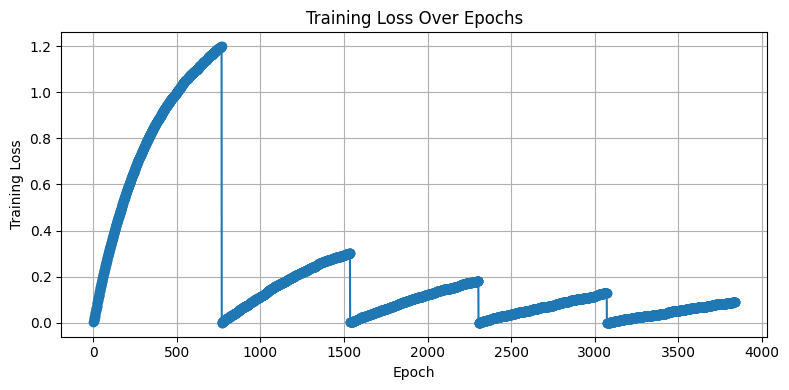

In [10]:
# --- Plot training loss ---
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.tight_layout()
plt.show()

### Running predictions on the test set after training.

In [11]:
class_to_index = {cls: idx for idx, cls in enumerate(selected_classes)}
index_to_class = {v: k for k, v in class_to_index.items()}

# Run predictions
y_true = []
y_pred = []

for _, row in test_df.iterrows():
    category = row['category']
    filename = row['filename']
    true_class = class_to_index.get(category)

    video_path = os.path.join("UCF-101", category, filename)
    if not os.path.exists(video_path):
        print(f"Missing: {video_path}")
        continue

    pred_class = predict_video(video_path)
    y_true.append(true_class)
    y_pred.append(pred_class)

    print(f"{filename}: true={category}, predicted={index_to_class[pred_class]}")

v_HeadMassage_g23_c05.avi: true=HeadMassage, predicted=HeadMassage
v_JumpingJack_g25_c04.avi: true=JumpingJack, predicted=JumpingJack
v_HeadMassage_g19_c01.avi: true=HeadMassage, predicted=HeadMassage
v_Basketball_g18_c04.avi: true=Basketball, predicted=Basketball
v_PlayingPiano_g16_c07.avi: true=PlayingPiano, predicted=PlayingPiano
v_PlayingPiano_g14_c01.avi: true=PlayingPiano, predicted=PlayingPiano
v_BabyCrawling_g18_c01.avi: true=BabyCrawling, predicted=BabyCrawling
v_HeadMassage_g01_c01.avi: true=HeadMassage, predicted=HeadMassage
v_SalsaSpin_g03_c04.avi: true=SalsaSpin, predicted=SalsaSpin
v_HeadMassage_g17_c07.avi: true=HeadMassage, predicted=HeadMassage
v_JumpingJack_g16_c01.avi: true=JumpingJack, predicted=JumpingJack
v_PlayingPiano_g21_c02.avi: true=PlayingPiano, predicted=PlayingPiano
v_SalsaSpin_g24_c02.avi: true=SalsaSpin, predicted=SalsaSpin
v_SoccerJuggling_g25_c06.avi: true=SoccerJuggling, predicted=SoccerJuggling
v_PlayingGuitar_g17_c03.avi: true=PlayingGuitar, predict

### Evaluating the predictions


Overall Accuracy: 98.18%

Classification Report:
                  precision    recall  f1-score   support

   ApplyLipstick       1.00      1.00      1.00        23
    BabyCrawling       0.96      0.96      0.96        26
      Basketball       0.96      0.96      0.96        27
CuttingInKitchen       0.96      1.00      0.98        22
       GolfSwing       1.00      1.00      1.00        28
         Haircut       1.00      0.96      0.98        26
HandstandWalking       0.87      0.91      0.89        22
     HeadMassage       1.00      1.00      1.00        30
     JumpingJack       0.96      0.96      0.96        25
   PlayingGuitar       1.00      1.00      1.00        32
    PlayingPiano       1.00      1.00      1.00        21
   PlayingViolin       1.00      1.00      1.00        20
       SalsaSpin       1.00      1.00      1.00        27
  SoccerJuggling       1.00      0.97      0.98        29
          Typing       1.00      1.00      1.00        27

        accuracy    

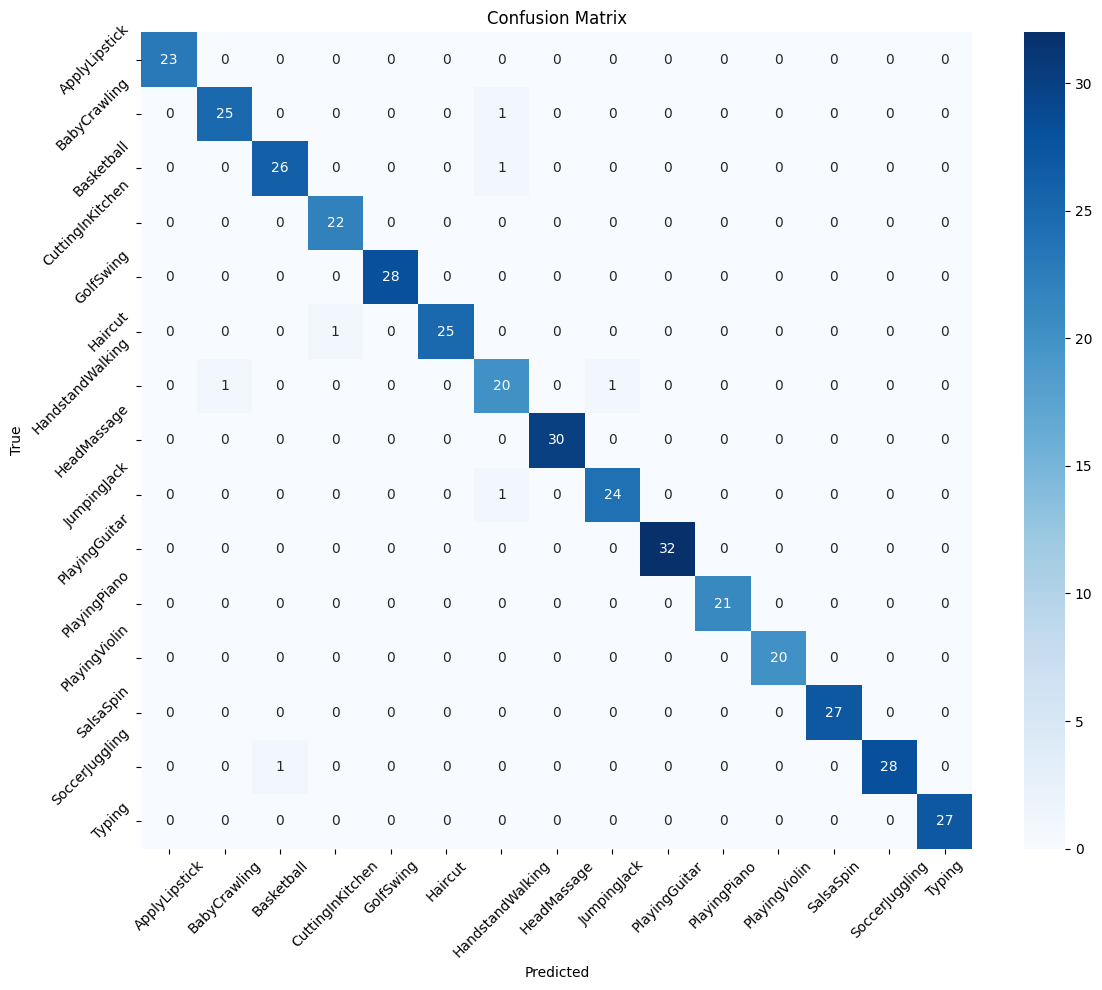

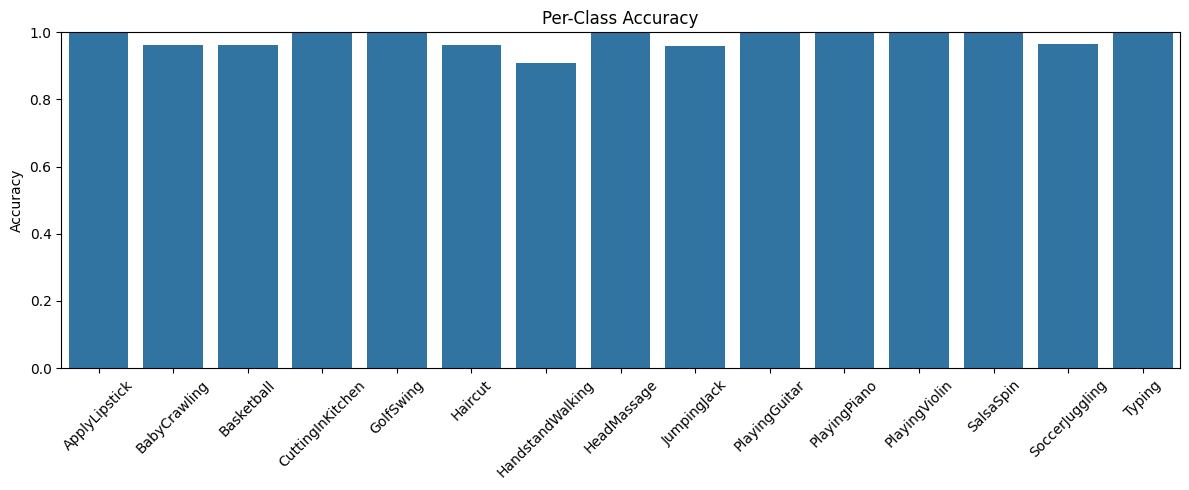

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# --- Class names ---
class_names = selected_classes

# --- Accuracy ---
acc = accuracy_score(y_true, y_pred)
print(f"\nOverall Accuracy: {acc:.2%}")

# --- Classification Report ---
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:")
print(report)

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Oranges")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Class-wise accuracy ---
class_correct = [0] * len(class_names)
class_total = [0] * len(class_names)

for true, pred in zip(y_true, y_pred):
    class_total[true] += 1
    if true == pred:
        class_correct[true] += 1

class_accuracy = [correct / total if total > 0 else 0 for correct, total in zip(class_correct, class_total)]

plt.figure(figsize=(12, 5))
sns.barplot(x=class_names, y=class_accuracy)
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Per-Class Accuracy")
plt.tight_layout()
plt.show()

### Sample of predicted classes for some samples of test data

In [24]:
import random

# --- Show sample predictions ---
sample_indices = random.sample(range(len(y_true)), 10)

print("\nSample Predictions:")
for i in sample_indices:
    true_label = index_to_class[y_true[i]]
    pred_label = index_to_class[y_pred[i]]
    print(f"[{i}] Predicted: {pred_label:<20} | True: {true_label}")



Sample Predictions:
[142] Predicted: GolfSwing            | True: GolfSwing
[159] Predicted: BabyCrawling         | True: BabyCrawling
[68] Predicted: JumpingJack          | True: JumpingJack
[22] Predicted: JumpingJack          | True: JumpingJack
[6] Predicted: BabyCrawling         | True: BabyCrawling
[117] Predicted: PlayingViolin        | True: PlayingViolin
[227] Predicted: SoccerJuggling       | True: SoccerJuggling
[329] Predicted: PlayingViolin        | True: PlayingViolin
[290] Predicted: HeadMassage          | True: HeadMassage
[82] Predicted: HandstandWalking     | True: BabyCrawling


## Alternative Approaches


### Approach #1 - R3D model
Model used: R3d-18: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.video.r3d_18.html
Pretrained on: Kinetics-400: https://arxiv.org/abs/1705.06950

Done by Vaisakh Pariyacheri

The R3D model pretrained on kinetics-400 dataset is finetuned on UCF101 videos and then testes for accuraccy. The finetuned model is imported here.

Finetuned model link: https://liveswinburneeduau-my.sharepoint.com/:u:/g/personal/105260443_student_swin_edu_au/EehDG1gTKXdIpEXEoy0K7ogBq5YzhaebipABylN1HHp6Yg?e=ZIxYuV

In [105]:
import torchvision
from torchvision.models.video import r3d_18, R3D_18_Weights
import torch.nn as nn
from torch.utils.data import DataLoader
import cv2
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt 

In [65]:
#loading the model
r3d_model = r3d_18()

r3d_model.fc = nn.Linear(model.fc.in_features, 15)

checkpoint_path = "r3d_ucf15_finetuned.pth"
state_dict = torch.load(checkpoint_path, map_location=device)
r3d_model.load_state_dict(state_dict)

/var/folders/t6/hpxb1t0n55b0vqtl13l310mh0000gn/T/ipykernel_79021/1713379619.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_

<All keys matched successfully>

In [69]:
# paths for videos and also the custom test train splits
video_root = "/Users/jokar/Documents/Semester 3/ml/finalproject/UCF101"
train_csv  = "/Users/jokar/Documents/Semester 3/ml/finalproject/trainsplit15.csv"
test_csv   = "/Users/jokar/Documents/Semester 3/ml/finalproject/testsplit15.csv"


# Read the train test split into pandas dataframe
df_train = pd.read_csv(train_csv)
df_test  = pd.read_csv(test_csv)
print("----------- Printing Samples of train: ")
print(df_train.head())
print("\n\n----------- Printing Samples of test: ")
print(df_test.head())
# Build categories from the train df
categories = df_train["category"].unique().tolist()
label_map  = {cat: i for i, cat in enumerate(categories)}
print("\n\n----------- Printing Samples of Categories: ")
print(categories)

print("\n\n----------- Printing Samples of labels: ")
print(label_map)

#Setting up transformation function
frame_tf = transforms.Compose([
    transforms.Resize((112,112)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.43216, 0.394666, 0.37645], # since the r3d model is trained on kinetics-400, using the value for that to normalize
        std =[0.22803, 0.22145, 0.216989]
    ),
])
print("\n\n----------- Transformation function: ")
print(type(frame_tf))

----------- Printing Samples of train: 
   class                        filename          category
0     25  v_CuttingInKitchen_g22_c04.avi  CuttingInKitchen
1     67     v_PlayingViolin_g18_c03.avi     PlayingViolin
2     95            v_Typing_g01_c06.avi            Typing
3     77         v_SalsaSpin_g24_c01.avi         SalsaSpin
4     33         v_GolfSwing_g21_c05.avi         GolfSwing


----------- Printing Samples of test: 
   class                    filename      category
0     39   v_HeadMassage_g23_c05.avi   HeadMassage
1     47   v_JumpingJack_g25_c04.avi   JumpingJack
2     39   v_HeadMassage_g19_c01.avi   HeadMassage
3      8    v_Basketball_g18_c04.avi    Basketball
4     64  v_PlayingPiano_g16_c07.avi  PlayingPiano


----------- Printing Samples of Categories: 
['CuttingInKitchen', 'PlayingViolin', 'Typing', 'SalsaSpin', 'GolfSwing', 'HeadMassage', 'ApplyLipstick', 'SoccerJuggling', 'BabyCrawling', 'Basketball', 'PlayingPiano', 'PlayingGuitar', 'Haircut', 'JumpingJack',

In [71]:
# Helpe functions to extract and preprocess a single clip
def get_middle_clip(frames, clip_len=16):
    n = len(frames)
    if n < clip_len:
        frames += [frames[-1]]*(clip_len - n)
        n = clip_len
    start = (n - clip_len)//2
    return frames[start:start+clip_len]

def load_clip_tensor(path):
    # read all frames
    cap, frames = cv2.VideoCapture(path), []
    while True:
        ret, frame = cap.read()
        if not ret: break
        frames.append(frame)
    cap.release()
    # take middle 16 and preprocess
    clip = get_middle_clip(frames, 16)
    tfed = []
    for f in clip:
        pil = Image.fromarray(cv2.cvtColor(f, cv2.COLOR_BGR2RGB))
        tfed.append(frame_tf(pil))
    # stack → [3,16,112,112]
    return torch.stack(tfed, dim=1)


# Collate function to turn a batch of video path into tensor as we are using DataLoader
def collate_fn(batch):
    clips, labels = [], []
    for path, lbl in batch:
        clips.append(load_clip_tensor(path))
        labels.append(lbl)
    # [B,3,16,112,112] and [B]
    return torch.stack(clips), torch.tensor(labels)


In [73]:
#Creating a list of video file path and labels for training and testing
train_samples = [
    (os.path.join(video_root, row.filename),
     label_map[row.category])
    for row in df_train.itertuples()
]
print("----------- Train samples with video paths: \n",train_samples[0:2])


test_samples  = [
    (os.path.join(video_root, row.filename),
     label_map.get(row.category, -1))  # or handle unseen cats
    for row in df_test.itertuples()
]
print("\n\n----------- Test samples with video paths: \n",test_samples[0:2])


----------- Train samples with video paths: 
 [('/Users/jokar/Documents/Semester 3/ml/finalproject/UCF101/v_CuttingInKitchen_g22_c04.avi', 0), ('/Users/jokar/Documents/Semester 3/ml/finalproject/UCF101/v_PlayingViolin_g18_c03.avi', 1)]


----------- Test samples with video paths: 
 [('/Users/jokar/Documents/Semester 3/ml/finalproject/UCF101/v_HeadMassage_g23_c05.avi', 5), ('/Users/jokar/Documents/Semester 3/ml/finalproject/UCF101/v_JumpingJack_g25_c04.avi', 13)]


In [87]:
train_loader = DataLoader(
    train_samples, batch_size=2, shuffle=True,
    collate_fn=collate_fn, num_workers=0, pin_memory=True
)
print("----------- Train tensor: \n",train_loader)

test_loader  = DataLoader(
    test_samples,  batch_size=2, shuffle=False,
    collate_fn=collate_fn, num_workers=0, pin_memory=True
)
print("\n\n----------- Test tensor: \n",test_loader)


batch_clips, batch_labels = next(iter(train_loader))
print("\n\n----------- Train tensor shape (should be ([2, 3, 16, 112, 112])):")
print(batch_clips.shape) 
print(batch_labels) 

----------- Train tensor: 


----------- Test tensor: 


----------- Train tensor shape (should be ([2, 3, 16, 112, 112])):
torch.Size([2, 3, 16, 112, 112])
tensor([3, 1])


In [89]:
all_preds, all_labels = [], []

with torch.no_grad():
    for clips, labels in test_loader:
        clips, labels = clips.to(device), labels.to(device)
        outputs = r3d_model(clips)
        preds   = outputs.argmax(dim=1)
        all_preds .extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

Test Accuracy:  0.9246753246753247


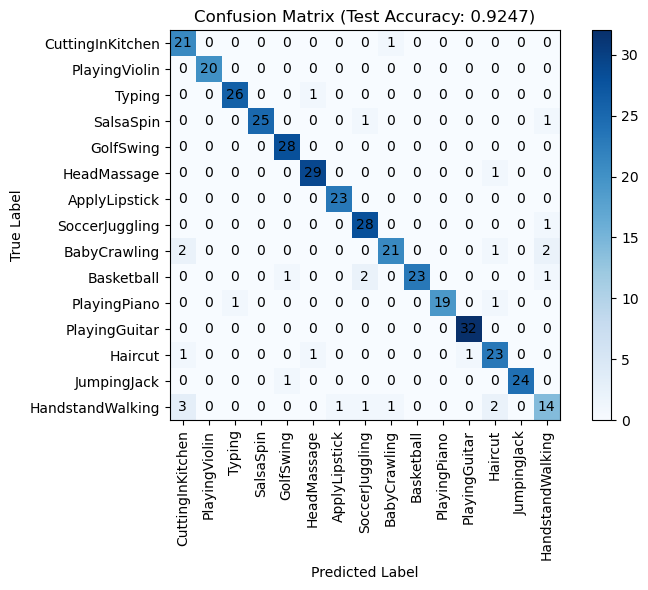

In [97]:
#Computing the testing accuraccy and confusion matrix
test_acc = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print("Test Accuracy: ",test_acc )

# Plot the matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')  # default colormap
ax.set_title(f"Confusion Matrix (Test Accuracy: {test_acc:.4f})")
fig.colorbar(im, ax=ax) #colors
tick_marks = np.arange(len(categories))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(categories, rotation=90)
ax.set_yticklabels(categories)
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center")

plt.tight_layout()
plt.show()

### Approach #2 - R(2+1)D model

Model used: r2plus1d_18: https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth
Pretrained on: Kinetics-400: https://arxiv.org/abs/1705.06950

Done by Pratik Karmacharya

The R(2+1) model pretrained on kinetics-400 dataset is finetuned on UCF101 videos and then testes for accuraccy. The finetuned model is imported here.

Link to the finetuned model weights: https://liveswinburneeduau-my.sharepoint.com/:u:/r/personal/105260443_student_swin_edu_au/Documents/Swinburne%20University%20Notes/2025/Semester%201/COS80027%20-%20Machine%20Learning/Assignments/Assignment%203/ResNet(2+1)/resnet2p1d_ucf101.pth

In [4]:

import os
import random
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision
from torchvision import transforms


In [3]:
#setting seeds for reproducibility
def set_seed(seed=33):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(33)

# Configuration
CONFIG = {
    'root_dir': 'UCF-101',
    'selected_classes': [
        'ApplyLipstick', 'BabyCrawling', 'Basketball', 'CuttingInKitchen', 'GolfSwing',
        'Haircut', 'HandstandWalking', 'HeadMassage', 'JumpingJack', 'PlayingGuitar',
        'PlayingPiano', 'PlayingViolin', 'SalsaSpin', 'SoccerJuggling', 'Typing'
    ],
    'frames_per_clip': 16,
    'batch_size': 4,
    'num_epochs': 10,
    'learning_rate': 1e-3,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}


In [4]:
class UCF101Dataset(Dataset):
    def __init__(self, root_dir, class_list, frames_per_clip=16, transform=None):
        self.root_dir = root_dir
        self.class_list = class_list
        self.label_map = {cls: idx for idx, cls in enumerate(class_list)}
        self.samples = []
        self.frames_per_clip = frames_per_clip
        self.transform = transform

        for cls in class_list:
            class_path = os.path.join(root_dir, cls)
            for vid in os.listdir(class_path):
                if vid.endswith('.avi'):
                    self.samples.append((os.path.join(class_path, vid), self.label_map[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        cap = cv2.VideoCapture(path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (112, 112))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()

        # Sample or pad frames
        if len(frames) >= self.frames_per_clip:
            idxs = np.linspace(0, len(frames) - 1, self.frames_per_clip).astype(int)
            frames = [frames[i] for i in idxs]
        else:
            if len(frames) == 0:
                frames = [np.zeros((112, 112, 3), dtype=np.uint8)] * self.frames_per_clip
            else:
                frames += [frames[-1]] * (self.frames_per_clip - len(frames))

        clip = []
        for frame in frames:
            tensor_frame = transforms.ToTensor()(frame)
            if self.transform:
                tensor_frame = self.transform(tensor_frame)
            clip.append(tensor_frame)

        clip = torch.stack(clip)  # (T, C, H, W)
        clip = clip.permute(1, 0, 2, 3)  # (C, T, H, W)

        return clip, label



In [5]:
# using ImageNet stats
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])


In [6]:
# Initializing the dataset
full_dataset = UCF101Dataset(CONFIG['root_dir'], CONFIG['selected_classes'],
                             frames_per_clip=CONFIG['frames_per_clip'], transform=normalize)

# Split into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)


In [9]:
device='cuda' if torch.cuda.is_available() else 'cpu'

r2plus1d = model = torchvision.models.video.r2plus1d_18()
r2plus1d.fc = nn.Linear(model.fc.in_features,15)

checkpoint_path = "resnet2p1d_ucf101.pth"
state_dict = torch.load(checkpoint_path, map_location=device)
r2plus1d.load_state_dict(state_dict)

/var/folders/t6/hpxb1t0n55b0vqtl13l310mh0000gn/T/ipykernel_83816/2097202909.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_

<All keys matched successfully>

In [7]:
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(CONFIG['device']), labels.to(CONFIG['device'])
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = correct / total
    return running_loss / len(loader), acc, all_preds, all_labels


Test Loss: 0.0515, Acc: 0.9827
Classification Report:
                  precision    recall  f1-score   support

   ApplyLipstick       1.00      1.00      1.00        17
    BabyCrawling       1.00      0.96      0.98        25
      Basketball       0.89      0.94      0.92        18
CuttingInKitchen       1.00      1.00      1.00        18
       GolfSwing       1.00      1.00      1.00        17
         Haircut       1.00      1.00      1.00        21
HandstandWalking       0.94      1.00      0.97        15
     HeadMassage       1.00      1.00      1.00        18
     JumpingJack       0.95      1.00      0.98        21
   PlayingGuitar       1.00      1.00      1.00        18
    PlayingPiano       1.00      1.00      1.00        14
   PlayingViolin       1.00      1.00      1.00        18
       SalsaSpin       1.00      1.00      1.00        18
  SoccerJuggling       0.97      0.90      0.93        31
          Typing       1.00      1.00      1.00        20

        accuracy

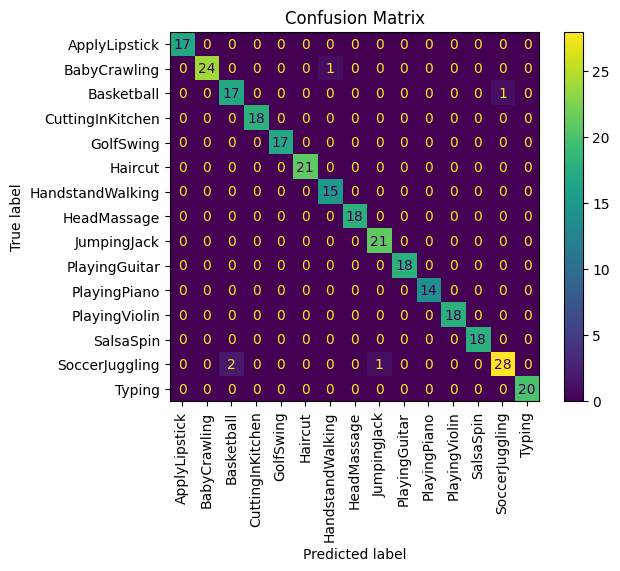

In [12]:
criterion = nn.CrossEntropyLoss()
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=CONFIG['selected_classes']))

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=CONFIG['selected_classes'])
disp.plot(xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()
